# [CPD22-7a] LocalCongruence
## Progetto a cura di:
###       Gabriele Romualdi 521111
###       Simone Chilosi 522155
<br><br>
### Link Github: https://github.com/Panemiele/LarCongruence.jl

# <br><br><br> GLOBAL SET UP

In [1]:
using BenchmarkTools
using ViewerGL, LinearAlgebra
using LinearAlgebraicRepresentation
using NearestNeighbors, DataStructures, SparseArrays
using StatsAPI
using SuiteSparseGraphBLAS, GraphBLASInterface
using SparseMM
using LarCongruence
using Images
using Colors
using Base.Threads;
nthreads()

6

In [2]:
GL = ViewerGL
Lar = LinearAlgebraicRepresentation
LC = LarCongruence
GrB_init(GrB_NONBLOCKING)

GrB_SUCCESS::GrB_Info = 0

# <br><br><br> Applied Changes

In questa sezione, verranno discusse le modifiche apportate al codice sorgente che hanno permesso di ottenere, in certi casi, dei miglioramenti delle prestazioni, facendo uso delle principali tecniche di parallelizzazione fornite da julia, come: threads, tasks, simd.

Come si vedrà dagli esempi, le implementazioni originali già hanno buone prestazioni, soprattutto quelle basate su GraphBLAS e Array of Arrays. Tuttavia le modifiche apportate hanno comunque permesso di ridurre i tempi di esecuzioni di queste ultime due implementazioni più performanti, mentre invece per Julia Native Sparse Matrix i risultati sono uguali o alle volte leggermente peggiori rispetto alla versione originale.

## Julia Native Sparse Matrix

## GraphBLAS

Nell'implementazione che usa GraphBLAS si possono notare miglioramenti dal punto di vista delle prestazioni grazie all'utilizzo dei threads. Questo per via del fatto che la funzione 'cell_congruence' esegue la congruenza delle geometrie faccia per faccia; ripetendo questa operazione in modo parallelo, usando i threads, i tempi di esecuzione vengono ridotti in quanto sono tutte operazioni indipendenti fra di loro, garantendo la correttezza dell'output.

Di seguito si mostra il codice sorgente che ha permesso di ottenere i risultati desiderati: sebbene sia una piccola modifica, i risultati saranno evidenti in tutti gli esempi.

```julia
@threads for i in eachindex(Topn)
	Topn[i], cls = cellCongruence_OPT(Top[i], cls)
end
```

## Array of Arrays

# <br><br><br><br><br><br>EXAMPLE 1

Nel primo esempio si confrontano le prestazioni di 'chainCongruence' su una matrice di piccole dimensioni(3x24), i test eseguiti sono relativi alle due implementazioni della funzione: la prima si basa su Julia Native Sparse Matrix, la seconda utilizza la libreria SuiteSparseGraphBLAS. 

Essendo la matrice di piccole dimensioni,le prestazioni dovrebbero essere simili tra versione originale e versione da noi modificata, l'importante è che ciò che si ottiene in output sia uguale.

Per evidenziare l'uguaglianza di output si può rappresentare la matrice di output graficamente usando la funzione 'colorview' del package Images.jl

## Example 1 - SET UP

In [3]:
G = [
	0.5310492999999998 1.0146684 0.3477716 0.8313907882395298 0.6061046999999998 1.0897237999999998 0.42282699999999984 0.9064461979373597 0.5310493 1.0146684000000001 0.6061047 1.0897237772434623 0.3477716 0.8313908 0.422827 0.9064462 0.5310493 0.34777160000000007 0.6061047 0.4228270000000002 1.0146684 0.8313908 1.0897238 0.9064461675456482;
	0.8659989999999999 0.6827212999999999 0.5268921 0.3436144447063971 1.2188832999999994 1.0356056999999999 0.8797763999999998 0.6964987903021808 0.8659989999999999 0.6827213 1.2188833 1.035605657895053 0.5268921 0.3436145 0.8797764000000001 0.6964988 0.8659989999999999 0.5268920999999999 1.2188833 0.8797764 0.6827213 0.3436145 1.0356057 0.6964988122992563;
	0.14191280000000003 0.2169682 0.4947971000000001 0.5698524407571428 0.5200012 0.5950565999999999 0.8728855 0.9479408896095312 0.14191279999999987 0.21696819999999994 0.5200011999999999 0.5950566438156151 0.4947971 0.5698525000000001 0.8728855 0.9479409 0.14191280000000006 0.4947971000000001 0.5200012000000002 0.8728855000000001 0.21696819999999994 0.5698525000000001 0.5950565999999999 0.9479408949632379
];

In [4]:
W = convert(Lar.Points, G')

24×3 Matrix{Float64}:
 0.531049  0.865999  0.141913
 1.01467   0.682721  0.216968
 0.347772  0.526892  0.494797
 0.831391  0.343614  0.569852
 0.606105  1.21888   0.520001
 1.08972   1.03561   0.595057
 0.422827  0.879776  0.872885
 0.906446  0.696499  0.947941
 0.531049  0.865999  0.141913
 1.01467   0.682721  0.216968
 0.606105  1.21888   0.520001
 1.08972   1.03561   0.595057
 0.347772  0.526892  0.494797
 0.831391  0.343614  0.569853
 0.422827  0.879776  0.872885
 0.906446  0.696499  0.947941
 0.531049  0.865999  0.141913
 0.347772  0.526892  0.494797
 0.606105  1.21888   0.520001
 0.422827  0.879776  0.872886
 1.01467   0.682721  0.216968
 0.831391  0.343614  0.569853
 1.08972   1.03561   0.595057
 0.906446  0.696499  0.947941

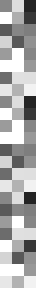

In [14]:
colorview(Gray, W)

In [5]:
Delta_0 = SparseArrays.sparse(([1, 3, 1, 4, 2, 3, 2, 4, 5, 7, 5, 8, 6, 7, 6, 8, 9, 11, 9, 12, 10, 11, 10, 12, 13, 15, 13, 16, 14, 15, 14, 16, 17, 19, 17, 20, 18, 19, 18, 20, 21, 23, 21, 24, 22, 23, 22, 24],[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24],Int8[-1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1])...);

In [6]:
Delta_1 = SparseArrays.sparse(([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6],[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],Int8[1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1])...);

In [7]:
T = [Delta_0, Delta_1];

## Example 1 - Julia Native Sparse Matrix

### Normal Version

In [12]:
@benchmark LC.chainCongruenceSM(W', T)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  127.643 μs …  17.757 ms  ┊ GC (min … max): 0.00% … 98.13%
 Time  (median):     134.972 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   158.265 μs ± 416.276 μs  ┊ GC (mean ± σ):  9.00% ±  3.53%

  ▅███▆▅▄▃▃▂▂▁▁ ▁  ▁▁                                           ▂
  ████████████████████▇▇▇▇▆▆▆▅▅▅▆▄▅▅▄▅▄▄▄▄▅▄▇▇▆▆▆▅▅▇▇▇▇██████▇▆ █
  128 μs        Histogram: log(frequency) by time        271 μs <

 Memory estimate: 84.27 KiB, allocs estimate: 1307.

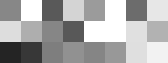

In [8]:
Wn, Tn = LC.chainCongruenceSM(W', T)
colorview(Gray, Wn)

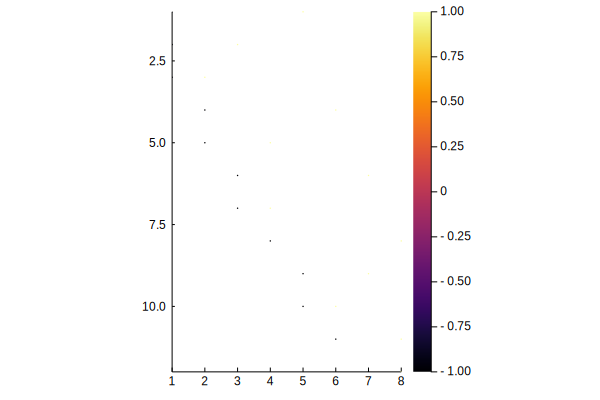

In [11]:
using Plots
spy(Tn[1])

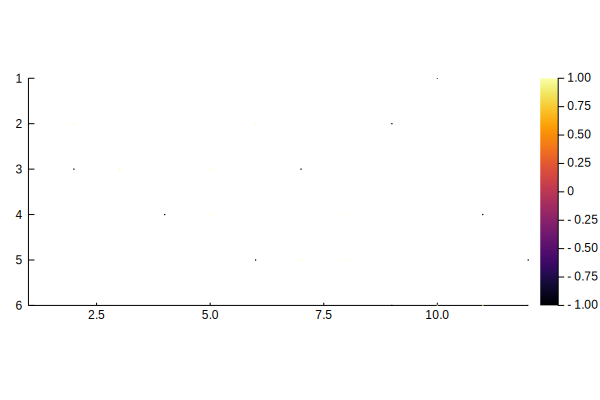

In [12]:
spy(Tn[2])

### Optimized Version

In [9]:
W'

3×24 adjoint(::Matrix{Float64}) with eltype Float64:
 0.531049  1.01467   0.347772  0.831391  …  0.831391  1.08972   0.906446
 0.865999  0.682721  0.526892  0.343614     0.343614  1.03561   0.696499
 0.141913  0.216968  0.494797  0.569852     0.569853  0.595057  0.947941

In [11]:
@benchmark LC.chainCongruenceSM_OPT(G, T)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  149.383 μs …   9.274 ms  ┊ GC (min … max): 0.00% … 97.45%
 Time  (median):     155.001 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   172.531 μs ± 296.874 μs  ┊ GC (mean ± σ):  6.56% ±  3.76%

  ▅██▇▆▅▄▄▃▂▂▁▁ ▁▁     ▁▁                                       ▂
  █████████████████████████▇▇▆▇▆▅▆▆▄▅▅▅▅▆▃▅▅▅▄▃▄▅▁▃▅▁▅▅▇███▇▆▅▅ █
  149 μs        Histogram: log(frequency) by time        274 μs <

 Memory estimate: 101.14 KiB, allocs estimate: 1471.

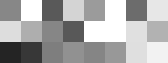

In [26]:
Wn, Tn = LC.chainCongruenceSM_OPT(W, T)
colorview(Gray, Wn)

## <br> Example 1 - GraphBLAS based

In [27]:
Delta_0_GB = SparseMM.sm2gbm(Delta_0)
Delta_1_GB = SparseMM.sm2gbm(Delta_1)
T_GB = [Delta_0_GB, Delta_1_GB]

2-element Vector{GrB_Matrix{Int8}}:
 
 

GrB_Matrix{Int8}GrB_Matrix{Int8}GrB_Matrix{Int8}GrB_Matrix{Int8}GrB_Matrix{Int8}GrB_Matrix{Int8}

### Normal Version

In [28]:
@benchmark LC.chainCongruenceGB(W, T_GB)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  121.860 μs …   9.067 ms  ┊ GC (min … max): 0.00% … 97.53%
 Time  (median):     128.853 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   134.909 μs ± 151.734 μs  ┊ GC (mean ± σ):  2.21% ±  1.95%

   █▅▃▂▁   ▂▁                                                    
  ▄█████▇▄▆██▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  122 μs           Histogram: frequency by time          202 μs <

 Memory estimate: 27.52 KiB, allocs estimate: 477.

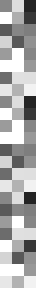

In [29]:
Wn, Tn = LC.chainCongruenceGB(W, T_GB)
colorview(Gray, Wn)

### Optimized Version

In [9]:
@benchmark LC.chainCongruenceGB_OPT(W, T_GB)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   83.970 μs …   6.239 ms  ┊ GC (min … max): 0.00% … 95.30%
 Time  (median):      96.241 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   105.207 μs ± 156.658 μs  ┊ GC (mean ± σ):  2.00% ±  1.93%

    ▇█▅▃▄▄▄▄▃▃▂▁                                                 
  ▂██████████████▆▆▅▄▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  84 μs            Histogram: frequency by time          166 μs <

 Memory estimate: 29.58 KiB, allocs estimate: 491.

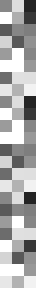

In [30]:
Wn, Tn = LC.chainCongruenceGB_OPT(W, T_GB)
colorview(Gray, Wn)

## <br> Example 1 - Array of arrays based

In [23]:
@benchmark V,EV,FV = LC.chainCongruenceAA(W, T)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  50.882 μs …   9.839 ms  ┊ GC (min … max):  0.00% … 98.97%
 Time  (median):     54.324 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   62.831 μs ± 228.453 μs  ┊ GC (mean ± σ):  10.80% ±  2.96%

    ▂█▇▁                                                        
  ▂▆████▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  50.9 μs         Histogram: frequency by time         96.3 μs <

 Memory estimate: 60.31 KiB, allocs estimate: 889.

In [24]:
EV = Lar.removeDups(map(sort!,EV))
FV = Lar.removeDups(map(sort!,FV))
VV = [[v] for v=1:size(V,2)]

8-element Vector{Vector{Int64}}:
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]

# <br><br><br><br><br><br>EXAMPLE 2

Nel secondo test, la matrice che rappresenta la geometria di input è di dimensioni leggermente maggiori rispetto alla precedente, per cui ci si aspetta differenze di prestazioni leggeremente più marcate.

Per verificare sempre la correttezza degli output, essi vengono rappresentati graficamente con Images.jl

## Example 2 - Set up

In [21]:
G = [0.4851363000000001 0.5099412000000001 0.4604538000000001 0.4852586932051473 0.5099412 0.5347462 0.4852588 0.5100638087892613 0.5347461999999997 0.5595511999999998 0.5100636999999998 0.5348687087555339 0.46045379999999997 0.48525879999999993 0.4357712999999999 0.46057630875553396 0.4852587999999998 0.5100636999999998 0.4605762999999998 0.485381191210697 0.5100636999999999 0.5348686999999999 0.4853812999999999 0.510186289283825 0.43577130000000003 0.46057630000000005 0.41108890000000003 0.4358938892838253 0.46057630000000005 0.48538130000000007 0.43589380000000005 0.4606988195054789 0.48538129999999996 0.5101861999999999 0.46069879999999996 0.4855036999999999 0.7325833 0.7573883 0.7079008 0.732705808755534 0.7573882999999998 0.7821931999999998 0.7327057999999997 0.7575106892500558 0.7821932000000001 0.8069982000000001 0.7575107000000001 0.7823156912444693 0.7079008 0.7327058 0.6832184 0.7080233892838251 0.7327057999999999 0.7575106999999999 0.7080232999999999 0.7328282127105769 0.7575107 0.7823156999999998 0.7328283 0.7576333067948982 0.6832184000000002 0.7080233000000002 0.6585359000000002 0.6833408000000002 0.7080233000000001 0.7328283000000001 0.6833408000000001 0.7081457892500528 0.7328283 0.7576332 0.7081458 0.7329506932051473 0.9800303 1.0048353 0.9553478 0.9801527912444694 1.0048353000000003 1.0296402000000002 0.9801528000000003 1.004957712710577 1.0296402 1.0544452 1.0049578 1.029762806794898 0.9553478000000003 0.9801528000000004 0.9306654000000003 0.9554703980393594 0.9801528 1.0049578 0.9554703 0.9802752892500525 1.0049577999999997 1.0297626999999998 0.9802752999999997 1.0050801932051472 0.9306654 0.9554703 0.9059829 0.9307878019606395 0.9554702999999996 0.9802752999999995 0.9307878999999994 0.9555929175448041 0.9802753000000002 1.0050803000000001 0.9555928000000002 0.9803978000000003 1.2274773000000003 1.2522823000000003 1.2027949000000002 1.2275999067948984 1.2522823 1.2770873 1.2275998 1.2524047892500525 1.2770873 1.3018922 1.2524048 1.2772096932051473 1.2027949 1.2275998 1.1781124 1.2029172932051473 1.2275998000000001 1.2524048000000003 1.2029174000000002 1.227722408789262 1.2524047999999997 1.2772097999999996 1.2277222999999995 1.2525273087555335 1.1781123999999998 1.2029173999999998 1.1534298999999997 1.1782348999999996 1.2029174 1.2277223 1.1782349 1.2030397892500562 1.2277222999999997 1.2525272999999997 1.2030397999999998 1.227844791244469 0.4851363000000001 0.5099412000000001 0.7325833000000002 0.7573882979522348 0.5099411999999999 0.5347462 0.7573883000000001 0.7821931912058342 0.5347461999999998 0.5595511999999999 0.7821932 0.806998201072288 0.46045379999999997 0.4852587999999999 0.7079008 0.7327058010722881 0.4852588000000001 0.5100637 0.7327058000000001 0.7575107097696032 0.5100637000000002 0.5348687000000001 0.7575107000000001 0.7823156989277071 0.43577129999999986 0.4605762999999999 0.6832183999999999 0.7080232999031792 0.4605762999999998 0.48538129999999985 0.7080232999999998 0.7328282902303588 0.4853812999999999 0.5101861999999999 0.7328283 0.7576332010722877 0.4110888999999999 0.4358938 0.6585359 0.6833408000000001 0.4358937999999999 0.4606987999999999 0.6833408 0.7081458086973149 0.4606988000000001 0.48550370000000015 0.7081458000000003 0.7329507990245284 0.7325833000000002 0.7573883000000001 0.9800303000000001 1.0048353010722884 0.7573882999999998 0.7821931999999999 1.0048352999999999 1.0296402097696031 0.7821932000000001 0.8069982 1.0296402 1.054445198927707 0.7079008 0.7327058000000001 0.9553478 0.9801527989277072 0.7327058 0.7575107 0.9801528 1.0049577892548855 0.7575106999999999 0.7823156999999996 1.0049578 1.0297627020477507 0.6832184 0.7080233000000002 0.9306654000000002 0.9554703000000001 0.7080233 0.7328282999999999 0.9554703 0.9802753097696029 0.7328283 0.7576332 0.9802753000000002 1.0050802979522349 0.6585359000000001 0.6833408000000001 0.9059829 0.9307878990245285 0.6833408000000002 0.7081458 0.9307879000000001 0.9555927922781232 0.7081458000000002 0.7329508000000002 0.9555928 0.9803978 0.9800302999999997 1.0048352999999999 1.2274773 1.252282298927707 1.0048353 1.0296402 1.2522822999999996 1.2770872892548857 1.0296401999999998 1.0544451999999997 1.2770872999999998 1.3018922020477506 0.9553478000000001 0.9801528000000002 1.2027949000000002 1.2275998020477508 0.9801527999999998 1.0049577999999997 1.2275997999999997 1.2524048097696028 1.0049578 1.0297626999999998 1.2524048000000003 1.277209797952235 0.9306653999999999 0.9554703000000001 1.1781123999999998 1.2029173990245283 0.9554702999999999 0.9802752999999997 1.2029173999999996 1.227722291205834 0.9802753 1.0050803 1.2277223 1.2525273010722882 0.9059828999999999 0.9307878999999998 1.1534299 1.1782348999999996 0.9307879000000002 0.9555927999999999 1.1782349 1.2030398086973157 0.9555928 0.9803977999999999 1.2030398 1.2278448 0.48513629999999996 0.4604538000000001 0.7325833 0.7079008088474859 0.5099411999999998 0.48525879999999993 0.7573882999999999 0.7327057901770416 0.5347461999999998 0.5100637 0.7821931999999999 0.7575106911524817 0.5595512 0.5348686999999999 0.8069982 0.7823157108081016 0.4604538 0.4357713 0.7079008 0.6832183901673042 0.48525880000000005 0.4605763 0.7327058000000001 0.7080233108081018 0.5100637000000001 0.48538130000000007 0.7575107 0.7328283088474857 0.5348687000000001 0.5101862 0.7823157000000001 0.7576331891918608 0.43577129999999986 0.4110888999999999 0.6832183999999999 0.6585359000048607 0.4605762999999998 0.43589379999999994 0.7080232999999998 0.6833407891918606 0.4853812999999999 0.46069879999999985 0.7328283 0.7081458009803131 0.5101862 0.4855037 0.7576332 0.7329508098229311 0.7325833 0.7079007999999998 0.9800303000000001 0.9553477911524815 0.7573883 0.7327058000000001 1.0048353000000003 0.9801528108081017 0.7821932000000001 0.7575107 1.0296402 1.0049578078623143 0.8069982000000001 0.7823157000000001 1.0544452000000002 1.0297626891918608 0.7079007999999999 0.6832183999999999 0.9553477999999999 0.9306653990196898 0.7327057999999999 0.7080232999999998 0.9801527999999999 0.9554702891918605 0.7575107000000001 0.7328283000000001 1.0049578000000001 0.9802752921376624 0.7823157000000001 0.7576332 1.0297627 1.0050803098229308 0.6832184 0.6585359 0.9306654000000003 0.9059829108081019 0.7080233 0.6833407999999999 0.9554703 0.9307879098229311 0.7328283 0.7081458000000002 0.9802753000000002 0.9555927990196903 0.7576332 0.7329508 1.0050803000000001 0.9803977901770418 0.9800303000000001 0.9553478000000003 1.2274773000000005 1.202794907862315 1.0048353 0.9801527999999999 1.2522822999999998 1.2275997891918604 1.0296401999999998 1.0049577999999997 1.2770872999999998 1.2524047921376624 1.0544452 1.0297627 1.3018922 1.277209809822931 0.9553478 0.9306654000000001 1.2027949 1.1781124019654912 0.9801527999999999 0.9554703 1.2275997999999997 1.2029174098229312 1.0049578 0.9802753 1.2524048000000003 1.2277223088474856 1.0297626999999998 1.0050802999999997 1.2772097999999998 1.2525272901770415 0.9306654 0.9059829000000001 1.1781124 1.1534298891918606 0.9554703000000002 0.9307879000000004 1.2029174 1.178234890177042 0.9802753 0.9555927999999999 1.2277223 1.2030398009803132 1.0050803 0.9803978 1.2525273 1.2278448108081017;
    0.9680746999999998 0.9433922 1.2152774 1.190594888290028 0.9433921999999999 0.9187098 1.1905949 1.165912411928616 0.9187097999999998 0.8940273 1.1659124 1.1412299009600377 1.2152773999999995 1.1905948999999998 1.4624799999999996 1.4377975009600377 1.1905948999999998 1.1659123999999996 1.4377974999999996 1.4131150880713321 1.1659123999999998 1.1412299 1.4131150999999997 1.38843260978987 1.4624800000000002 1.4377975000000005 1.7096827 1.6850002097898702 1.4377975000000005 1.4131151000000002 1.6850002000000004 1.6603177021387612 1.4131150999999995 1.3884325999999998 1.6603176999999998 1.6356351999999998 0.9952071000000002 0.9705246000000001 1.2424097000000005 1.217727200960038 0.9705245999999998 0.9458421 1.2177271999999997 1.1930447988212762 0.9458420999999999 0.9211596 1.1930448 1.1683622990399625 1.2424097 1.2177272000000001 1.4896124000000002 1.46492990978987 1.2177271999999997 1.1930447999999998 1.4649298999999998 1.4402473904287851 1.1930448 1.1683623 1.4402474000000003 1.4155649117099405 1.4896124000000002 1.4649299000000005 1.7368150000000007 1.7121325000000003 1.4649298999999998 1.4402473999999998 1.7121324999999994 1.687450098821275 1.4402474000000003 1.4155649000000001 1.6874501000000002 1.662767588290028 1.0223393999999997 0.9976568999999998 1.2695420999999998 1.2448595990399625 0.9976569000000004 0.9729745000000004 1.2448596000000005 1.2201770904287856 0.9729745000000001 0.9482920000000001 1.2201771 1.1954946117099403 1.2695421 1.2448596 1.5167447 1.492062210749909 1.2448596000000003 1.2201771000000001 1.4920622000000003 1.4673797988212758 1.2201771 1.1954946000000002 1.4673798 1.4426972882900277 1.5167447000000003 1.4920622 1.7639474000000002 1.7392648892500637 1.4920621999999997 1.4673797999999998 1.7392648999999998 1.7145824128886509 1.4673798 1.4426973 1.7145824000000003 1.6898998999999997 1.0494717999999998 1.0247893 1.2966744000000001 1.2719919117099405 1.0247893 1.0001067999999997 1.2719919 1.2473094988212754 1.0001068 0.9754243 1.2473095 1.2226269882900276 1.2966744 1.2719919000000002 1.5438771 1.5191945882900277 1.2719919 1.2473095000000003 1.5191946 1.4945121119286158 1.2473094999999998 1.2226269999999997 1.4945120999999997 1.4698296009600378 1.5438771 1.5191945999999998 1.7910796999999998 1.7663972000000001 1.5191945999999998 1.4945120999999997 1.7663971999999997 1.7417147988212762 1.4945121000000001 1.4698296000000002 1.7417148000000002 1.7170322990399627 0.9680747000000001 0.9433922000000001 0.9952071000000001 0.9705246205089642 0.9433921999999998 0.9187097999999998 0.9705245999999997 0.9458421880761753 0.9187098 0.8940273 0.9458421 0.9211595892606733 1.2152773999999997 1.1905948999999998 1.2424096999999998 1.2177271892606731 1.1905949 1.1659124 1.2177272 1.1930447021541872 1.1659123999999996 1.1412298999999995 1.1930447999999996 1.1683623107393253 1.4624800000000002 1.4377975000000003 1.4896124000000002 1.464929900969688 1.4377974999999998 1.4131150999999997 1.4649298999999998 1.4402474978458117 1.4131150999999997 1.3884325999999998 1.4402473999999998 1.4155648892606771 1.7096827 1.6850002 1.736815 1.7121324999999998 1.6850002000000002 1.6603177000000002 1.7121325000000003 1.6874500128935104 1.6603177000000002 1.6356352000000003 1.6874501000000002 1.6627676097696376 0.9952071000000001 0.9705246000000001 1.0223394000000001 0.9976568892606733 0.9705246000000001 0.9458421000000001 0.9976569000000001 0.9729744021541875 0.9458421000000001 0.9211596000000001 0.9729745000000001 0.9482920107393258 1.2424096999999998 1.2177271999999997 1.2695420999999998 1.2448596107393255 1.2177272000000001 1.1930448000000002 1.2448596000000003 1.220177207615455 1.1930448 1.1683623 1.2201771 1.1954945794910787 1.4896123999999995 1.4649298999999996 1.5167446999999996 1.4920621999999997 1.4649299 1.4402474 1.4920622 1.4673797021541881 1.4402473999999998 1.4155648999999997 1.4673797999999998 1.4426973205089635 1.736815 1.7121325 1.7639474 1.7392649097696373 1.7121325000000003 1.6874501000000002 1.7392649000000002 1.7145824773368845 1.6874501000000002 1.6627676000000002 1.7145824000000003 1.6898999000000003 1.0223394 0.9976569 1.0494718 1.024789310739326 0.9976568999999997 0.9729744999999997 1.0247892999999997 1.000106907615454 0.9729744999999999 0.9482919999999999 1.0001067999999997 0.9754242794910788 1.2695421 1.2448596 1.2966744 1.2719918794910787 1.2448595999999998 1.2201770999999997 1.2719918999999997 1.2473094021541877 1.2201771 1.1954946 1.2473095 1.2226270205089642 1.5167446999999998 1.4920621999999997 1.5438770999999998 1.519194609769637 1.4920621999999995 1.4673797999999996 1.5191945999999996 1.4945121880761751 1.4673797999999998 1.4426972999999998 1.4945120999999997 1.469829589260673 1.7639474000000002 1.7392649000000002 1.7910797000000005 1.7663972000000003 1.7392649 1.7145824 1.7663972 1.7417147128935053 1.7145824 1.6898999 1.7417148 1.7170322999999998 0.9680746999999997 1.2152774 0.9952071 1.242409691196175 0.9433921999999998 1.1905948999999998 0.9705245999999998 1.217727209774413 0.9187097999999998 1.1659124 0.9458420999999999 1.1930448088037933 0.8940273000000002 1.1412299 0.9211596 1.1683622892452266 1.2152773999999997 1.4624799999999998 1.2424097 1.4896124097841024 1.1905948999999998 1.4377974999999998 1.2177271999999995 1.4649298892452263 1.1659123999999998 1.4131150999999997 1.1930448 1.4402473911961726 1.1412299 1.3884326000000002 1.1683623000000003 1.4155649107547168 1.4624800000000002 1.7096827 1.4896124000000004 1.7368149999951634 1.4377975 1.6850002 1.4649298999999996 1.7121325107547167 1.4131150999999995 1.6603176999999998 1.4402473999999998 1.6874500990245278 1.3884326000000002 1.6356352000000003 1.4155649 1.6627675902255363 0.9952070999999999 1.2424097 1.0223393999999997 1.2695421088037933 0.9705245999999998 1.2177271999999997 0.9976568999999998 1.2448595892452265 0.9458420999999999 1.1930447999999998 0.9729744999999999 1.220177092176485 0.9211596 1.1683623000000003 0.948292 1.1954946107547169 1.2424096999999998 1.4896124 1.2695421 1.5167447009754724 1.2177271999999997 1.4649298999999998 1.2448596 1.4920622107547166 1.1930448 1.4402474000000003 1.2201771 1.4673798078234879 1.1683623 1.4155649 1.1954946 1.442697290225536 1.4896123999999997 1.736815 1.5167447 1.7639473892452262 1.4649299000000002 1.7121324999999998 1.4920622000000001 1.7392648902255363 1.4402474000000003 1.6874501000000002 1.4673798 1.714582400975472 1.4155649 1.6627676 1.4426973000000003 1.6898999097744127 1.0223394 1.2695421 1.0494718000000003 1.296674392176485 0.9976569000000002 1.2448596000000003 1.0247893 1.2719919107547168 0.9729744999999999 1.2201770999999997 1.0001067999999997 1.247309507823488 0.948292 1.1954946 0.9754242999999999 1.2226269902255362 1.2695421 1.5167447 1.2966744 1.5438770980442142 1.2448596 1.4920622000000001 1.2719919000000002 1.5191945902255362 1.2201771 1.4673798 1.2473095 1.4945120911961751 1.1954946 1.4426973 1.2226269999999997 1.469829609774413 1.5167447000000005 1.7639474000000006 1.5438771000000002 1.7910797107547172 1.4920622000000001 1.7392649000000002 1.5191946 1.7663972097744132 1.4673798000000002 1.7145824000000005 1.4945121000000001 1.741714799024528 1.4426972999999998 1.6898999 1.4698296 1.7170322892452263;
    0.9097499999999998 1.1571971 0.9368824 1.1843294095374093 1.1571971 1.4046441 1.1843294000000002 1.4317763902844214 1.4046441 1.6520911 1.4317764 1.6792234992180755 0.9368824000000001 1.1843294 0.9640147000000001 1.2114617992180752 1.1843293999999998 1.4317763999999997 1.2114617999999997 1.4589088097155285 1.4317763999999997 1.6792234999999998 1.4589087999999997 1.706355792026389 0.9640147 1.2114618 0.9911471 1.2385940920263896 1.2114618000000001 1.4589088000000001 1.2385941 1.4860411982580366 1.4589087999999997 1.7063557999999996 1.4860411999999998 1.7334881999999996 0.8876515 1.1350985 0.9147838 1.1622308992180752 1.1350985 1.3825455000000002 1.1622309 1.4096779009600338 1.3825455000000004 1.6299926000000005 1.4096779000000002 1.657124900781924 0.9147838000000001 1.1622308999999997 0.9419162 1.1893631920263896 1.1622309 1.4096779 1.1893632 1.4368102077954668 1.4096779 1.6571248999999997 1.4368102 1.684257290462536 0.9419161999999998 1.1893631999999998 0.9690485999999999 1.2164955999999998 1.1893631999999998 1.4368101999999998 1.2164955999999996 1.463942600960038 1.4368102 1.6842573 1.4639426 1.711389609537409 0.8655529 1.1129999999999998 0.8926852999999999 1.1401323007819242 1.113 1.3604470000000004 1.1401323000000003 1.387579307795467 1.360447 1.6078939999999997 1.3875793 1.635026390462536 0.8926853 1.1401323 0.9198177 1.1672646912444617 1.1401323000000003 1.3875793000000003 1.1672647 1.4147117009600385 1.3875792999999998 1.6350263999999999 1.4147117 1.662158709537409 0.9198177 1.1672646999999998 0.94695 1.1943970087554958 1.1672647 1.4147117000000002 1.194397 1.4418440895024953 1.4147117000000002 1.6621587 1.4418441000000002 1.6892911 0.8434544 1.0909014000000001 0.8705867 1.1180337904625361 1.0909014 1.3383484 1.1180337999999999 1.365480800960038 1.3383484 1.5857955 1.3654807999999998 1.612927809537409 0.8705866999999998 1.1180337999999999 0.8977190999999999 1.145166109537409 1.1180338 1.3654808000000003 1.1451661 1.3926130902844216 1.3654808 1.6129277999999998 1.3926131 1.640060199218075 0.8977191000000001 1.1451661000000002 0.9248515 1.1722985000000001 1.1451661 1.3926131 1.1722984999999997 1.4197455009600337 1.3926131 1.6400602 1.4197455000000003 1.6671925007819244 0.9097499999999998 1.1571971 0.8876514999999999 1.135098502251015 1.1571970999999999 1.4046440999999998 1.1350985 1.382545509667002 1.4046441 1.6520911 1.3825455 1.6299925988212767 0.9368824000000001 1.1843294 0.9147838000000001 1.1622308988212766 1.1843293999999998 1.4317763999999997 1.1622308999999997 1.4096778892606765 1.4317764 1.6792235 1.4096778999999997 1.657124901178723 0.9640147 1.2114618 0.9419162000000001 1.1893632001064307 1.2114617999999997 1.4589087999999997 1.1893631999999998 1.4368102107392913 1.4589088 1.7063557999999999 1.4368101999999998 1.6842572988212776 0.9911471000000001 1.2385941 0.9690486000000001 1.2164956 1.2385940999999998 1.4860411999999998 1.2164956 1.4639425904393994 1.4860412000000003 1.7334882000000003 1.4639426000000004 1.7113896010722924 0.8876515 1.1350985 0.8655528999999997 1.1129999988212766 1.1350984999999998 1.3825455 1.1129999999999998 1.3604469892606765 1.3825455000000004 1.6299926000000005 1.3604470000000002 1.6078940011787235 0.9147838 1.1622308999999997 0.8926852999999999 1.1401323011787232 1.1622309 1.4096779 1.1401323 1.3875793118115767 1.4096778999999997 1.6571248999999995 1.3875792999999998 1.6350263977489887 0.9419162 1.1893632 0.9198177000000001 1.1672647 1.1893632 1.4368102 1.1672647 1.414711689260673 1.4368102 1.6842573 1.4147117 1.6621587022510147 0.9690486 1.2164956 0.9469500000000001 1.1943970010722924 1.2164956 1.4639426 1.194397 1.4418441084882867 1.4639426000000002 1.7113896 1.4418441000000002 1.6892911 0.8655528999999998 1.1129999999999995 0.8434543999999997 1.0909014011787228 1.1129999999999998 1.360447 1.0909013999999997 1.3383484118115767 1.360447 1.6078939999999997 1.3383484 1.5857954977489888 0.8926853 1.1401323 0.8705867 1.118033797748989 1.1401323 1.3875793 1.1180337999999999 1.3654807892606728 1.3875792999999998 1.6350263999999999 1.3654807999999998 1.612927802251015 0.9198177000000001 1.1672647 0.8977191000000001 1.1451661010722924 1.1672646999999998 1.4147116999999998 1.1451660999999997 1.392613109667002 1.4147117 1.6621587 1.3926131 1.6400601988212764 0.94695 1.194397 0.9248514999999998 1.1722985 1.194397 1.4418441 1.1722985 1.4197454904394027 1.4418441000000002 1.6892911 1.4197455000000003 1.6671925 0.9097499999999997 0.9368823999999997 0.8876514999999998 0.9147838882600601 1.1571970999999999 1.1843293999999998 1.1350984999999998 1.1622308020092107 1.4046441 1.4317764 1.3825455 1.4096778117398994 1.6520911 1.6792235 1.6299926 1.6571250078186572 0.9368824 0.9640147 0.9147838 0.9419161019120725 1.1843294 1.2114618 1.1622309 1.1893633078186572 1.4317764 1.4589088 1.4096779 1.4368102882600555 1.6792235 1.7063558 1.6571249 1.6842571921813883 0.9640147 0.9911471 0.9419162 0.9690486000484911 1.2114617999999997 1.2385940999999998 1.1893631999999998 1.2164954921813882 1.4589088 1.4860412 1.4368102 1.4639426097792962 1.7063558000000003 1.7334882000000003 1.6842573000000003 1.7113896979908656 0.8876515 0.9147838 0.8655529 0.8926852117398995 1.1350984999999998 1.1622308999999997 1.1129999999999998 1.140132407818657 1.3825455000000002 1.4096779000000002 1.3604470000000002 1.3875793784322652 1.6299926000000002 1.6571249000000001 1.6078940000000002 1.6350262921813883 0.9147838 0.9419162 0.8926853 0.9198176902206997 1.1622308999999997 1.1893631999999998 1.1401322999999999 1.1672645921813882 1.4096779000000002 1.4368102000000003 1.3875793000000003 1.414711621567728 1.6571248999999995 1.6842572999999996 1.6350263999999997 1.6621587979908652 0.9419162 0.9690486 0.9198177 0.9469501078186573 1.1893632 1.2164956 1.1672647 1.1943970979908654 1.4368102000000003 1.4639426000000002 1.4147117000000002 1.4418440902207037 1.6842573 1.7113896 1.6621587 1.689291002009211 0.8655529000000001 0.8926853000000001 0.8434544000000002 0.870586778432265 1.113 1.1401323 1.0909014 1.1180336921813883 1.3604469999999997 1.3875792999999998 1.3383483999999999 1.3654807215677276 1.607894 1.6350264 1.5857955 1.6129278979908654 0.8926853 0.9198177 0.8705867 0.8977191196071274 1.1401323 1.1672647 1.1180338 1.1451661979908654 1.3875793 1.4147117 1.3654808 1.3926131882600603 1.6350264 1.6621587 1.6129278 1.6400601020092112 0.9198177000000002 0.9469500000000002 0.8977191000000002 0.9248513921813886 1.1672647000000005 1.1943970000000004 1.1451661000000004 1.1722984020092113 1.4147117000000002 1.4418441000000002 1.3926131000000002 1.4197455097792961 1.6621587000000002 1.6892911000000002 1.6400602000000002 1.6671926078186574
];

In [22]:
W = convert(Lar.Points, G')

432×3 Matrix{Float64}:
 0.485136  0.968075  0.90975
 0.509941  0.943392  1.1572
 0.460454  1.21528   0.936882
 0.485259  1.19059   1.18433
 0.509941  0.943392  1.1572
 0.534746  0.91871   1.40464
 0.485259  1.19059   1.18433
 0.510064  1.16591   1.43178
 0.534746  0.91871   1.40464
 0.559551  0.894027  1.65209
 0.510064  1.16591   1.43178
 0.534869  1.14123   1.67922
 0.460454  1.21528   0.936882
 ⋮                   
 0.95547   1.49206   1.16726
 0.930788  1.73926   1.1944
 1.20292   1.51919   1.14517
 1.17823   1.7664    1.1723
 0.980275  1.46738   1.41471
 0.955593  1.71458   1.44184
 1.22772   1.49451   1.39261
 1.20304   1.74171   1.41975
 1.00508   1.4427    1.66216
 0.980398  1.6899    1.68929
 1.25253   1.46983   1.64006
 1.22784   1.71703   1.66719

Rappresentiamo la matrice trasposta per renderla più leggibile

In [35]:
colorview(Gray, W')

In [23]:
Delta_0 = SparseArrays.sparse(([1, 3, 1, 4, 2, 3, 2, 4, 5, 7, 5, 8, 6, 7, 6, 8, 9, 11, 9, 12, 10, 11, 10, 12, 13, 15, 13, 16, 14, 15, 14, 16, 17, 19, 17, 20, 18, 19, 18, 20, 21, 23, 21, 24, 22, 23, 22, 24, 25, 27, 25, 28, 26, 27, 26, 28, 29, 31, 29, 32, 30, 31, 30, 32, 33, 35, 33, 36, 34, 35, 34, 36, 37, 39, 37, 40, 38, 39, 38, 40, 41, 43, 41, 44, 42, 43, 42, 44, 45, 47, 45, 48, 46, 47, 46, 48, 49, 51, 49, 52, 50, 51, 50, 52, 53, 55, 53, 56, 54, 55, 54, 56, 57, 59, 57, 60, 58, 59, 58, 60, 61, 63, 61, 64, 62, 63, 62, 64, 65, 67, 65, 68, 66, 67, 66, 68, 69, 71, 69, 72, 70, 71, 70, 72, 73, 75, 73, 76, 74, 75, 74, 76, 77, 79, 77, 80, 78, 79, 78, 80, 81, 83, 81, 84, 82, 83, 82, 84, 85, 87, 85, 88, 86, 87, 86, 88, 89, 91, 89, 92, 90, 91, 90, 92, 93, 95, 93, 96, 94, 95, 94, 96, 97, 99, 97, 100, 98, 99, 98, 100, 101, 103, 101, 104, 102, 103, 102, 104, 105, 107, 105, 108, 106, 107, 106, 108, 109, 111, 109, 112, 110, 111, 110, 112, 113, 115, 113, 116, 114, 115, 114, 116, 117, 119, 117, 120, 118, 119, 118, 120, 121, 123, 121, 124, 122, 123, 122, 124, 125, 127, 125, 128, 126, 127, 126, 128, 129, 131, 129, 132, 130, 131, 130, 132, 133, 135, 133, 136, 134, 135, 134, 136, 137, 139, 137, 140, 138, 139, 138, 140, 141, 143, 141, 144, 142, 143, 142, 144, 145, 147, 145, 148, 146, 147, 146, 148, 149, 151, 149, 152, 150, 151, 150, 152, 153, 155, 153, 156, 154, 155, 154, 156, 157, 159, 157, 160, 158, 159, 158, 160, 161, 163, 161, 164, 162, 163, 162, 164, 165, 167, 165, 168, 166, 167, 166, 168, 169, 171, 169, 172, 170, 171, 170, 172, 173, 175, 173, 176, 174, 175, 174, 176, 177, 179, 177, 180, 178, 179, 178, 180, 181, 183, 181, 184, 182, 183, 182, 184, 185, 187, 185, 188, 186, 187, 186, 188, 189, 191, 189, 192, 190, 191, 190, 192, 193, 195, 193, 196, 194, 195, 194, 196, 197, 199, 197, 200, 198, 199, 198, 200, 201, 203, 201, 204, 202, 203, 202, 204, 205, 207, 205, 208, 206, 207, 206, 208, 209, 211, 209, 212, 210, 211, 210, 212, 213, 215, 213, 216, 214, 215, 214, 216, 217, 219, 217, 220, 218, 219, 218, 220, 221, 223, 221, 224, 222, 223, 222, 224, 225, 227, 225, 228, 226, 227, 226, 228, 229, 231, 229, 232, 230, 231, 230, 232, 233, 235, 233, 236, 234, 235, 234, 236, 237, 239, 237, 240, 238, 239, 238, 240, 241, 243, 241, 244, 242, 243, 242, 244, 245, 247, 245, 248, 246, 247, 246, 248, 249, 251, 249, 252, 250, 251, 250, 252, 253, 255, 253, 256, 254, 255, 254, 256, 257, 259, 257, 260, 258, 259, 258, 260, 261, 263, 261, 264, 262, 263, 262, 264, 265, 267, 265, 268, 266, 267, 266, 268, 269, 271, 269, 272, 270, 271, 270, 272, 273, 275, 273, 276, 274, 275, 274, 276, 277, 279, 277, 280, 278, 279, 278, 280, 281, 283, 281, 284, 282, 283, 282, 284, 285, 287, 285, 288, 286, 287, 286, 288, 289, 291, 289, 292, 290, 291, 290, 292, 293, 295, 293, 296, 294, 295, 294, 296, 297, 299, 297, 300, 298, 299, 298, 300, 301, 303, 301, 304, 302, 303, 302, 304, 305, 307, 305, 308, 306, 307, 306, 308, 309, 311, 309, 312, 310, 311, 310, 312, 313, 315, 313, 316, 314, 315, 314, 316, 317, 319, 317, 320, 318, 319, 318, 320, 321, 323, 321, 324, 322, 323, 322, 324, 325, 327, 325, 328, 326, 327, 326, 328, 329, 331, 329, 332, 330, 331, 330, 332, 333, 335, 333, 336, 334, 335, 334, 336, 337, 339, 337, 340, 338, 339, 338, 340, 341, 343, 341, 344, 342, 343, 342, 344, 345, 347, 345, 348, 346, 347, 346, 348, 349, 351, 349, 352, 350, 351, 350, 352, 353, 355, 353, 356, 354, 355, 354, 356, 357, 359, 357, 360, 358, 359, 358, 360, 361, 363, 361, 364, 362, 363, 362, 364, 365, 367, 365, 368, 366, 367, 366, 368, 369, 371, 369, 372, 370, 371, 370, 372, 373, 375, 373, 376, 374, 375, 374, 376, 377, 379, 377, 380, 378, 379, 378, 380, 381, 383, 381, 384, 382, 383, 382, 384, 385, 387, 385, 388, 386, 387, 386, 388, 389, 391, 389, 392, 390, 391, 390, 392, 393, 395, 393, 396, 394, 395, 394, 396, 397, 399, 397, 400, 398, 399, 398, 400, 401, 403, 401, 404, 402, 403, 402, 404, 405, 407, 405, 408, 406, 407, 406, 408, 409, 411, 409, 412, 410, 411, 410, 412, 413, 415, 413, 416, 414, 415, 414, 416, 417, 419, 417, 420, 418, 419, 418, 420, 421, 423, 421, 424, 422, 423, 422, 424, 425, 427, 425, 428, 426, 427, 426, 428, 429, 431, 429, 432, 430, 431, 430, 432], [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45, 46, 46, 47, 47, 48, 48, 49, 49, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 57, 57, 58, 58, 59, 59, 60, 60, 61, 61, 62, 62, 63, 63, 64, 64, 65, 65, 66, 66, 67, 67, 68, 68, 69, 69, 70, 70, 71, 71, 72, 72, 73, 73, 74, 74, 75, 75, 76, 76, 77, 77, 78, 78, 79, 79, 80, 80, 81, 81, 82, 82, 83, 83, 84, 84, 85, 85, 86, 86, 87, 87, 88, 88, 89, 89, 90, 90, 91, 91, 92, 92, 93, 93, 94, 94, 95, 95, 96, 96, 97, 97, 98, 98, 99, 99, 100, 100, 101, 101, 102, 102, 103, 103, 104, 104, 105, 105, 106, 106, 107, 107, 108, 108, 109, 109, 110, 110, 111, 111, 112, 112, 113, 113, 114, 114, 115, 115, 116, 116, 117, 117, 118, 118, 119, 119, 120, 120, 121, 121, 122, 122, 123, 123, 124, 124, 125, 125, 126, 126, 127, 127, 128, 128, 129, 129, 130, 130, 131, 131, 132, 132, 133, 133, 134, 134, 135, 135, 136, 136, 137, 137, 138, 138, 139, 139, 140, 140, 141, 141, 142, 142, 143, 143, 144, 144, 145, 145, 146, 146, 147, 147, 148, 148, 149, 149, 150, 150, 151, 151, 152, 152, 153, 153, 154, 154, 155, 155, 156, 156, 157, 157, 158, 158, 159, 159, 160, 160, 161, 161, 162, 162, 163, 163, 164, 164, 165, 165, 166, 166, 167, 167, 168, 168, 169, 169, 170, 170, 171, 171, 172, 172, 173, 173, 174, 174, 175, 175, 176, 176, 177, 177, 178, 178, 179, 179, 180, 180, 181, 181, 182, 182, 183, 183, 184, 184, 185, 185, 186, 186, 187, 187, 188, 188, 189, 189, 190, 190, 191, 191, 192, 192, 193, 193, 194, 194, 195, 195, 196, 196, 197, 197, 198, 198, 199, 199, 200, 200, 201, 201, 202, 202, 203, 203, 204, 204, 205, 205, 206, 206, 207, 207, 208, 208, 209, 209, 210, 210, 211, 211, 212, 212, 213, 213, 214, 214, 215, 215, 216, 216, 217, 217, 218, 218, 219, 219, 220, 220, 221, 221, 222, 222, 223, 223, 224, 224, 225, 225, 226, 226, 227, 227, 228, 228, 229, 229, 230, 230, 231, 231, 232, 232, 233, 233, 234, 234, 235, 235, 236, 236, 237, 237, 238, 238, 239, 239, 240, 240, 241, 241, 242, 242, 243, 243, 244, 244, 245, 245, 246, 246, 247, 247, 248, 248, 249, 249, 250, 250, 251, 251, 252, 252, 253, 253, 254, 254, 255, 255, 256, 256, 257, 257, 258, 258, 259, 259, 260, 260, 261, 261, 262, 262, 263, 263, 264, 264, 265, 265, 266, 266, 267, 267, 268, 268, 269, 269, 270, 270, 271, 271, 272, 272, 273, 273, 274, 274, 275, 275, 276, 276, 277, 277, 278, 278, 279, 279, 280, 280, 281, 281, 282, 282, 283, 283, 284, 284, 285, 285, 286, 286, 287, 287, 288, 288, 289, 289, 290, 290, 291, 291, 292, 292, 293, 293, 294, 294, 295, 295, 296, 296, 297, 297, 298, 298, 299, 299, 300, 300, 301, 301, 302, 302, 303, 303, 304, 304, 305, 305, 306, 306, 307, 307, 308, 308, 309, 309, 310, 310, 311, 311, 312, 312, 313, 313, 314, 314, 315, 315, 316, 316, 317, 317, 318, 318, 319, 319, 320, 320, 321, 321, 322, 322, 323, 323, 324, 324, 325, 325, 326, 326, 327, 327, 328, 328, 329, 329, 330, 330, 331, 331, 332, 332, 333, 333, 334, 334, 335, 335, 336, 336, 337, 337, 338, 338, 339, 339, 340, 340, 341, 341, 342, 342, 343, 343, 344, 344, 345, 345, 346, 346, 347, 347, 348, 348, 349, 349, 350, 350, 351, 351, 352, 352, 353, 353, 354, 354, 355, 355, 356, 356, 357, 357, 358, 358, 359, 359, 360, 360, 361, 361, 362, 362, 363, 363, 364, 364, 365, 365, 366, 366, 367, 367, 368, 368, 369, 369, 370, 370, 371, 371, 372, 372, 373, 373, 374, 374, 375, 375, 376, 376, 377, 377, 378, 378, 379, 379, 380, 380, 381, 381, 382, 382, 383, 383, 384, 384, 385, 385, 386, 386, 387, 387, 388, 388, 389, 389, 390, 390, 391, 391, 392, 392, 393, 393, 394, 394, 395, 395, 396, 396, 397, 397, 398, 398, 399, 399, 400, 400, 401, 401, 402, 402, 403, 403, 404, 404, 405, 405, 406, 406, 407, 407, 408, 408, 409, 409, 410, 410, 411, 411, 412, 412, 413, 413, 414, 414, 415, 415, 416, 416, 417, 417, 418, 418, 419, 419, 420, 420, 421, 421, 422, 422, 423, 423, 424, 424, 425, 425, 426, 426, 427, 427, 428, 428, 429, 429, 430, 430, 431, 431, 432, 432], Int8[-1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1])...);

In [24]:
Delta_1 = SparseArrays.sparse(([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48, 49, 49, 49, 49, 50, 50, 50, 50, 51, 51, 51, 51, 52, 52, 52, 52, 53, 53, 53, 53, 54, 54, 54, 54, 55, 55, 55, 55, 56, 56, 56, 56, 57, 57, 57, 57, 58, 58, 58, 58, 59, 59, 59, 59, 60, 60, 60, 60, 61, 61, 61, 61, 62, 62, 62, 62, 63, 63, 63, 63, 64, 64, 64, 64, 65, 65, 65, 65, 66, 66, 66, 66, 67, 67, 67, 67, 68, 68, 68, 68, 69, 69, 69, 69, 70, 70, 70, 70, 71, 71, 71, 71, 72, 72, 72, 72, 73, 73, 73, 73, 74, 74, 74, 74, 75, 75, 75, 75, 76, 76, 76, 76, 77, 77, 77, 77, 78, 78, 78, 78, 79, 79, 79, 79, 80, 80, 80, 80, 81, 81, 81, 81, 82, 82, 82, 82, 83, 83, 83, 83, 84, 84, 84, 84, 85, 85, 85, 85, 86, 86, 86, 86, 87, 87, 87, 87, 88, 88, 88, 88, 89, 89, 89, 89, 90, 90, 90, 90, 91, 91, 91, 91, 92, 92, 92, 92, 93, 93, 93, 93, 94, 94, 94, 94, 95, 95, 95, 95, 96, 96, 96, 96, 97, 97, 97, 97, 98, 98, 98, 98, 99, 99, 99, 99, 100, 100, 100, 100, 101, 101, 101, 101, 102, 102, 102, 102, 103, 103, 103, 103, 104, 104, 104, 104, 105, 105, 105, 105, 106, 106, 106, 106, 107, 107, 107, 107, 108, 108, 108, 108], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432], Int8[1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1])...);

In [25]:
T = [Delta_0, Delta_1];

## Example 2 - Julia Native Sparse Matrix

L'implementazione che utilizza Julia Native Sparse Matrix non gode di particolari miglioramenti, si è provato a parallelizzare più punti del codice, usando sia threads sia suddivisione in task su diversi cicli for presenti, senza ottenere però un risultato soddisfacente.

### Normal Version

In [57]:
@benchmark LC.chainCongruenceSM(W', T)

BenchmarkTools.Trial: 870 samples with 1 evaluation.
 Range (min … max):  5.160 ms … 20.257 ms  ┊ GC (min … max): 0.00% … 71.73%
 Time  (median):     5.452 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.746 ms ±  1.329 ms  ┊ GC (mean ± σ):  2.83% ±  8.09%

  ███▆▄▁     ▁▁                                               
  ████████▄▇▅██▇▇▇▆▅▁▁▁▁▄▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▇ █
  5.16 ms      Histogram: log(frequency) by time     13.5 ms <

 Memory estimate: 1.21 MiB, allocs estimate: 18264.

In [58]:
Wn, Tn = LC.chainCongruenceSM(W', T)
colorview(Gray, Wn)

### Optimized Version

In [28]:
@benchmark LC.chainCongruenceSM_OPT(G, T)

BenchmarkTools.Trial: 804 samples with 1 evaluation.
 Range (min … max):  5.618 ms … 19.661 ms  ┊ GC (min … max): 0.00% … 54.38%
 Time  (median):     5.884 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.213 ms ±  1.423 ms  ┊ GC (mean ± σ):  3.03% ±  8.48%

  ██▇▅▃▁                                                      
  ██████▇▅▇▆▆▆▅▄▅▄▆▆▆▇▁▄▁▁▁▁▁▁▄▁▁▄▁▄▁▄▁▁▁▁▁▁▁▁▁▁▁▁▆▅▁▄▄▄▁▁▁▅ █
  5.62 ms      Histogram: log(frequency) by time     14.7 ms <

 Memory estimate: 1.47 MiB, allocs estimate: 20453.

In [ ]:
Wn, Tn = LC.chainCongruenceSM_OPT(W', T)
colorview(Gray, Wn)

## <br> Example 2 - GraphBLAS based

Anche in questo esempio l'implementazione che usa GraphBLAS risponde meglio alle modifiche migliorative, le prestazioni aumentano da un punto di vista del tempo di esecuzione grazie alla parallelizzazione tramite threads.

In [60]:
Delta_0### Normal Version_GB = SparseMM.sm2gbm(Delta_0)
Delta_1_GB = SparseMM.sm2gbm(Delta_1)
T_GB = [Delta_0_GB, Delta_1_GB]

2-element Vector{GrB_Matrix{Int8}}:
 
 

GrB_Matrix{Int8}GrB_Matrix{Int8}GrB_Matrix{Int8}GrB_Matrix{Int8}GrB_Matrix{Int8}GrB_Matrix{Int8}

### Normal Version

In [44]:
@benchmark LC.chainCongruenceGB(W, T_GB)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  329.657 μs …   9.260 ms  ┊ GC (min … max): 0.00% … 79.54%
 Time  (median):     353.856 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   376.141 μs ± 217.732 μs  ┊ GC (mean ± σ):  1.91% ±  3.27%

  ▂▅▆███▇▆▅▅▄▄▃▃▂▁▁▁              ▁▁▁▁                          ▂
  ██████████████████▇▇█▇▇▆▆▆▇▇▅▆▅███████▇▇▇▇▆▄▄▃▄▅▄▅▄▅▄▄▅▃▅▆▇▇▆ █
  330 μs        Histogram: log(frequency) by time        600 μs <

 Memory estimate: 101.58 KiB, allocs estimate: 477.

In [62]:
Wn, Tn = LC.chainCongruenceGB(W, T_GB)
colorview(Gray, Wn')

### Optimized Version

In [45]:
@benchmark LC.chainCongruenceGB_OPT(W, T_GB)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  301.362 μs …   7.770 ms  ┊ GC (min … max): 0.00% … 76.73%
 Time  (median):     327.135 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   357.726 μs ± 287.986 μs  ┊ GC (mean ± σ):  1.83% ±  3.13%

   ▁▃▇█▆▄▁                                                       
  ▂███████▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  301 μs           Histogram: frequency by time          578 μs <

 Memory estimate: 103.70 KiB, allocs estimate: 493.

In [63]:
Wn, Tn = LC.chainCongruenceGB_OPT(W, T_GB)
colorview(Gray, Wn')

## <br> Example 2- Array of arrays based

In [30]:
@benchmark V,EV,FV = LC.chainCongruenceAA(W, T)

BenchmarkTools.Trial: 1114 samples with 1 evaluation.
 Range (min … max):  3.633 ms … 16.137 ms  ┊ GC (min … max): 0.00% … 65.98%
 Time  (median):     3.930 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.469 ms ±  1.483 ms  ┊ GC (mean ± σ):  4.71% ± 10.24%

  ██▅▄▄▄▄▃▁▂▁▁▁ ▁                                             
  ████████████████▆▇▇▅▄▁▄▁▄▁▁▁▁▁▁▄▆▄▁▄▅▄▁▄▅▁▁▄▄▁▅▄▁▁▁▄▁▁▁▁▁▅ █
  3.63 ms      Histogram: log(frequency) by time     13.2 ms <

 Memory estimate: 1.87 MiB, allocs estimate: 32603.

In [31]:
EV = Lar.removeDups(map(sort!,EV))
FV = Lar.removeDups(map(sort!,FV))
VV = [[v] for v=1:size(V,2)]

8-element Vector{Vector{Int64}}:
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]

# <br><br><br><br><br><br> EXAMPLE 3

Nel terzo esempio si eseguono test su una matrice di dimensioni considerevoli, le differenze di prestazioni dovrebbero essere più marcate rispetto ai casi precedenti.

## Example 3 - Set up

In [13]:
G = [0.0 0.0 0.0; 0.0 0.0 1.0; 0.0 1.0 0.0; 0.0 1.0 1.0; 0.0 0.0 2.0; 0.0 1.0 2.0; 0.0 1.0 1.5789743186849599; 0.0 0.6941069331068398 2.0; 0.0 0.763271361511562 2.0; 0.0 0.7180026577934936 1.9671103590055372; 0.0 0.0 3.0; 0.0 0.0 2.955356193195338; 0.0 1.0 3.0; 0.0 1.0 2.171993436822999; 0.0 0.438351589403564 3.0; 0.0 0.1302173577934936 2.776127359005537; 0.0 0.0 4.0; 0.0 0.0 3.9175868816478685; 0.0 1.0 4.0; 0.0 1.0 3.0600462090037026; 0.0 1.0 3.4080614877923785; 0.0 0.11343191729556612 4.0; 0.0 0.3170836338304244 4.0; 0.0 0.8345088970732949 3.287825154166935; 0.0 0.0 5.0; 0.0 0.0 4.436428164969087; 0.0 1.0 5.0; 0.0 1.0 4.644129420533033; 0.0 1.0 4.821363258012159; 0.0 0.8702128002497532 5.0; 0.0 0.2467236970732949 4.096842154166935; 0.0 2.0 0.0; 0.0 2.0 1.0; 0.0 2.0 2.0; 0.0 2.0 1.662468044170938; 0.0 2.0 1.6836642553985512; 0.0 1.7701686504638203 2.0; 0.0 1.3057878577934936 1.1580934430944239; 0.0 2.0 3.0; 0.0 2.0 2.8985360212826308; 0.0 1.0436261277242678 3.0; 0.0 1.422294197073295 2.478808154166935; 0.0 2.0 4.0; 0.0 2.0 3.4449813527203057; 0.0 1.8147334263714012 4.0; 0.0 1.596755327085071 4.0; 0.0 1.6720649022771314 3.8963452588174166; 0.0 2.0 5.0; 0.0 2.0 4.1346040330982; 0.0 1.4898138334368494 5.0; 0.0 1.0842797022771313 4.705362208143886; 0.0 3.0 0.0; 0.0 3.0 1.0; 0.0 3.0 2.0; 0.0 2.4645728471422377 2.0; 0.0 2.010079397073295 1.669791154166935; 0.0 3.0 3.0; 0.0 3.0 2.3890106092355703; 0.0 2.3232978901188543 3.0; 0.0 2.1396531750342387 3.0; 0.0 2.8476354022771315 2.2783112588174164; 0.0 3.0 4.0; 0.0 3.0 3.6250785173720783; 0.0 3.0 3.829916442023145; 0.0 2.8764270526447615 4.0; 0.0 2.2598502022771316 3.0873282588174167; 0.0 3.0 5.0; 0.0 3.0 4.861146556711643; 0.0 2.1498845319232833 5.0; 0.0 2.5096209291585128 4.5048652792175545; 0.0 4.0 0.0; 0.0 4.0 1.0; 0.0 4.0 2.0; 0.0 4.0 3.0; 0.0 3.840954798303096 3.0; 0.0 3.602969548556679 3.0; 0.0 3.685191429158513 2.886831279217555; 0.0 4.0 4.0; 0.0 4.0 3.115553111886772; 0.0 3.516035126195096 4.0; 0.0 3.097406229158513 3.6958482792175547; 0.0 4.0 5.0; 0.0 4.0 4.023152941138612; 0.0 4.0 4.21485157095438; 0.0 3.2902790422841064 5.0; 0.0 3.4295562464178033 5.0; 0.0 3.191115354087097 5.0; 0.0 3.843804127218017 4.238138137108946; 0.0 3.9349622343623496 4.304368383868036; 0.0 5.0 0.0; 0.0 5.0 1.0; 0.0 5.0 2.0; 0.0 5.0 3.0; 0.0 5.0 4.0; 0.0 4.016821594772109 4.0; 0.0 4.156098789308888 4.0; 0.0 4.431589327218017 3.429121137108945; 0.0 4.52274743727866 3.4953513838680363; 0.0 5.0 5.0; 1.0 0.0 0.0; 1.0 0.0 1.0; 1.0 1.0 0.0; 1.0 1.0 1.0; 1.0 1.0 0.9359255324008847; 1.0 0.2685711340100745 1.0; 1.0 0.551742815027821 0.610247598728598; 1.0 0.0 2.0; 1.0 0.0 1.445450945366162; 1.0 0.0 1.3696564713547394; 1.0 1.0 2.0; 1.0 1.0 1.7545916121146652; 1.0 1.0 1.8029548454274016; 1.0 0.7632712595159704 2.0; 1.0 0.8217003864120989 2.0; 1.0 0.8568383289974304 2.0; 1.0 0.0 3.0; 1.0 0.0 2.6815189766777543; 1.0 1.0 3.0; 1.0 1.0 2.1719934870177253; 1.0 0.09515782807704265 3.0; 1.0 0.13029577068073275 3.0; 1.0 0.43835152461160054 3.0; 1.0 0.8015136202316575 2.0277847026433293; 1.0 0.8245117033400552 2.044493787372416; 1.0 0.21372832023165753 2.8368017026433296; 1.0 0.23672640334005512 2.853510787372416; 1.0 0.0 4.0; 1.0 0.0 3.1309735267192926; 1.0 0.0 3.1793367602804805; 1.0 0.0 3.9175869108803556; 1.0 1.0 4.0; 1.0 1.0 3.40806146780848; 1.0 1.0 3.515908566839941; 1.0 0.11343189570111795 4.0; 1.0 0.6482870201018369 4.0; 1.0 0.0 5.0; 1.0 0.0 4.892290510796374; 1.0 1.0 5.0; 1.0 1.0 4.644129440000508; 1.0 0.46349914146405025 4.254338719674987; 1.0 2.0 0.0; 1.0 2.0 1.0; 1.0 1.08819093191457 1.0; 1.0 2.0 2.0; 1.0 2.0 1.6624680439458501; 1.0 1.3892988202316574 1.2187677033790794; 1.0 1.4122969033400552 1.235476787372416; 1.0 2.0 3.0; 1.0 2.0 2.139526651986862; 1.0 2.0 2.898535995175638; 1.0 1.3748295334633265 3.0; 1.0 1.6390696414640502 2.636304719674987; 1.0 2.0 4.0; 1.0 2.0 3.9008437104269893; 1.0 1.9279587333596713 4.0; 1.0 1.8147334388594296 4.0; 1.0 1.0512843414640503 3.4453217196749875; 1.0 2.0 5.0; 1.0 2.0 4.134604032873113; 1.0 1.4898137977707249 5.0; 1.0 1.2014162514361766 5.0; 1.0 1.8888403523168757 4.053841828429699; 1.0 1.3010551523168756 4.862858828429699; 1.0 3.0 0.0; 1.0 3.0 1.0; 1.0 3.0 2.0; 1.0 2.4645728830754274 2.0; 1.0 2.101372036735233 2.0; 1.0 2.2268548414640503 1.8272877196749875; 1.0 3.0 3.0; 1.0 3.0 2.3890106013201486; 1.0 3.0 2.5244617695443137; 1.0 2.654501285021153 3.0; 1.0 2.1396532109674284 3.0; 1.0 3.0 4.0; 1.0 3.0 3.625078566918286; 1.0 2.4766256523168755 3.2448248284296994; 1.0 3.0 5.0; 1.0 3.0 4.285778800496045; 1.0 3.0 4.861146506870755; 1.0 2.481087900445561 5.0; 1.0 2.7263963619323075 4.662361836285392; 1.0 4.0 0.0; 1.0 4.0 1.0; 1.0 4.0 2.0; 1.0 4.0 3.0; 1.0 3.8409547225683824 3.0; 1.0 3.064410852316876 2.435807828429699; 1.0 4.0 4.0; 1.0 4.0 3.115553148356443; 1.0 3.5160350767838398 4.0; 1.0 3.2076304880129474 4.0; 1.0 3.9019668619323076 3.0443279159344003; 1.0 3.3141816619323077 3.8533449159344; 1.0 4.0 5.0; 1.0 4.0 4.247133512960596; 1.0 4.0 4.351621082211623; 1.0 4.0 4.6707139760404015; 1.0 3.4530104901718617 5.0; 1.0 3.760759722663062 5.0; 1.0 3.1911154455054143 5.0; 1.0 3.9503132056260144 4.315521516145988; 1.0 5.0 0.0; 1.0 5.0 1.0; 1.0 5.0 2.0; 1.0 5.0 3.0; 1.0 5.0 4.0; 1.0 4.179553013239852 4.0; 1.0 4.487302238069407 4.0; 1.0 4.53809848157694 3.506504516145988; 1.0 4.739522983005208 3.652847952465422; 1.0 5.0 5.0; 1.0 4.151737683005208 4.461864952465422; 2.0 0.0 0.0; 2.0 0.0 1.0; 2.0 1.0 0.0; 2.0 1.0 1.0; 2.0 1.0 0.9359255062938933; 2.0 0.5997745170051126 1.0; 2.0 0.7685182485932927 0.7677441563716223; 2.0 0.0 2.0; 2.0 0.0 1.825518838426277; 2.0 1.0 2.0; 2.0 0.7632712957397602 2.0; 2.0 0.1807330485932927 1.5767611563716224; 2.0 0.0 3.0; 2.0 0.0 2.681518951118763; 2.0 1.0 3.0; 2.0 1.0 2.210454016787028; 2.0 1.0 2.171993484609014; 2.0 1.0 2.0269353180042557; 2.0 0.2930270938416558 3.0; 2.0 0.42636122351389516 3.0; 2.0 0.43835152453984316 3.0; 2.0 0.9310207488866163 2.1218771212310066; 2.0 0.3432354488866162 2.9308941212310065; 2.0 0.43050377027140174 2.994298272991362; 2.0 0.0 4.0; 2.0 0.0 3.4033172328573347; 2.0 0.0 3.5868359359227506; 2.0 0.0 3.9175869106552677; 2.0 1.0 4.0; 2.0 1.0 3.408061487700928; 2.0 1.0 3.9717709576945204; 2.0 0.11343189601092447 4.0; 2.0 0.9794904014573886 4.0; 2.0 0.0 5.0; 2.0 1.0 5.0; 2.0 1.0 4.644129413893516; 2.0 0.25294785949682796 5.0; 2.0 0.6802745754752384 4.411835277641844; 2.0 2.0 0.0; 2.0 2.0 1.0; 2.0 1.0881909678477586 1.0; 2.0 2.0 2.0; 2.0 2.0 1.6624680576362452; 2.0 1.0195696521583542 2.0; 2.0 1.1529037818305934 2.0; 2.0 1.5188059488866164 1.3128601212310067; 2.0 1.6060742702714017 1.3762642729913623; 2.0 2.0 3.0; 2.0 2.0 2.595389056334512; 2.0 2.0 2.8985359935631396; 2.0 1.7060329448398777 3.0; 2.0 1.0182890702714018 2.185281272991362; 2.0 1.8558450754752385 2.79380130722863; 2.0 2.0 4.0; 2.0 1.8147334606496621 4.0; 2.0 1.2680597754752383 3.6028183072286297; 2.0 2.0 5.0; 2.0 2.0 4.13460402376892; 2.0 2.0 4.3567060928651005; 2.0 1.5326196632900566 5.0; 2.0 1.4898138026846202 5.0; 2.0 3.0 0.0; 2.0 3.0 1.0; 2.0 3.0 2.0; 2.0 2.4645728793041486 2.0; 2.0 2.4325754286441357 2.0; 2.0 2.4436302754752384 1.98478430722863; 2.0 3.0 3.0; 2.0 3.0 2.3890105851461025; 2.0 3.0 2.9803241780120215; 2.0 2.9857046799234523 3.0; 2.0 2.1396532199769056 3.0; 2.0 3.0 4.0; 2.0 3.0 3.625078553528278; 2.0 2.259162147729617 4.0; 2.0 2.69340110235662 3.402321398041982; 2.0 3.0 5.0; 2.0 3.0 4.741641196653418; 2.0 3.0 4.861146577777728; 2.0 2.812291349038893 5.0; 2.0 2.10561580235662 4.211338398041982; 2.0 2.9431718075604567 4.81985848586909; 2.0 4.0 0.0; 2.0 4.0 1.0; 2.0 4.0 2.0; 2.0 4.0 3.0; 2.0 3.8409547881211865 3.0; 2.0 3.28118630235662 2.5933043980419823; 2.0 4.0 4.0; 2.0 4.0 3.11555310780893; 2.0 4.0 3.365259375045462; 2.0 3.538833920693122 4.0; 2.0 3.5160350604232926 4.0; 2.0 4.0 5.0; 2.0 4.0 4.351621081986535; 2.0 4.0 4.471114380816297; 2.0 3.6157421177414952 5.0; 2.0 3.1911153709015516 5.0; 2.0 3.5309571075604564 4.010841502692463; 2.0 5.0 0.0; 2.0 5.0 1.0; 2.0 5.0 2.0; 2.0 5.0 3.0; 2.0 5.0 4.0; 2.0 4.342284652549935 4.0; 2.0 4.818505621453264 4.0; 2.0 4.118742390737084 3.2018245026924634; 2.0 4.644607740740904 3.58388799815342; 2.0 4.956298412764292 3.8103445073429447; 2.0 5.0 5.0; 2.0 4.091963086579273 5.0; 2.0 4.056822440740904 4.39290499815342; 2.0 4.368513112764293 4.619361507342945; 3.0 0.0 0.0; 3.0 0.0 1.0; 3.0 1.0 0.0; 3.0 1.0 1.0; 3.0 1.0 0.935925558426089; 3.0 0.9309779563963773 1.0; 3.0 0.9852936934297646 0.9252408017280727; 3.0 0.0 2.0; 3.0 1.0 2.0; 3.0 0.20443541279326963 2.0; 3.0 0.7632713316729494 2.0; 3.0 0.39750849342976446 1.7342577222035067; 3.0 0.0 3.0; 3.0 0.0 2.2813811851908725; 3.0 0.0 2.681518925011771; 3.0 1.0 3.0; 3.0 1.0 2.1719934585020217; 3.0 1.0 2.250915779047125; 3.0 1.0 2.6663163716128935; 3.0 0.4383515595649514 3.0; 3.0 0.45575841603074846 3.0; 3.0 0.7575646350860318 3.0; 3.0 0.0 4.0; 3.0 0.0 3.9175869033268915; 3.0 0.0 3.6272977026883337; 3.0 1.0 4.0; 3.0 1.0 3.408061509471402; 3.0 0.03102215316253712 4.0; 3.0 0.11343189338554352 4.0; 3.0 0.4497444944331779 3.0082774523437417; 3.0 0.6472792189412355 3.1517948416083468; 3.0 0.059494018941235516 3.960811841608347; 3.0 0.0 5.0; 3.0 0.0 4.042698327578278; 3.0 1.0 5.0; 3.0 1.0 4.427633394897863; 3.0 1.0 4.644129416830603; 3.0 0.5841512979258002 5.0; 3.0 0.8970500255149827 4.569331880368534; 3.0 2.0 0.0; 3.0 2.0 1.0; 3.0 1.0881909067033337 1.0; 3.0 2.0 2.0; 3.0 2.0 1.662468064646532; 3.0 1.1823009775447013 2.0; 3.0 1.4841071746398555 2.0; 3.0 1.625314994433178 1.3902434759283997; 3.0 1.8228497189412356 1.533760841608347; 3.0 2.0 3.0; 3.0 2.0 2.8985360429616542; 3.0 1.0375297944331778 2.1992604523437413; 3.0 1.2350645189412355 2.342777841608347; 3.0 2.0 4.0; 3.0 2.0 3.0512515182103153; 3.0 1.8147334273008222 4.0; 3.0 1.3106938436740654 4.0; 3.0 1.4848352255149826 3.760314947254127; 3.0 2.0 5.0; 3.0 2.0 4.134604032422937; 3.0 2.0 4.812568474022399; 3.0 1.8638230383501835 5.0; 3.0 1.4898138252967226 5.0; 3.0 3.0 0.0; 3.0 3.0 1.0; 3.0 3.0 2.0; 3.0 2.464572817303624 2.0; 3.0 3.0 3.0; 3.0 3.0 2.3890105909120463; 3.0 2.1396531562113053 3.0; 3.0 2.0372364103680214 3.0; 3.0 2.6604057255149827 2.1422809472541267; 3.0 2.0726205255149828 2.9512979472541265; 3.0 3.0 4.0; 3.0 3.0 3.4361865717703055; 3.0 3.0 3.6250785274212864; 3.0 2.590365542257389 4.0; 3.0 2.910176539409493 3.5598179582187512; 3.0 3.0 5.0; 3.0 3.0 4.861146527426309; 3.0 2.322391239409493 4.368834958218752; 3.0 4.0 0.0; 3.0 4.0 1.0; 3.0 4.0 2.0; 3.0 4.0 3.0; 3.0 3.8409548447916007 3.0; 3.0 3.316908096439218 3.0; 3.0 3.4979617993188192 2.7508009582187514; 3.0 4.0 4.0; 3.0 4.0 3.1155530725798; 3.0 4.0 3.821121751229758; 3.0 3.870037335288515 4.0; 3.0 3.5160350963564824 4.0; 3.0 4.0 5.0; 3.0 4.0 4.351621081761447; 3.0 4.0 4.695094785173443; 3.0 3.778473415666332 5.0; 3.0 3.1911154170718 5.0; 3.0 3.143494840441425 5.0; 3.0 3.7477325576002007 4.1683380723047465; 3.0 3.1599473443044483 4.977355072304746; 3.0 5.0 0.0; 3.0 5.0 1.0; 3.0 5.0 2.0; 3.0 5.0 3.0; 3.0 5.0 4.0; 3.0 5.0 3.842095573997545; 3.0 4.505015932113862 4.0; 3.0 4.335517857600201 3.359321072304746; 3.0 4.751116746537696 3.661271313551517; 3.0 5.0 5.0; 3.0 5.0 4.206056808445525; 3.0 4.4231664912892885 5.0; 3.0 4.163331446537697 4.470288313551517; 3.0 4.585288562804037 4.776858090454391; 4.0 0.0 0.0; 4.0 0.0 1.0; 4.0 1.0 0.0; 4.0 1.0 1.0; 4.0 0.0 2.0; 4.0 1.0 2.0; 4.0 1.0 1.3608617284231788; 4.0 0.5356388875041656 2.0; 4.0 0.7632712712178227 2.0; 4.0 0.6142839434695088 1.8917543748679764; 4.0 0.0 3.0; 4.0 0.0 2.7372436321547737; 4.0 1.0 3.0; 4.0 1.0 2.4748966622840287; 4.0 1.0 2.1719934817343955; 4.0 0.4383515307326007 3.0; 4.0 0.6184900652391935 3.0; 4.0 0.026498643469508754 2.7007713748679762; 4.0 0.0 4.0; 4.0 0.0 3.9175869102050918; 4.0 0.0 3.851278610865876; 4.0 1.0 4.0; 4.0 1.0 3.1221786866141596; 4.0 1.0 3.408061483364411; 4.0 0.1134318966305385 4.0; 4.0 0.36222552188145657 4.0; 4.0 0.5562537309502779 3.0856609589545974; 4.0 0.8640546486733454 3.309291396466271; 4.0 0.0 5.0; 4.0 0.0 4.498560642579544; 4.0 1.0 5.0; 4.0 1.0 4.6441294616795314; 4.0 1.0 4.883495831882383; 4.0 0.9153547608909777 5.0; 4.0 0.2762694486733453 4.118308396466271; 4.0 2.0 0.0; 4.0 2.0 1.0; 4.0 2.0 2.0; 4.0 2.0 1.6624680432705863; 4.0 2.0 1.7457967399275622; 4.0 1.3450326129676147 2.0; 4.0 1.815310538514852 2.0; 4.0 1.7318242309502778 1.4676269589545976; 4.0 1.2020691434695088 1.0827373918157897; 4.0 2.0 3.0; 4.0 2.0 2.898536016854662; 4.0 1.0887680184286732 3.0; 4.0 1.1440390309502777 2.2766439589545975; 4.0 1.4518399486733453 2.500274396466271; 4.0 2.0 4.0; 4.0 2.0 3.5071138759169993; 4.0 1.8147334361786074 4.0; 4.0 1.6418972529735276 4.0; 4.0 1.701610675554727 3.9178115168664096; 4.0 2.0 5.0; 4.0 2.0 4.134604015777868; 4.0 1.4898137987001465 5.0; 4.0 1.113825475554727 4.7268285168664095; 4.0 3.0 0.0; 4.0 3.0 1.0; 4.0 3.0 2.0; 4.0 2.4645728532368123 2.0; 4.0 2.039625148673345 1.6912573964662712; 4.0 3.0 3.0; 4.0 3.0 2.3890106069835975; 4.0 2.3684398112902256 3.0; 4.0 2.1396531811288146 3.0; 4.0 2.877181175554727 2.2997775168664094; 4.0 3.0 4.0; 4.0 3.0 3.6250785164717265; 4.0 3.0 3.892048938491878; 4.0 2.921568965515206 4.0; 4.0 2.289395975554727 3.1087945168664093; 4.0 3.0 5.0; 4.0 3.0 4.861146491577867; 4.0 2.195026446269789 5.0; 4.0 2.539166744195507 4.526331521516891; 4.0 4.0 0.0; 4.0 4.0 1.0; 4.0 4.0 2.0; 4.0 4.0 3.0; 4.0 3.840954830242129 3.0; 4.0 3.648111566138022 3.0; 4.0 3.7147372807585635 2.908297584953834; 4.0 4.0 4.0; 4.0 4.0 3.115553076635538; 4.0 3.5160351322896704 4.0; 4.0 3.1269519807585637 3.717314521516891; 4.0 4.0 5.0; 4.0 4.0 4.2769840678031334; 4.0 4.0 4.351621085773927; 4.0 4.0 4.919075624502054; 4.0 3.4746982211812885 5.0; 4.0 3.191115452079083 5.0; 4.0 3.941205005287979 5.0; 4.0 3.9645079880798932 4.325834627705821; 4.0 5.0 0.0; 4.0 5.0 1.0; 4.0 5.0 2.0; 4.0 5.0 3.0; 4.0 5.0 4.0; 4.0 4.201240719773361 4.0; 4.0 4.667747531300634 4.0; 4.0 4.552293288079893 3.516817627705821; 4.0 4.857625944194884 3.73865480479953; 4.0 5.0 5.0; 4.0 4.2698406441948835 4.5476718047995295; 5.0 0.0 0.0; 5.0 0.0 1.0; 5.0 1.0 0.0; 5.0 1.0 1.0; 5.0 0.0 2.0; 5.0 1.0 2.0; 5.0 1.0 1.816724142717216; 5.0 0.8668423080996659 2.0; 5.0 0.0 3.0; 5.0 1.0 3.0; 5.0 1.0 2.6988770367489368; 5.0 1.0 2.171993486117374; 5.0 0.14029974978296783 3.0; 5.0 0.43835152585082887 3.0; 5.0 0.781221344803119 3.0; 5.0 0.8310593935092531 2.0492509614280725; 5.0 0.24327409350925303 2.8582679614280724; 5.0 0.0 4.0; 5.0 0.0 3.9175869099800043; 5.0 0.0 3.1931060575702954; 5.0 1.0 4.0; 5.0 0.05467886287962409 4.0; 5.0 0.66276273674707 3.1630442743526945; 5.0 0.07497753674706997 3.9720612743526944; 5.0 0.0 5.0; 5.0 0.0 4.07525899271432; 5.0 1.0 5.0; 5.0 2.0 0.0; 5.0 2.0 1.0; 5.0 2.0 2.0; 5.0 1.5077638829664366 2.0; 5.0 1.83833323674707 1.5450102743526941; 5.0 1.4188445935092528 1.2402339614280726; 5.0 2.0 3.0; 5.0 1.25054803674707 2.354027274352694; 5.0 2.0 4.0; 5.0 2.0 5.0; 5.0 3.0 0.0; 5.0 3.0 1.0; 5.0 3.0 2.0; 5.0 3.0 3.0; 5.0 3.0 4.0; 5.0 3.0 5.0; 5.0 4.0 0.0; 5.0 4.0 1.0; 5.0 4.0 2.0; 5.0 4.0 3.0; 5.0 4.0 4.0; 5.0 4.0 5.0; 5.0 5.0 0.0; 5.0 5.0 1.0; 5.0 5.0 2.0; 5.0 5.0 3.0; 5.0 5.0 4.0; 5.0 5.0 5.0; 0.15046532341883775 0.0 2.0; 0.3 0.0 1.050552727330881; 0.23780488519656715 0.0 1.4454509773198303; 0.712690727416878 0.0 3.0; 0.04312844265035892 0.0 2.6815189029592283; 0.041181 0.0 2.6938838888304435; 0.8707483173354541 0.0 4.0; 0.8837281012350753 0.0 3.917586910906527; 0.7132517017968923 0.0 5.0; 0.7482877 0.0 4.777544360133998; 0.0911864783046258 1.0 1.0; 0.10127798258213189 1.0 0.9359255558638144; 0.968966055414746 1.0 2.0; 0.041181 1.0 1.3175020431071758; 0.8114694272236368 1.0 3.0; 0.9418776636341092 1.0 2.171993487030808; 0.6539728485770334 1.0 4.0; 0.7482877 1.0 3.401162404168614; 0.7634217953924515 1.0 3.408061467861731; 0.7472011211290953 1.0 3.4080614682852044; 0.39186543569338683 1.0 5.0; 0.4964762991020016 1.0 5.0; 0.5525246865418202 1.0 4.644129451682742; 0.6939281211292441 2.0 2.0; 0.7521905430312884 2.0 2.0; 0.8053506831083074 2.0 1.662468043989663; 0.594693996272473 2.0 3.0; 0.7482877 2.0 2.024780488547313; 0.6106742264735932 2.0 2.8985360053397633; 0.4371974121241398 2.0 4.0; 0.4894687 2.0 3.6681117083259314; 0.2797007960935816 2.0 5.0; 0.415997730378985 2.0 4.134604033004564; 0.3779185327275533 3.0 3.0; 0.7028683261639341 3.0 2.389010609077363; 0.4741472927780189 3.0 2.3890106091288454; 0.2204219170564754 3.0 4.0; 0.3731028807901607 3.0 4.0; 0.27947078297353223 3.0 3.625078517309173; 0.2306496 3.0 3.9350609124832485; 0.06292535872016641 3.0 5.0; 0.08479429640286829 3.0 4.861146554497918; 0.0036465081950305886 4.0 4.0; 0.14294383633464136 4.0 3.1155531081549386; 0.9835435602800127 4.0 4.351621082215327; 0.30002366792792384 4.0 4.35162108236918; 0.9377564 4.0 4.642339461570247; 1.1857414781833613 0.0 2.0; 1.1662660383503247 0.0 1.4454509294117983; 1.2659258 0.0 1.490882077526777; 1.0282449229972705 0.0 3.0; 1.078404583492209 0.0 2.681518975178847; 1.9060245108254636 0.0 4.0; 1.0071068 0.0 3.134213250419541; 1.9730326 0.0 3.5745425120086383; 1.9190042897467836 0.0 3.9175869106734993; 1.74852794047003 0.0 5.0; 1.2362763639805434 0.0 5.0; 1.1264626157060873 1.0 1.0; 1.136554123423982 1.0 0.9359255288358672; 1.5383387242280593 1.0 2.0; 1.0071068 1.0 1.7578313355664619; 1.8467456436172458 1.0 3.0; 1.9771538312708778 1.0 2.171993485205459; 1.9156312660495054 1.0 2.171993486811628; 1.9730326 1.0 2.198160594241809; 1.6892490755165257 1.0 4.0; 1.7824773619709453 1.0 3.4080614676323537; 1.7142136 1.0 3.8414916649894892; 1.5317524651894887 1.0 5.0; 1.5878008785415556 1.0 4.644129424654796; 1.7874667823284947 2.0 2.0; 1.8406269019027182 2.0 1.6624680437566353; 1.629970200308371 2.0 3.0; 1.7142136 2.0 2.4651097501364103; 1.6459504409405894 2.0 2.8985359783118163; 1.472473578684911 2.0 4.0; 1.2175136593243596 2.0 4.0; 1.3149770179468077 2.0 5.0; 1.4553945 2.0 4.108440920883646; 1.5127870691203458 2.0 4.13460403275769; 1.4512738996078318 2.0 4.134604032771536; 1.4131947192003094 3.0 3.0; 1.5094234604147876 3.0 2.3890105880206343; 1.4553945 3.0 2.732059003117261; 1.2556981646140215 3.0 4.0; 1.3147470049523298 3.0 3.6250785714181735; 1.0982015631006679 3.0 5.0; 1.1965755 3.0 4.375390164339478; 1.1200705174755918 3.0 4.861146505993918; 1.0389226904612177 4.0 4.0; 1.4522334793614855 4.0 3.115553154743442; 1.1782200724333916 4.0 3.115553168882367; 1.9167023389234568 4.0 5.0; 1.7223365031493336 4.0 5.0; 2.3827496821487455 0.0 2.0; 2.2210177105824713 0.0 2.0; 2.2318517 0.0 1.9312112900844918; 2.0635210945443743 0.0 3.0; 2.1136807786763305 0.0 2.6815189481508996; 2.9413006523930587 0.0 4.0; 2.906335037896309 0.0 4.0; 2.954280436508613 0.0 3.917586904520492; 2.7255500090059175 0.0 3.9175869104919556; 2.783804081275179 0.0 5.0; 2.9389584 0.0 4.0148717627649075; 2.1617388252016 1.0 1.0; 2.1718303410753643 1.0 0.9359255018079202; 2.0042422211156454 1.0 2.0; 2.882021787887102 1.0 3.0; 2.9389584 1.0 2.6384898067995235; 2.7245252299544456 1.0 4.0; 2.0619244915207364 1.0 4.0; 2.8177535028127956 1.0 3.40806151422931; 2.5670286285694472 1.0 5.0; 2.6801394 1.0 4.281820955889957; 2.623077046178324 1.0 4.644129397626848; 2.822742930205588 2.0 2.0; 2.8759030427445684 2.0 1.6624680678863304; 2.8875723837604244 2.0 3.0; 2.6652463785317213 2.0 3.0; 2.681226608157293 2.0 2.898536051283869; 2.664996541344197 2.0 2.8985360501398834; 2.6801394 2.0 2.9054391109568405; 2.507749747324275 2.0 4.0; 2.3502531630765344 2.0 5.0; 2.486550065652523 2.0 4.134604032538508; 2.4213203 2.0 4.548770179559438; 2.4484708679276888 3.0 3.0; 2.0431617558774255 3.0 3.0; 2.544699628051556 3.0 2.3890106086627894; 2.290974305976214 3.0 4.0; 2.4213203 3.0 3.172388264706359; 2.3500231457941796 3.0 3.625078544390226; 2.5667472345096054 3.0 5.0; 2.133477746405687 3.0 5.0; 2.1625013 3.0 4.815719437598677; 2.2621522968237118 3.0 4.861146590158179; 2.155346679002125 3.0 4.861146595669283; 2.074198897907945 4.0 4.0; 2.213496244612999 4.0 3.115553095759808; 2.1625013 4.0 3.439337619271475; 2.9519784797286057 4.0 5.0; 2.018819783431066 4.0 4.351621081982298; 2.892699622826984 5.0 4.0; 2.5479846241681914 5.0 4.0; 2.2015984154464667 5.0 3.842095566215036; 2.917569029617414 5.0 3.8420955660538794; 2.8696081 5.0 4.146616035986507; 3.0987972579243332 0.0 3.0; 3.1977775 0.0 2.3715405026422065; 3.8777599425366183 0.0 2.681518972493063; 3.1489569463130995 0.0 2.6815189211229526; 3.9765768924357614 0.0 4.0; 3.9895566714304835 0.0 3.9175869102074428; 3.8190802941495567 0.0 5.0; 3.9048843 0.0 4.455200975322622; 3.2083977033265256 1.0 1.0; 3.1970150035147995 1.0 1.0; 3.067841199580207 1.0 0.9359255649637755; 3.1977775 1.0 0.9951586484804654; 3.039518386687101 1.0 2.0; 3.9172980252275433 1.0 3.0; 3.7319833657932358 1.0 3.0; 3.012429998907647 1.0 2.171993458177512; 3.759801418026104 1.0 4.0; 3.9048843 1.0 3.0788190193572382; 3.8530297236195796 1.0 3.408061487201363; 3.6023048219438745 1.0 5.0; 3.6583532138150927 1.0 4.644129470598902; 3.4749152843006073 1.0 4.6441294576691705; 3.6460652 1.0 4.722150279479939; 3.8580191486833297 2.0 2.0; 3.8172064657978217 2.0 1.662468043311731; 3.911179283586418 2.0 1.6624680432905787; 3.9048843 2.0 1.70243706784247; 3.70052254281795 2.0 3.0; 3.716502776214127 2.0 2.8985360242559217; 3.543025954735657 2.0 4.0; 3.6460652 2.0 3.345768323514555; 3.4111581494149665 2.0 5.0; 3.385529398998255 2.0 5.0; 3.5218262812915317 2.0 4.13460403230548; 3.3872462 2.0 4.989099441148535; 3.483747101122489 3.0 3.0; 3.5799758296805746 3.0 2.3890105898775165; 3.3262505239894695 3.0 4.0; 3.3872462 3.0 3.6127175276718724; 3.4143618166388876 3.0 3.6250785166035464; 3.3852993858838385 3.0 3.625078517362279; 3.168753915670831 3.0 5.0; 3.190622868120335 3.0 4.861146518219068; 3.3923953320645626 4.0 4.0; 3.109475038713094 4.0 4.0; 3.248772438478386 4.0 3.1155530544168384; 3.1284271 4.0 3.8796668318291903; 3.9872546856712967 4.0 5.0; 3.054095924272916 4.0 4.35162108174927; 3.9279758094733195 5.0 4.0; 3.952845215784867 5.0 3.842095620495249; 3.8355339 5.0 4.586945348544223; 4.576393986467577 0.0 3.0; 4.1340734466990146 0.0 3.0; 4.1637033 0.0 2.8118698297146985; 4.854356457529516 0.0 5.0; 4.8708101 0.0 4.895530187880336; 4.074794592566642 1.0 2.0; 4.1637033 1.0 1.4354879148616195; 4.952574166032692 1.0 3.0; 4.047706211362256 1.0 2.171993486331724; 4.795077581406063 1.0 4.0; 4.8883058844964955 1.0 3.4080614669332694; 4.627125217831309 1.0 3.408061466992058; 4.8708101 1.0 3.519148244284647; 4.637580971079026 1.0 5.0; 4.255568739440819 1.0 5.0; 4.693629381451862 1.0 4.6441294435709555; 4.893295304743941 2.0 2.0; 4.557631547042653 2.0 2.0; 4.946455424428268 2.0 1.6624680430575505; 4.735798706197908 2.0 3.0; 4.8708101 2.0 2.142766329431568; 4.751778943850896 2.0 2.898535997227975; 4.57830209836244 2.0 4.0; 4.611991 2.0 3.7860975360722704; 4.42080554174087 2.0 5.0; 4.557102429157316 2.0 4.134604016664434; 4.519023239047814 3.0 3.0; 4.566571650169589 3.0 2.3890106082076903; 4.615251963325093 3.0 2.3890106069367936; 4.611991 3.0 2.409715582412419; 4.361526686229881 3.0 4.0; 4.2368062130888555 3.0 4.0; 4.4205755274778795 3.0 3.6250785163770596; 4.204030140052386 3.0 5.0; 4.353172 3.0 4.053046787884554; 4.225899092890605 3.0 4.861146473731871; 4.144751279518243 4.0 4.0; 4.284048632822377 4.0 3.1155531006816686; 4.094353 4.0 4.3199960443869045; 4.089372163190319 4.0 4.351621083440689; 0.3 0.03672870903825265 1.0; 0.8235854631757958 0.7632712796180376 2.0; 0.041181 0.5041361911456372 2.0; 0.9332210561034486 0.43835152459091187 3.0; 0.8461590614798692 0.11343189565345696 4.0; 0.7482877 0.5649190604340575 4.0; 0.072068860445578 1.0881908985710433 1.0; 0.7482877 1.2914615688953013 3.0; 0.6581396752815359 1.8147334265752977 4.0; 0.4773586661573289 1.8147334265192903 4.0; 0.4894687 1.7588690269405711 4.0; 0.3902966715337497 1.4898137975818349 5.0; 0.4894687 1.032326541733449 5.0; 0.7482877 2.0180040770674537 2.0; 0.6514825642713343 2.464572870552085 2.0; 0.56442061862029 2.139653195315672 3.0; 0.4894687 2.485411585257269 3.0; 0.2306496 2.9528189876878237 4.0; 0.2306496 2.226276462476141 5.0; 0.7185469404538616 3.8409547546005687 3.0; 0.2306496 3.6793614791095366 3.0; 0.19562013957626231 3.840954805332352 3.0; 0.10855819392521814 3.5160351300959385 4.0; 0.021496248274173735 3.1911153548595257 5.0; 0.9377564 3.7401444331663734 5.0; 0.9377564 4.466686947360983 4.0; 1.2659258 0.3566466750253703 1.0; 1.020283043315362 0.7632712605354054 2.0; 1.0071068 0.8240541832151858 2.0; 1.9684972253863229 0.4383515249116482 3.0; 1.0071068 0.09751162489848797 3.0; 1.9730326 0.4174295290822071 3.0; 1.8814352644009082 0.11343189597419231 4.0; 1.7142136 0.8848369646177768 4.0; 1.7142136 0.15829442803633303 5.0; 1.1073449889664064 1.0881909357718178 1.0; 1.9730326 1.1439720873989052 2.0; 1.7142136 1.6113794918833226 3.0; 1.512634823606032 1.8147334572800338 4.0; 1.8707565625582052 1.4898137980404913 5.0; 1.4255728505864924 1.48981379790257 5.0; 1.4553945 1.3522444647214709 5.0; 1.7142136 2.337921981251173 2.0; 1.6867587821844379 2.464572907752859 2.0; 1.599696802895235 2.139653232516446 3.0; 1.4553945 2.8053294894409886 3.0; 1.4553945 2.078786946644965 4.0; 1.1965755 2.54619436665986 5.0; 1.2308964136833187 3.840954704894946 3.0; 1.9311635629959918 3.51603505794978 4.0; 1.1438344383653285 3.5160350577058597 4.0; 1.1965755 3.272736972940034 4.0; 1.0567724227792523 3.1911154460760507 5.0; 1.9036823 4.786604870349003 4.0; 1.9036823 4.060062337350092 5.0; 2.2318517 0.6765645792090895 1.0; 2.055559203722015 0.7632712977361794 2.0; 2.9389584 0.7373474508404643 3.0; 2.03620222981792 0.4383515249326237 3.0; 2.9167114051365295 0.1134318962949281 4.0; 2.9389584 0.010804968916969693 4.0; 2.6801394 0.478212351024354 5.0; 2.142621183011218 1.0881909729725923 1.0; 2.9389584 1.4638899915826245 2.0; 2.6801394 1.931297487525602 3.0; 2.547911001218409 1.8147334271607616 4.0; 2.6801394 1.2047549154065509 4.0; 2.4608489996325718 1.489813819244395 5.0; 2.4213203 1.6721623769913116 5.0; 2.096609613828821 2.464572867991147 2.0; 2.722034966899219 2.4645728073154536 2.0; 2.634972995841988 2.1396531560982175 3.0; 2.4213203 2.398704869632987 4.0; 2.1625013 2.866112343497825 5.0; 2.4213203 3.1252473936247074 3.0; 2.2661725422041474 3.8409548020402218 3.0; 2.179110596553103 3.516035066859308 4.0; 2.1625013 3.592654906318124 4.0; 2.092048638493112 3.191115356309964 5.0; 2.8696081 4.379980241533812 5.0; 3.1977775 0.9964825521306417 1.0; 3.0908353590377575 0.7632713349369538 2.0; 3.1977775 0.2699399960788216 2.0; 3.0037733797485546 0.43835155970054096 3.0; 3.9519876458721503 0.11343189661566389 4.0; 3.9048843 0.33072287913294796 4.0; 3.2488191491737317 0.11343189639781733 4.0; 3.6460652000000002 0.7981303466666336 5.0; 3.177897380411687 1.0881908831072948 1.0; 3.4746717847920854 1.0881908831992375 1.0; 3.9048843 1.7838078957663435 2.0; 3.9048843 1.0572653738284856 3.0; 3.583187193043149 1.8147334274814981 4.0; 3.6460652 1.5246728456394611 4.0; 3.496125232057735 1.4898137985440427 5.0; 3.3872462000000003 1.9920802811750309 5.0; 3.7573111384021685 2.4645728445162276 2.0; 3.6702491591129656 2.139653169279815 3.0; 3.6460652 2.2512154039561594 3.0; 3.309226117532374 2.139653156307106 3.0; 3.3872462 2.718622792621008 4.0; 3.3872462 3.445165374544503 3.0; 3.301448737575389 3.8409548792964947 3.0; 3.214386758286186 3.516035104060082 4.0; 3.1284271 3.912572829306146 4.0; 3.143780451862157 3.191115429414974 5.0; 3.1273247792287338 3.191115429409876 5.0; 3.1284271000000006 3.1860303473826512 5.0; 3.8355339 4.699898218371778 5.0; 4.687288672068756 0.7632712546644316 2.0; 4.12611156784298 0.763271254490575 2.0; 4.1637033 0.5898579917211011 2.0; 4.039049606857565 0.43835152555311974 3.0; 4.987263786607771 0.1134318969364001 4.0; 4.8708101 0.6506407833166671 4.0; 4.8708101 1.377183296816507 3.0; 4.618463335139505 1.8147334312441763 4.0; 4.611991 1.8445907515781501 4.0; 4.5218430048090426 1.8147334277722997 4.0; 4.531401372793356 1.4898137988647777 5.0; 4.611991 1.118048269654655 5.0; 4.8708101 2.103725799950063 2.0; 4.792587293717911 2.464572881717002 2.0; 4.705525314428708 2.139653206480589 3.0; 4.611991 2.5711333081398786 3.0; 4.353172 2.311998233685535 5.0; 4.353172 3.7650833669466857 3.0; 4.336724941935183 3.8409547876055226 3.0; 4.249662953594759 3.5160351412608564 4.0; 4.353172 3.0385407436754486 4.0; 4.1626010079437155 3.191115466024444 5.0; 4.094353 3.505948251865264 5.0; 4.094353 4.232490752294167 4.0; 0.30000000000000004 0.3999999999999999 0.5; 0.3 -0.18778530000000004 1.3090170000000003; 0.04118100000000019 1.1814503999999997 1.067757; 0.0411809944692087 0.5936651988010603 1.8767738991289196; 0.29999999999999993 -0.7755705000000005 2.1180340000000006; 0.04118102022542164 0.0058799043843741905 2.685790903185434; 0.2999999999999999 -1.3633558 2.9270510000000005; 0.041180979774577964 -0.581905304384374 3.494807896814566; 0.2999999999999998 -1.9511410000000002 3.736068; 0.041181020225421416 -1.169690595615626 4.3038249031854345; 0.29999999999999993 -2.5389263 4.545085; 0.04118100000000002 -1.7574759 5.112841899999999; -0.2176381 1.9629008 1.6355139; -0.2176381146946348 1.375115596814563 2.4445308976856444; -0.2176381 0.7873303000000004 3.2535479; -0.2176381 0.19954510000000028 4.062564900000001; -0.21763810000000006 -0.38824020000000015 4.871581900000001; -0.21763812022542775 -0.9760254043843763 5.680598896814563; -0.47645709999999997 2.7443511999999997 2.2032709; -0.47645709999999997 2.1565659999999998 3.0122879; -0.4764570999999999 1.5687807 3.8213048999999994; -0.4764570853053721 0.9809955031854337 4.630321802314352; -0.4764571000000001 0.3932102000000002 5.4393388; -0.4764571000000002 -0.19457500000000025 6.2483558; -0.7352762000000002 3.5258016000000003 2.7710278; -0.7352762000000002 2.9380164000000004 3.5800447999999996; -0.7352761999999997 2.3502310999999994 4.3890618; -0.735276214694635 1.7624458968145635 5.198078797685646; -0.7352762 1.1746605999999997 6.007095799999999; -0.7352762000000003 0.5868753999999999 6.816112800000001; -0.9940952000000001 4.307252000000001 3.3387848000000004; -0.9940952000000001 3.7194668000000006 4.1478018; -0.9940951999999992 3.1316814999999982 4.956818799999998; -0.9940951999999996 2.5438962999999992 5.765835799999999; -0.9940952000000005 1.9561110000000004 6.5748528; -0.9940951853053722 1.3683258031854342 7.383869702314353; 1.2659258 0.609389 0.65213; 1.2659258 0.021603800000000062 1.461147; 1.0071068 1.3908394000000002 1.219887; 1.0071068 0.8030542000000003 2.028904; 1.2659258000000002 -0.5661815 2.270164; 1.0071068000000003 0.21526889999999987 2.837921; 1.2659257999999998 -1.1539668 3.079181; 1.007106779774579 -0.3725163043843737 3.6469379968145663; 1.2659258 -1.741752 3.888198; 1.0071068202254205 -0.9603015956156266 4.4559550031854345; 1.2659258000000002 -2.3295373 4.697215; 1.0071067944692091 -1.54808680119894 5.26497189912892; 0.7482876999999997 2.1722898 1.7876438999999997; 0.7482876999999997 1.5845046000000003 2.5966609; 0.7482876999999999 0.9967193000000003 3.405677900000001; 0.7482877000000001 0.40893410000000013 4.2146949; 0.7482876999999997 -0.17885119999999977 5.0237119; 0.7482876853053653 -0.7666364031854369 5.832728897685645; 0.4894686999999998 2.9537402000000004 2.3554009000000002; 0.48946869999999987 2.365955 3.1644179; 0.4894687000000002 1.7781696999999999 3.9734349; 0.4894686999999998 1.1903844999999997 4.782451899999999; 0.48946870000000026 0.6025992 5.5914689; 0.48946870000000003 0.01481400000000041 6.400485899999999; 0.23064960000000007 3.7351906000000006 2.9231578; 0.23064960000000023 3.1474054 3.7321748; 0.23064960000000045 2.559620099999999 4.5411918; 0.23064959999999995 1.9718348999999995 5.350208799999999; 0.23064960000000023 1.3840496 6.1592258; 0.2306495999999999 0.7962643999999995 6.968242799999999; -0.02816940000000001 4.516641 3.4909148000000005; -0.02816940000000029 3.928855800000001 4.299931800000001; -0.028169399999999623 3.3410705000000007 5.1089488; -0.028169399999999734 2.7532853 5.917965800000001; -0.02816940000000015 2.1654999999999998 6.7269828; -0.02816940000000001 1.5777148000000003 7.5359998; 2.2318517000000004 0.8187780000000001 0.8042600000000001; 2.2318517000000004 0.2309928 1.6132770000000003; 1.9730326000000005 1.6002284000000002 1.3720170000000003; 1.9730326000000005 1.0124432000000003 2.181034; 2.2318517 -0.35679250000000007 2.422294; 1.9730325999999998 0.4246578999999997 2.990051; 2.2318517 -0.9445777000000003 3.231311; 1.9730325999999998 -0.16312730000000014 3.799068; 2.2318517 -1.5323630000000001 4.040328000000001; 1.9730326 -0.7509125999999999 4.608085; 2.2318517000000004 -2.1201482 4.849345; 1.9730326000000005 -1.3386978000000003 5.417102; 1.7142136000000006 2.3816788 1.9397739; 1.7142136000000006 1.7938936000000003 2.7487908999999995; 1.7142136000000008 1.2061083000000004 3.5578079; 1.7142135999999994 0.6183231000000002 4.3668249; 1.7142136000000003 0.030537799999999754 5.1758419; 1.7142136000000003 -0.5572474000000003 5.9848589; 1.4553944999999997 3.163129200000001 2.5075309; 1.4553944999999995 2.5753440000000007 3.3165479000000007; 1.4553945000000006 1.9875587000000008 4.125564900000001; 1.4553945000000004 1.3997735 4.9345819; 1.4553945000000001 0.8119881999999997 5.7435989; 1.4553945000000006 0.22420300000000054 6.5526159; 1.1965754999999996 3.9445795999999995 3.0752878999999993; 1.1965754999999996 3.356794399999999 3.8843048999999996; 1.1965755146946293 2.7690091031854336 4.693321802314353; 1.1965755000000013 2.1812238999999995 5.5023388; 1.1965755000000007 1.5934386000000003 6.3113558; 1.1965754999999996 1.0056534000000004 7.1203728; 0.9377563999999996 4.726030100000001 3.6430448000000006; 0.9377564202254283 4.138244804384378 4.452061803185437; 0.9377563650799365 3.550459592430185 5.261078794500206; 0.9377564202254269 2.962674304384375 6.070095803185435; 0.9377564000000003 2.374888999999999 6.879112799999998; 0.9377564000000003 1.7871038000000008 7.6881298; 3.1977775 1.028167 0.9563901000000001; 3.1977775 0.44038179999999993 1.7654070000000002; 2.9389584 1.8096174 1.5241470000000001; 2.9389583853053654 1.2218321968145631 2.333163997685645; 3.1977775 -0.14740350000000002 2.574424; 2.9389583999999997 0.6340469000000002 3.142181; 3.1977775 -0.7351886999999999 3.3834409999999995; 2.9389583999999997 0.04626170000000024 3.9511979999999998; 3.197777500000001 -1.3229739999999997 4.192458; 2.938958400000001 -0.5415235999999993 4.760214999999999; 3.1977775000000017 -1.9107592000000007 5.001475000000001; 2.938958400000002 -1.1293088000000004 5.569232000000001; 2.680139399999999 2.591067799999999 2.0919039999999995; 2.6801393999999985 2.0032825999999995 2.9009209999999994; 2.6801393999999994 1.4154972999999995 3.709938; 2.6801394146946276 0.8277121031854336 4.518954902314352; 2.6801394 0.2399268000000002 5.3279719; 2.6801393999999994 -0.3478584000000001 6.1369889; 2.4213203000000005 3.372518200000001 2.6596609; 2.4213203000000005 2.7847330000000006 3.4686779; 2.4213202999999988 2.1969476999999995 4.277694899999999; 2.4213202853053666 1.6091624968145635 5.086711897685644; 2.4213203 1.021377200000001 5.8957289; 2.4213203 0.43359199999999976 6.7047459; 2.1625012999999993 4.1539687 3.2274179; 2.1625013202254197 3.566183404384374 4.036434903185433; 2.1625013000000006 2.978398100000001 4.8454519000000005; 2.1625012999999997 2.3906128999999994 5.6544688999999995; 2.1625012999999997 1.8028275999999996 6.463485899999999; 2.162501314694629 1.2150424031854343 7.272502802314353; 1.9036823000000012 4.9354191 3.7951747999999994; 1.903682300000001 4.3476338 4.6041918; 1.9036822797745772 3.7598485956156256 5.4132087968145655; 1.9036823202254207 3.1720633043843747 6.222225803185435; 1.9036822797745776 2.5842780956156277 7.031242796814566; 1.903682305530792 1.996492801198941 7.840259800871081; 4.163703300000001 1.237556 1.1085201000000002; 4.163703300000001 0.6497707999999999 1.9175371000000003; 3.904884300000001 2.0190064000000003 1.6762770000000002; 3.904884300000001 1.4312212 2.4852940000000006; 4.163703300000001 0.061985499999999694 2.7265541000000004; 3.9048843 0.8434358999999998 3.2943110000000004; 4.163703299999999 -0.5257997000000001 3.5355711; 3.904884299999999 0.2556507 4.103327999999999; 4.1637033 -1.1135850000000003 4.344588; 3.9048842853053682 -0.3321346031854349 4.912344997685645; 4.163703300000002 -1.7013701999999997 5.153605; 3.9048843000000018 -0.9199197999999991 5.721361999999999; 3.646065199999999 2.8004567999999996 2.244034; 3.6460651999999993 2.2126716 3.053051; 3.6460652000000002 1.6248862999999996 3.862068; 3.6460652 1.0371011000000003 4.671085000000001; 3.6460651999999993 0.44931580000000015 5.480102; 3.6460651999999985 -0.13846939999999988 6.289119; 3.3872462000000008 3.581907300000001 2.811790900000001; 3.3872462202254225 2.994122004384375 3.620807903185435; 3.387246199999998 2.4063366999999993 4.429824899999999; 3.387246200000001 1.8185515000000008 5.2388419; 3.3872462 1.2307662000000004 6.0478589; 3.3872462 0.6429809999999996 6.8568759; 3.1284271 4.363357700000001 3.3795479; 3.1284271 3.7755724 4.1885649; 3.1284270797745717 3.1877871956156216 4.997581896814562; 3.1284271202254272 2.6000019043843774 5.806598903185436; 3.1284271 2.0122166 6.6156159; 3.1284271 1.4244313999999998 7.4246329; 2.8696081000000007 5.1448081000000006 3.9473048000000004; 2.8696081000000007 4.557022800000002 4.756321800000001; 2.869608100000001 3.9692375999999987 5.565338799999999; 2.8696080999999993 3.381452300000001 6.374355800000002; 2.869608079774578 2.7936670956156258 7.183372796814565; 2.869608120225422 2.205881804384374 7.992389803185434; 5.129629100000001 1.446945 1.2606501; 5.129629100000001 0.8591598000000001 2.0696671; 4.870810100000001 2.2283954 1.828407; 4.870810100000001 1.6406102000000002 2.637424; 5.129629099999997 0.2713744999999995 2.878684099999999; 4.870810099999997 1.0528248999999996 3.446440999999999; 5.1296291 -0.31641069999999927 3.687701099999999; 4.8708101 0.46503970000000083 4.255457999999999; 5.129629100000001 -0.9041959999999998 4.4967181; 4.870810100000001 -0.12274559999999965 5.064475; 5.1296291 -1.4919811999999988 5.305735099999998; 4.8708101 -0.7105307999999994 5.873491999999999; 4.611991000000001 3.0098458 2.396164; 4.611991 2.4220606 3.2051809999999996; 4.611991000000001 1.8342752999999998 4.014198; 4.611990999999999 1.2464901000000002 4.823214999999999; 4.611991 0.6587048000000002 5.632232; 4.611991 0.07091960000000008 6.441248999999999; 4.353172000000002 3.7912963000000004 2.9639210000000005; 4.353172034920049 3.2035110075698077 3.772937905499787; 4.353171979774582 2.615725795615627 4.581954896814567; 4.35317202022542 2.0279405043843743 5.390971903185435; 4.353172000000001 1.4401552000000004 6.1999889; 4.353172 0.8523699999999999 7.0090059; 4.094353000000001 4.5727467 3.5316779; 4.0943529853053695 3.9849613968145654 4.340694897685646; 4.094352999999998 3.397176200000001 5.1497119; 4.094353000000001 2.809390900000001 5.9587289; 4.094352979774579 2.2216056956156267 6.767745896814565; 4.09435302022542 1.6338204043843743 7.576762903185436; 3.8355338999999993 5.3541971 4.0994349; 3.8355338999999993 4.7664118 4.9084519; 3.8355339000000006 4.1786266 5.7174689; 3.8355339146946337 3.5908413031854365 6.5264858023143555; 3.8355339 3.0030561000000007 7.335502800000002; 3.835533900000002 2.4152708000000014 8.144519800000001];

In [14]:
W = convert(Lar.Points, G');

In [15]:
Delta_0 = SparseArrays.sparse([1, 3, 1070, 1, 4, 5, 1071, 2, 3, 50, 1098, 2, 4, 6, 51, 1099, 5, 8, 14, 1072, 7, 10, 16, 55, 1103, 6, 7, 11, 58, 1107, 8, 9, 13, 21, 1811, 9, 10, 12, 20, 1809, 11, 12, 13, 2292, 2293, 15, 18, 24, 1078, 14, 15, 23, 1084, 17, 19, 26, 62, 1109, 16, 17, 20, 65, 1112, 18, 19, 22, 33, 1813, 21, 22, 23, 2295, 2296, 25, 29, 37, 1085, 24, 25, 36, 1089, 28, 31, 39, 70, 1115, 26, 27, 32, 73, 1118, 27, 28, 34, 75, 1122, 29, 30, 36, 45, 1821, 30, 31, 35, 44, 1818, 32, 33, 34, 35, 2911, 2912, 38, 42, 1092, 37, 38, 47, 1095, 41, 43, 80, 1126, 39, 40, 46, 84, 1130, 40, 41, 48, 86, 1133, 42, 43, 48, 1825, 44, 45, 46, 47, 2913, 2914, 49, 50, 88, 1134, 49, 51, 52, 89, 1135, 54, 56, 60, 91, 1136, 52, 53, 57, 93, 1139, 53, 54, 59, 95, 1142, 55, 56, 59, 64, 1829, 57, 58, 2290, 2291, 61, 63, 68, 98, 1143, 60, 61, 66, 104, 1149, 62, 63, 67, 73, 1831, 64, 65, 66, 67, 2909, 2910, 69, 72, 78, 108, 1152, 68, 69, 74, 113, 1155, 71, 72, 76, 82, 1838, 70, 71, 77, 83, 1839, 74, 75, 76, 77, 2921, 2922, 79, 81, 117, 1158, 78, 79, 82, 120, 1161, 80, 81, 85, 1845, 83, 84, 85, 86, 2923, 2924, 87, 88, 124, 1164, 87, 89, 90, 125, 1165, 90, 92, 96, 127, 1166, 91, 92, 94, 101, 1851, 93, 94, 95, 2907, 2908, 97, 100, 105, 129, 1167, 96, 97, 102, 132, 1170, 99, 100, 103, 110, 1857, 98, 99, 104, 111, 1860, 101, 102, 103, 2917, 2918, 107, 109, 115, 137, 1174, 105, 106, 112, 141, 1178, 106, 107, 114, 143, 1181, 108, 109, 114, 119, 1864, 110, 111, 112, 113, 2919, 2920, 116, 118, 147, 1184, 115, 116, 121, 157, 1188, 117, 118, 122, 1868, 119, 120, 121, 122, 2931, 2932, 123, 124, 159, 1191, 123, 125, 126, 160, 1192, 126, 127, 128, 162, 1193, 128, 131, 135, 164, 1194, 130, 131, 133, 139, 1873, 129, 130, 134, 140, 1874, 132, 133, 134, 2927, 2928, 136, 138, 144, 166, 1195, 135, 136, 139, 169, 1197, 137, 138, 142, 153, 1879, 140, 141, 142, 143, 2929, 2930, 146, 150, 174, 1200, 144, 145, 151, 175, 1201, 145, 146, 152, 176, 1203, 148, 149, 155, 1883, 149, 150, 156, 1885, 147, 148, 157, 1886, 151, 153, 154, 155, 2433, 2434, 152, 154, 156, 2992, 2993, 158, 159, 1209, 158, 160, 161, 1210, 161, 162, 163, 1211, 163, 164, 165, 1212, 165, 168, 173, 1213, 166, 167, 171, 175, 1890, 167, 168, 172, 176, 1892, 169, 170, 171, 2430, 2431, 170, 172, 2990, 2991, 173, 174, 1214, 177, 180, 1070, 1215, 177, 181, 185, 1071, 1216, 178, 180, 244, 1098, 1247, 179, 182, 188, 245, 1100, 1248, 178, 179, 183, 247, 1101, 1250, 181, 182, 184, 195, 1803, 1894, 183, 184, 2889, 2890, 187, 191, 199, 1073, 1217, 186, 187, 198, 1076, 1220, 185, 186, 195, 1074, 1219, 190, 194, 201, 250, 1104, 1253, 188, 189, 196, 253, 1106, 1256, 189, 190, 197, 255, 1108, 1258, 191, 192, 198, 209, 1807, 1901, 192, 193, 196, 207, 1805, 1898, 193, 194, 197, 208, 1806, 1900, 200, 203, 219, 1079, 1224, 199, 200, 214, 1081, 1227, 202, 206, 223, 259, 1110, 1259, 201, 202, 212, 262, 1113, 1266, 203, 204, 216, 229, 1814, 1907, 204, 205, 218, 231, 1816, 1910, 205, 206, 217, 230, 1815, 1908, 207, 209, 210, 211, 2900, 2901, 208, 210, 212, 213, 2368, 2369, 211, 214, 215, 216, 2902, 2903, 213, 215, 217, 218, 2374, 2375, 222, 226, 234, 1086, 1230, 219, 220, 229, 1087, 1234, 220, 221, 231, 1088, 1236, 221, 222, 233, 1090, 1239, 225, 228, 236, 267, 1116, 1270, 223, 224, 230, 271, 1121, 1273, 224, 225, 232, 274, 1124, 1276, 226, 227, 233, 240, 1822, 1918, 227, 228, 232, 239, 1819, 1915, 235, 238, 1093, 1242, 234, 235, 242, 1096, 1246, 237, 238, 277, 1128, 1279, 236, 237, 241, 284, 1131, 1282, 239, 240, 241, 242, 2964, 2965, 243, 244, 288, 1134, 1285, 243, 246, 248, 289, 1135, 1286, 245, 246, 247, 251, 1826, 1925, 249, 250, 256, 291, 1138, 1287, 248, 249, 254, 294, 1140, 1289, 251, 252, 253, 2897, 2898, 252, 254, 255, 2365, 2366, 258, 260, 265, 300, 1144, 1292, 256, 257, 261, 304, 1147, 1295, 257, 258, 263, 306, 1150, 1298, 259, 260, 264, 270, 1832, 1933, 261, 262, 263, 264, 2959, 2960, 266, 269, 275, 309, 1153, 1301, 265, 266, 272, 313, 1156, 1305, 268, 269, 272, 280, 1834, 1937, 267, 268, 273, 281, 1836, 1938, 270, 271, 273, 274, 2962, 2963, 276, 279, 317, 1159, 1306, 275, 276, 282, 320, 1162, 1313, 278, 279, 285, 1847, 1945, 277, 278, 286, 1848, 1946, 280, 281, 282, 283, 2974, 2975, 283, 284, 285, 286, 2976, 2977, 287, 288, 324, 1164, 1317, 287, 289, 290, 325, 1165, 1318, 290, 293, 297, 327, 1166, 1319, 292, 293, 295, 303, 1853, 1951, 291, 292, 296, 304, 1854, 1952, 294, 295, 296, 2957, 2958, 299, 302, 307, 329, 1168, 1320, 297, 298, 303, 331, 1169, 1322, 298, 299, 305, 333, 1172, 1325, 301, 302, 305, 310, 1858, 1957, 300, 301, 306, 311, 1861, 1960, 308, 309, 314, 336, 1176, 1328, 307, 308, 312, 342, 1179, 1331, 310, 311, 312, 313, 2971, 2972, 316, 318, 349, 1185, 1334, 314, 315, 319, 355, 1186, 1337, 315, 316, 321, 359, 1189, 1340, 317, 318, 322, 1869, 1968, 319, 320, 321, 322, 2985, 2986, 323, 324, 361, 1191, 1343, 323, 325, 326, 362, 1192, 1344, 326, 327, 328, 364, 1193, 1345, 328, 330, 334, 366, 1194, 1346, 329, 330, 332, 339, 1871, 1971, 331, 332, 333, 2969, 2970, 335, 338, 345, 368, 1196, 1347, 334, 335, 340, 371, 1198, 1350, 337, 338, 343, 354, 1880, 1978, 336, 337, 344, 355, 1881, 1979, 339, 340, 341, 2981, 2982, 341, 342, 343, 344, 2983, 2984, 348, 352, 376, 1200, 1354, 345, 346, 353, 377, 1202, 1357, 346, 347, 356, 379, 1205, 1358, 347, 348, 358, 380, 1208, 1360, 350, 351, 357, 1884, 1983, 351, 352, 358, 1887, 1985, 349, 350, 359, 1888, 1986, 353, 354, 356, 357, 2543, 2544, 360, 361, 1209, 1361, 360, 362, 363, 1210, 1362, 363, 364, 365, 1211, 1363, 365, 366, 367, 1212, 1364, 367, 370, 375, 1213, 1365, 368, 369, 373, 377, 1891, 1989, 369, 370, 374, 378, 1893, 1991, 371, 372, 373, 2540, 2541, 372, 374, 3053, 3054, 375, 376, 1214, 1366, 378, 379, 380, 3055, 3056, 381, 384, 1215, 1367, 381, 385, 389, 1216, 1368, 382, 384, 442, 1247, 1399, 383, 386, 391, 443, 1249, 1400, 382, 383, 387, 445, 1251, 1402, 385, 386, 388, 394, 1895, 1996, 387, 388, 2942, 2943, 390, 392, 397, 1218, 1369, 389, 390, 396, 1222, 1372, 391, 393, 399, 448, 1254, 1405, 392, 393, 395, 408, 1902, 2000, 394, 395, 396, 2944, 2945, 398, 403, 417, 1225, 1375, 397, 398, 412, 1228, 1379, 402, 406, 421, 459, 1260, 1408, 401, 402, 411, 466, 1268, 1413, 400, 401, 409, 463, 1264, 1411, 399, 400, 407, 461, 1261, 1410, 403, 404, 414, 427, 1906, 2009, 404, 405, 416, 429, 1912, 2011, 405, 406, 415, 428, 1911, 2010, 407, 408, 409, 410, 2454, 2455, 410, 412, 413, 414, 2462, 2463, 411, 413, 415, 416, 3012, 3013, 420, 424, 432, 1231, 1382, 417, 418, 427, 1233, 1385, 418, 419, 429, 1237, 1387, 419, 420, 431, 1240, 1391, 423, 426, 433, 470, 1271, 1416, 421, 422, 428, 473, 1274, 1420, 422, 423, 430, 475, 1277, 1423, 424, 425, 431, 438, 1919, 2015, 425, 426, 430, 437, 1916, 2014, 432, 435, 1244, 1393, 434, 436, 479, 1280, 1424, 433, 434, 439, 484, 1283, 1430, 435, 436, 440, 1923, 2021, 437, 438, 439, 440, 3027, 3028, 441, 442, 486, 1285, 1433, 441, 444, 446, 487, 1286, 1434, 443, 444, 445, 451, 1926, 2024, 447, 450, 456, 489, 1288, 1435, 446, 447, 454, 492, 1290, 1437, 448, 449, 453, 461, 1928, 2027, 449, 450, 455, 462, 1930, 2029, 451, 452, 453, 2451, 2452, 452, 454, 455, 3008, 3009, 458, 460, 469, 498, 1293, 1440, 456, 457, 464, 502, 1296, 1444, 457, 458, 467, 504, 1299, 1448, 459, 460, 468, 472, 1934, 2033, 462, 463, 465, 466, 3010, 3011, 464, 465, 467, 468, 3022, 3023, 469, 471, 476, 507, 1303, 1452, 470, 471, 474, 482, 1939, 2038, 472, 473, 474, 475, 3025, 3026, 478, 481, 516, 1307, 1456, 476, 477, 482, 519, 1312, 1459, 477, 478, 483, 522, 1315, 1462, 480, 481, 483, 1941, 2044, 479, 480, 484, 1943, 2047, 485, 486, 526, 1317, 1465, 485, 487, 488, 527, 1318, 1466, 488, 491, 495, 529, 1319, 1467, 490, 491, 493, 501, 1953, 2053, 489, 490, 494, 502, 1954, 2054, 492, 493, 494, 3019, 3020, 497, 500, 505, 531, 1321, 1468, 495, 496, 501, 533, 1323, 1471, 496, 497, 503, 535, 1326, 1474, 499, 500, 503, 509, 1958, 2056, 498, 499, 504, 510, 1961, 2057, 506, 508, 513, 539, 1329, 1475, 505, 506, 511, 544, 1332, 1481, 507, 508, 512, 518, 1965, 2062, 509, 510, 511, 512, 3033, 3034, 515, 517, 548, 1335, 1484, 513, 514, 520, 554, 1338, 1488, 514, 515, 523, 556, 1341, 1492, 516, 517, 524, 1969, 2066, 518, 519, 521, 522, 3036, 3037, 520, 521, 523, 524, 3048, 3049, 525, 526, 558, 1343, 1496, 525, 527, 528, 559, 1344, 1497, 528, 529, 530, 561, 1345, 1498, 530, 532, 536, 563, 1346, 1499, 531, 532, 534, 542, 1972, 2070, 533, 534, 535, 3031, 3032, 538, 541, 545, 565, 1348, 1500, 536, 537, 542, 568, 1349, 1502, 537, 538, 543, 570, 1352, 1505, 540, 541, 543, 551, 1974, 2076, 539, 540, 544, 552, 1976, 2079, 547, 550, 575, 1356, 1508, 545, 546, 553, 579, 1358, 1511, 546, 547, 555, 581, 1359, 1513, 549, 550, 555, 1984, 2082, 548, 549, 556, 1987, 2084, 551, 552, 553, 554, 3046, 3047, 557, 558, 1361, 1515, 557, 559, 560, 1362, 1516, 560, 561, 562, 1363, 1517, 562, 563, 564, 1364, 1518, 564, 567, 574, 1365, 1519, 565, 566, 572, 577, 1990, 2088, 566, 567, 573, 578, 1992, 2090, 568, 569, 570, 3043, 3044, 569, 571, 572, 2656, 2657, 571, 573, 3115, 3116, 574, 576, 1366, 1526, 575, 576, 582, 1995, 2092, 577, 579, 580, 581, 2659, 2660, 578, 580, 582, 3118, 3119, 583, 586, 1367, 1530, 583, 587, 591, 1368, 1531, 584, 586, 646, 1399, 1555, 585, 588, 592, 647, 1401, 1556, 584, 585, 589, 649, 1403, 1559, 587, 588, 590, 596, 1997, 2094, 589, 590, 2999, 3000, 591, 593, 599, 1371, 1532, 592, 595, 602, 652, 1406, 1563, 593, 594, 598, 611, 2002, 2099, 594, 595, 597, 610, 2001, 2098, 596, 597, 598, 3002, 3003, 601, 606, 615, 1376, 1533, 599, 600, 611, 1377, 1535, 600, 601, 614, 1380, 1538, 605, 609, 618, 662, 1409, 1567, 602, 603, 610, 665, 1411, 1571, 603, 604, 612, 667, 1412, 1573, 604, 605, 613, 669, 1414, 1575, 606, 607, 614, 625, 2008, 2106, 607, 608, 612, 623, 2004, 2103, 608, 609, 613, 624, 2006, 2105, 617, 620, 633, 1384, 1542, 616, 617, 630, 1389, 1546, 615, 616, 627, 1386, 1544, 619, 622, 635, 672, 1418, 1576, 618, 619, 628, 676, 1421, 1582, 620, 621, 632, 642, 2018, 2117, 621, 622, 631, 641, 2017, 2116, 623, 625, 626, 627, 2578, 2579, 624, 626, 628, 629, 3077, 3078, 629, 630, 631, 632, 3079, 3080, 634, 638, 1394, 1549, 633, 634, 642, 1397, 1552, 637, 639, 682, 1425, 1585, 635, 636, 640, 686, 1428, 1588, 636, 637, 643, 688, 1431, 1592, 638, 639, 644, 2022, 2119, 640, 641, 643, 644, 3091, 3092, 645, 646, 690, 1433, 1596, 645, 648, 650, 691, 1434, 1597, 647, 648, 649, 655, 2025, 2122, 651, 654, 660, 693, 1436, 1598, 650, 651, 658, 695, 1438, 1603, 652, 653, 657, 663, 2028, 2126, 653, 654, 659, 664, 2030, 2128, 655, 656, 657, 2564, 2565, 656, 658, 659, 3072, 3073, 661, 662, 670, 698, 1442, 1607, 660, 661, 668, 704, 1446, 1610, 663, 665, 666, 667, 2568, 2569, 664, 666, 668, 669, 3075, 3076, 671, 674, 679, 710, 1453, 1613, 670, 671, 675, 714, 1454, 1616, 673, 674, 677, 685, 2040, 2137, 672, 673, 678, 686, 2041, 2138, 675, 676, 677, 678, 3089, 3090, 681, 684, 719, 1457, 1619, 679, 680, 685, 721, 1460, 1623, 680, 681, 687, 723, 1463, 1626, 683, 684, 687, 2045, 2143, 682, 683, 688, 2048, 2146, 689, 690, 725, 1465, 1629, 689, 691, 692, 726, 1466, 1630, 692, 694, 696, 728, 1467, 1631, 693, 694, 695, 701, 2051, 2149, 697, 700, 707, 730, 1470, 1632, 696, 697, 702, 733, 1472, 1634, 699, 700, 705, 713, 2058, 2159, 698, 699, 706, 714, 2059, 2160, 701, 702, 703, 3084, 3085, 703, 704, 705, 706, 3086, 3087, 709, 711, 717, 739, 1476, 1637, 707, 708, 712, 743, 1479, 1640, 708, 709, 715, 745, 1482, 1644, 710, 711, 716, 720, 2063, 2162, 712, 713, 715, 716, 3098, 3099, 718, 719, 749, 1486, 1648, 717, 718, 722, 758, 1491, 1651, 720, 721, 722, 723, 3100, 3101, 724, 725, 762, 1496, 1654, 724, 726, 727, 763, 1497, 1655, 727, 728, 729, 765, 1498, 1656, 729, 732, 736, 767, 1499, 1657, 731, 732, 734, 742, 2072, 2168, 730, 731, 735, 743, 2073, 2169, 733, 734, 735, 3096, 3097, 738, 741, 746, 770, 1501, 1658, 736, 737, 742, 772, 1503, 1661, 737, 738, 744, 774, 1506, 1664, 740, 741, 744, 753, 2077, 2174, 739, 740, 745, 754, 2080, 2177, 748, 752, 779, 1509, 1667, 746, 747, 755, 783, 1512, 1671, 747, 748, 757, 785, 1514, 1673, 751, 752, 757, 2083, 2181, 750, 751, 759, 2085, 2185, 749, 750, 760, 2086, 2186, 753, 754, 755, 756, 3107, 3108, 756, 758, 759, 760, 3110, 3111, 761, 762, 1515, 1675, 761, 763, 764, 1516, 1676, 764, 765, 766, 1517, 1677, 766, 767, 768, 1518, 1678, 769, 771, 777, 1521, 1679, 768, 769, 775, 1523, 1681, 770, 771, 776, 781, 2089, 2191, 772, 773, 774, 3105, 3106, 773, 775, 776, 2768, 2769, 778, 780, 1526, 1683, 777, 778, 782, 1529, 1685, 779, 780, 786, 2093, 2194, 781, 783, 784, 785, 2772, 2773, 782, 784, 786, 3177, 3178, 787, 789, 1530, 1686, 787, 790, 791, 1531, 1687, 788, 789, 843, 1555, 1704, 788, 790, 792, 844, 1558, 1705, 791, 794, 800, 1532, 1688, 793, 796, 802, 848, 1564, 1706, 792, 793, 797, 852, 1565, 1708, 794, 795, 799, 809, 2101, 2198, 795, 796, 798, 808, 2100, 2197, 797, 798, 799, 3064, 3065, 801, 805, 813, 1534, 1689, 800, 801, 812, 1540, 1692, 804, 807, 816, 858, 1569, 1711, 803, 804, 810, 864, 1574, 1716, 802, 803, 808, 862, 1572, 1714, 805, 806, 811, 824, 2107, 2204, 806, 807, 810, 822, 2104, 2202, 809, 811, 812, 3067, 3068, 815, 819, 830, 1543, 1695, 814, 815, 829, 1547, 1698, 813, 814, 826, 1545, 1697, 818, 821, 832, 869, 1577, 1718, 816, 817, 823, 872, 1580, 1721, 817, 818, 827, 874, 1583, 1724, 819, 820, 829, 838, 2114, 2211, 820, 821, 828, 837, 2111, 2209, 822, 824, 825, 826, 2690, 2691, 823, 825, 827, 828, 3138, 3139, 831, 835, 1550, 1699, 830, 831, 840, 1553, 1702, 834, 836, 879, 1586, 1727, 832, 833, 839, 883, 1590, 1731, 833, 834, 841, 885, 1594, 1733, 835, 836, 841, 2120, 2214, 837, 838, 839, 840, 3141, 3142, 842, 843, 887, 1596, 1734, 842, 844, 845, 888, 1597, 1735, 847, 850, 856, 890, 1599, 1736, 845, 846, 853, 892, 1601, 1739, 846, 847, 855, 894, 1605, 1741, 848, 849, 854, 860, 2127, 2215, 849, 850, 855, 861, 2129, 2217, 851, 853, 854, 2677, 2678, 851, 852, 3062, 3063, 857, 859, 867, 897, 1608, 1742, 856, 857, 865, 903, 1611, 1747, 858, 859, 866, 872, 2133, 2219, 860, 862, 863, 864, 2682, 2683, 861, 863, 865, 866, 3136, 3137, 868, 871, 877, 907, 1614, 1749, 867, 868, 873, 912, 1617, 1752, 870, 871, 875, 881, 2139, 2226, 869, 870, 876, 882, 2140, 2227, 873, 874, 875, 876, 3150, 3151, 878, 880, 916, 1621, 1754, 877, 878, 881, 919, 1624, 1757, 879, 880, 884, 2147, 2230, 882, 883, 884, 885, 3153, 3154, 886, 887, 923, 1629, 1759, 886, 888, 889, 924, 1630, 1760, 889, 891, 895, 926, 1631, 1761, 890, 891, 893, 900, 2150, 2234, 892, 893, 894, 3134, 3135, 896, 899, 904, 928, 1633, 1762, 895, 896, 901, 931, 1635, 1766, 898, 899, 902, 909, 2154, 2238, 897, 898, 903, 910, 2157, 2240, 900, 901, 902, 3145, 3146, 906, 908, 914, 936, 1638, 1769, 904, 905, 911, 940, 1643, 1773, 905, 906, 913, 942, 1646, 1775, 907, 908, 913, 918, 2163, 2243, 909, 910, 911, 912, 3148, 3149, 915, 917, 947, 1649, 1776, 914, 915, 920, 956, 1652, 1781, 916, 917, 921, 2165, 2245, 918, 919, 920, 921, 3162, 3163, 922, 923, 958, 1654, 1783, 922, 924, 925, 959, 1655, 1784, 925, 926, 927, 961, 1656, 1785, 927, 930, 934, 963, 1657, 1786, 929, 930, 932, 938, 2170, 2248, 928, 929, 933, 939, 2171, 2249, 931, 932, 933, 3157, 3158, 935, 937, 943, 965, 1660, 1787, 934, 935, 938, 968, 1662, 1789, 936, 937, 941, 952, 2178, 2253, 939, 940, 941, 942, 3160, 3161, 946, 950, 973, 1668, 1791, 943, 944, 951, 974, 1669, 1793, 944, 945, 953, 976, 1672, 1795, 945, 946, 955, 977, 1674, 1796, 948, 949, 954, 2180, 2257, 947, 948, 956, 2183, 2259, 949, 950, 955, 2182, 2258, 951, 952, 953, 954, 3169, 3170, 957, 958, 1675, 1797, 957, 959, 960, 1676, 1798, 960, 961, 962, 1677, 1799, 962, 963, 964, 1678, 1800, 964, 967, 972, 1680, 1801, 965, 966, 970, 974, 2190, 2262, 966, 967, 971, 975, 2192, 2263, 968, 969, 970, 3167, 3168, 969, 971, 2874, 2875, 972, 973, 1683, 1802, 975, 976, 977, 2878, 2879, 978, 980, 1686, 978, 981, 982, 1687, 979, 980, 1020, 1704, 979, 981, 983, 1021, 1705, 982, 985, 988, 1688, 984, 986, 989, 1023, 1707, 983, 984, 987, 1026, 1709, 985, 986, 987, 996, 2195, 988, 992, 1002, 1691, 991, 995, 1005, 1029, 1712, 990, 991, 999, 1032, 1717, 989, 990, 997, 1031, 1715, 992, 993, 1001, 1010, 2206, 993, 994, 1000, 1009, 2205, 994, 995, 999, 1008, 2203, 996, 997, 998, 3127, 3128, 998, 1000, 1001, 3129, 3130, 1004, 1006, 1014, 1695, 1003, 1004, 1012, 1698, 1002, 1003, 1010, 1696, 1005, 1007, 1016, 1034, 1719, 1006, 1007, 1013, 1018, 2212, 1008, 1009, 1011, 2796, 2797, 1011, 1012, 1013, 2803, 2804, 1015, 1017, 1700, 1014, 1015, 1018, 1701, 1016, 1017, 1036, 1729, 1019, 1020, 1038, 1734, 1019, 1021, 1022, 1039, 1735, 1022, 1024, 1028, 1041, 1738, 1023, 1024, 1027, 1030, 2216, 1025, 1027, 2788, 2789, 1025, 1026, 3124, 3125, 1028, 1029, 1033, 1043, 1743, 1030, 1031, 1032, 2791, 2792, 1033, 1034, 1035, 1045, 1750, 1035, 1036, 1047, 1755, 1037, 1038, 1049, 1759, 1037, 1039, 1040, 1050, 1760, 1040, 1041, 1042, 1052, 1761, 1042, 1043, 1044, 1054, 1763, 1044, 1045, 1046, 1056, 1771, 1046, 1047, 1058, 1777, 1048, 1049, 1060, 1783, 1048, 1050, 1051, 1061, 1784, 1051, 1052, 1053, 1063, 1785, 1053, 1054, 1055, 1065, 1786, 1055, 1056, 1057, 1067, 1788, 1057, 1058, 1069, 1791, 1059, 1060, 1797, 1059, 1061, 1062, 1798, 1062, 1063, 1064, 1799, 1064, 1065, 1066, 1800, 1066, 1067, 1068, 1801, 1068, 1069, 1802, 1072, 1073, 1077, 1080, 1808, 1074, 1075, 2265, 2266, 1075, 1076, 1077, 2272, 2273, 1078, 1079, 1083, 1087, 1814, 1080, 1081, 1082, 2277, 2278, 1082, 1083, 1084, 2280, 2281, 1085, 1086, 1091, 1094, 1823, 1088, 1089, 1090, 1091, 2379, 2380, 1092, 1093, 1097, 1824, 1094, 1095, 1096, 1097, 2382, 2383, 1099, 1100, 1102, 1105, 1804, 1827, 1101, 1102, 2269, 2270, 1103, 1104, 1108, 1111, 1806, 1828, 1105, 1106, 1107, 2267, 2268, 1109, 1110, 1114, 1117, 1812, 1830, 1111, 1112, 1113, 1114, 2369, 2370, 1115, 1116, 1125, 1129, 1820, 1837, 1117, 1118, 1119, 1120, 2372, 2373, 1119, 1121, 1123, 1124, 2961, 2962, 1120, 1122, 1123, 1125, 2396, 2397, 1126, 1127, 1133, 1825, 1846, 1127, 1128, 1132, 1824, 1844, 1129, 1130, 1131, 1132, 2400, 2401, 1136, 1137, 1142, 1146, 1829, 1852, 1137, 1138, 1141, 1145, 1828, 1850, 1139, 1140, 1141, 2366, 2367, 1143, 1144, 1151, 1154, 1833, 1862, 1145, 1146, 1147, 1148, 2363, 2364, 1148, 1149, 1150, 1151, 2391, 2392, 1152, 1153, 1157, 1160, 1835, 1863, 1154, 1155, 1156, 1157, 2394, 2395, 1158, 1159, 1163, 1843, 1867, 1160, 1161, 1162, 1163, 2417, 2418, 1167, 1168, 1173, 1177, 1859, 1872, 1169, 1171, 1172, 2968, 2969, 1170, 1171, 1173, 2409, 2410, 1174, 1175, 1183, 1187, 1866, 1882, 1175, 1176, 1182, 1186, 1865, 1881, 1177, 1178, 1179, 1180, 2411, 2412, 1180, 1181, 1182, 1183, 2413, 2414, 1184, 1185, 1190, 1870, 1889, 1187, 1188, 1189, 1190, 2436, 2437, 1195, 1196, 1199, 1201, 1878, 1890, 1197, 1198, 1199, 2429, 2430, 1202, 1204, 1205, 1206, 2544, 2545, 1203, 1204, 1207, 2993, 2994, 1206, 1207, 1208, 2546, 2547, 1217, 1218, 1223, 1226, 1903, 1219, 1220, 1221, 2891, 2892, 1221, 1222, 1223, 2346, 2347, 1224, 1225, 1229, 1232, 1905, 1226, 1227, 1228, 1229, 2349, 2350, 1230, 1231, 1241, 1245, 1920, 1232, 1234, 1235, 1236, 2353, 2354, 1233, 1235, 1237, 1238, 2466, 2467, 1238, 1239, 1240, 1241, 2489, 2490, 1243, 1244, 1245, 1921, 1242, 1243, 1246, 1922, 1248, 1249, 1252, 1255, 1896, 1927, 1250, 1251, 1252, 2341, 2342, 1253, 1254, 1257, 1262, 1899, 1929, 1255, 1256, 1257, 1258, 2338, 2339, 1259, 1260, 1269, 1272, 1904, 1932, 1261, 1263, 1264, 1265, 2455, 2456, 1262, 1263, 1266, 1267, 2951, 2952, 1265, 1267, 1268, 1269, 2459, 2460, 1270, 1271, 1278, 1281, 1917, 1940, 1272, 1273, 1274, 1275, 2484, 2485, 1275, 1276, 1277, 1278, 2486, 2487, 1279, 1280, 1284, 1924, 1944, 1281, 1282, 1283, 1284, 2512, 2513, 1287, 1288, 1291, 1294, 1931, 1950, 1289, 1290, 1291, 2478, 2479, 1292, 1293, 1300, 1304, 1935, 1962, 1294, 1295, 1296, 1297, 2476, 2477, 1297, 1298, 1299, 1300, 2503, 2504, 1302, 1303, 1304, 1308, 1936, 1963, 1301, 1302, 1305, 1309, 1937, 1964, 1306, 1307, 1316, 1942, 1967, 1308, 1309, 1310, 1311, 2507, 2508, 1310, 1312, 1314, 1315, 3035, 3036, 1311, 1313, 1314, 1316, 2527, 2528, 1320, 1321, 1327, 1330, 1959, 1973, 1322, 1323, 1324, 2501, 2502, 1324, 1325, 1326, 1327, 2497, 2498, 1328, 1329, 1333, 1336, 1966, 1977, 1330, 1331, 1332, 1333, 2522, 2523, 1334, 1335, 1342, 1970, 1988, 1336, 1337, 1338, 1339, 2525, 2526, 1339, 1340, 1341, 1342, 2549, 2550, 1347, 1348, 1353, 1357, 1975, 1989, 1349, 1351, 1352, 3042, 3043, 1350, 1351, 1353, 2539, 2540, 1355, 1356, 1359, 1984, 1993, 1354, 1355, 1360, 1985, 1994, 1370, 1371, 1373, 1377, 2002, 1369, 1370, 1374, 1378, 2003, 1372, 1373, 1374, 2457, 2458, 1375, 1376, 1381, 1385, 2009, 1378, 1379, 1380, 1381, 2461, 2462, 1383, 1384, 1390, 1395, 2013, 1382, 1383, 1392, 1396, 2016, 1386, 1388, 1389, 1390, 2582, 2583, 1387, 1388, 1391, 1392, 3015, 3016, 1393, 1394, 1398, 2020, 1395, 1396, 1397, 1398, 2586, 2587, 1400, 1401, 1404, 1407, 1998, 2026, 1402, 1403, 1404, 2449, 2450, 1405, 1406, 1407, 1410, 1999, 2027, 1408, 1409, 1415, 1419, 2007, 2032, 1412, 1413, 1414, 1415, 2573, 2574, 1417, 1418, 1422, 1426, 2012, 2037, 1416, 1417, 1423, 1427, 2014, 2039, 1419, 1420, 1421, 1422, 2601, 2602, 1424, 1425, 1432, 2023, 2049, 1426, 1427, 1428, 1429, 2604, 2605, 1429, 1430, 1431, 1432, 2628, 2629, 1435, 1436, 1439, 1443, 2031, 2052, 1437, 1438, 1439, 2593, 2594, 1441, 1442, 1450, 1454, 2034, 2059, 1440, 1441, 1451, 1455, 2035, 2060, 1443, 1445, 1446, 1447, 2596, 2597, 1444, 1445, 1448, 1449, 3023, 3024, 1447, 1449, 1450, 1451, 2598, 2599, 1452, 1453, 1455, 1458, 2036, 2061, 1456, 1457, 1464, 2046, 2065, 1458, 1459, 1460, 1461, 2623, 2624, 1461, 1462, 1463, 1464, 2625, 2626, 1469, 1470, 1473, 1477, 2055, 2069, 1468, 1469, 1474, 1478, 2056, 2071, 1471, 1472, 1473, 2616, 2617, 1475, 1476, 1483, 1487, 2064, 2081, 1477, 1478, 1479, 1480, 2614, 2615, 1480, 1481, 1482, 1483, 2641, 2642, 1485, 1486, 1494, 2067, 2086, 1484, 1485, 1495, 2068, 2087, 1487, 1488, 1489, 1490, 2644, 2645, 1489, 1491, 1493, 1494, 3109, 3110, 1490, 1492, 1493, 1495, 2663, 2664, 1500, 1501, 1507, 1510, 2078, 2088, 1502, 1503, 1504, 2639, 2640, 1504, 1505, 1506, 1507, 2635, 2636, 1508, 1509, 1514, 2083, 2091, 1510, 1511, 1512, 1513, 2658, 2659, 1520, 1521, 1524, 1527, 2089, 1519, 1520, 1525, 1528, 2090, 1522, 1525, 3116, 3117, 1522, 1523, 1524, 2769, 2770, 1527, 1528, 1529, 2766, 2767, 1533, 1534, 1541, 1544, 2108, 1535, 1536, 1537, 2571, 2572, 1536, 1539, 1540, 3066, 3067, 1537, 1538, 1539, 1541, 2576, 2577, 1542, 1543, 1548, 1551, 2115, 1545, 1546, 1547, 1548, 2696, 2697, 1549, 1550, 1554, 2118, 1551, 1552, 1553, 1554, 2700, 2701, 1557, 1558, 1561, 1565, 2095, 2124, 1556, 1557, 1562, 1566, 2096, 2125, 1559, 1560, 3000, 3001, 1560, 1561, 1562, 2558, 2559, 1563, 1564, 1566, 1570, 2097, 2126, 1568, 1569, 1574, 1578, 2104, 2131, 1567, 1568, 1575, 1579, 2105, 2132, 1570, 1571, 1572, 1573, 2567, 2568, 1576, 1577, 1584, 1587, 2112, 2136, 1578, 1579, 1580, 1581, 2687, 2688, 1581, 1582, 1583, 1584, 2715, 2716, 1585, 1586, 1595, 2121, 2148, 1587, 1589, 1590, 1591, 2719, 2720, 1588, 1589, 1592, 1593, 3092, 3093, 1591, 1593, 1594, 1595, 2721, 2722, 1598, 1599, 1606, 1609, 2130, 2151, 1600, 1603, 1604, 3073, 3074, 1600, 1601, 1602, 2678, 2679, 1602, 1604, 1605, 1606, 2674, 2675, 1607, 1608, 1612, 1615, 2134, 2158, 1609, 1610, 1611, 1612, 2710, 2711, 1613, 1614, 1618, 1622, 2135, 2161, 1615, 1616, 1617, 1618, 2713, 2714, 1620, 1621, 1627, 2144, 2165, 1619, 1620, 1628, 2145, 2166, 1622, 1623, 1624, 1625, 2736, 2737, 1625, 1626, 1627, 1628, 2738, 2739, 1632, 1633, 1636, 1639, 2155, 2167, 1634, 1635, 1636, 2730, 2731, 1637, 1638, 1647, 1650, 2164, 2179, 1639, 1640, 1641, 1642, 2728, 2729, 1641, 1643, 1645, 1646, 3159, 3160, 1642, 1644, 1645, 1647, 2753, 2754, 1648, 1649, 1653, 2166, 2184, 1650, 1651, 1652, 1653, 2757, 2758, 1659, 1660, 1665, 1669, 2175, 2190, 1658, 1659, 1666, 1670, 2176, 2191, 1661, 1662, 1663, 2751, 2752, 1663, 1664, 1665, 1666, 2747, 2748, 1667, 1668, 1674, 2182, 2193, 1670, 1671, 1672, 1673, 2771, 2772, 1679, 1680, 1682, 1684, 2192, 1681, 1682, 2875, 2876, 1684, 1685, 2872, 2873, 1690, 1691, 1693, 1696, 2206, 1689, 1690, 1694, 1697, 2207, 1692, 1693, 1694, 2692, 2693, 1699, 1700, 1703, 2213, 1701, 1702, 1703, 2807, 2808, 1706, 1707, 1710, 1713, 2196, 2215, 1708, 1709, 1710, 2672, 2673, 1711, 1712, 1717, 1720, 2203, 2218, 1713, 1714, 1715, 1716, 2681, 2682, 1718, 1719, 1726, 1730, 2210, 2225, 1720, 1722, 1723, 2797, 2798, 1721, 1722, 1724, 1725, 3139, 3140, 1723, 1725, 1726, 2800, 2801, 1728, 1729, 1732, 2213, 2229, 1727, 1728, 1733, 2214, 2231, 1730, 1731, 1732, 2828, 2829, 1737, 1738, 1740, 1744, 2216, 2233, 1736, 1737, 1741, 1745, 2217, 2235, 1739, 1740, 2789, 2790, 1742, 1743, 1748, 1751, 2220, 2241, 1744, 1745, 1746, 2786, 2787, 1746, 1747, 1748, 2819, 2820, 1749, 1750, 1753, 1756, 2223, 2242, 1751, 1752, 1753, 2822, 2823, 1754, 1755, 1758, 2228, 2244, 1756, 1757, 1758, 2843, 2844, 1762, 1763, 1768, 1772, 2239, 2247, 1764, 1766, 1767, 3146, 3147, 1764, 1765, 2817, 2818, 1765, 1767, 1768, 2813, 2814, 1770, 1771, 1774, 1778, 2242, 2252, 1769, 1770, 1775, 1779, 2243, 2254, 1772, 1773, 1774, 2838, 2839, 1776, 1777, 1782, 2246, 2260, 1778, 1779, 1780, 2841, 2842, 1780, 1781, 1782, 2863, 2864, 1787, 1788, 1790, 1792, 2251, 2261, 1789, 1790, 2857, 2858, 1792, 1793, 1794, 2854, 2855, 1794, 1795, 1796, 2877, 2878, 1803, 1804, 2264, 2265, 1805, 1807, 1809, 1810, 2899, 2900, 1808, 1810, 1811, 2275, 2276, 1812, 1813, 1815, 1816, 2375, 2376, 1817, 1821, 1822, 1823, 2380, 2381, 1817, 1818, 1819, 1820, 2377, 2378, 1826, 1827, 2270, 2271, 1830, 1831, 1832, 1833, 2371, 2372, 1834, 1836, 1840, 1841, 2973, 2974, 1835, 1838, 1840, 1842, 2416, 2417, 1837, 1839, 1841, 1842, 2398, 2399, 1843, 1845, 1847, 1849, 2421, 2422, 1844, 1846, 1848, 1849, 2402, 2403, 1850, 1852, 1854, 1855, 2362, 2363, 1851, 1853, 1855, 2389, 2390, 1856, 1860, 1861, 1862, 2392, 2393, 1856, 1857, 1858, 1859, 2387, 2388, 1863, 1864, 1865, 1866, 2414, 2415, 1867, 1868, 1869, 1870, 2419, 2420, 1871, 1875, 1876, 2980, 2981, 1872, 1874, 1876, 1877, 2407, 2408, 1873, 1875, 1877, 2428, 2429, 1878, 1879, 1880, 1882, 2432, 2433, 1883, 1886, 1888, 1889, 2437, 2438, 1884, 1885, 1887, 2547, 2548, 1891, 1892, 1893, 2537, 2538, 1894, 1895, 1896, 2336, 2337, 1897, 1901, 1902, 1903, 2344, 2345, 1897, 1898, 1899, 1900, 2339, 2340, 1904, 1908, 1911, 1913, 2483, 2484, 1905, 1907, 1909, 1910, 2352, 2353, 1906, 1909, 1912, 1913, 2465, 2466, 1914, 1918, 1919, 1920, 2490, 2491, 1914, 1915, 1916, 1917, 2487, 2488, 1921, 1922, 1923, 1924, 2492, 2493, 1925, 1926, 1927, 2342, 2343, 1928, 1929, 1930, 1931, 2447, 2448, 1932, 1933, 1934, 1935, 2481, 2482, 1936, 1938, 1939, 1940, 2509, 2510, 1941, 1943, 1947, 1948, 3038, 3039, 1942, 1945, 1947, 1949, 2531, 2532, 1944, 1946, 1948, 1949, 2514, 2515, 1950, 1952, 1954, 1955, 2475, 2476, 1951, 1953, 1955, 2500, 2501, 1956, 1960, 1961, 1962, 2504, 2505, 1956, 1957, 1958, 1959, 2498, 2499, 1963, 1964, 1965, 1966, 2506, 2507, 1967, 1968, 1969, 1970, 2529, 2530, 1971, 1972, 1973, 2520, 2521, 1974, 1976, 1980, 1981, 3045, 3046, 1975, 1978, 1980, 1982, 2542, 2543, 1977, 1979, 1981, 1982, 2524, 2525, 1983, 1986, 1987, 1988, 2550, 2551, 1990, 1991, 1992, 2654, 2655, 1993, 1994, 1995, 2661, 2662, 1996, 1997, 1998, 2445, 2446, 1999, 2000, 2001, 2003, 2453, 2454, 2004, 2005, 2006, 2007, 2574, 2575, 2005, 2008, 2010, 2011, 3013, 3014, 2012, 2015, 2017, 2019, 2606, 2607, 2013, 2016, 2018, 2019, 2585, 2586, 2020, 2021, 2022, 2023, 2608, 2609, 2024, 2025, 2026, 2450, 2451, 2028, 2029, 2030, 2031, 2561, 2562, 2032, 2033, 2034, 2035, 2599, 2600, 2036, 2038, 2040, 2042, 2622, 2623, 2037, 2039, 2041, 2042, 2603, 2604, 2043, 2047, 2048, 2049, 2629, 2630, 2043, 2044, 2045, 2046, 2626, 2627, 2050, 2053, 2054, 3020, 3021, 2050, 2051, 2052, 2594, 2595, 2055, 2057, 2058, 2060, 2618, 2619, 2061, 2062, 2063, 2064, 2620, 2621, 2065, 2066, 2067, 2068, 2647, 2648, 2069, 2071, 2073, 2074, 2613, 2614, 2070, 2072, 2074, 2638, 2639, 2075, 2079, 2080, 2081, 2642, 2643, 2075, 2076, 2077, 2078, 2636, 2637, 2082, 2084, 2085, 2087, 2664, 2665, 2091, 2092, 2093, 2774, 2775, 2094, 2095, 2096, 2559, 2560, 2097, 2098, 2100, 2102, 2566, 2567, 2099, 2101, 2102, 2570, 2571, 2103, 2106, 2107, 2108, 2577, 2578, 2109, 2113, 2114, 2115, 2697, 2698, 2109, 2110, 2111, 2112, 2694, 2695, 2110, 2113, 2116, 2117, 3080, 3081, 2118, 2119, 2120, 2121, 2722, 2723, 2122, 2123, 2125, 2563, 2564, 2123, 2124, 3061, 3062, 2127, 2128, 2129, 2130, 2675, 2676, 2131, 2132, 2133, 2134, 2686, 2687, 2135, 2137, 2139, 2141, 2735, 2736, 2136, 2138, 2140, 2141, 2717, 2718, 2142, 2146, 2147, 2148, 2741, 2742, 2142, 2143, 2144, 2145, 2739, 2740, 2149, 2150, 2151, 2708, 2709, 2152, 2156, 2157, 2158, 2711, 2712, 2152, 2153, 2154, 2155, 2706, 2707, 2153, 2156, 2159, 2160, 3087, 3088, 2161, 2162, 2163, 2164, 2733, 2734, 2167, 2169, 2171, 2172, 2727, 2728, 2168, 2170, 2172, 2750, 2751, 2173, 2177, 2178, 2179, 2754, 2755, 2173, 2174, 2175, 2176, 2748, 2749, 2180, 2183, 2187, 2188, 3171, 3172, 2181, 2185, 2187, 2189, 2776, 2777, 2184, 2186, 2188, 2189, 2759, 2760, 2193, 2194, 2880, 2881, 2195, 2199, 2200, 3126, 3127, 2196, 2197, 2199, 2201, 2680, 2681, 2198, 2200, 2201, 2684, 2685, 2202, 2204, 2205, 2207, 2689, 2690, 2208, 2211, 2212, 2804, 2805, 2208, 2209, 2210, 2801, 2802, 2218, 2219, 2220, 2794, 2795, 2221, 2224, 2225, 2825, 2826, 2221, 2222, 2223, 2823, 2824, 2222, 2224, 2226, 2227, 3151, 3152, 2228, 2230, 2232, 2847, 2848, 2229, 2231, 2232, 2830, 2831, 2233, 2235, 2236, 2785, 2786, 2234, 2236, 2816, 2817, 2237, 2240, 2241, 2820, 2821, 2237, 2238, 2239, 2814, 2815, 2244, 2245, 2246, 2845, 2846, 2247, 2249, 2250, 2835, 2836, 2248, 2250, 2856, 2857, 2251, 2253, 2255, 2859, 2860, 2252, 2254, 2255, 2840, 2841, 2256, 2259, 2260, 2864, 2865, 2256, 2257, 2258, 2861, 2862, 2261, 2262, 2263, 2853, 2854, 2264, 2269, 2889, 2266, 2272, 2274, 2891, 2267, 2271, 2290, 2897, 2268, 2273, 2275, 2292, 2899, 2274, 2277, 2279, 2893, 2276, 2278, 2280, 2295, 2902, 2279, 2282, 2283, 2894, 2281, 2282, 2284, 2298, 2904, 2283, 2285, 2286, 2895, 2284, 2285, 2287, 2300, 2905, 2286, 2288, 2896, 2287, 2288, 2302, 2906, 2289, 2291, 2304, 2907, 2289, 2293, 2294, 2305, 2909, 2294, 2296, 2297, 2307, 2911, 2297, 2298, 2299, 2309, 2913, 2299, 2300, 2301, 2311, 2915, 2301, 2302, 2313, 2916, 2303, 2304, 2315, 2917, 2303, 2305, 2306, 2316, 2919, 2306, 2307, 2308, 2318, 2921, 2308, 2309, 2310, 2320, 2923, 2310, 2311, 2312, 2322, 2925, 2312, 2313, 2324, 2926, 2314, 2315, 2326, 2927, 2314, 2316, 2317, 2327, 2929, 2317, 2318, 2319, 2329, 2931, 2319, 2320, 2321, 2331, 2933, 2321, 2322, 2323, 2333, 2934, 2323, 2324, 2335, 2935, 2325, 2326, 2936, 2325, 2327, 2328, 2937, 2328, 2329, 2330, 2938, 2330, 2331, 2332, 2939, 2332, 2333, 2334, 2940, 2334, 2335, 2941, 2336, 2341, 2890, 2942, 2337, 2344, 2346, 2892, 2944, 2338, 2343, 2365, 2898, 2950, 2340, 2345, 2348, 2368, 2901, 2951, 2347, 2349, 2351, 2893, 2946, 2348, 2350, 2352, 2374, 2903, 2953, 2351, 2355, 2356, 2894, 2947, 2354, 2355, 2357, 2379, 2904, 2954, 2356, 2358, 2359, 2895, 2948, 2357, 2358, 2360, 2384, 2905, 2955, 2359, 2361, 2896, 2949, 2360, 2361, 2386, 2906, 2956, 2362, 2367, 2389, 2908, 2957, 2364, 2370, 2371, 2391, 2910, 2959, 2373, 2376, 2377, 2396, 2912, 2961, 2378, 2381, 2382, 2400, 2914, 2964, 2383, 2384, 2385, 2404, 2915, 2966, 2385, 2386, 2406, 2916, 2967, 2387, 2390, 2409, 2918, 2968, 2388, 2393, 2394, 2411, 2920, 2971, 2395, 2397, 2398, 2416, 2922, 2973, 2399, 2401, 2402, 2421, 2924, 2976, 2403, 2404, 2405, 2424, 2925, 2978, 2405, 2406, 2426, 2926, 2979, 2407, 2410, 2428, 2928, 2980, 2408, 2412, 2413, 2432, 2930, 2983, 2415, 2418, 2419, 2436, 2932, 2985, 2420, 2422, 2423, 2440, 2933, 2987, 2423, 2424, 2425, 2442, 2934, 2988, 2425, 2426, 2444, 2935, 2989, 2427, 2431, 2936, 2990, 2427, 2434, 2435, 2937, 2992, 2435, 2438, 2439, 2938, 2995, 2439, 2440, 2441, 2939, 2996, 2441, 2442, 2443, 2940, 2997, 2443, 2444, 2941, 2998, 2445, 2449, 2943, 2999, 2446, 2453, 2457, 2945, 3002, 2447, 2452, 2478, 2950, 3008, 2448, 2456, 2459, 2480, 2952, 3010, 2458, 2461, 2464, 2946, 3004, 2460, 2463, 2465, 2483, 2953, 3012, 2464, 2468, 2469, 2947, 3005, 2467, 2468, 2470, 2489, 2954, 3015, 2469, 2471, 2472, 2948, 3006, 2470, 2471, 2473, 2494, 2955, 3017, 2472, 2474, 2949, 3007, 2473, 2474, 2496, 2956, 3018, 2475, 2479, 2500, 2958, 3019, 2477, 2480, 2481, 2503, 2960, 3022, 2482, 2485, 2486, 2509, 2963, 3025, 2488, 2491, 2492, 2512, 2965, 3027, 2493, 2494, 2495, 2516, 2966, 3029, 2495, 2496, 2518, 2967, 3030, 2497, 2502, 2520, 2970, 3031, 2499, 2505, 2506, 2522, 2972, 3033, 2508, 2510, 2511, 2527, 2975, 3035, 2511, 2513, 2514, 2531, 2977, 3038, 2515, 2516, 2517, 2534, 2978, 3040, 2517, 2518, 2536, 2979, 3041, 2519, 2521, 2539, 2982, 3042, 2519, 2523, 2524, 2542, 2984, 3045, 2526, 2528, 2529, 2549, 2986, 3048, 2530, 2532, 2533, 2553, 2987, 3050, 2533, 2534, 2535, 2555, 2988, 3051, 2535, 2536, 2557, 2989, 3052, 2537, 2541, 2991, 3053, 2538, 2545, 2546, 2994, 3055, 2548, 2551, 2552, 2995, 3057, 2552, 2553, 2554, 2996, 3058, 2554, 2555, 2556, 2997, 3059, 2556, 2557, 2998, 3060, 2558, 2563, 3001, 3061, 2560, 2566, 2570, 3003, 3064, 2561, 2565, 2593, 3009, 3072, 2562, 2569, 2573, 2596, 3011, 3075, 2572, 2576, 2580, 3004, 3066, 2575, 2579, 2581, 2601, 3014, 3077, 2580, 2582, 2584, 3005, 3069, 2581, 2583, 2585, 2606, 3016, 3079, 2584, 2588, 2589, 3006, 3070, 2587, 2588, 2590, 2610, 3017, 3082, 2589, 2591, 3007, 3071, 2590, 2591, 2612, 3018, 3083, 2592, 2595, 2616, 3021, 3084, 2592, 2597, 2598, 2618, 3024, 3086, 2600, 2602, 2603, 2622, 3026, 3089, 2605, 2607, 2608, 2628, 3028, 3091, 2609, 2610, 2611, 2632, 3029, 3094, 2611, 2612, 2634, 3030, 3095, 2613, 2617, 2638, 3032, 3096, 2615, 2619, 2620, 2641, 3034, 3098, 2621, 2624, 2625, 2646, 3037, 3100, 2627, 2630, 2631, 2649, 3039, 3102, 2631, 2632, 2633, 2651, 3040, 3103, 2633, 2634, 2653, 3041, 3104, 2635, 2640, 2656, 3044, 3105, 2637, 2643, 2644, 2658, 3047, 3107, 2645, 2646, 2647, 2663, 3049, 3109, 2648, 2649, 2650, 2667, 3050, 3112, 2650, 2651, 2652, 2669, 3051, 3113, 2652, 2653, 2671, 3052, 3114, 2654, 2657, 3054, 3115, 2655, 2660, 2661, 3056, 3118, 2662, 2665, 2666, 3057, 3120, 2666, 2667, 2668, 3058, 3121, 2668, 2669, 2670, 3059, 3122, 2670, 2671, 3060, 3123, 2672, 2677, 3063, 3124, 2673, 2680, 2684, 3065, 3126, 2674, 2679, 2708, 3074, 3134, 2676, 2683, 2686, 2710, 3076, 3136, 2685, 2689, 2692, 3068, 3129, 2688, 2691, 2694, 2715, 3078, 3138, 2693, 2696, 2699, 3069, 3131, 2695, 2698, 2700, 2719, 3081, 3141, 2699, 2702, 2703, 3070, 3132, 2701, 2702, 2704, 2724, 3082, 3143, 2703, 2705, 3071, 3133, 2704, 2705, 2726, 3083, 3144, 2706, 2709, 2730, 3085, 3145, 2707, 2712, 2713, 2732, 3088, 3148, 2714, 2716, 2717, 2735, 3090, 3150, 2718, 2720, 2721, 2741, 3093, 3153, 2723, 2724, 2725, 2744, 3094, 3155, 2725, 2726, 2746, 3095, 3156, 2727, 2731, 2750, 3097, 3157, 2729, 2732, 2733, 2753, 3099, 3159, 2734, 2737, 2738, 2757, 3101, 3162, 2740, 2742, 2743, 2761, 3102, 3164, 2743, 2744, 2745, 2763, 3103, 3165, 2745, 2746, 2765, 3104, 3166, 2747, 2752, 2768, 3106, 3167, 2749, 2755, 2756, 2771, 3108, 3169, 2756, 2758, 2759, 2776, 3111, 3171, 2760, 2761, 2762, 2779, 3112, 3173, 2762, 2763, 2764, 2781, 3113, 3174, 2764, 2765, 2783, 3114, 3175, 2766, 2770, 3117, 3176, 2767, 2773, 2774, 3119, 3177, 2775, 2777, 2778, 3120, 3179, 2778, 2779, 2780, 3121, 3180, 2780, 2781, 2782, 3122, 3181, 2782, 2783, 3123, 3182, 2784, 2788, 3125, 2784, 2791, 2793, 3128, 2785, 2790, 2816, 3135, 2787, 2792, 2794, 2819, 3137, 2793, 2796, 2799, 3130, 2795, 2798, 2800, 2825, 3140, 2799, 2803, 2806, 3131, 2802, 2805, 2807, 2828, 3142, 2806, 2809, 2810, 3132, 2808, 2809, 2811, 2832, 3143, 2810, 2812, 3133, 2811, 2812, 2834, 3144, 2813, 2818, 2837, 3147, 2815, 2821, 2822, 2838, 3149, 2824, 2826, 2827, 2843, 3152, 2827, 2829, 2830, 2847, 3154, 2831, 2832, 2833, 2850, 3155, 2833, 2834, 2852, 3156, 2835, 2837, 2856, 3158, 2836, 2839, 2840, 2859, 3161, 2842, 2844, 2845, 2863, 3163, 2846, 2848, 2849, 2867, 3164, 2849, 2850, 2851, 2869, 3165, 2851, 2852, 2871, 3166, 2853, 2858, 2874, 3168, 2855, 2860, 2861, 2877, 3170, 2862, 2865, 2866, 2882, 3172, 2866, 2867, 2868, 2884, 3173, 2868, 2869, 2870, 2886, 3174, 2870, 2871, 2888, 3175, 2872, 2876, 3176, 2873, 2879, 2880, 3178, 2881, 2882, 2883, 3179, 2883, 2884, 2885, 3180, 2885, 2886, 2887, 3181, 2887, 2888, 3182], [1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 49, 49, 49, 49, 49, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 68, 68, 68, 68, 68, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 85, 85, 85, 85, 86, 86, 86, 86, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 90, 90, 90, 91, 91, 91, 91, 92, 92, 92, 92, 93, 93, 93, 93, 94, 94, 94, 94, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 98, 98, 98, 98, 99, 99, 99, 100, 100, 100, 100, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 131, 131, 131, 131, 131, 131, 132, 132, 132, 132, 132, 132, 133, 133, 133, 133, 133, 133, 134, 134, 134, 134, 134, 134, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 137, 137, 137, 137, 137, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 140, 140, 140, 140, 140, 140, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 144, 144, 144, 144, 144, 144, 145, 145, 145, 145, 145, 145, 146, 146, 146, 146, 146, 147, 147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 149, 149, 149, 149, 149, 149, 150, 150, 150, 150, 150, 150, 151, 151, 151, 151, 151, 151, 152, 152, 152, 152, 152, 152, 153, 153, 153, 153, 153, 153, 154, 154, 154, 154, 154, 154, 155, 155, 155, 155, 155, 155, 156, 156, 156, 156, 156, 156, 157, 157, 157, 157, 157, 157, 158, 158, 158, 158, 158, 159, 159, 159, 159, 159, 159, 160, 160, 160, 160, 160, 161, 161, 161, 161, 161, 162, 162, 162, 162, 162, 162, 163, 163, 163, 163, 163, 163, 164, 164, 164, 164, 164, 165, 165, 165, 165, 165, 165, 166, 166, 166, 166, 166, 166, 167, 167, 167, 167, 167, 167, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 170, 170, 170, 170, 170, 170, 171, 171, 171, 171, 171, 171, 172, 172, 172, 172, 172, 172, 173, 173, 173, 173, 173, 173, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175, 176, 176, 176, 176, 176, 176, 177, 177, 177, 177, 177, 177, 178, 178, 178, 178, 178, 179, 179, 179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 181, 181, 181, 181, 181, 182, 182, 182, 182, 182, 182, 183, 183, 183, 183, 183, 184, 184, 184, 184, 184, 184, 185, 185, 185, 185, 185, 185, 186, 186, 186, 186, 186, 186, 187, 187, 187, 187, 187, 187, 188, 188, 188, 188, 188, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 191, 191, 191, 191, 191, 191, 192, 192, 192, 192, 192, 192, 193, 193, 193, 193, 193, 194, 194, 194, 194, 194, 194, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 199, 199, 199, 199, 199, 200, 200, 200, 200, 200, 201, 201, 201, 201, 201, 202, 202, 202, 202, 202, 202, 203, 203, 203, 203, 204, 204, 204, 204, 204, 205, 205, 205, 205, 205, 206, 206, 206, 206, 206, 207, 207, 207, 207, 207, 208, 208, 208, 208, 208, 208, 209, 209, 209, 209, 209, 209, 210, 210, 210, 210, 210, 211, 211, 211, 211, 212, 212, 212, 212, 213, 213, 213, 213, 213, 214, 214, 214, 214, 215, 215, 215, 215, 215, 216, 216, 216, 216, 216, 217, 217, 217, 217, 217, 217, 218, 218, 218, 218, 218, 218, 219, 219, 219, 219, 219, 219, 220, 220, 220, 220, 221, 221, 221, 221, 221, 222, 222, 222, 222, 222, 223, 223, 223, 223, 223, 223, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 226, 226, 226, 226, 226, 227, 227, 227, 227, 227, 228, 228, 228, 228, 228, 228, 229, 229, 229, 229, 229, 229, 230, 230, 230, 230, 230, 230, 231, 231, 231, 231, 231, 231, 232, 232, 232, 232, 232, 232, 233, 233, 233, 233, 233, 233, 234, 234, 234, 234, 234, 234, 235, 235, 235, 235, 235, 235, 236, 236, 236, 236, 236, 236, 237, 237, 237, 237, 237, 237, 238, 238, 238, 238, 238, 239, 239, 239, 239, 239, 240, 240, 240, 240, 240, 241, 241, 241, 241, 241, 242, 242, 242, 242, 242, 242, 243, 243, 243, 243, 243, 243, 244, 244, 244, 244, 244, 244, 245, 245, 245, 245, 245, 245, 246, 246, 246, 246, 246, 246, 247, 247, 247, 247, 248, 248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 251, 251, 251, 251, 251, 251, 252, 252, 252, 252, 252, 253, 253, 253, 253, 253, 253, 254, 254, 254, 254, 254, 254, 255, 255, 255, 255, 255, 255, 256, 256, 256, 256, 256, 256, 257, 257, 257, 257, 257, 257, 258, 258, 258, 258, 258, 258, 259, 259, 259, 259, 259, 260, 260, 260, 260, 260, 261, 261, 261, 261, 261, 261, 262, 262, 262, 262, 262, 262, 263, 263, 263, 263, 263, 263, 264, 264, 264, 264, 264, 264, 265, 265, 265, 265, 265, 265, 266, 266, 266, 266, 266, 266, 267, 267, 267, 267, 267, 267, 268, 268, 268, 268, 268, 268, 269, 269, 269, 269, 269, 269, 270, 270, 270, 270, 270, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 272, 273, 273, 273, 273, 273, 274, 274, 274, 274, 274, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 277, 277, 277, 277, 277, 277, 278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279, 280, 280, 280, 280, 280, 281, 281, 281, 281, 281, 281, 282, 282, 282, 282, 282, 282, 283, 283, 283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 285, 285, 285, 285, 285, 285, 286, 286, 286, 286, 286, 286, 287, 287, 287, 287, 287, 287, 288, 288, 288, 288, 288, 288, 289, 289, 289, 289, 289, 289, 290, 290, 290, 290, 290, 291, 291, 291, 291, 291, 291, 292, 292, 292, 292, 292, 292, 293, 293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 295, 295, 295, 295, 295, 295, 296, 296, 296, 296, 296, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 300, 300, 300, 300, 300, 300, 301, 301, 301, 301, 301, 302, 302, 302, 302, 302, 302, 303, 303, 303, 303, 303, 303, 304, 304, 304, 304, 304, 304, 305, 305, 305, 305, 305, 305, 306, 306, 306, 306, 306, 306, 307, 307, 307, 307, 307, 308, 308, 308, 308, 308, 308, 309, 309, 309, 309, 309, 309, 310, 310, 310, 310, 310, 311, 311, 311, 311, 311, 312, 312, 312, 312, 312, 312, 313, 313, 313, 313, 314, 314, 314, 314, 314, 315, 315, 315, 315, 315, 316, 316, 316, 316, 316, 317, 317, 317, 317, 317, 318, 318, 318, 318, 318, 318, 319, 319, 319, 319, 319, 319, 320, 320, 320, 320, 320, 321, 321, 321, 321, 321, 322, 322, 322, 322, 323, 323, 323, 323, 324, 324, 324, 324, 324, 325, 325, 325, 325, 325, 325, 326, 326, 326, 326, 326, 327, 327, 327, 327, 328, 328, 328, 328, 328, 329, 329, 329, 329, 329, 330, 330, 330, 330, 330, 330, 331, 331, 331, 331, 331, 331, 332, 332, 332, 332, 332, 332, 333, 333, 333, 333, 334, 334, 334, 334, 334, 335, 335, 335, 335, 335, 335, 336, 336, 336, 336, 336, 336, 337, 337, 337, 337, 337, 337, 338, 338, 338, 338, 338, 339, 339, 339, 339, 339, 340, 340, 340, 340, 340, 341, 341, 341, 341, 341, 342, 342, 342, 342, 342, 342, 343, 343, 343, 343, 343, 343, 344, 344, 344, 344, 344, 344, 345, 345, 345, 345, 345, 345, 346, 346, 346, 346, 346, 346, 347, 347, 347, 347, 347, 347, 348, 348, 348, 348, 348, 348, 349, 349, 349, 349, 349, 350, 350, 350, 350, 350, 351, 351, 351, 351, 351, 352, 352, 352, 352, 352, 352, 353, 353, 353, 353, 353, 353, 354, 354, 354, 354, 354, 354, 355, 355, 355, 355, 355, 355, 356, 356, 356, 356, 356, 356, 357, 357, 357, 357, 357, 357, 358, 358, 358, 358, 358, 358, 359, 359, 359, 359, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 364, 364, 364, 364, 364, 365, 365, 365, 365, 365, 365, 366, 366, 366, 366, 366, 367, 367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 369, 369, 369, 369, 369, 369, 370, 370, 370, 370, 370, 370, 371, 371, 371, 371, 371, 371, 372, 372, 372, 372, 372, 372, 373, 373, 373, 373, 373, 374, 374, 374, 374, 374, 375, 375, 375, 375, 375, 375, 376, 376, 376, 376, 376, 376, 377, 377, 377, 377, 377, 377, 378, 378, 378, 378, 378, 378, 379, 379, 379, 379, 379, 379, 380, 380, 380, 380, 380, 380, 381, 381, 381, 381, 381, 381, 382, 382, 382, 382, 382, 382, 383, 383, 383, 383, 383, 383, 384, 384, 384, 384, 384, 385, 385, 385, 385, 385, 385, 386, 386, 386, 386, 386, 386, 387, 387, 387, 387, 387, 388, 388, 388, 388, 388, 389, 389, 389, 389, 389, 390, 390, 390, 390, 390, 390, 391, 391, 391, 391, 391, 391, 392, 392, 392, 392, 392, 392, 393, 393, 393, 393, 393, 393, 394, 394, 394, 394, 394, 394, 395, 395, 395, 395, 395, 395, 396, 396, 396, 396, 396, 396, 397, 397, 397, 397, 397, 398, 398, 398, 398, 398, 398, 399, 399, 399, 399, 399, 399, 400, 400, 400, 400, 400, 400, 401, 401, 401, 401, 401, 401, 402, 402, 402, 402, 402, 402, 403, 403, 403, 403, 403, 403, 404, 404, 404, 404, 404, 405, 405, 405, 405, 405, 405, 406, 406, 406, 406, 406, 406, 407, 407, 407, 407, 407, 408, 408, 408, 408, 408, 408, 409, 409, 409, 409, 409, 409, 410, 410, 410, 410, 410, 410, 411, 411, 411, 411, 411, 411, 412, 412, 412, 412, 412, 412, 413, 413, 413, 413, 413, 414, 414, 414, 414, 414, 414, 415, 415, 415, 415, 415, 415, 416, 416, 416, 416, 416, 416, 417, 417, 417, 417, 417, 417, 418, 418, 418, 418, 418, 418, 419, 419, 419, 419, 419, 420, 420, 420, 420, 420, 420, 421, 421, 421, 421, 421, 421, 422, 422, 422, 422, 422, 423, 423, 423, 423, 423, 424, 424, 424, 424, 424, 425, 425, 425, 425, 425, 425, 426, 426, 426, 426, 426, 426, 427, 427, 427, 427, 428, 428, 428, 428, 428, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 436, 436, 436, 436, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 441, 441, 441, 441, 442, 442, 442, 442, 442, 443, 443, 443, 443, 443, 444, 444, 444, 444, 444, 444, 445, 445, 445, 445, 445, 446, 446, 446, 446, 446, 446, 447, 447, 447, 447, 447, 447, 448, 448, 448, 448, 448, 448, 449, 449, 449, 449, 449, 449, 450, 450, 450, 450, 450, 451, 451, 451, 451, 451, 452, 452, 452, 452, 452, 453, 453, 453, 453, 453, 453, 454, 454, 454, 454, 454, 454, 455, 455, 455, 455, 455, 455, 456, 456, 456, 456, 456, 456, 457, 457, 457, 457, 457, 457, 458, 458, 458, 458, 458, 459, 459, 459, 459, 459, 460, 460, 460, 460, 460, 461, 461, 461, 461, 461, 462, 462, 462, 462, 462, 462, 463, 463, 463, 463, 463, 463, 464, 464, 464, 464, 464, 464, 465, 465, 465, 465, 465, 465, 466, 466, 466, 466, 466, 466, 467, 467, 467, 467, 467, 467, 468, 468, 468, 468, 468, 468, 469, 469, 469, 469, 470, 470, 470, 470, 470, 471, 471, 471, 471, 471, 472, 472, 472, 472, 472, 472, 473, 473, 473, 473, 473, 473, 474, 474, 474, 474, 474, 475, 475, 475, 475, 475, 475, 476, 476, 476, 476, 476, 477, 477, 477, 477, 477, 477, 478, 478, 478, 478, 478, 478, 479, 479, 479, 479, 479, 479, 480, 480, 480, 480, 480, 480, 481, 481, 481, 481, 481, 481, 482, 482, 482, 482, 482, 482, 483, 483, 483, 483, 483, 484, 484, 484, 484, 485, 485, 485, 485, 485, 485, 486, 486, 486, 486, 486, 486, 487, 487, 487, 487, 487, 487, 488, 488, 488, 488, 488, 488, 489, 489, 489, 489, 489, 489, 490, 490, 490, 490, 490, 490, 491, 491, 491, 491, 491, 491, 492, 492, 492, 492, 492, 492, 493, 493, 493, 493, 493, 493, 494, 494, 494, 494, 494, 494, 495, 495, 495, 495, 495, 496, 496, 496, 496, 496, 496, 497, 497, 497, 497, 497, 498, 498, 498, 498, 498, 498, 499, 499, 499, 499, 499, 500, 500, 500, 500, 500, 500, 501, 501, 501, 501, 501, 501, 502, 502, 502, 502, 502, 502, 503, 503, 503, 503, 503, 504, 504, 504, 504, 504, 504, 505, 505, 505, 505, 505, 505, 506, 506, 506, 506, 506, 506, 507, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 509, 509, 509, 509, 509, 509, 510, 510, 510, 510, 510, 510, 511, 511, 511, 511, 511, 511, 512, 512, 512, 512, 512, 512, 513, 513, 513, 513, 513, 513, 514, 514, 514, 514, 514, 515, 515, 515, 515, 515, 515, 516, 516, 516, 516, 516, 517, 517, 517, 517, 517, 517, 518, 518, 518, 518, 518, 519, 519, 519, 519, 519, 519, 520, 520, 520, 520, 520, 520, 521, 521, 521, 521, 521, 521, 522, 522, 522, 522, 522, 522, 523, 523, 523, 523, 523, 523, 524, 524, 524, 524, 524, 525, 525, 525, 525, 525, 525, 526, 526, 526, 526, 526, 526, 527, 527, 527, 527, 527, 527, 528, 528, 528, 528, 528, 528, 529, 529, 529, 529, 529, 530, 530, 530, 530, 530, 530, 531, 531, 531, 531, 531, 531, 532, 532, 532, 532, 532, 532, 533, 533, 533, 533, 533, 534, 534, 534, 534, 534, 535, 535, 535, 535, 535, 536, 536, 536, 536, 536, 536, 537, 537, 537, 537, 538, 538, 538, 538, 538, 539, 539, 539, 539, 539, 540, 540, 540, 540, 540, 541, 541, 541, 541, 541, 542, 542, 542, 542, 542, 542, 543, 543, 543, 543, 543, 543, 544, 544, 544, 544, 544, 545, 545, 545, 545, 546, 546, 546, 546, 547, 547, 547, 547, 547, 548, 548, 548, 549, 549, 549, 549, 550, 550, 550, 550, 551, 551, 551, 551, 551, 552, 552, 552, 552, 553, 553, 553, 553, 553, 554, 554, 554, 554, 554, 555, 555, 555, 555, 555, 556, 556, 556, 556, 557, 557, 557, 557, 557, 558, 558, 558, 558, 558, 559, 559, 559, 559, 559, 560, 560, 560, 560, 560, 561, 561, 561, 561, 561, 562, 562, 562, 562, 562, 563, 563, 563, 563, 563, 564, 564, 564, 564, 564, 565, 565, 565, 565, 566, 566, 566, 566, 567, 567, 567, 567, 568, 568, 568, 568, 568, 569, 569, 569, 569, 569, 570, 570, 570, 570, 570, 571, 571, 571, 571, 571, 572, 572, 572, 573, 573, 573, 573, 574, 574, 574, 574, 575, 575, 575, 575, 576, 576, 576, 576, 576, 577, 577, 577, 577, 577, 578, 578, 578, 578, 578, 579, 579, 579, 579, 580, 580, 580, 580, 581, 581, 581, 581, 581, 582, 582, 582, 582, 582, 583, 583, 583, 583, 583, 584, 584, 584, 584, 585, 585, 585, 585, 586, 586, 586, 586, 586, 587, 587, 587, 587, 587, 588, 588, 588, 588, 588, 589, 589, 589, 589, 589, 590, 590, 590, 590, 591, 591, 591, 591, 592, 592, 592, 592, 592, 593, 593, 593, 593, 593, 594, 594, 594, 594, 594, 595, 595, 595, 595, 595, 596, 596, 596, 596, 597, 597, 597, 598, 598, 598, 598, 599, 599, 599, 599, 600, 600, 600, 600, 601, 601, 601, 601, 602, 602, 602, 603, 603, 603, 603, 603, 604, 604, 604, 604, 605, 605, 605, 605, 605, 606, 606, 606, 606, 606, 607, 607, 607, 607, 607, 608, 608, 608, 608, 608, 609, 609, 609, 609, 609, 610, 610, 610, 610, 610, 610, 611, 611, 611, 611, 612, 612, 612, 612, 612, 612, 613, 613, 613, 613, 613, 613, 614, 614, 614, 614, 615, 615, 615, 615, 615, 615, 616, 616, 616, 616, 616, 617, 617, 617, 617, 617, 617, 618, 618, 618, 618, 618, 618, 619, 619, 619, 619, 619, 619, 620, 620, 620, 620, 620, 620, 621, 621, 621, 621, 621, 621, 622, 622, 622, 622, 622, 622, 623, 623, 623, 623, 623, 624, 624, 624, 624, 624, 625, 625, 625, 625, 625, 625, 626, 626, 626, 626, 626, 626, 627, 627, 627, 627, 627, 627, 628, 628, 628, 628, 628, 629, 629, 629, 629, 629, 629, 630, 630, 630, 630, 630, 630, 631, 631, 631, 631, 631, 631, 632, 632, 632, 632, 632, 632, 633, 633, 633, 633, 633, 633, 634, 634, 634, 634, 634, 635, 635, 635, 635, 635, 635, 636, 636, 636, 636, 636, 636, 637, 637, 637, 637, 637, 638, 638, 638, 638, 638, 639, 639, 639, 639, 639, 639, 640, 640, 640, 640, 640, 640, 641, 641, 641, 641, 641, 641, 642, 642, 642, 642, 642, 642, 643, 643, 643, 643, 643, 644, 644, 644, 644, 644, 644, 645, 645, 645, 645, 645, 645, 646, 646, 646, 646, 646, 647, 647, 647, 647, 647, 647, 648, 648, 648, 648, 648, 649, 649, 649, 649, 649, 650, 650, 650, 650, 650, 651, 651, 651, 651, 651, 652, 652, 652, 652, 652, 653, 653, 653, 653, 653, 654, 654, 654, 654, 654, 654, 655, 655, 655, 655, 655, 656, 656, 656, 656, 656, 656, 657, 657, 657, 657, 657, 657, 658, 658, 658, 658, 658, 658, 659, 659, 659, 659, 660, 660, 660, 660, 661, 661, 661, 661, 661, 661, 662, 662, 662, 662, 662, 663, 663, 663, 663, 663, 663, 664, 664, 664, 664, 664, 664, 665, 665, 665, 665, 665, 665, 666, 666, 666, 666, 666, 666, 667, 667, 667, 667, 667, 667, 668, 668, 668, 668, 668, 668, 669, 669, 669, 669, 669, 669, 670, 670, 670, 670, 670, 670, 671, 671, 671, 671, 671, 671, 672, 672, 672, 672, 672, 673, 673, 673, 673, 673, 673, 674, 674, 674, 674, 674, 674, 675, 675, 675, 675, 675, 676, 676, 676, 676, 676, 676, 677, 677, 677, 677, 677, 677, 678, 678, 678, 678, 678, 678, 679, 679, 679, 679, 679, 679, 680, 680, 680, 680, 680, 680, 681, 681, 681, 681, 681, 682, 682, 682, 682, 682, 682, 683, 683, 683, 683, 683, 683, 684, 684, 684, 684, 684, 684, 685, 685, 685, 685, 685, 685, 686, 686, 686, 686, 686, 687, 687, 687, 687, 687, 687, 688, 688, 688, 688, 688, 688, 689, 689, 689, 689, 689, 689, 690, 690, 690, 690, 690, 691, 691, 691, 691, 691, 691, 692, 692, 692, 692, 692, 692, 693, 693, 693, 693, 693, 693, 694, 694, 694, 694, 694, 695, 695, 695, 695, 695, 696, 696, 696, 696, 696, 697, 697, 697, 697, 697, 698, 698, 698, 698, 698, 699, 699, 699, 699, 699, 700, 700, 700, 700, 700, 701, 701, 701, 701, 701, 702, 702, 702, 702, 702, 702, 703, 703, 703, 703, 703, 704, 704, 704, 704, 704, 705, 705, 705, 705, 705, 705, 706, 706, 706, 706, 706, 706, 707, 707, 707, 707, 708, 708, 708, 708, 708, 708, 709, 709, 709, 709, 709, 709, 710, 710, 710, 710, 710, 711, 711, 711, 711, 711, 711, 712, 712, 712, 712, 712, 712, 713, 713, 713, 713, 713, 713, 714, 714, 714, 714, 714, 714, 715, 715, 715, 715, 715, 715, 716, 716, 716, 716, 716, 716, 717, 717, 717, 717, 717, 718, 718, 718, 718, 718, 718, 719, 719, 719, 719, 719, 719, 720, 720, 720, 720, 720, 720, 721, 721, 721, 721, 721, 722, 722, 722, 722, 722, 722, 723, 723, 723, 723, 723, 723, 724, 724, 724, 724, 724, 724, 725, 725, 725, 725, 725, 725, 726, 726, 726, 726, 726, 726, 727, 727, 727, 727, 727, 727, 728, 728, 728, 728, 728, 729, 729, 729, 729, 729, 729, 730, 730, 730, 730, 730, 730, 731, 731, 731, 731, 731, 731, 732, 732, 732, 732, 732, 732, 733, 733, 733, 733, 733, 734, 734, 734, 734, 734, 734, 735, 735, 735, 735, 735, 735, 736, 736, 736, 736, 736, 736, 737, 737, 737, 737, 737, 738, 738, 738, 738, 738, 739, 739, 739, 739, 739, 739, 740, 740, 740, 740, 740, 740, 741, 741, 741, 741, 741, 741, 742, 742, 742, 742, 742, 742, 743, 743, 743, 743, 743, 744, 744, 744, 744, 744, 744, 745, 745, 745, 745, 745, 746, 746, 746, 746, 746, 746, 747, 747, 747, 747, 747, 748, 748, 748, 748, 748, 749, 749, 749, 749, 750, 750, 750, 750, 750, 751, 751, 751, 751, 751, 752, 752, 752, 752, 752, 753, 753, 753, 753, 753, 754, 754, 754, 754, 754, 755, 755, 755, 755, 755, 755, 756, 756, 756, 756, 756, 757, 757, 757, 757, 757, 757, 758, 758, 758, 758, 759, 759, 759, 759, 759, 759, 760, 760, 760, 760, 760, 760, 761, 761, 761, 761, 761, 761, 762, 762, 762, 762, 763, 763, 763, 763, 763, 764, 764, 764, 764, 764, 764, 765, 765, 765, 765, 765, 765, 766, 766, 766, 766, 766, 766, 767, 767, 767, 767, 767, 767, 768, 768, 768, 768, 768, 768, 769, 769, 769, 769, 769, 769, 770, 770, 770, 770, 770, 770, 771, 771, 771, 771, 771, 772, 772, 772, 772, 772, 772, 773, 773, 773, 773, 773, 773, 774, 774, 774, 774, 774, 774, 775, 775, 775, 775, 775, 775, 776, 776, 776, 776, 776, 777, 777, 777, 777, 777, 778, 778, 778, 778, 778, 778, 779, 779, 779, 779, 779, 779, 780, 780, 780, 780, 780, 780, 781, 781, 781, 781, 781, 781, 782, 782, 782, 782, 782, 782, 783, 783, 783, 783, 783, 784, 784, 784, 784, 784, 785, 785, 785, 785, 785, 785, 786, 786, 786, 786, 786, 786, 787, 787, 787, 787, 787, 787, 788, 788, 788, 788, 788, 789, 789, 789, 789, 789, 789, 790, 790, 790, 790, 790, 790, 791, 791, 791, 791, 791, 791, 792, 792, 792, 792, 792, 792, 793, 793, 793, 793, 793, 794, 794, 794, 794, 794, 794, 795, 795, 795, 795, 795, 795, 796, 796, 796, 796, 796, 796, 797, 797, 797, 797, 797, 798, 798, 798, 798, 798, 798, 799, 799, 799, 799, 799, 800, 800, 800, 800, 800, 800, 801, 801, 801, 801, 801, 802, 802, 802, 802, 803, 803, 803, 803, 804, 804, 804, 804, 804, 805, 805, 805, 805, 805, 806, 806, 806, 806, 806, 807, 807, 807, 807, 808, 808, 808, 808, 808, 809, 809, 809, 809, 809, 809, 810, 810, 810, 810, 810, 811, 811, 811, 811, 811, 811, 812, 812, 812, 812, 812, 812, 813, 813, 813, 813, 813, 813, 814, 814, 814, 814, 814, 815, 815, 815, 815, 815, 815, 816, 816, 816, 816, 816, 817, 817, 817, 817, 817, 818, 818, 818, 818, 818, 819, 819, 819, 819, 819, 820, 820, 820, 820, 820, 820, 821, 821, 821, 821, 821, 821, 822, 822, 822, 822, 823, 823, 823, 823, 823, 823, 824, 824, 824, 824, 824, 825, 825, 825, 825, 825, 826, 826, 826, 826, 826, 826, 827, 827, 827, 827, 827, 828, 828, 828, 828, 828, 829, 829, 829, 829, 829, 830, 830, 830, 830, 830, 830, 831, 831, 831, 831, 831, 832, 832, 832, 832, 833, 833, 833, 833, 833, 834, 834, 834, 834, 834, 834, 835, 835, 835, 835, 835, 835, 836, 836, 836, 836, 836, 837, 837, 837, 837, 837, 838, 838, 838, 838, 838, 839, 839, 839, 839, 839, 840, 840, 840, 840, 840, 840, 841, 841, 841, 841, 842, 842, 842, 842, 842, 843, 843, 843, 843, 843, 844, 844, 844, 844, 845, 845, 845, 845, 845, 845, 846, 846, 846, 846, 846, 847, 847, 847, 847, 847, 847, 848, 848, 848, 848, 848, 848, 849, 849, 849, 849, 849, 849, 850, 850, 850, 850, 851, 851, 851, 851, 851, 851, 852, 852, 852, 852, 852, 852, 853, 853, 853, 853, 853, 853, 854, 854, 854, 854, 854, 854, 855, 855, 855, 855, 855, 855, 856, 856, 856, 856, 856, 856, 857, 857, 857, 857, 857, 857, 858, 858, 858, 858, 858, 859, 859, 859, 859, 859, 859, 860, 860, 860, 860, 860, 860, 861, 861, 861, 861, 861, 861, 862, 862, 862, 862, 862, 862, 863, 863, 863, 863, 863, 864, 864, 864, 864, 864, 864, 865, 865, 865, 865, 865, 866, 866, 866, 866, 866, 866, 867, 867, 867, 867, 867, 867, 868, 868, 868, 868, 868, 869, 869, 869, 869, 869, 870, 870, 870, 870, 870, 871, 871, 871, 871, 871, 871, 872, 872, 872, 872, 872, 872, 873, 873, 873, 873, 873, 873, 874, 874, 874, 874, 874, 874, 875, 875, 875, 875, 875, 875, 876, 876, 876, 876, 876, 876, 877, 877, 877, 877, 877, 877, 878, 878, 878, 878, 878, 878, 879, 879, 879, 879, 879, 880, 880, 880, 880, 880, 880, 881, 881, 881, 881, 881, 881, 882, 882, 882, 882, 882, 882, 883, 883, 883, 883, 883, 883, 884, 884, 884, 884, 884, 884, 885, 885, 885, 885, 885, 885, 886, 886, 886, 886, 886, 886, 887, 887, 887, 887, 887, 888, 888, 888, 888, 888, 888, 889, 889, 889, 889, 889, 889, 890, 890, 890, 890, 890, 890, 891, 891, 891, 891, 891, 891, 892, 892, 892, 892, 892, 893, 893, 893, 893, 893, 893, 894, 894, 894, 894, 894, 894, 895, 895, 895, 895, 895, 895, 896, 896, 896, 896, 896, 896, 897, 897, 897, 897, 897, 898, 898, 898, 898, 898, 899, 899, 899, 899, 899, 900, 900, 900, 900, 900, 900, 901, 901, 901, 901, 901, 901, 902, 902, 902, 902, 902, 902, 903, 903, 903, 903, 903, 903, 904, 904, 904, 904, 904, 904, 905, 905, 905, 905, 905, 905, 906, 906, 906, 906, 906, 907, 907, 907, 907, 907, 907, 908, 908, 908, 908, 908, 908, 909, 909, 909, 909, 909, 909, 910, 910, 910, 910, 910, 910, 911, 911, 911, 911, 911, 911, 912, 912, 912, 912, 912, 912, 913, 913, 913, 913, 913, 914, 914, 914, 914, 914, 915, 915, 915, 915, 915, 915, 916, 916, 916, 916, 916, 916, 917, 917, 917, 917, 917, 917, 918, 918, 918, 918, 918, 918, 919, 919, 919, 919, 919, 920, 920, 920, 920, 920, 920, 921, 921, 921, 921, 921, 921, 922, 922, 922, 922, 922, 922, 923, 923, 923, 923, 923, 924, 924, 924, 924, 924, 925, 925, 925, 925, 925, 925, 926, 926, 926, 926, 926, 927, 927, 927, 927, 927, 927, 928, 928, 928, 928, 928, 928, 929, 929, 929, 929, 929, 929, 930, 930, 930, 930, 930, 930, 931, 931, 931, 931, 931, 931, 932, 932, 932, 932, 932, 933, 933, 933, 933, 934, 934, 934, 934, 934, 934, 935, 935, 935, 935, 935, 935, 936, 936, 936, 936, 936, 936, 937, 937, 937, 937, 937, 937, 938, 938, 938, 938, 938, 938, 939, 939, 939, 939, 939, 939, 940, 940, 940, 940, 940, 941, 941, 941, 941, 941, 941, 942, 942, 942, 942, 942, 942, 943, 943, 943, 943, 943, 943, 944, 944, 944, 944, 944, 944, 945, 945, 945, 945, 945, 945, 946, 946, 946, 946, 946, 947, 947, 947, 947, 947, 947, 948, 948, 948, 948, 948, 948, 949, 949, 949, 949, 949, 949, 950, 950, 950, 950, 950, 950, 951, 951, 951, 951, 951, 951, 952, 952, 952, 952, 953, 953, 953, 953, 953, 954, 954, 954, 954, 954, 954, 955, 955, 955, 955, 955, 956, 956, 956, 956, 956, 956, 957, 957, 957, 957, 957, 958, 958, 958, 958, 958, 959, 959, 959, 959, 959, 960, 960, 960, 960, 960, 961, 961, 961, 961, 961, 962, 962, 962, 962, 962, 962, 963, 963, 963, 963, 963, 964, 964, 964, 964, 964, 965, 965, 965, 965, 965, 966, 966, 966, 966, 967, 967, 967, 967, 967, 968, 968, 968, 968, 968, 969, 969, 969, 969, 969, 970, 970, 970, 970, 970, 971, 971, 971, 971, 972, 972, 972, 972, 972, 973, 973, 973, 973, 973, 974, 974, 974, 974, 974, 975, 975, 975, 975, 975, 976, 976, 976, 976, 976, 977, 977, 977, 978, 978, 978, 978, 979, 979, 979, 979, 980, 980, 980, 980, 980, 981, 981, 981, 981, 982, 982, 982, 982, 982, 983, 983, 983, 983, 984, 984, 984, 984, 984, 985, 985, 985, 985, 986, 986, 986, 986, 986, 987, 987, 987, 988, 988, 988, 988, 989, 989, 989, 989, 990, 990, 990, 990, 990, 991, 991, 991, 991, 991, 992, 992, 992, 992, 992, 993, 993, 993, 993, 993, 994, 994, 994, 994, 995, 995, 995, 995, 996, 996, 996, 996, 996, 997, 997, 997, 997, 997, 998, 998, 998, 998, 998, 999, 999, 999, 999, 999, 1000, 1000, 1000, 1000, 1001, 1001, 1001, 1001, 1002, 1002, 1002, 1002, 1002, 1003, 1003, 1003, 1003, 1003, 1004, 1004, 1004, 1004, 1004, 1005, 1005, 1005, 1005, 1005, 1006, 1006, 1006, 1006, 1007, 1007, 1007, 1008, 1008, 1008, 1008, 1009, 1009, 1009, 1009, 1010, 1010, 1010, 1010, 1011, 1011, 1011, 1011, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1014, 1015, 1015, 1015, 1015, 1015, 1016, 1016, 1016, 1016, 1016, 1016, 1017, 1017, 1017, 1017, 1017, 1018, 1018, 1018, 1018, 1018, 1018, 1019, 1019, 1019, 1019, 1019, 1020, 1020, 1020, 1020, 1020, 1020, 1021, 1021, 1021, 1021, 1021, 1022, 1022, 1022, 1022, 1022, 1022, 1023, 1023, 1023, 1023, 1024, 1024, 1024, 1024, 1024, 1025, 1025, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1026, 1026, 1027, 1027, 1027, 1027, 1027, 1027, 1028, 1028, 1028, 1028, 1028, 1028, 1029, 1029, 1029, 1029, 1029, 1029, 1030, 1030, 1030, 1030, 1030, 1031, 1031, 1031, 1031, 1031, 1032, 1032, 1032, 1032, 1032, 1032, 1033, 1033, 1033, 1033, 1033, 1033, 1034, 1034, 1034, 1034, 1034, 1034, 1035, 1035, 1035, 1035, 1035, 1035, 1036, 1036, 1036, 1036, 1036, 1037, 1037, 1037, 1037, 1037, 1038, 1038, 1038, 1038, 1038, 1038, 1039, 1039, 1039, 1039, 1039, 1039, 1040, 1040, 1040, 1040, 1040, 1040, 1041, 1041, 1041, 1041, 1041, 1041, 1042, 1042, 1042, 1042, 1042, 1043, 1043, 1043, 1043, 1044, 1044, 1044, 1044, 1044, 1045, 1045, 1045, 1045, 1045, 1046, 1046, 1046, 1046, 1046, 1047, 1047, 1047, 1047, 1047, 1048, 1048, 1048, 1048, 1049, 1049, 1049, 1049, 1050, 1050, 1050, 1050, 1050, 1051, 1051, 1051, 1051, 1051, 1052, 1052, 1052, 1052, 1052, 1052, 1053, 1053, 1053, 1053, 1053, 1054, 1054, 1054, 1054, 1054, 1054, 1055, 1055, 1055, 1055, 1055, 1056, 1056, 1056, 1056, 1056, 1056, 1057, 1057, 1057, 1057, 1057, 1058, 1058, 1058, 1058, 1058, 1058, 1059, 1059, 1059, 1059, 1060, 1060, 1060, 1060, 1060, 1061, 1061, 1061, 1061, 1061, 1062, 1062, 1062, 1062, 1062, 1062, 1063, 1063, 1063, 1063, 1063, 1063, 1064, 1064, 1064, 1064, 1064, 1064, 1065, 1065, 1065, 1065, 1065, 1065, 1066, 1066, 1066, 1066, 1066, 1067, 1067, 1067, 1067, 1067, 1068, 1068, 1068, 1068, 1068, 1068, 1069, 1069, 1069, 1069, 1069, 1069, 1070, 1070, 1070, 1070, 1070, 1070, 1071, 1071, 1071, 1071, 1071, 1071, 1072, 1072, 1072, 1072, 1072, 1073, 1073, 1073, 1073, 1073, 1074, 1074, 1074, 1074, 1074, 1074, 1075, 1075, 1075, 1075, 1075, 1075, 1076, 1076, 1076, 1076, 1076, 1076, 1077, 1077, 1077, 1077, 1077, 1077, 1078, 1078, 1078, 1078, 1078, 1079, 1079, 1079, 1079, 1080, 1080, 1080, 1080, 1080, 1081, 1081, 1081, 1081, 1081, 1082, 1082, 1082, 1082, 1082, 1083, 1083, 1083, 1083, 1083, 1084, 1084, 1084, 1084, 1085, 1085, 1085, 1085, 1086, 1086, 1086, 1086, 1086, 1087, 1087, 1087, 1087, 1087, 1088, 1088, 1088, 1088, 1088, 1088, 1089, 1089, 1089, 1089, 1089, 1090, 1090, 1090, 1090, 1090, 1090, 1091, 1091, 1091, 1091, 1091, 1092, 1092, 1092, 1092, 1092, 1092, 1093, 1093, 1093, 1093, 1093, 1094, 1094, 1094, 1094, 1094, 1094, 1095, 1095, 1095, 1095, 1096, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097, 1097, 1098, 1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1099, 1099, 1100, 1100, 1100, 1100, 1100, 1100, 1101, 1101, 1101, 1101, 1101, 1101, 1102, 1102, 1102, 1102, 1102, 1103, 1103, 1103, 1103, 1103, 1104, 1104, 1104, 1104, 1104, 1104, 1105, 1105, 1105, 1105, 1105, 1105, 1106, 1106, 1106, 1106, 1106, 1106, 1107, 1107, 1107, 1107, 1107, 1107, 1108, 1108, 1108, 1108, 1108, 1109, 1109, 1109, 1109, 1109, 1110, 1110, 1110, 1110, 1110, 1110, 1111, 1111, 1111, 1111, 1111, 1111, 1112, 1112, 1112, 1112, 1112, 1112, 1113, 1113, 1113, 1113, 1113, 1113, 1114, 1114, 1114, 1114, 1114, 1115, 1115, 1115, 1115, 1116, 1116, 1116, 1116, 1116, 1117, 1117, 1117, 1117, 1117, 1118, 1118, 1118, 1118, 1118, 1119, 1119, 1119, 1119, 1119, 1120, 1120, 1120, 1120, 1121, 1121, 1121, 1121, 1122, 1122, 1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123, 1124, 1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1125, 1126, 1126, 1126, 1126, 1126, 1126, 1127, 1127, 1127, 1127, 1127, 1128, 1128, 1128, 1128, 1128, 1128, 1129, 1129, 1129, 1129, 1129, 1130, 1130, 1130, 1130, 1130, 1130, 1131, 1131, 1131, 1131, 1132, 1132, 1132, 1132, 1132, 1133, 1133, 1133, 1133, 1133, 1134, 1134, 1134, 1134, 1134, 1134, 1135, 1135, 1135, 1135, 1135, 1135, 1136, 1136, 1136, 1136, 1136, 1136, 1137, 1137, 1137, 1137, 1137, 1137, 1138, 1138, 1138, 1138, 1138, 1139, 1139, 1139, 1139, 1139, 1140, 1140, 1140, 1140, 1140, 1140, 1141, 1141, 1141, 1141, 1141, 1141, 1142, 1142, 1142, 1142, 1142, 1142, 1143, 1143, 1143, 1143, 1143, 1143, 1144, 1144, 1144, 1144, 1144, 1145, 1145, 1145, 1145, 1145, 1146, 1146, 1146, 1146, 1146, 1146, 1147, 1147, 1147, 1147, 1147, 1147, 1148, 1148, 1148, 1148, 1148, 1148, 1149, 1149, 1149, 1149, 1149, 1149, 1150, 1150, 1150, 1150, 1150, 1151, 1151, 1151, 1151, 1152, 1152, 1152, 1152, 1152, 1153, 1153, 1153, 1153, 1153, 1154, 1154, 1154, 1154, 1154, 1155, 1155, 1155, 1155, 1155, 1156, 1156, 1156, 1156, 1157, 1157, 1157, 1158, 1158, 1158, 1158, 1159, 1159, 1159, 1159, 1160, 1160, 1160, 1160, 1160, 1161, 1161, 1161, 1161, 1162, 1162, 1162, 1162, 1162, 1163, 1163, 1163, 1163, 1164, 1164, 1164, 1164, 1164, 1165, 1165, 1165, 1165, 1166, 1166, 1166, 1166, 1166, 1167, 1167, 1167, 1168, 1168, 1168, 1168, 1169, 1169, 1169, 1169, 1170, 1170, 1170, 1170, 1170, 1171, 1171, 1171, 1171, 1171, 1172, 1172, 1172, 1172, 1172, 1173, 1173, 1173, 1173, 1173, 1174, 1174, 1174, 1174, 1175, 1175, 1175, 1175, 1176, 1176, 1176, 1176, 1176, 1177, 1177, 1177, 1177, 1177, 1178, 1178, 1178, 1178, 1178, 1179, 1179, 1179, 1179, 1179, 1180, 1180, 1180, 1180, 1181, 1181, 1181, 1181, 1182, 1182, 1182, 1182, 1182, 1183, 1183, 1183, 1183, 1183, 1184, 1184, 1184, 1184, 1184, 1185, 1185, 1185, 1185, 1185, 1186, 1186, 1186, 1186, 1187, 1187, 1187, 1188, 1188, 1188, 1188, 1189, 1189, 1189, 1189, 1190, 1190, 1190, 1190, 1191, 1191, 1191, 1191, 1192, 1192, 1192], Int8[-1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1]);

In [16]:
Delta_1 = SparseArrays.sparse([1, 474, 1, 19, 491, 1, 936, 1, 2, 937, 2, 475, 2, 20, 493, 3, 22, 495, 2, 6, 939, 4, 7, 940, 3, 5, 941, 2, 3, 1427, 1428, 3, 4, 2362, 2363, 2, 4, 1429, 1431, 6, 478, 8, 481, 5, 23, 497, 7, 25, 500, 8, 13, 945, 7, 9, 946, 5, 7, 2362, 2365, 6, 7, 1430, 1431, 7, 8, 2367, 2369, 6, 8, 1432, 1433, 13, 483, 12, 486, 9, 27, 501, 10, 28, 506, 11, 30, 504, 12, 17, 950, 13, 14, 951, 11, 15, 954, 9, 10, 1918, 1921, 9, 13, 2367, 2370, 10, 11, 2383, 2384, 11, 13, 1922, 1923, 12, 13, 2371, 2372, 17, 487, 16, 490, 15, 32, 508, 16, 33, 512, 18, 35, 511, 16, 956, 18, 957, 14, 15, 1922, 1924, 14, 17, 2371, 2373, 15, 16, 2386, 2387, 16, 17, 1925, 1926, 16, 18, 1937, 1938, 19, 37, 513, 19, 959, 19, 20, 961, 20, 38, 515, 22, 39, 514, 21, 40, 516, 22, 23, 962, 21, 26, 963, 20, 22, 2358, 2360, 20, 22, 1426, 1428, 21, 22, 1913, 1915, 26, 41, 520, 24, 43, 523, 25, 27, 965, 24, 28, 968, 23, 26, 1913, 1916, 23, 25, 2362, 2366, 24, 26, 2379, 2380, 24, 25, 1918, 1919, 28, 45, 524, 31, 48, 527, 30, 32, 971, 29, 34, 975, 31, 36, 972, 27, 28, 1918, 1920, 28, 31, 1931, 1932, 28, 30, 2383, 2385, 29, 31, 2397, 2398, 29, 30, 1934, 1935, 36, 50, 528, 34, 52, 531, 35, 981, 34, 978, 34, 36, 2397, 2399, 32, 34, 1934, 1936, 32, 33, 2386, 2388, 34, 35, 2401, 2402, 33, 35, 1938, 1939, 37, 54, 532, 37, 982, 37, 38, 983, 38, 55, 533, 40, 41, 987, 38, 44, 985, 38, 39, 2358, 2361, 38, 40, 2376, 2377, 39, 40, 1913, 1914, 44, 56, 534, 42, 57, 537, 43, 45, 992, 41, 49, 989, 42, 46, 993, 41, 44, 2376, 2378, 42, 44, 2391, 2392, 41, 42, 1928, 1930, 41, 43, 2379, 2381, 46, 59, 538, 48, 60, 540, 47, 62, 543, 48, 50, 995, 47, 53, 998, 46, 49, 1928, 1929, 45, 49, 2379, 2382, 46, 48, 2394, 2395, 45, 48, 1932, 1933, 47, 48, 1944, 1945, 53, 64, 545, 51, 67, 548, 52, 999, 51, 1002, 50, 53, 1945, 1947, 50, 52, 2397, 2400, 51, 53, 2412, 2413, 51, 52, 1948, 1949, 54, 70, 549, 54, 1003, 54, 55, 1004, 55, 71, 550, 55, 56, 1005, 56, 72, 551, 57, 59, 1009, 58, 61, 1008, 56, 63, 1007, 56, 57, 2391, 2393, 56, 58, 2405, 2406, 57, 58, 1941, 1943, 63, 73, 553, 61, 74, 552, 62, 64, 1014, 61, 68, 1012, 61, 63, 2405, 2407, 59, 61, 1941, 1942, 59, 60, 2394, 2396, 61, 62, 2409, 2410, 60, 62, 1945, 1946, 68, 76, 559, 65, 77, 555, 69, 78, 560, 67, 1019, 64, 1017, 66, 1016, 69, 1020, 65, 68, 1522, 1526, 65, 69, 2034, 2037, 64, 68, 2409, 2411, 65, 66, 2505, 2507, 64, 66, 1529, 1531, 66, 69, 2038, 2039, 64, 67, 2412, 2414, 70, 561, 70, 1022, 70, 71, 1023, 71, 562, 71, 72, 1024, 72, 563, 72, 73, 1025, 73, 564, 74, 76, 1028, 75, 77, 1026, 73, 78, 1029, 73, 74, 2405, 2408, 73, 75, 2500, 2502, 74, 75, 1522, 1523, 73, 75, 2034, 2036, 78, 565, 78, 1030, 76, 77, 1522, 1525, 77, 78, 2034, 2035, 79, 474, 566, 79, 105, 491, 586, 80, 106, 492, 587, 79, 936, 1031, 79, 83, 937, 1032, 80, 81, 938, 1033, 79, 80, 2341, 2345, 79, 80, 1887, 1891, 83, 475, 567, 81, 476, 568, 84, 477, 569, 81, 107, 494, 589, 82, 108, 495, 590, 85, 109, 496, 591, 84, 88, 943, 1035, 81, 86, 942, 1036, 82, 87, 941, 1037, 85, 89, 944, 1038, 81, 83, 1888, 1889, 81, 82, 1898, 1899, 82, 85, 1465, 1467, 81, 84, 2348, 2349, 88, 479, 571, 93, 480, 573, 89, 111, 498, 593, 92, 113, 499, 597, 93, 98, 948, 1041, 91, 95, 945, 1042, 94, 97, 949, 1043, 92, 96, 947, 1044, 86, 87, 1900, 1902, 87, 89, 1469, 1470, 86, 88, 2350, 2351, 87, 90, 2364, 2365, 88, 90, 1903, 1905, 89, 92, 2439, 2440, 90, 92, 1473, 1475, 88, 93, 2353, 2354, 90, 91, 2368, 2369, 91, 93, 1906, 1907, 92, 94, 2443, 2444, 91, 94, 1478, 1483, 98, 482, 575, 95, 483, 576, 97, 484, 577, 99, 485, 580, 96, 115, 503, 600, 97, 116, 505, 601, 100, 118, 507, 603, 99, 104, 955, 1049, 97, 101, 953, 1050, 100, 102, 952, 1053, 95, 98, 1908, 1909, 96, 97, 2445, 2447, 95, 97, 1479, 1480, 97, 100, 1989, 1993, 97, 99, 2450, 2453, 104, 488, 583, 103, 489, 584, 102, 120, 509, 606, 103, 123, 510, 608, 103, 958, 1055, 101, 102, 1991, 1992, 101, 104, 2451, 2452, 102, 103, 2473, 2476, 103, 104, 1995, 1996, 105, 126, 513, 610, 105, 959, 1059, 106, 107, 960, 1060, 105, 110, 961, 1061, 105, 106, 2342, 2343, 110, 127, 515, 611, 109, 128, 517, 612, 109, 111, 964, 1063, 107, 110, 2344, 2346, 108, 110, 2359, 2360, 107, 108, 1897, 1901, 109, 110, 2435, 2436, 108, 109, 1464, 1466, 111, 130, 519, 614, 114, 131, 521, 615, 112, 132, 522, 617, 113, 115, 966, 1067, 112, 119, 967, 1069, 111, 114, 1981, 1983, 111, 113, 2441, 2442, 112, 114, 2462, 2466, 112, 113, 1984, 1988, 119, 135, 525, 620, 117, 137, 526, 621, 118, 120, 973, 1071, 119, 125, 969, 1072, 117, 121, 970, 1074, 115, 119, 1985, 1986, 115, 116, 2446, 2448, 117, 119, 2006, 2008, 118, 119, 2469, 2470, 116, 118, 1990, 1994, 121, 139, 529, 623, 124, 141, 530, 626, 123, 979, 1076, 122, 980, 1077, 124, 976, 1081, 121, 125, 2009, 2010, 120, 125, 2471, 2472, 121, 124, 2489, 2492, 120, 124, 2013, 2014, 120, 123, 2474, 2475, 122, 124, 2493, 2495, 122, 123, 2015, 2017, 126, 143, 532, 630, 126, 982, 1083, 126, 127, 983, 1084, 127, 144, 533, 631, 128, 130, 986, 1085, 129, 131, 988, 1086, 127, 133, 985, 1087, 127, 128, 2437, 2438, 127, 129, 2456, 2460, 128, 129, 1978, 1982, 133, 145, 534, 632, 131, 146, 535, 633, 134, 147, 536, 635, 132, 135, 994, 1090, 131, 138, 990, 1091, 134, 136, 991, 1094, 131, 133, 2457, 2459, 130, 131, 1979, 1980, 131, 134, 1999, 2003, 131, 132, 2463, 2464, 136, 148, 539, 637, 137, 150, 541, 639, 137, 139, 996, 1096, 136, 138, 2001, 2002, 135, 138, 2465, 2467, 136, 137, 2484, 2487, 135, 137, 2005, 2007, 139, 153, 544, 641, 142, 154, 546, 642, 140, 157, 547, 644, 141, 1000, 1100, 140, 1001, 1102, 139, 142, 2025, 2027, 139, 141, 2490, 2491, 140, 142, 2510, 2514, 140, 141, 2029, 2031, 143, 160, 549, 647, 143, 1003, 1104, 143, 144, 1004, 1105, 144, 161, 550, 648, 144, 145, 1005, 1106, 145, 162, 551, 649, 147, 148, 1006, 1107, 145, 151, 1007, 1108, 145, 146, 2458, 2461, 145, 147, 2480, 2481, 146, 147, 2000, 2004, 151, 163, 553, 650, 149, 164, 554, 652, 150, 153, 1013, 1110, 152, 154, 1015, 1111, 149, 158, 1011, 1115, 148, 151, 2482, 2483, 149, 151, 2499, 2503, 148, 149, 2020, 2021, 148, 150, 2485, 2486, 149, 152, 2504, 2508, 150, 152, 2022, 2026, 158, 166, 555, 654, 155, 167, 556, 655, 159, 168, 558, 656, 156, 169, 560, 657, 157, 1021, 1117, 154, 1016, 1118, 159, 1018, 1119, 156, 1020, 1120, 155, 158, 1612, 1613, 154, 158, 2505, 2506, 153, 154, 2024, 2028, 155, 159, 2613, 2614, 154, 159, 1617, 1618, 156, 159, 2138, 2140, 154, 157, 2511, 2512, 160, 561, 659, 160, 1022, 1123, 160, 161, 1023, 1124, 161, 562, 660, 161, 162, 1024, 1125, 162, 563, 661, 162, 163, 1025, 1126, 163, 564, 662, 164, 166, 1026, 1127, 165, 167, 1027, 1128, 163, 169, 1029, 1129, 163, 164, 2500, 2501, 163, 165, 2609, 2610, 164, 165, 1610, 1615, 163, 165, 2133, 2136, 169, 565, 663, 169, 1030, 1131, 166, 167, 1611, 1614, 167, 169, 2134, 2135, 167, 168, 2615, 2616, 168, 169, 2137, 2139, 170, 566, 664, 170, 193, 586, 684, 171, 194, 588, 685, 170, 1031, 1134, 170, 172, 1032, 1135, 171, 173, 1034, 1136, 170, 171, 2418, 2422, 170, 171, 1957, 1960, 172, 567, 665, 174, 570, 666, 173, 195, 592, 687, 174, 177, 1040, 1138, 173, 175, 1039, 1139, 172, 173, 1958, 1959, 173, 174, 2424, 2428, 172, 174, 1961, 1963, 177, 574, 668, 181, 572, 670, 175, 199, 598, 689, 176, 200, 594, 690, 178, 201, 599, 691, 180, 204, 596, 693, 181, 186, 1047, 1143, 179, 183, 1045, 1144, 182, 185, 1048, 1145, 180, 184, 1046, 1147, 175, 176, 1541, 1544, 175, 177, 2425, 2427, 176, 178, 2526, 2527, 177, 178, 1548, 1550, 178, 180, 2062, 2063, 177, 181, 2430, 2431, 178, 179, 2534, 2536, 179, 181, 1551, 1552, 180, 182, 2551, 2556, 179, 182, 2066, 2070, 186, 581, 673, 183, 578, 674, 185, 582, 675, 187, 579, 677, 184, 206, 604, 695, 185, 207, 602, 696, 188, 208, 605, 698, 187, 192, 1054, 1150, 185, 189, 1052, 1151, 188, 190, 1051, 1154, 183, 186, 1553, 1554, 184, 185, 2552, 2553, 183, 185, 2067, 2068, 185, 188, 2087, 2089, 185, 187, 2558, 2561, 192, 585, 680, 190, 210, 609, 700, 191, 211, 607, 703, 192, 1056, 1157, 191, 1057, 1159, 189, 190, 2090, 2091, 189, 192, 2559, 2560, 190, 191, 2582, 2585, 191, 192, 2093, 2095, 193, 214, 610, 706, 193, 1059, 1161, 194, 195, 1062, 1162, 193, 196, 1061, 1163, 193, 194, 2419, 2420, 196, 215, 611, 707, 198, 216, 613, 708, 195, 199, 1065, 1165, 197, 200, 1064, 1166, 198, 203, 1066, 1168, 195, 196, 2421, 2423, 196, 197, 2520, 2522, 195, 197, 1538, 1542, 196, 198, 2543, 2546, 197, 198, 2057, 2060, 203, 218, 618, 710, 202, 219, 616, 711, 205, 220, 619, 714, 204, 206, 1070, 1170, 205, 209, 1068, 1172, 199, 200, 1539, 1545, 200, 203, 2058, 2059, 200, 201, 2529, 2530, 202, 203, 2078, 2080, 203, 204, 2548, 2550, 201, 204, 2061, 2064, 202, 205, 2570, 2575, 204, 205, 2081, 2082, 209, 223, 622, 717, 208, 210, 1075, 1174, 209, 212, 1073, 1175, 206, 209, 2083, 2085, 206, 207, 2554, 2555, 208, 209, 2576, 2580, 207, 208, 2086, 2088, 212, 227, 624, 720, 210, 228, 627, 721, 213, 231, 625, 723, 211, 1082, 1180, 210, 1079, 1181, 213, 1078, 1184, 210, 212, 2577, 2579, 210, 213, 2109, 2112, 210, 211, 2583, 2584, 214, 233, 630, 726, 214, 1083, 1186, 214, 215, 1084, 1187, 215, 234, 631, 727, 216, 218, 1089, 1188, 217, 219, 1088, 1189, 215, 221, 1087, 1190, 215, 216, 2544, 2545, 215, 217, 2564, 2569, 216, 217, 2075, 2079, 221, 235, 632, 728, 219, 236, 636, 729, 222, 237, 634, 730, 220, 223, 1095, 1192, 219, 226, 1093, 1193, 222, 224, 1092, 1196, 219, 221, 2565, 2566, 218, 219, 2076, 2077, 219, 222, 2098, 2100, 219, 220, 2571, 2572, 224, 238, 640, 732, 225, 239, 638, 735, 223, 227, 1097, 1198, 225, 230, 1098, 1200, 224, 226, 2101, 2102, 223, 226, 2573, 2574, 224, 225, 2595, 2599, 223, 225, 2104, 2108, 230, 242, 645, 738, 229, 243, 643, 739, 232, 245, 646, 742, 231, 1103, 1202, 232, 1101, 1204, 227, 230, 2105, 2106, 227, 228, 2578, 2581, 229, 230, 2125, 2126, 230, 231, 2602, 2603, 228, 231, 2110, 2113, 229, 232, 2619, 2623, 231, 232, 2128, 2130, 233, 248, 647, 745, 233, 1104, 1206, 233, 234, 1105, 1207, 234, 249, 648, 746, 234, 235, 1106, 1208, 235, 250, 649, 747, 237, 238, 1109, 1209, 235, 240, 1108, 1211, 235, 236, 2567, 2568, 235, 237, 2589, 2593, 236, 237, 2097, 2099, 240, 251, 650, 748, 238, 252, 653, 749, 241, 253, 651, 751, 239, 242, 1116, 1214, 238, 247, 1113, 1215, 241, 244, 1112, 1218, 238, 240, 2590, 2592, 238, 241, 2117, 2120, 238, 239, 2596, 2597, 244, 255, 655, 753, 243, 256, 656, 754, 246, 259, 658, 755, 245, 1121, 1220, 243, 1119, 1221, 246, 1122, 1223, 244, 247, 2119, 2122, 242, 247, 2598, 2600, 243, 244, 2613, 2618, 242, 243, 2124, 2127, 243, 246, 1707, 1709, 243, 245, 2620, 2621, 248, 659, 758, 248, 1123, 1226, 248, 249, 1124, 1227, 249, 660, 759, 249, 250, 1125, 1228, 250, 661, 760, 250, 251, 1126, 1229, 251, 662, 761, 253, 255, 1128, 1230, 254, 258, 1130, 1231, 251, 257, 1129, 1232, 251, 252, 2591, 2594, 251, 253, 2609, 2611, 252, 253, 2118, 2121, 251, 254, 2713, 2714, 253, 254, 1701, 1705, 251, 254, 2235, 2237, 257, 663, 764, 259, 1132, 1234, 257, 1131, 1235, 255, 258, 1703, 1706, 257, 258, 2238, 2239, 255, 256, 2616, 2617, 258, 259, 2718, 2720, 256, 259, 1708, 1712, 257, 259, 2240, 2242, 260, 664, 767, 260, 284, 684, 783, 261, 285, 686, 784, 260, 1134, 1237, 260, 262, 1135, 1238, 261, 263, 1137, 1239, 260, 261, 2518, 2524, 260, 261, 2044, 2045, 262, 665, 768, 263, 286, 688, 786, 262, 268, 1142, 1241, 264, 266, 1141, 1242, 263, 265, 1140, 1243, 262, 263, 2046, 2048, 263, 264, 2525, 2531, 262, 264, 2049, 2053, 268, 671, 769, 266, 669, 770, 269, 672, 772, 265, 290, 690, 789, 266, 291, 691, 790, 267, 292, 694, 791, 270, 294, 692, 792, 269, 277, 1144, 1246, 266, 271, 1148, 1247, 267, 272, 1146, 1248, 270, 274, 1149, 1249, 265, 266, 2526, 2528, 266, 268, 2050, 2051, 266, 267, 1635, 1638, 267, 270, 2167, 2169, 266, 269, 2534, 2537, 277, 674, 774, 273, 678, 775, 278, 676, 777, 274, 296, 699, 795, 275, 298, 697, 798, 278, 282, 1152, 1252, 276, 280, 1155, 1253, 275, 279, 1153, 1255, 271, 272, 1639, 1642, 272, 274, 2170, 2171, 271, 277, 2535, 2538, 272, 273, 2641, 2643, 273, 277, 1645, 1646, 274, 275, 2662, 2665, 273, 275, 2173, 2175, 273, 278, 2646, 2648, 275, 276, 2666, 2670, 276, 278, 2176, 2180, 282, 681, 779, 280, 682, 781, 279, 300, 701, 801, 281, 301, 704, 802, 283, 302, 702, 805, 280, 1160, 1259, 283, 1158, 1261, 279, 281, 2195, 2197, 279, 280, 2667, 2668, 280, 282, 2177, 2178, 281, 283, 2687, 2691, 280, 283, 2198, 2199, 284, 305, 706, 808, 284, 1161, 1263, 285, 286, 1164, 1264, 284, 287, 1163, 1266, 284, 285, 2519, 2521, 287, 306, 707, 809, 289, 307, 709, 812, 286, 290, 1166, 1267, 288, 295, 1169, 1268, 289, 293, 1167, 1270, 286, 287, 2520, 2523, 287, 288, 2628, 2629, 286, 288, 1629, 1630, 287, 289, 2651, 2656, 288, 289, 2161, 2162, 293, 308, 715, 814, 294, 310, 712, 816, 294, 296, 1173, 1272, 290, 295, 1632, 1633, 293, 295, 2163, 2165, 290, 291, 2530, 2532, 292, 295, 2634, 2636, 291, 292, 1636, 1637, 293, 294, 2657, 2660, 292, 294, 2166, 2168, 296, 313, 719, 818, 299, 316, 718, 820, 298, 300, 1176, 1276, 297, 301, 1178, 1277, 299, 303, 1177, 1278, 296, 299, 2188, 2189, 296, 298, 2663, 2664, 297, 299, 2681, 2685, 297, 298, 2192, 2196, 303, 318, 724, 822, 301, 319, 722, 823, 304, 320, 725, 825, 302, 1185, 1282, 301, 1183, 1283, 304, 1182, 1286, 301, 303, 2682, 2683, 300, 301, 2193, 2194, 301, 304, 2214, 2215, 301, 302, 2688, 2689, 305, 322, 726, 828, 305, 1186, 1288, 305, 306, 1187, 1289, 306, 323, 727, 829, 307, 308, 1191, 1290, 306, 311, 1190, 1291, 306, 307, 2652, 2653, 311, 324, 728, 830, 309, 325, 731, 831, 310, 313, 1197, 1293, 312, 316, 1195, 1294, 309, 315, 1194, 1296, 308, 311, 2654, 2655, 309, 311, 2673, 2676, 308, 309, 2182, 2184, 308, 310, 2658, 2659, 309, 312, 2677, 2680, 310, 312, 2185, 2190, 315, 327, 733, 833, 314, 328, 736, 834, 317, 329, 734, 837, 316, 318, 1201, 1300, 317, 321, 1199, 1302, 314, 315, 2206, 2208, 315, 316, 2678, 2679, 313, 316, 2187, 2191, 314, 317, 2700, 2704, 316, 317, 2209, 2212, 321, 332, 740, 840, 320, 336, 743, 842, 320, 1205, 1304, 318, 321, 2210, 2211, 318, 319, 2684, 2686, 320, 321, 2706, 2709, 319, 320, 2213, 2217, 322, 339, 745, 844, 322, 1206, 1307, 322, 323, 1207, 1308, 323, 340, 746, 845, 323, 324, 1208, 1309, 324, 341, 747, 846, 325, 327, 1210, 1310, 326, 328, 1212, 1311, 324, 330, 1211, 1312, 324, 325, 2674, 2675, 324, 326, 2694, 2698, 325, 326, 2203, 2207, 330, 342, 748, 847, 328, 343, 752, 848, 331, 344, 750, 850, 329, 332, 1219, 1315, 328, 338, 1217, 1316, 331, 333, 1216, 1319, 328, 330, 2695, 2696, 327, 328, 2204, 2205, 328, 331, 2221, 2222, 328, 329, 2701, 2702, 333, 346, 756, 852, 337, 347, 755, 853, 334, 350, 757, 856, 336, 1225, 1321, 335, 1224, 1322, 337, 1223, 1323, 334, 1222, 1324, 333, 338, 2223, 2225, 332, 338, 2703, 2705, 333, 337, 2717, 2721, 332, 337, 2226, 2228, 334, 337, 1798, 1800, 332, 336, 2707, 2708, 335, 337, 2723, 2725, 335, 336, 2230, 2232, 339, 758, 858, 339, 1226, 1329, 339, 340, 1227, 1330, 340, 759, 859, 340, 341, 1228, 1331, 341, 760, 860, 341, 342, 1229, 1332, 342, 761, 861, 345, 762, 862, 344, 346, 1231, 1333, 345, 349, 1233, 1334, 342, 343, 2697, 2699, 342, 344, 2713, 2715, 343, 344, 2220, 2224, 342, 345, 2811, 2812, 344, 345, 1791, 1794, 349, 765, 863, 348, 764, 864, 350, 1236, 1337, 348, 1235, 1338, 346, 349, 1795, 1797, 348, 349, 2333, 2334, 346, 347, 2718, 2719, 349, 350, 2816, 2818, 347, 350, 1799, 1802, 348, 350, 2335, 2337, 351, 767, 865, 351, 372, 783, 877, 351, 1237, 1339, 351, 352, 1238, 1340, 352, 768, 866, 352, 373, 788, 878, 353, 374, 787, 879, 352, 356, 1241, 1341, 354, 357, 1245, 1342, 353, 355, 1244, 1343, 352, 353, 2147, 2149, 353, 354, 2632, 2637, 352, 354, 2151, 2155, 356, 769, 867, 358, 771, 868, 355, 377, 793, 881, 357, 378, 791, 882, 359, 381, 794, 883, 358, 364, 1250, 1346, 357, 360, 1248, 1347, 359, 361, 1251, 1349, 355, 357, 2633, 2635, 356, 357, 2152, 2153, 357, 359, 1725, 1727, 357, 358, 2640, 2644, 356, 358, 2157, 2158, 364, 775, 870, 362, 778, 871, 365, 776, 872, 361, 383, 796, 886, 363, 384, 799, 887, 366, 386, 797, 890, 365, 370, 1256, 1352, 362, 367, 1254, 1353, 366, 368, 1257, 1354, 360, 361, 1729, 1732, 361, 363, 2268, 2270, 360, 364, 2641, 2642, 361, 362, 2740, 2741, 362, 364, 1735, 1736, 363, 366, 2762, 2766, 362, 366, 2271, 2272, 362, 365, 2745, 2748, 370, 782, 874, 369, 780, 875, 368, 388, 806, 891, 369, 389, 803, 892, 371, 391, 807, 893, 369, 1262, 1356, 371, 1260, 1357, 367, 368, 2273, 2275, 367, 370, 2746, 2747, 368, 369, 2767, 2770, 369, 370, 2276, 2278, 369, 371, 2295, 2297, 372, 393, 808, 895, 372, 1263, 1359, 372, 373, 1266, 1360, 373, 394, 809, 896, 376, 395, 810, 897, 375, 396, 813, 898, 374, 377, 1268, 1361, 376, 380, 1271, 1362, 375, 379, 1269, 1363, 373, 374, 2628, 2630, 373, 374, 2148, 2150, 373, 376, 2729, 2730, 374, 376, 1718, 1719, 375, 376, 2259, 2261, 379, 397, 817, 899, 382, 399, 815, 901, 381, 383, 1273, 1365, 382, 384, 1274, 1366, 377, 380, 1721, 1723, 379, 380, 2262, 2263, 377, 378, 2634, 2638, 380, 381, 2736, 2737, 378, 381, 1726, 1728, 379, 382, 2756, 2760, 381, 382, 2265, 2269, 384, 401, 821, 903, 387, 404, 819, 904, 386, 388, 1281, 1368, 385, 390, 1280, 1369, 387, 392, 1279, 1371, 383, 384, 2266, 2267, 384, 387, 2286, 2287, 384, 386, 2763, 2764, 385, 387, 2781, 2786, 385, 386, 2290, 2293, 392, 406, 826, 906, 390, 408, 824, 907, 391, 1287, 1373, 390, 1285, 1374, 390, 392, 2782, 2783, 388, 390, 2291, 2292, 388, 389, 2768, 2769, 390, 391, 2787, 2789, 389, 391, 2294, 2296, 393, 410, 828, 909, 393, 1288, 1377, 393, 394, 1289, 1378, 394, 411, 829, 910, 396, 397, 1292, 1379, 394, 400, 1291, 1380, 394, 395, 2731, 2733, 394, 396, 2751, 2754, 395, 396, 2258, 2260, 400, 412, 830, 911, 398, 413, 832, 913, 399, 401, 1297, 1382, 397, 405, 1295, 1383, 398, 402, 1298, 1384, 397, 400, 2752, 2753, 398, 400, 2773, 2776, 397, 398, 2280, 2281, 397, 399, 2757, 2758, 402, 415, 835, 914, 404, 416, 838, 915, 403, 418, 836, 916, 404, 406, 1303, 1386, 403, 409, 1301, 1387, 402, 405, 2282, 2284, 401, 405, 2759, 2761, 402, 404, 2777, 2780, 401, 404, 2285, 2288, 403, 404, 2305, 2307, 409, 420, 843, 918, 407, 423, 841, 920, 408, 1306, 1389, 407, 1305, 1390, 406, 409, 2308, 2309, 406, 408, 2784, 2785, 407, 409, 2803, 2806, 407, 408, 2312, 2315, 410, 426, 844, 922, 410, 1307, 1392, 410, 411, 1308, 1393, 411, 427, 845, 923, 411, 412, 1309, 1394, 412, 428, 846, 924, 413, 415, 1314, 1395, 414, 417, 1313, 1396, 412, 419, 1312, 1397, 412, 413, 2774, 2775, 412, 414, 2792, 2796, 413, 414, 2300, 2304, 419, 429, 847, 925, 417, 430, 851, 926, 418, 420, 1320, 1398, 417, 424, 1318, 1399, 417, 419, 2793, 2794, 415, 417, 2301, 2302, 415, 416, 2778, 2779, 417, 418, 2799, 2802, 416, 418, 2306, 2311, 424, 432, 857, 927, 421, 433, 854, 928, 425, 434, 856, 929, 422, 435, 855, 930, 423, 1327, 1402, 420, 1325, 1403, 425, 1324, 1404, 422, 1328, 1405, 421, 424, 2321, 2323, 420, 424, 2800, 2801, 421, 425, 2815, 2819, 420, 425, 2325, 2327, 422, 425, 1879, 1881, 420, 423, 2804, 2805, 426, 858, 931, 426, 1329, 1406, 426, 427, 1330, 1407, 427, 859, 932, 427, 428, 1331, 1408, 428, 860, 933, 428, 429, 1332, 1409, 429, 861, 934, 430, 432, 1335, 1410, 431, 433, 1334, 1411, 429, 435, 1336, 1412, 429, 430, 2795, 2797, 429, 431, 2811, 2814, 430, 431, 2318, 2322, 429, 431, 1873, 1876, 435, 864, 935, 435, 1338, 1413, 432, 433, 2320, 2324, 433, 435, 1874, 1878, 433, 434, 2816, 2817, 434, 435, 1880, 1883, 436, 865, 436, 451, 877, 436, 1339, 436, 437, 1340, 437, 866, 437, 452, 878, 438, 453, 880, 437, 439, 1341, 438, 440, 1344, 437, 438, 2247, 2249, 439, 867, 440, 454, 884, 441, 455, 883, 442, 456, 885, 439, 447, 1351, 443, 445, 1350, 441, 444, 1349, 442, 446, 1348, 439, 440, 2248, 2249, 440, 441, 2735, 2738, 439, 441, 2251, 2252, 441, 442, 1812, 1813, 441, 443, 2739, 2742, 439, 443, 2253, 2254, 447, 873, 445, 871, 448, 872, 446, 457, 888, 448, 450, 1352, 446, 449, 1355, 444, 446, 1813, 1816, 444, 445, 2740, 2742, 445, 447, 2254, 2255, 445, 446, 1817, 1819, 445, 448, 2744, 2748, 446, 448, 1821, 1822, 450, 874, 449, 876, 449, 458, 894, 449, 1358, 449, 450, 1821, 1823, 451, 459, 895, 451, 1359, 451, 452, 1360, 452, 460, 896, 453, 454, 1362, 452, 456, 1364, 452, 453, 2729, 2732, 452, 453, 2246, 2249, 452, 453, 1807, 1809, 456, 461, 900, 456, 457, 1367, 454, 456, 1807, 1810, 454, 455, 2736, 2738, 455, 456, 1813, 1814, 457, 462, 905, 457, 458, 1370, 458, 463, 908, 458, 1375, 459, 464, 909, 459, 1377, 459, 460, 1378, 460, 465, 910, 460, 461, 1380, 461, 466, 911, 461, 462, 1385, 462, 467, 917, 462, 463, 1388, 463, 468, 919, 463, 1391, 464, 469, 922, 464, 1392, 464, 465, 1393, 465, 470, 923, 465, 466, 1394, 466, 471, 924, 466, 467, 1397, 467, 472, 925, 467, 468, 1400, 468, 473, 930, 468, 1405, 469, 931, 469, 1406, 469, 470, 1407, 470, 932, 470, 471, 1408, 471, 933, 471, 472, 1409, 472, 934, 472, 473, 1412, 473, 935, 473, 1413, 474, 936, 474, 475, 937, 475, 478, 939, 477, 479, 943, 475, 476, 1888, 1890, 475, 476, 1415, 1417, 476, 477, 2347, 2349, 475, 477, 1419, 1420, 481, 483, 945, 480, 482, 948, 478, 479, 1419, 1421, 479, 480, 2352, 2353, 478, 480, 1422, 1423, 480, 481, 1906, 1910, 478, 481, 1432, 1433, 486, 487, 950, 485, 488, 955, 482, 483, 1908, 1910, 483, 484, 1480, 1481, 483, 486, 2371, 2372, 484, 485, 2449, 2450, 485, 486, 1484, 1486, 490, 956, 489, 958, 487, 488, 1484, 1485, 487, 490, 1925, 1926, 488, 489, 1995, 1997, 489, 490, 1501, 1502, 491, 936, 959, 491, 493, 937, 961, 492, 494, 938, 960, 491, 492, 2341, 2342, 491, 492, 1414, 1418, 495, 497, 941, 962, 496, 498, 944, 964, 493, 494, 1415, 1416, 494, 495, 1897, 1898, 493, 495, 1426, 1427, 495, 496, 1466, 1467, 500, 501, 946, 965, 499, 503, 947, 966, 497, 498, 1470, 1472, 497, 500, 2365, 2366, 498, 499, 2440, 2441, 499, 500, 1474, 1475, 504, 508, 954, 971, 507, 509, 952, 973, 501, 503, 1476, 1477, 501, 506, 1920, 1921, 502, 503, 1985, 1987, 502, 506, 1493, 1495, 503, 505, 2446, 2447, 504, 506, 2384, 2385, 502, 507, 2468, 2470, 505, 507, 1989, 1994, 504, 507, 1497, 1500, 511, 957, 981, 512, 956, 977, 510, 958, 979, 508, 509, 1498, 1499, 508, 512, 2387, 2388, 509, 510, 2473, 2474, 510, 512, 1501, 1503, 511, 512, 1937, 1939, 513, 959, 982, 513, 515, 961, 983, 516, 520, 963, 987, 514, 518, 962, 984, 517, 519, 964, 986, 514, 515, 2360, 2361, 515, 517, 2436, 2437, 514, 517, 1466, 1471, 514, 516, 1914, 1915, 523, 524, 968, 992, 522, 525, 967, 994, 518, 519, 1468, 1472, 518, 520, 1916, 1917, 519, 521, 1979, 1981, 520, 521, 1489, 1490, 520, 523, 2380, 2381, 521, 522, 2462, 2463, 522, 523, 1492, 1496, 527, 528, 972, 995, 526, 529, 970, 996, 524, 525, 1493, 1494, 524, 527, 1931, 1933, 525, 526, 2005, 2006, 526, 527, 1509, 1510, 531, 978, 999, 530, 976, 1000, 528, 529, 1511, 1513, 528, 531, 2399, 2400, 529, 530, 2489, 2490, 530, 531, 1515, 1516, 532, 982, 1003, 532, 533, 983, 1004, 533, 534, 985, 1005, 537, 538, 993, 1009, 536, 539, 991, 1006, 534, 535, 2458, 2459, 534, 537, 2392, 2393, 534, 536, 2479, 2481, 535, 536, 1999, 2004, 536, 537, 1505, 1508, 543, 545, 998, 1014, 542, 546, 997, 1015, 541, 544, 996, 1013, 538, 539, 1506, 1507, 538, 540, 2395, 2396, 539, 541, 2484, 2485, 540, 541, 1509, 1512, 540, 543, 1944, 1946, 541, 542, 2022, 2023, 542, 543, 1527, 1528, 548, 1002, 1019, 547, 1001, 1021, 544, 546, 2025, 2028, 545, 546, 1530, 1531, 545, 548, 2413, 2414, 546, 547, 2510, 2511, 547, 548, 1532, 1534, 549, 1003, 1022, 549, 550, 1004, 1023, 550, 551, 1005, 1024, 551, 553, 1007, 1025, 552, 559, 1012, 1028, 554, 555, 1011, 1026, 552, 553, 2407, 2408, 553, 554, 2499, 2500, 552, 554, 1523, 1524, 560, 1020, 1030, 555, 559, 1525, 1526, 555, 556, 1613, 1614, 555, 560, 2035, 2037, 555, 557, 2505, 2509, 556, 558, 2614, 2615, 557, 558, 1618, 1620, 557, 560, 2039, 2040, 558, 560, 2137, 2138, 561, 1022, 561, 562, 1023, 562, 563, 1024, 563, 564, 1025, 564, 565, 1029, 565, 1030, 566, 1031, 566, 567, 1032, 569, 571, 1035, 570, 574, 1040, 567, 568, 1889, 1890, 568, 569, 2347, 2348, 567, 569, 1892, 1893, 567, 570, 1961, 1962, 569, 570, 1456, 1457, 573, 575, 1041, 572, 581, 1047, 571, 574, 1456, 1458, 571, 573, 2352, 2354, 572, 574, 2429, 2430, 572, 573, 1459, 1460, 580, 583, 1049, 579, 585, 1054, 575, 581, 1459, 1461, 578, 581, 1554, 1555, 575, 576, 1909, 1910, 577, 581, 1974, 1975, 576, 577, 1479, 1481, 578, 582, 2067, 2069, 577, 582, 1567, 1568, 577, 580, 2449, 2453, 579, 582, 2557, 2558, 579, 580, 1571, 1573, 584, 1055, 583, 1058, 585, 1056, 583, 585, 1571, 1572, 583, 584, 1996, 1997, 586, 1031, 1059, 587, 589, 1033, 1060, 588, 592, 1034, 1062, 586, 587, 2343, 2345, 586, 588, 2418, 2419, 587, 588, 1451, 1455, 591, 593, 1038, 1063, 592, 598, 1039, 1065, 589, 592, 1452, 1454, 589, 590, 1899, 1901, 591, 592, 1967, 1968, 590, 591, 1464, 1465, 597, 600, 1044, 1067, 596, 604, 1046, 1070, 594, 598, 1539, 1544, 593, 598, 1969, 1970, 595, 598, 2426, 2427, 594, 599, 2527, 2529, 595, 599, 1549, 1550, 593, 597, 2439, 2442, 595, 597, 1971, 1972, 596, 599, 2061, 2062, 596, 597, 1562, 1563, 603, 606, 1053, 1071, 605, 609, 1051, 1075, 600, 604, 1564, 1565, 600, 601, 2445, 2448, 602, 604, 2552, 2554, 601, 602, 1567, 1569, 601, 603, 1990, 1993, 602, 605, 2086, 2087, 603, 605, 1586, 1587, 608, 1055, 1076, 607, 1057, 1082, 606, 609, 1588, 1589, 606, 608, 2475, 2476, 607, 609, 2582, 2584, 607, 608, 1590, 1592, 610, 1059, 1083, 610, 611, 1061, 1084, 612, 614, 1063, 1085, 613, 618, 1066, 1089, 611, 612, 2435, 2438, 611, 613, 2543, 2544, 612, 613, 1558, 1561, 617, 620, 1069, 1090, 619, 622, 1068, 1095, 614, 618, 1559, 1560, 614, 615, 1980, 1983, 616, 618, 2076, 2078, 615, 616, 1576, 1577, 615, 617, 2464, 2466, 616, 619, 2570, 2571, 617, 619, 1580, 1585, 621, 623, 1074, 1096, 620, 628, 1072, 1099, 622, 624, 1073, 1097, 620, 622, 1581, 1582, 620, 621, 2007, 2008, 626, 1081, 1100, 625, 1078, 1103, 624, 628, 1583, 1584, 623, 628, 2010, 2011, 624, 629, 2105, 2107, 623, 629, 1599, 1601, 624, 627, 2578, 2579, 623, 626, 2491, 2492, 625, 629, 2601, 2603, 625, 627, 2109, 2113, 625, 626, 1603, 1605, 630, 1083, 1104, 630, 631, 1084, 1105, 631, 632, 1087, 1106, 635, 637, 1094, 1107, 634, 640, 1092, 1109, 632, 633, 2457, 2461, 632, 636, 2565, 2567, 633, 636, 1576, 1578, 633, 635, 2000, 2003, 634, 636, 2097, 2098, 634, 635, 1594, 1595, 639, 641, 1096, 1110, 638, 645, 1098, 1116, 637, 640, 1596, 1597, 637, 639, 2486, 2487, 638, 640, 2595, 2597, 638, 639, 1598, 1602, 644, 1102, 1117, 646, 1101, 1121, 641, 645, 1599, 1600, 641, 642, 2024, 2027, 643, 645, 2124, 2125, 642, 643, 1617, 1619, 642, 644, 2512, 2514, 643, 646, 2619, 2620, 644, 646, 1622, 1624, 647, 1104, 1123, 647, 648, 1105, 1124, 648, 649, 1106, 1125, 649, 650, 1108, 1126, 652, 654, 1115, 1127, 651, 655, 1112, 1128, 650, 653, 2591, 2592, 650, 652, 2501, 2503, 650, 651, 2608, 2609, 651, 653, 2117, 2121, 651, 652, 1609, 1615, 657, 1120, 1131, 656, 1119, 1133, 658, 1122, 1132, 654, 655, 1611, 1612, 655, 656, 2613, 2616, 656, 658, 1708, 1709, 656, 657, 2139, 2140, 659, 1123, 659, 660, 1124, 660, 661, 1125, 661, 662, 1126, 662, 663, 1129, 663, 1131, 664, 1134, 664, 665, 1135, 666, 668, 1138, 667, 669, 1141, 665, 671, 1142, 665, 666, 1962, 1963, 665, 667, 2049, 2052, 666, 667, 1546, 1547, 670, 673, 1143, 672, 674, 1144, 669, 671, 2051, 2052, 668, 669, 1546, 1548, 668, 670, 2429, 2431, 669, 672, 2533, 2534, 670, 672, 1551, 1555, 677, 680, 1150, 679, 683, 1156, 676, 681, 1152, 673, 674, 1553, 1555, 674, 678, 1643, 1646, 674, 675, 2068, 2069, 674, 679, 2539, 2540, 676, 678, 2645, 2646, 676, 679, 1647, 1648, 675, 677, 2557, 2561, 677, 679, 2071, 2073, 680, 1157, 682, 1160, 681, 683, 1647, 1649, 680, 683, 2071, 2072, 681, 682, 2177, 2179, 680, 682, 1665, 1666, 684, 1134, 1161, 685, 687, 1136, 1162, 686, 688, 1137, 1164, 684, 685, 2420, 2422, 684, 686, 2518, 2519, 685, 686, 1537, 1543, 687, 689, 1139, 1165, 688, 690, 1140, 1166, 687, 688, 1538, 1540, 693, 695, 1147, 1170, 692, 699, 1149, 1173, 689, 690, 1541, 1545, 690, 691, 2526, 2530, 691, 694, 1637, 1638, 691, 693, 2063, 2064, 692, 694, 2166, 2167, 692, 693, 1655, 1656, 698, 700, 1154, 1174, 696, 705, 1151, 1179, 697, 701, 1153, 1176, 695, 699, 1657, 1659, 695, 696, 2553, 2555, 697, 699, 2662, 2663, 696, 697, 1660, 1662, 696, 698, 2088, 2089, 703, 1159, 1180, 702, 1158, 1185, 701, 705, 1661, 1663, 700, 705, 2091, 2092, 701, 704, 2193, 2195, 700, 704, 1679, 1680, 700, 703, 2583, 2585, 702, 704, 2687, 2688, 702, 703, 1683, 1685, 706, 1161, 1186, 706, 707, 1163, 1187, 708, 710, 1168, 1188, 709, 715, 1167, 1191, 707, 708, 2545, 2546, 707, 709, 2651, 2652, 708, 709, 1651, 1654, 714, 717, 1172, 1192, 716, 718, 1171, 1195, 712, 719, 1173, 1197, 710, 715, 1652, 1653, 710, 711, 2077, 2080, 710, 713, 2549, 2550, 712, 715, 2657, 2658, 712, 713, 1655, 1658, 711, 714, 2572, 2575, 713, 714, 2082, 2084, 712, 716, 2185, 2186, 714, 716, 1672, 1673, 717, 720, 1175, 1198, 718, 724, 1177, 1201, 718, 719, 2188, 2191, 717, 718, 1674, 1675, 723, 1184, 1202, 725, 1182, 1205, 720, 724, 1676, 1677, 720, 721, 2577, 2581, 722, 724, 2682, 2684, 721, 722, 1679, 1681, 721, 723, 2110, 2112, 722, 725, 2213, 2214, 723, 725, 1696, 1697, 726, 1186, 1206, 726, 727, 1187, 1207, 727, 728, 1190, 1208, 730, 732, 1196, 1209, 729, 737, 1193, 1213, 731, 733, 1194, 1210, 728, 729, 2566, 2568, 728, 731, 2673, 2674, 729, 731, 1668, 1670, 729, 730, 2099, 2100, 735, 738, 1200, 1214, 734, 740, 1199, 1219, 733, 737, 1669, 1671, 732, 737, 2102, 2103, 733, 736, 2204, 2206, 732, 736, 1688, 1689, 732, 735, 2596, 2599, 734, 736, 2700, 2701, 734, 735, 1692, 1695, 742, 1204, 1220, 741, 1203, 1224, 743, 1205, 1225, 738, 740, 1693, 1694, 738, 739, 2126, 2127, 740, 744, 2226, 2227, 739, 744, 1707, 1710, 740, 743, 2706, 2707, 739, 742, 2621, 2623, 741, 744, 2722, 2723, 741, 743, 2229, 2232, 741, 742, 1713, 1715, 745, 1206, 1226, 745, 746, 1207, 1227, 746, 747, 1208, 1228, 747, 748, 1211, 1229, 751, 753, 1218, 1230, 750, 756, 1216, 1231, 748, 749, 2590, 2594, 748, 752, 2695, 2697, 749, 752, 1688, 1690, 749, 751, 2118, 2120, 750, 752, 2220, 2221, 750, 751, 1701, 1702, 755, 1223, 1234, 757, 1222, 1236, 753, 756, 1704, 1706, 753, 754, 2617, 2618, 755, 756, 2717, 2718, 754, 755, 1707, 1712, 755, 757, 1799, 1800, 758, 1226, 758, 759, 1227, 759, 760, 1228, 760, 761, 1229, 761, 764, 1232, 763, 766, 1231, 762, 765, 1233, 761, 763, 2713, 2716, 761, 762, 2812, 2813, 762, 763, 1793, 1794, 761, 763, 2236, 2237, 764, 1235, 765, 766, 1793, 1797, 764, 766, 2236, 2239, 764, 765, 2332, 2333, 767, 1237, 767, 768, 1238, 768, 769, 1241, 772, 774, 1246, 771, 775, 1250, 769, 770, 2050, 2052, 769, 773, 2152, 2154, 770, 773, 1635, 1641, 770, 772, 2533, 2537, 771, 773, 2639, 2640, 769, 771, 2156, 2158, 771, 772, 1643, 1644, 777, 779, 1252, 776, 782, 1256, 774, 775, 1643, 1645, 775, 778, 1733, 1736, 775, 777, 2645, 2648, 776, 778, 2744, 2745, 776, 777, 1738, 1739, 781, 1259, 780, 1262, 779, 782, 1738, 1740, 779, 781, 2178, 2179, 780, 782, 2276, 2277, 780, 781, 1756, 1757, 783, 1237, 1263, 784, 786, 1239, 1264, 785, 787, 1240, 1265, 783, 788, 1238, 1266, 783, 784, 2521, 2524, 783, 784, 2045, 2047, 783, 785, 2145, 2146, 784, 785, 1627, 1628, 786, 789, 1243, 1267, 787, 793, 1244, 1268, 787, 788, 2147, 2150, 786, 787, 1630, 1631, 792, 795, 1249, 1272, 791, 800, 1248, 1275, 794, 796, 1251, 1273, 789, 793, 1632, 1634, 789, 790, 2528, 2532, 791, 793, 2633, 2634, 790, 791, 1635, 1636, 791, 794, 1727, 1728, 791, 792, 2168, 2169, 798, 801, 1255, 1276, 797, 806, 1257, 1281, 796, 800, 1729, 1731, 795, 800, 2171, 2172, 796, 799, 2266, 2268, 795, 799, 1748, 1750, 795, 798, 2664, 2665, 797, 799, 2762, 2763, 797, 798, 1752, 1755, 805, 1261, 1282, 807, 1260, 1287, 801, 806, 1753, 1754, 801, 802, 2194, 2197, 801, 804, 2667, 2669, 803, 806, 2767, 2768, 803, 804, 1756, 1758, 802, 805, 2689, 2691, 804, 805, 2199, 2201, 803, 807, 2294, 2295, 805, 807, 1772, 1773, 808, 1263, 1288, 808, 809, 1266, 1289, 812, 814, 1270, 1290, 813, 817, 1269, 1292, 809, 811, 2628, 2631, 809, 810, 2730, 2731, 810, 811, 1719, 1722, 809, 812, 2653, 2656, 811, 812, 2162, 2164, 810, 813, 2258, 2259, 812, 813, 1742, 1743, 816, 818, 1272, 1293, 815, 821, 1274, 1297, 814, 817, 1744, 1746, 814, 816, 2659, 2660, 815, 817, 2756, 2757, 815, 816, 1747, 1751, 820, 822, 1278, 1300, 819, 826, 1279, 1303, 818, 821, 1748, 1749, 818, 820, 2187, 2189, 819, 821, 2285, 2286, 819, 820, 1764, 1765, 825, 1286, 1304, 827, 1284, 1305, 824, 1285, 1306, 822, 826, 1766, 1767, 822, 823, 2683, 2686, 824, 826, 2782, 2784, 823, 824, 1769, 1770, 823, 825, 2215, 2217, 824, 827, 2312, 2313, 825, 827, 1785, 1786, 828, 1288, 1307, 828, 829, 1289, 1308, 829, 830, 1291, 1309, 831, 833, 1296, 1310, 832, 835, 1298, 1314, 830, 831, 2675, 2676, 830, 832, 2773, 2774, 831, 832, 1760, 1763, 837, 840, 1302, 1315, 836, 843, 1301, 1320, 833, 835, 1761, 1762, 833, 834, 2205, 2208, 835, 839, 2301, 2303, 834, 839, 1777, 1778, 835, 838, 2777, 2778, 834, 837, 2702, 2704, 836, 839, 2798, 2799, 836, 838, 2305, 2311, 836, 837, 1781, 1784, 842, 1304, 1321, 841, 1305, 1327, 840, 843, 1782, 1783, 840, 842, 2708, 2709, 841, 843, 2803, 2805, 841, 842, 1785, 1788, 844, 1307, 1329, 844, 845, 1308, 1330, 845, 846, 1309, 1331, 846, 847, 1312, 1332, 850, 852, 1319, 1333, 849, 854, 1317, 1334, 851, 857, 1318, 1335, 847, 848, 2696, 2699, 847, 851, 2793, 2795, 848, 851, 1777, 1779, 848, 850, 2222, 2224, 849, 851, 2318, 2319, 849, 850, 1791, 1792, 856, 1324, 1337, 855, 1328, 1338, 854, 857, 2321, 2324, 852, 854, 1795, 1796, 852, 853, 2719, 2721, 854, 856, 2815, 2816, 853, 856, 1798, 1802, 855, 856, 1880, 1881, 858, 1329, 858, 859, 1330, 859, 860, 1331, 860, 861, 1332, 862, 863, 1334, 861, 864, 1336, 861, 862, 2811, 2813, 861, 862, 1875, 1876, 864, 1338, 863, 864, 1875, 1878, 863, 864, 2332, 2334, 865, 1339, 865, 866, 1340, 866, 867, 1341, 868, 870, 1346, 869, 871, 1350, 867, 873, 1351, 867, 868, 2156, 2157, 867, 869, 2253, 2254, 868, 869, 1733, 1734, 872, 874, 1352, 871, 873, 2254, 2255, 870, 871, 1733, 1735, 871, 872, 2744, 2748, 875, 1356, 876, 1358, 874, 876, 1821, 1823, 874, 875, 2277, 2278, 875, 876, 1839, 1840, 877, 1339, 1359, 877, 878, 1340, 1360, 879, 881, 1343, 1361, 880, 884, 1344, 1362, 878, 879, 2148, 2149, 878, 880, 2246, 2247, 879, 880, 1718, 1720, 883, 886, 1349, 1365, 885, 888, 1348, 1367, 881, 884, 1721, 1724, 881, 882, 2635, 2638, 883, 884, 2735, 2736, 882, 883, 1725, 1726, 883, 885, 1812, 1814, 890, 891, 1354, 1368, 888, 894, 1355, 1370, 886, 888, 1815, 1816, 886, 887, 2267, 2270, 886, 889, 2740, 2743, 888, 889, 1818, 1819, 887, 890, 2764, 2766, 889, 890, 2272, 2274, 888, 890, 1835, 1836, 893, 1357, 1373, 892, 1356, 1376, 894, 1358, 1375, 891, 894, 1837, 1838, 891, 892, 2769, 2770, 892, 894, 1839, 1841, 892, 893, 2296, 2297, 895, 1359, 1377, 895, 896, 1360, 1378, 898, 899, 1363, 1379, 897, 902, 1362, 1381, 896, 900, 1364, 1380, 896, 897, 2729, 2733, 896, 897, 1808, 1809, 897, 898, 2260, 2261, 901, 903, 1366, 1382, 900, 905, 1367, 1385, 900, 902, 1810, 1811, 899, 902, 2263, 2264, 899, 900, 1826, 1827, 899, 901, 2758, 2760, 900, 901, 1830, 1834, 904, 906, 1371, 1386, 905, 908, 1370, 1388, 903, 905, 1831, 1833, 903, 904, 2287, 2288, 904, 905, 1847, 1848, 907, 1374, 1389, 908, 1375, 1391, 906, 908, 1850, 1852, 906, 907, 2783, 2785, 907, 908, 1853, 1855, 909, 1377, 1392, 909, 910, 1378, 1393, 910, 911, 1380, 1394, 913, 914, 1384, 1395, 911, 917, 1385, 1397, 911, 912, 2752, 2755, 911, 912, 1826, 1828, 911, 913, 2775, 2776, 912, 913, 2281, 2283, 911, 913, 1843, 1844, 916, 918, 1387, 1398, 915, 921, 1386, 1401, 917, 919, 1388, 1400, 914, 917, 1845, 1846, 914, 915, 2779, 2780, 915, 917, 1847, 1851, 915, 916, 2306, 2307, 920, 1390, 1402, 919, 1391, 1405, 919, 921, 1849, 1852, 918, 921, 2309, 2310, 918, 919, 1865, 1866, 918, 920, 2804, 2806, 919, 920, 1868, 1870, 922, 1392, 1406, 922, 923, 1393, 1407, 923, 924, 1394, 1408, 924, 925, 1397, 1409, 926, 927, 1399, 1410, 925, 930, 1400, 1412, 925, 926, 2794, 2797, 925, 926, 1860, 1861, 930, 1405, 1413, 927, 930, 1862, 1863, 927, 928, 2320, 2323, 928, 930, 1874, 1877, 928, 929, 2817, 2819, 929, 930, 1879, 1883, 931, 1406, 931, 932, 1407, 932, 933, 1408, 933, 934, 1409, 934, 935, 1412, 935, 1413, 937, 938, 1887, 1888, 937, 938, 1414, 1415, 941, 942, 1898, 1900, 941, 944, 1467, 1470, 942, 943, 2349, 2350, 939, 943, 1420, 1421, 940, 941, 2363, 2365, 940, 943, 1903, 1904, 939, 940, 1429, 1430, 946, 947, 1475, 1476, 945, 946, 2369, 2370, 945, 948, 1906, 1908, 947, 949, 2444, 2447, 945, 949, 1480, 1483, 951, 953, 1480, 1482, 951, 954, 1923, 1924, 952, 953, 1989, 1992, 952, 954, 1497, 1499, 950, 951, 2372, 2373, 953, 955, 2450, 2452, 950, 955, 1485, 1486, 956, 958, 1501, 1502, 956, 957, 1937, 1938, 960, 961, 2342, 2344, 960, 961, 1416, 1418, 962, 964, 1466, 1472, 962, 963, 1915, 1916, 965, 966, 1474, 1477, 965, 968, 1919, 1920, 966, 967, 1984, 1985, 967, 968, 1492, 1493, 969, 970, 2006, 2009, 970, 972, 1510, 1511, 969, 973, 2470, 2471, 971, 973, 1498, 1500, 972, 975, 2398, 2399, 971, 975, 1935, 1936, 970, 974, 2488, 2489, 973, 974, 2012, 2014, 974, 975, 1514, 1516, 976, 978, 1516, 1517, 977, 979, 1502, 1503, 978, 981, 2401, 2402, 977, 981, 1938, 1939, 976, 980, 2493, 2494, 979, 980, 2015, 2016, 980, 981, 1518, 1519, 984, 986, 1468, 1471, 985, 987, 2377, 2378, 984, 987, 1914, 1917, 985, 988, 2456, 2459, 986, 988, 1978, 1979, 987, 988, 1488, 1489, 989, 990, 1489, 1491, 989, 993, 1929, 1930, 990, 991, 1999, 2002, 991, 993, 1505, 1507, 989, 992, 2381, 2382, 990, 994, 2463, 2465, 992, 994, 1494, 1496, 995, 996, 1509, 1513, 995, 998, 1944, 1947, 996, 997, 2023, 2025, 997, 998, 1528, 1530, 999, 1000, 1515, 1517, 999, 1002, 1948, 1949, 1000, 1001, 2029, 2030, 1001, 1002, 1532, 1533, 1006, 1007, 2481, 2482, 1006, 1009, 1506, 1508, 1007, 1008, 2406, 2407, 1008, 1009, 1942, 1943, 1007, 1010, 2498, 2499, 1006, 1010, 2019, 2021, 1008, 1010, 1521, 1524, 1011, 1012, 1524, 1526, 1012, 1014, 2410, 2411, 1011, 1015, 2504, 2505, 1013, 1015, 2022, 2028, 1014, 1015, 1527, 1531, 1016, 1017, 1529, 1531, 1016, 1018, 1618, 1621, 1016, 1020, 2038, 2039, 1017, 1019, 2412, 2414, 1018, 1020, 2138, 2141, 1016, 1021, 2511, 2513, 1019, 1021, 1533, 1534, 1026, 1028, 1523, 1525, 1026, 1027, 1610, 1614, 1026, 1029, 2035, 2036, 1027, 1029, 2133, 2135, 1032, 1033, 1889, 1891, 1032, 1034, 1957, 1959, 1033, 1034, 1451, 1454, 1036, 1039, 1453, 1454, 1036, 1037, 1899, 1902, 1038, 1039, 1968, 1969, 1037, 1038, 1465, 1469, 1035, 1036, 2348, 2351, 1039, 1040, 2424, 2427, 1035, 1040, 1457, 1458, 1044, 1046, 1563, 1564, 1041, 1047, 1460, 1461, 1045, 1047, 1552, 1554, 1041, 1042, 1907, 1909, 1043, 1044, 2443, 2445, 1043, 1047, 1973, 1974, 1042, 1043, 1478, 1479, 1046, 1048, 2551, 2552, 1045, 1048, 2066, 2067, 1043, 1048, 1566, 1567, 1050, 1052, 1567, 1570, 1050, 1053, 1991, 1993, 1051, 1052, 2087, 2090, 1051, 1053, 1587, 1588, 1049, 1050, 2451, 2453, 1052, 1054, 2558, 2560, 1049, 1054, 1572, 1573, 1056, 1058, 1571, 1572, 1055, 1058, 1996, 1997, 1056, 1057, 2093, 2094, 1055, 1057, 1590, 1591, 1060, 1061, 2343, 2346, 1061, 1062, 2419, 2421, 1060, 1062, 1452, 1455, 1064, 1065, 1539, 1542, 1063, 1065, 1967, 1970, 1064, 1066, 2057, 2059, 1063, 1066, 1558, 1560, 1067, 1070, 1562, 1565, 1067, 1069, 1986, 1988, 1068, 1070, 2081, 2083, 1068, 1069, 1580, 1582, 1072, 1073, 1582, 1583, 1072, 1074, 2008, 2010, 1071, 1072, 2469, 2472, 1073, 1075, 2576, 2579, 1071, 1075, 1586, 1589, 1078, 1079, 2109, 2111, 1078, 1081, 1603, 1604, 1079, 1082, 2584, 2586, 1076, 1082, 1591, 1592, 1077, 1081, 2494, 2495, 1076, 1077, 2016, 2017, 1078, 1080, 2604, 2605, 1080, 1082, 2114, 2115, 1077, 1080, 1606, 1607, 1085, 1089, 1559, 1561, 1086, 1087, 2457, 2460, 1085, 1086, 1980, 1982, 1087, 1088, 2564, 2565, 1088, 1089, 2075, 2076, 1086, 1088, 1575, 1576, 1091, 1093, 1576, 1579, 1091, 1094, 2001, 2003, 1092, 1093, 2098, 2101, 1092, 1094, 1595, 1596, 1090, 1091, 2464, 2467, 1093, 1095, 2571, 2573, 1090, 1095, 1581, 1585, 1097, 1099, 1581, 1584, 1096, 1099, 2007, 2011, 1097, 1098, 2104, 2105, 1096, 1098, 1598, 1599, 1100, 1103, 1604, 1605, 1100, 1102, 2030, 2031, 1101, 1103, 2128, 2129, 1101, 1102, 1622, 1623, 1107, 1108, 2480, 2483, 1108, 1109, 2589, 2592, 1107, 1109, 1594, 1597, 1112, 1113, 2117, 2122, 1112, 1115, 1609, 1612, 1113, 1116, 2597, 2598, 1110, 1116, 1600, 1602, 1111, 1115, 2506, 2508, 1110, 1111, 2024, 2026, 1112, 1114, 2612, 2613, 1114, 1116, 2123, 2124, 1111, 1114, 1616, 1617, 1118, 1119, 1617, 1621, 1119, 1122, 1709, 1711, 1119, 1120, 2140, 2141, 1117, 1118, 2512, 2513, 1119, 1121, 2620, 2622, 1117, 1121, 1623, 1624, 1127, 1128, 1611, 1615, 1128, 1130, 1703, 1705, 1128, 1129, 2134, 2136, 1129, 1130, 2235, 2238, 1132, 1133, 1708, 1711, 1131, 1133, 2139, 2141, 1131, 1132, 2240, 2241, 1135, 1136, 1958, 1960, 1135, 1137, 2044, 2046, 1136, 1137, 1537, 1540, 1139, 1140, 1540, 1541, 1138, 1139, 2425, 2428, 1140, 1141, 2525, 2526, 1141, 1142, 2049, 2051, 1138, 1141, 1547, 1548, 1146, 1148, 1638, 1639, 1147, 1148, 2063, 2065, 1146, 1149, 2167, 2170, 1147, 1149, 1656, 1657, 1144, 1148, 2534, 2538, 1143, 1144, 1551, 1553, 1145, 1147, 2553, 2556, 1144, 1145, 2068, 2070, 1151, 1153, 1660, 1663, 1152, 1156, 1648, 1649, 1151, 1154, 2089, 2091, 1150, 1151, 2559, 2561, 1150, 1156, 2072, 2073, 1153, 1155, 2666, 2668, 1152, 1155, 2176, 2177, 1150, 1155, 1664, 1665, 1157, 1160, 1665, 1666, 1157, 1159, 2094, 2095, 1158, 1160, 2198, 2200, 1158, 1159, 1683, 1684, 1162, 1163, 2420, 2423, 1163, 1164, 2519, 2520, 1162, 1164, 1538, 1543, 1165, 1166, 1538, 1545, 1166, 1169, 1629, 1633, 1166, 1168, 2058, 2060, 1167, 1169, 2161, 2163, 1167, 1168, 1651, 1653, 1170, 1173, 1655, 1659, 1170, 1172, 2082, 2085, 1171, 1173, 2186, 2188, 1171, 1172, 1673, 1675, 1175, 1177, 1675, 1676, 1176, 1179, 1661, 1662, 1174, 1175, 2577, 2580, 1174, 1179, 2088, 2092, 1177, 1178, 2681, 2682, 1176, 1178, 2192, 2193, 1174, 1178, 1678, 1679, 1181, 1183, 1679, 1682, 1181, 1184, 2111, 2112, 1182, 1183, 2214, 2216, 1182, 1184, 1697, 1698, 1180, 1181, 2583, 2586, 1183, 1185, 2688, 2690, 1180, 1185, 1684, 1685, 1188, 1190, 2545, 2547, 1190, 1191, 2652, 2654, 1188, 1191, 1652, 1654, 1189, 1190, 2566, 2569, 1188, 1189, 2077, 2079, 1193, 1194, 1668, 1671, 1193, 1196, 2100, 2102, 1192, 1193, 2572, 2574, 1194, 1195, 2677, 2679, 1195, 1197, 2185, 2191, 1192, 1195, 1672, 1674, 1198, 1201, 1674, 1677, 1198, 1200, 2106, 2108, 1199, 1201, 2209, 2211, 1199, 1200, 1692, 1694, 1202, 1205, 1696, 1698, 1202, 1204, 2129, 2130, 1203, 1205, 2229, 2231, 1203, 1204, 1713, 1714, 1210, 1213, 1669, 1670, 1209, 1211, 2590, 2593, 1209, 1213, 2099, 2103, 1211, 1212, 2694, 2695, 1210, 1212, 2203, 2204, 1209, 1212, 1687, 1688, 1215, 1217, 1688, 1691, 1215, 1218, 2119, 2120, 1216, 1217, 2221, 2223, 1216, 1218, 1702, 1704, 1214, 1215, 2596, 2600, 1217, 1219, 2701, 2703, 1214, 1219, 1693, 1695, 1221, 1223, 1707, 1711, 1222, 1223, 1800, 1801, 1220, 1221, 2621, 2622, 1223, 1224, 2723, 2724, 1224, 1225, 2231, 2232, 1220, 1224, 1714, 1715, 1230, 1231, 1701, 1706, 1231, 1233, 1794, 1797, 1231, 1232, 2237, 2239, 1234, 1236, 1799, 1801, 1234, 1235, 2241, 2242, 1235, 1236, 2335, 2336, 1238, 1239, 2045, 2048, 1238, 1240, 2146, 2147, 1239, 1240, 1628, 1631, 1243, 1244, 1631, 1634, 1242, 1243, 2528, 2531, 1241, 1242, 2050, 2053, 1244, 1245, 2632, 2633, 1241, 1245, 2151, 2152, 1242, 1245, 1635, 1640, 1247, 1248, 1635, 1642, 1248, 1251, 1727, 1729, 1248, 1249, 2169, 2171, 1246, 1247, 2535, 2537, 1248, 1250, 2640, 2641, 1246, 1250, 1644, 1645, 1254, 1258, 1736, 1737, 1255, 1258, 2174, 2175, 1254, 1257, 2271, 2273, 1255, 1257, 1752, 1754, 1252, 1258, 2647, 2648, 1254, 1256, 2745, 2747, 1252, 1256, 1739, 1740, 1253, 1255, 2667, 2670, 1252, 1253, 2178, 2180, 1259, 1262, 1756, 1757, 1259, 1261, 2199, 2200, 1260, 1262, 2295, 2298, 1260, 1261, 1773, 1774, 1264, 1266, 2521, 2523, 1265, 1266, 2627, 2628, 1265, 1266, 2145, 2150, 1264, 1265, 1627, 1630, 1267, 1268, 1630, 1632, 1268, 1271, 1719, 1723, 1268, 1270, 2162, 2165, 1269, 1271, 2259, 2262, 1269, 1270, 1743, 1744, 1273, 1275, 1728, 1731, 1272, 1275, 2168, 2172, 1273, 1274, 2265, 2266, 1272, 1274, 1747, 1748, 1278, 1279, 1765, 1766, 1276, 1281, 1753, 1755, 1277, 1278, 2683, 2685, 1276, 1277, 2194, 2196, 1279, 1280, 2781, 2782, 1280, 1281, 2290, 2292, 1277, 1280, 1768, 1769, 1283, 1285, 1769, 1771, 1283, 1286, 2215, 2216, 1284, 1285, 2313, 2314, 1284, 1286, 1786, 1787, 1282, 1283, 2689, 2690, 1285, 1287, 2787, 2788, 1282, 1287, 1772, 1774, 1290, 1291, 2653, 2655, 1291, 1292, 2751, 2753, 1290, 1292, 1742, 1746, 1295, 1299, 1745, 1746, 1296, 1299, 2183, 2184, 1295, 1298, 2280, 2282, 1296, 1298, 1760, 1762, 1293, 1299, 2659, 2661, 1295, 1297, 2757, 2759, 1293, 1297, 1749, 1751, 1294, 1296, 2678, 2680, 1293, 1294, 2187, 2190, 1300, 1303, 1764, 1767, 1300, 1302, 2210, 2212, 1301, 1303, 2305, 2308, 1301, 1302, 1781, 1783, 1305, 1306, 2312, 2314, 1304, 1305, 1785, 1787, 1310, 1314, 1761, 1763, 1311, 1312, 2696, 2698, 1310, 1311, 2205, 2207, 1312, 1313, 2792, 2793, 1313, 1314, 2300, 2301, 1311, 1313, 1776, 1777, 1316, 1318, 1777, 1780, 1316, 1319, 2222, 2225, 1317, 1318, 2319, 2321, 1317, 1319, 1792, 1796, 1315, 1316, 2702, 2705, 1318, 1320, 2799, 2801, 1315, 1320, 1782, 1784, 1324, 1325, 2325, 2326, 1323, 1324, 1798, 1801, 1324, 1328, 1881, 1882, 1325, 1327, 2805, 2807, 1321, 1327, 1787, 1788, 1322, 1323, 2724, 2725, 1321, 1322, 2230, 2231, 1324, 1326, 2820, 2821, 1326, 1327, 2328, 2329, 1322, 1326, 1803, 1804, 1334, 1335, 2318, 2324, 1333, 1334, 1791, 1795, 1334, 1336, 1876, 1878, 1337, 1338, 1880, 1882, 1337, 1338, 2336, 2337, 1341, 1344, 2247, 2248, 1343, 1344, 1720, 1724, 1342, 1343, 2635, 2637, 1341, 1342, 2153, 2155, 1344, 1345, 2734, 2735, 1341, 1345, 2250, 2252, 1342, 1345, 1725, 1730, 1347, 1349, 1725, 1732, 1348, 1349, 1812, 1816, 1346, 1347, 2642, 2644, 1349, 1350, 2739, 2740, 1350, 1351, 2253, 2255, 1346, 1350, 1734, 1735, 1353, 1355, 1819, 1820, 1353, 1354, 2272, 2275, 1354, 1355, 1836, 1837, 1352, 1353, 2746, 2748, 1352, 1355, 1822, 1823, 1356, 1358, 1839, 1840, 1356, 1357, 2297, 2298, 1361, 1362, 1718, 1721, 1362, 1364, 1809, 1810, 1362, 1363, 2261, 2263, 1365, 1367, 1814, 1815, 1365, 1366, 2267, 2269, 1366, 1367, 1830, 1833, 1370, 1372, 1832, 1833, 1371, 1372, 2287, 2289, 1370, 1371, 1848, 1850, 1368, 1372, 2764, 2765, 1368, 1370, 1835, 1838, 1369, 1371, 2783, 2786, 1368, 1369, 2291, 2293, 1374, 1375, 1853, 1854, 1375, 1376, 1840, 1841, 1373, 1374, 2788, 2789, 1373, 1376, 2296, 2298, 1373, 1375, 1856, 1857, 1380, 1381, 1808, 1811, 1379, 1380, 2752, 2754, 1379, 1381, 2260, 2264, 1379, 1380, 1825, 1826, 1383, 1385, 1826, 1829, 1383, 1384, 2281, 2284, 1384, 1385, 1844, 1845, 1382, 1383, 2758, 2761, 1382, 1385, 1831, 1834, 1386, 1388, 1847, 1852, 1386, 1387, 2307, 2309, 1389, 1391, 1854, 1855, 1389, 1390, 2314, 2315, 1390, 1391, 1868, 1869, 1395, 1397, 1843, 1846, 1396, 1397, 2794, 2796, 1395, 1396, 2302, 2304, 1396, 1397, 1859, 1861, 1399, 1400, 1861, 1862, 1400, 1401, 1849, 1851, 1398, 1399, 2800, 2802, 1398, 1401, 2306, 2310, 1398, 1400, 1864, 1865, 1403, 1405, 1865, 1867, 1403, 1404, 2326, 2327, 1404, 1405, 1879, 1882, 1402, 1403, 2804, 2807, 1402, 1405, 1869, 1870, 1410, 1412, 1860, 1863, 1410, 1411, 2320, 2322, 1411, 1412, 1873, 1874, 1414, 1887, 1415, 1888, 1417, 1890, 1416, 1426, 1897, 1415, 1427, 1898, 1414, 2341, 1418, 2342, 1416, 2344, 1417, 1419, 2347, 1415, 1420, 2349, 1419, 1893, 1420, 1429, 1904, 1421, 1430, 1903, 1419, 1423, 2352, 1421, 1422, 2353, 1423, 1894, 1422, 1432, 1906, 1423, 1433, 1910, 1423, 1424, 2355, 1424, 1895, 1424, 1434, 1911, 1424, 1425, 2356, 1425, 1896, 1425, 1435, 1912, 1425, 2357, 1428, 1436, 1913, 1426, 2360, 1428, 2358, 1427, 1429, 2363, 1428, 1431, 2362, 1431, 1437, 1918, 1430, 1432, 2369, 1431, 1433, 2367, 1433, 1438, 1922, 1433, 1434, 2371, 1434, 1439, 1925, 1434, 1435, 2374, 1435, 1440, 1927, 1435, 2375, 1436, 1441, 1928, 1436, 2376, 1436, 1437, 2379, 1437, 1442, 1932, 1437, 1438, 2383, 1438, 1443, 1934, 1438, 1439, 2386, 1439, 1444, 1938, 1439, 1440, 2389, 1440, 1445, 1940, 1440, 2390, 1441, 1446, 1941, 1441, 2391, 1441, 1442, 2394, 1442, 1447, 1945, 1442, 1443, 2397, 1443, 1448, 1948, 1443, 1444, 2401, 1444, 1449, 1950, 1444, 1445, 2403, 1445, 1450, 1951, 1445, 2404, 1446, 1952, 1446, 2405, 1446, 1447, 2409, 1447, 1953, 1447, 1448, 2412, 1448, 1954, 1448, 1449, 2415, 1449, 1955, 1449, 1450, 2416, 1450, 1956, 1450, 2417, 1451, 1891, 1957, 1454, 1889, 1959, 1452, 1464, 1901, 1967, 1454, 1465, 1899, 1968, 1453, 1469, 1902, 1969, 1451, 2345, 2418, 1455, 2343, 2419, 1452, 2346, 2421, 1454, 1457, 2348, 2424, 1453, 1458, 2351, 2427, 1457, 1892, 1961, 1456, 1893, 1962, 1458, 1473, 1905, 1971, 1456, 1459, 2352, 2429, 1458, 1460, 2354, 2430, 1459, 1894, 1964, 1460, 1478, 1907, 1973, 1461, 1479, 1909, 1974, 1459, 1481, 1910, 1975, 1459, 1462, 2355, 2432, 1462, 1895, 1965, 1462, 1484, 1911, 1976, 1462, 1463, 2356, 2433, 1463, 1896, 1966, 1463, 1487, 1912, 1977, 1463, 2357, 2434, 1471, 1488, 1914, 1978, 1468, 1489, 1917, 1979, 1472, 1490, 1916, 1981, 1464, 2359, 2435, 1466, 2360, 2436, 1471, 2361, 2437, 1469, 1473, 2364, 2439, 1470, 1475, 2365, 2440, 1472, 1474, 2366, 2441, 1474, 1492, 1919, 1984, 1477, 1493, 1920, 1985, 1476, 1495, 1921, 1987, 1473, 1478, 2368, 2443, 1475, 1483, 2369, 2444, 1476, 1480, 2370, 2447, 1480, 1497, 1923, 1989, 1482, 1499, 1924, 1992, 1481, 1484, 2371, 2449, 1480, 1486, 2372, 2450, 1482, 1485, 2373, 2452, 1485, 1501, 1926, 1995, 1484, 1502, 1925, 1997, 1484, 1487, 2374, 2454, 1487, 1504, 1927, 1998, 1487, 2375, 2455, 1489, 1505, 1930, 1999, 1491, 1507, 1929, 2002, 1488, 2377, 2456, 1489, 2378, 2459, 1490, 1492, 2380, 2462, 1489, 1496, 2381, 2463, 1491, 1494, 2382, 2465, 1494, 1509, 1933, 2005, 1493, 1510, 1931, 2006, 1495, 1497, 2384, 2468, 1493, 1500, 2385, 2470, 1500, 1514, 1935, 2012, 1498, 1516, 1936, 2014, 1499, 1501, 2387, 2473, 1498, 1503, 2388, 2474, 1503, 1518, 1939, 2015, 1502, 1519, 1938, 2016, 1502, 1504, 2389, 2477, 1504, 1520, 1940, 2018, 1504, 2390, 2478, 1508, 1521, 1943, 2019, 1506, 1524, 1942, 2021, 1505, 2392, 2479, 1508, 2393, 2481, 1507, 1509, 2395, 2484, 1506, 1512, 2396, 2485, 1512, 1527, 1946, 2022, 1509, 1528, 1944, 2023, 1513, 1530, 1947, 2025, 1510, 1514, 2398, 2488, 1511, 1516, 2399, 2489, 1513, 1515, 2400, 2490, 1515, 1532, 1949, 2029, 1517, 1533, 1948, 2030, 1516, 1518, 2402, 2493, 1517, 1519, 2401, 2494, 1519, 1535, 1950, 2032, 1519, 1520, 2403, 2496, 1520, 1536, 1951, 2033, 1520, 2404, 2497, 1522, 1952, 2034, 1521, 2406, 2498, 1524, 2407, 2499, 1523, 2408, 2500, 1522, 2405, 2502, 1524, 1527, 2410, 2504, 1526, 1531, 2411, 2505, 1522, 1529, 2409, 2507, 1529, 1953, 2038, 1530, 1532, 2413, 2510, 1531, 1534, 2414, 2511, 1529, 1533, 2412, 2513, 1533, 1954, 2041, 1533, 1535, 2415, 2515, 1535, 1955, 2042, 1535, 1536, 2416, 2516, 1536, 1956, 2043, 1536, 2417, 2517, 1537, 1960, 2044, 1540, 1958, 2046, 1542, 1558, 1967, 2057, 1539, 1560, 1970, 2059, 1537, 2422, 2518, 1543, 2420, 2519, 1538, 2423, 2520, 1542, 2421, 2522, 1540, 1547, 2428, 2525, 1541, 1548, 2425, 2526, 1544, 1550, 2427, 2527, 1539, 1549, 2426, 2529, 1547, 1963, 2049, 1546, 1962, 2052, 1549, 1562, 1972, 2061, 1550, 1563, 1971, 2062, 1546, 1555, 2429, 2533, 1548, 1551, 2431, 2534, 1550, 1552, 2430, 2536, 1555, 1964, 2054, 1552, 1566, 1973, 2066, 1554, 1567, 1974, 2067, 1555, 1568, 1975, 2069, 1555, 1556, 2432, 2539, 1556, 1965, 2055, 1556, 1571, 1976, 2071, 1556, 1557, 2433, 2541, 1557, 1966, 2056, 1557, 1574, 1977, 2074, 1557, 2434, 2542, 1561, 1575, 1982, 2075, 1559, 1576, 1980, 2076, 1560, 1577, 1983, 2078, 1558, 2435, 2543, 1561, 2438, 2544, 1560, 1562, 2442, 2548, 1562, 1580, 1988, 2081, 1565, 1582, 1986, 2083, 1563, 1566, 2443, 2551, 1564, 1567, 2445, 2552, 1565, 1569, 2448, 2554, 1569, 1586, 1990, 2086, 1567, 1587, 1993, 2087, 1570, 1588, 1991, 2090, 1568, 1571, 2449, 2557, 1567, 1573, 2453, 2558, 1570, 1572, 2451, 2560, 1572, 1590, 1996, 2093, 1571, 1591, 1997, 2094, 1571, 1574, 2454, 2562, 1574, 1593, 1998, 2096, 1574, 2455, 2563, 1578, 1594, 2000, 2097, 1576, 1595, 2003, 2098, 1579, 1596, 2001, 2101, 1575, 2460, 2564, 1576, 2457, 2565, 1578, 2461, 2567, 1577, 1580, 2466, 2570, 1576, 1585, 2464, 2571, 1579, 1581, 2467, 2573, 1581, 1598, 2007, 2104, 1584, 1599, 2011, 2105, 1583, 1601, 2010, 2107, 1582, 1586, 2469, 2576, 1583, 1589, 2472, 2579, 1589, 1603, 2013, 2109, 1588, 1590, 2476, 2582, 1589, 1592, 2475, 2584, 1592, 1606, 2017, 2114, 1591, 1607, 2016, 2115, 1591, 1593, 2477, 2587, 1593, 1608, 2018, 2116, 1593, 2478, 2588, 1597, 1609, 2020, 2117, 1594, 2480, 2589, 1597, 2483, 2592, 1596, 1598, 2487, 2595, 1597, 1602, 2486, 2597, 1602, 1616, 2026, 2123, 1600, 1617, 2024, 2124, 1599, 1619, 2027, 2125, 1601, 1603, 2492, 2601, 1599, 1605, 2491, 2603, 1605, 1622, 2031, 2128, 1604, 1623, 2030, 2129, 1603, 1606, 2495, 2604, 1604, 1607, 2494, 2605, 1607, 1625, 2032, 2131, 1607, 1608, 2496, 2606, 1608, 1626, 2033, 2132, 1608, 2497, 2607, 1610, 2036, 2133, 1614, 2035, 2135, 1609, 2503, 2608, 1615, 2501, 2609, 1610, 2500, 2610, 1609, 1616, 2508, 2612, 1612, 1617, 2506, 2613, 1613, 1618, 2505, 2614, 1614, 1620, 2509, 2615, 1620, 2040, 2137, 1618, 2039, 2138, 1621, 2038, 2141, 1619, 1622, 2514, 2619, 1617, 1624, 2512, 2620, 1621, 1623, 2513, 2622, 1623, 2041, 2142, 1623, 1625, 2515, 2624, 1625, 2042, 2143, 1625, 1626, 2516, 2625, 1626, 2043, 2144, 1626, 2517, 2626, 1627, 2047, 2145, 1628, 2045, 2146, 1631, 2048, 2147, 1629, 1651, 2060, 2161, 1633, 1653, 2058, 2163, 1627, 2521, 2627, 1630, 2523, 2628, 1629, 2520, 2629, 1631, 1640, 2531, 2632, 1634, 1635, 2528, 2633, 1632, 1636, 2532, 2634, 1633, 1637, 2530, 2636, 1640, 2053, 2151, 1635, 2050, 2152, 1641, 2052, 2154, 1637, 1655, 2064, 2166, 1638, 1656, 2063, 2167, 1639, 1657, 2065, 2170, 1641, 1643, 2533, 2639, 1635, 1644, 2537, 2640, 1642, 1645, 2535, 2641, 1639, 1646, 2538, 2643, 1643, 2054, 2156, 1646, 1660, 2068, 2173, 1643, 1647, 2539, 2645, 1646, 1648, 2540, 2646, 1647, 2055, 2159, 1648, 1664, 2073, 2176, 1649, 1665, 2072, 2177, 1647, 1666, 2071, 2179, 1647, 1650, 2541, 2649, 1650, 2056, 2160, 1650, 1667, 2074, 2181, 1650, 2542, 2650, 1652, 1668, 2077, 2182, 1651, 2546, 2651, 1654, 2545, 2652, 1652, 2547, 2654, 1653, 1655, 2550, 2657, 1652, 1658, 2549, 2658, 1658, 1672, 2084, 2185, 1655, 1673, 2082, 2186, 1659, 1675, 2085, 2188, 1657, 1660, 2553, 2662, 1659, 1662, 2555, 2663, 1662, 1678, 2088, 2192, 1661, 1679, 2092, 2193, 1663, 1680, 2091, 2195, 1660, 1664, 2561, 2666, 1663, 1665, 2559, 2668, 1665, 1683, 2095, 2198, 1666, 1684, 2094, 2200, 1666, 1667, 2562, 2671, 1667, 1686, 2096, 2202, 1667, 2563, 2672, 1670, 1687, 2099, 2203, 1669, 1688, 2103, 2204, 1671, 1689, 2102, 2206, 1668, 2566, 2673, 1670, 2568, 2674, 1668, 1672, 2572, 2677, 1671, 1674, 2574, 2679, 1674, 1692, 2108, 2209, 1677, 1694, 2106, 2211, 1675, 1678, 2580, 2681, 1676, 1679, 2577, 2682, 1677, 1681, 2581, 2684, 1681, 1696, 2110, 2213, 1679, 1697, 2112, 2214, 1682, 1698, 2111, 2216, 1680, 1683, 2585, 2687, 1679, 1685, 2583, 2688, 1682, 1684, 2586, 2690, 1684, 1699, 2115, 2218, 1684, 1686, 2587, 2692, 1686, 1700, 2116, 2219, 1686, 2588, 2693, 1690, 1701, 2118, 2220, 1688, 1702, 2120, 2221, 1691, 1704, 2119, 2223, 1687, 2593, 2694, 1688, 2590, 2695, 1690, 2594, 2697, 1689, 1692, 2599, 2700, 1688, 1695, 2596, 2701, 1691, 1693, 2600, 2703, 1693, 1707, 2127, 2226, 1694, 1710, 2126, 2227, 1694, 1696, 2602, 2706, 1696, 1713, 2130, 2229, 1698, 1714, 2129, 2231, 1698, 1699, 2605, 2710, 1699, 1716, 2131, 2233, 1699, 1700, 2606, 2711, 1700, 1717, 2132, 2234, 1700, 2607, 2712, 1705, 2136, 2235, 1703, 2134, 2238, 1701, 2611, 2713, 1705, 2609, 2714, 1704, 1707, 2618, 2717, 1706, 1712, 2617, 2718, 1703, 1708, 2616, 2720, 1708, 2139, 2240, 1711, 2141, 2241, 1710, 1713, 2623, 2722, 1707, 1715, 2621, 2723, 1711, 1714, 2622, 2724, 1714, 2142, 2243, 1714, 1716, 2624, 2726, 1716, 2143, 2244, 1716, 1717, 2625, 2727, 1717, 2144, 2245, 1717, 2626, 2728, 1718, 2148, 2246, 1720, 2149, 2247, 1722, 1742, 2164, 2258, 1719, 1743, 2162, 2259, 1723, 1744, 2165, 2262, 1718, 2630, 2729, 1719, 2628, 2730, 1722, 2631, 2731, 1720, 1730, 2637, 2734, 1724, 1725, 2635, 2735, 1721, 1726, 2638, 2736, 1723, 1728, 2634, 2737, 1730, 2155, 2250, 1725, 2153, 2252, 1728, 1747, 2168, 2265, 1731, 1748, 2172, 2266, 1729, 1750, 2171, 2268, 1725, 1734, 2644, 2739, 1732, 1735, 2642, 2740, 1729, 1736, 2641, 2741, 1734, 2157, 2253, 1733, 2156, 2254, 1736, 1752, 2175, 2271, 1737, 1754, 2174, 2273, 1733, 1738, 2645, 2744, 1736, 1739, 2648, 2745, 1737, 1740, 2647, 2747, 1738, 2159, 2256, 1740, 1756, 2178, 2276, 1738, 1757, 2179, 2277, 1738, 1741, 2649, 2749, 1741, 2160, 2257, 1741, 1759, 2181, 2279, 1741, 2650, 2750, 1746, 1760, 2184, 2280, 1745, 1762, 2183, 2282, 1742, 2653, 2751, 1746, 2655, 2753, 1744, 1747, 2660, 2756, 1746, 1751, 2659, 2757, 1745, 1749, 2661, 2759, 1749, 1764, 2187, 2285, 1748, 1765, 2189, 2286, 1750, 1752, 2665, 2762, 1748, 1755, 2664, 2763, 1755, 1768, 2196, 2290, 1753, 1769, 2194, 2292, 1754, 1756, 2667, 2767, 1753, 1758, 2669, 2768, 1758, 1772, 2201, 2294, 1756, 1773, 2199, 2295, 1757, 1774, 2200, 2298, 1757, 1759, 2671, 2771, 1759, 1775, 2202, 2299, 1759, 2672, 2772, 1763, 1776, 2207, 2300, 1761, 1777, 2205, 2301, 1762, 1778, 2208, 2303, 1760, 2676, 2773, 1763, 2675, 2774, 1762, 1764, 2678, 2777, 1764, 1781, 2212, 2305, 1767, 1783, 2210, 2308, 1765, 1768, 2685, 2781, 1766, 1769, 2683, 2782, 1767, 1770, 2686, 2784, 1770, 1785, 2217, 2312, 1769, 1786, 2215, 2313, 1771, 1787, 2216, 2314, 1769, 1772, 2689, 2787, 1771, 1774, 2690, 2788, 1774, 1789, 2218, 2316, 1774, 1775, 2692, 2790, 1775, 1790, 2219, 2317, 1775, 2693, 2791, 1779, 1791, 2224, 2318, 1777, 1792, 2222, 2319, 1780, 1796, 2225, 2321, 1776, 2698, 2792, 1777, 2696, 2793, 1779, 2699, 2795, 1778, 1781, 2704, 2798, 1777, 1784, 2702, 2799, 1780, 1782, 2705, 2801, 1782, 1798, 2228, 2325, 1783, 1785, 2709, 2803, 1782, 1788, 2708, 2805, 1788, 1803, 2230, 2328, 1787, 1804, 2231, 2329, 1787, 1789, 2710, 2808, 1789, 1805, 2233, 2330, 1789, 1790, 2711, 2809, 1790, 1806, 2234, 2331, 1790, 2712, 2810, 1793, 2236, 2332, 1797, 2239, 2333, 1791, 2715, 2811, 1794, 2713, 2812, 1793, 2716, 2813, 1796, 1798, 2721, 2815, 1795, 1802, 2719, 2816, 1797, 1799, 2718, 2818, 1799, 2242, 2335, 1801, 2241, 2336, 1798, 1803, 2725, 2820, 1801, 1804, 2724, 2821, 1804, 2243, 2338, 1804, 1805, 2726, 2822, 1805, 2244, 2339, 1805, 1806, 2727, 2823, 1806, 2245, 2340, 1806, 2728, 2824, 1807, 2249, 1808, 1825, 2260, 1811, 1826, 2264, 1810, 1827, 2263, 1807, 2732, 1809, 2729, 1808, 2733, 1807, 1813, 2738, 1810, 1814, 2736, 1813, 2251, 1814, 1830, 2269, 1815, 1833, 2267, 1813, 1817, 2742, 1816, 1819, 2740, 1815, 1818, 2743, 1817, 2254, 1818, 1835, 2274, 1819, 1836, 2272, 1820, 1837, 2275, 1817, 1821, 2744, 1819, 1822, 2748, 1820, 1823, 2746, 1821, 2256, 1823, 1839, 2278, 1821, 1840, 2277, 1821, 1824, 2749, 1824, 2257, 1824, 1842, 2279, 1824, 2750, 1828, 1843, 2283, 1826, 1844, 2281, 1829, 1845, 2284, 1825, 2754, 1826, 2752, 1828, 2755, 1827, 1830, 2760, 1826, 1834, 2758, 1829, 1831, 2761, 1831, 1847, 2288, 1833, 1848, 2287, 1832, 1850, 2289, 1833, 1835, 2764, 1832, 1838, 2765, 1838, 1853, 2291, 1837, 1839, 2770, 1838, 1841, 2769, 1841, 1856, 2296, 1840, 1857, 2298, 1840, 1842, 2771, 1842, 1858, 2299, 1842, 2772, 1843, 1859, 2304, 1846, 1861, 2302, 1843, 2775, 1845, 1847, 2780, 1846, 1851, 2779, 1851, 1864, 2306, 1849, 1865, 2310, 1852, 1866, 2309, 1850, 1853, 2783, 1852, 1855, 2785, 1855, 1868, 2315, 1854, 1869, 2314, 1853, 1856, 2789, 1854, 1857, 2788, 1857, 1871, 2316, 1857, 1858, 2790, 1858, 1872, 2317, 1858, 2791, 1860, 1873, 2322, 1863, 1874, 2320, 1862, 1877, 2323, 1859, 2796, 1861, 2794, 1860, 2797, 1861, 1864, 2802, 1862, 1865, 2800, 1865, 1879, 2327, 1867, 1882, 2326, 1866, 1868, 2806, 1865, 1870, 2804, 1867, 1869, 2807, 1869, 1884, 2329, 1869, 1871, 2808, 1871, 1885, 2330, 1871, 1872, 2809, 1872, 1886, 2331, 1872, 2810, 1875, 2332, 1878, 2334, 1873, 2814, 1876, 2811, 1875, 2813, 1877, 1879, 2819, 1874, 1883, 2817, 1878, 1880, 2816, 1880, 2337, 1882, 2336, 1882, 1884, 2821, 1884, 2338, 1884, 1885, 2822, 1885, 2339, 1885, 1886, 2823, 1886, 2340, 1886, 2824, 1887, 2341, 1891, 2345, 1890, 1893, 2347, 1889, 1892, 2348, 1893, 1894, 2352, 1894, 1895, 2355, 1895, 1896, 2356, 1896, 2357, 1897, 2344, 2360, 1901, 2346, 2359, 1898, 1904, 2349, 2363, 1900, 1903, 2350, 2365, 1902, 1905, 2351, 2364, 1903, 1906, 2353, 2369, 1905, 1907, 2354, 2368, 1910, 1911, 2355, 2371, 1911, 1912, 2356, 2374, 1912, 2357, 2375, 1913, 2358, 2376, 1914, 2361, 2377, 1913, 1918, 2362, 2379, 1916, 1919, 2366, 2380, 1918, 1922, 2367, 2383, 1921, 1923, 2370, 2384, 1922, 1925, 2371, 2386, 1924, 1926, 2373, 2387, 1925, 1927, 2374, 2389, 1927, 2375, 2390, 1928, 2376, 2391, 1930, 2378, 2392, 1928, 1932, 2379, 2394, 1929, 1933, 2382, 2395, 1932, 1934, 2383, 2397, 1931, 1935, 2385, 2398, 1934, 1938, 2386, 2401, 1936, 1939, 2388, 2402, 1938, 1940, 2389, 2403, 1940, 2390, 2404, 1941, 2391, 2405, 1943, 2393, 2406, 1941, 1945, 2394, 2409, 1942, 1946, 2396, 2410, 1945, 1948, 2397, 2412, 1947, 1949, 2400, 2413, 1948, 1950, 2401, 2415, 1950, 1951, 2403, 2416, 1951, 2404, 2417, 1952, 2405, 1952, 1953, 2409, 1953, 1954, 2412, 1954, 1955, 2415, 1955, 1956, 2416, 1956, 2417, 1957, 2418, 1960, 2422, 1959, 1961, 2424, 1958, 1963, 2428, 1962, 1964, 2429, 1964, 1965, 2432, 1965, 1966, 2433, 1966, 2434, 1967, 2421, 2435, 1969, 1971, 2427, 2439, 1970, 1972, 2426, 2442, 1971, 1973, 2430, 2443, 1975, 1976, 2432, 2449, 1976, 1977, 2433, 2454, 1977, 2434, 2455, 1978, 2437, 2456, 1982, 2438, 2460, 1981, 1984, 2441, 2462, 1983, 1988, 2442, 2466, 1987, 1989, 2447, 2468, 1985, 1994, 2446, 2470, 1986, 1990, 2448, 2469, 1992, 1995, 2452, 2473, 1991, 1996, 2451, 2476, 1997, 1998, 2454, 2477, 1998, 2455, 2478, 1999, 2459, 2479, 2004, 2458, 2481, 2000, 2461, 2480, 2002, 2005, 2465, 2484, 2001, 2007, 2467, 2487, 2006, 2012, 2470, 2488, 2009, 2014, 2471, 2489, 2010, 2013, 2472, 2492, 2014, 2015, 2474, 2493, 2013, 2017, 2475, 2495, 2016, 2018, 2477, 2496, 2018, 2478, 2497, 2019, 2481, 2498, 2021, 2482, 2499, 2020, 2483, 2503, 2021, 2022, 2485, 2504, 2020, 2026, 2486, 2508, 2025, 2029, 2490, 2510, 2027, 2031, 2491, 2514, 2030, 2032, 2494, 2515, 2032, 2033, 2496, 2516, 2033, 2497, 2517, 2034, 2502, 2036, 2500, 2034, 2038, 2507, 2037, 2039, 2505, 2035, 2040, 2509, 2038, 2041, 2513, 2041, 2042, 2515, 2042, 2043, 2516, 2043, 2517, 2044, 2518, 2045, 2524, 2047, 2521, 2046, 2049, 2525, 2048, 2053, 2531, 2052, 2054, 2533, 2054, 2055, 2539, 2055, 2056, 2541, 2056, 2542, 2057, 2522, 2543, 2060, 2520, 2546, 2059, 2061, 2529, 2548, 2058, 2064, 2530, 2550, 2062, 2066, 2536, 2551, 2063, 2070, 2534, 2556, 2065, 2068, 2538, 2553, 2069, 2071, 2539, 2557, 2068, 2073, 2540, 2561, 2071, 2074, 2541, 2562, 2074, 2542, 2563, 2075, 2544, 2564, 2079, 2545, 2569, 2077, 2547, 2566, 2078, 2081, 2548, 2570, 2080, 2082, 2550, 2575, 2077, 2084, 2549, 2572, 2083, 2086, 2554, 2576, 2085, 2088, 2555, 2580, 2090, 2093, 2560, 2582, 2091, 2095, 2559, 2585, 2094, 2096, 2562, 2587, 2096, 2563, 2588, 2097, 2567, 2589, 2099, 2568, 2593, 2101, 2104, 2573, 2595, 2102, 2108, 2574, 2599, 2107, 2109, 2579, 2601, 2105, 2113, 2578, 2603, 2106, 2110, 2581, 2602, 2109, 2114, 2584, 2604, 2111, 2115, 2586, 2605, 2115, 2116, 2587, 2606, 2116, 2588, 2607, 2117, 2592, 2608, 2121, 2591, 2609, 2118, 2594, 2611, 2117, 2123, 2597, 2612, 2122, 2124, 2598, 2613, 2119, 2127, 2600, 2618, 2125, 2128, 2603, 2619, 2126, 2130, 2602, 2623, 2129, 2131, 2605, 2624, 2131, 2132, 2606, 2625, 2132, 2607, 2626, 2133, 2610, 2136, 2609, 2135, 2137, 2615, 2134, 2139, 2616, 2141, 2142, 2622, 2142, 2143, 2624, 2143, 2144, 2625, 2144, 2626, 2145, 2627, 2150, 2628, 2148, 2630, 2147, 2151, 2632, 2149, 2155, 2637, 2154, 2156, 2639, 2152, 2158, 2640, 2153, 2157, 2644, 2156, 2159, 2645, 2159, 2160, 2649, 2160, 2650, 2161, 2629, 2651, 2162, 2628, 2656, 2164, 2631, 2653, 2163, 2166, 2636, 2657, 2165, 2168, 2634, 2660, 2170, 2173, 2643, 2662, 2171, 2175, 2641, 2665, 2173, 2176, 2646, 2666, 2175, 2180, 2648, 2670, 2174, 2178, 2647, 2667, 2179, 2181, 2649, 2671, 2181, 2650, 2672, 2182, 2654, 2673, 2184, 2655, 2676, 2182, 2185, 2658, 2677, 2184, 2190, 2659, 2680, 2183, 2187, 2661, 2678, 2188, 2192, 2663, 2681, 2189, 2196, 2664, 2685, 2195, 2198, 2668, 2687, 2197, 2199, 2667, 2691, 2194, 2201, 2669, 2689, 2200, 2202, 2671, 2692, 2202, 2672, 2693, 2203, 2674, 2694, 2207, 2675, 2698, 2206, 2209, 2679, 2700, 2208, 2212, 2678, 2704, 2211, 2213, 2684, 2706, 2210, 2217, 2686, 2709, 2216, 2218, 2690, 2710, 2218, 2219, 2692, 2711, 2219, 2693, 2712, 2220, 2697, 2713, 2224, 2699, 2715, 2223, 2226, 2703, 2717, 2225, 2228, 2705, 2721, 2227, 2229, 2706, 2722, 2226, 2232, 2707, 2723, 2228, 2230, 2708, 2725, 2231, 2233, 2710, 2726, 2233, 2234, 2711, 2727, 2234, 2712, 2728, 2235, 2714, 2237, 2713, 2236, 2716, 2238, 2240, 2720, 2239, 2242, 2718, 2241, 2243, 2724, 2243, 2244, 2726, 2244, 2245, 2727, 2245, 2728, 2246, 2729, 2249, 2732, 2247, 2250, 2734, 2248, 2252, 2735, 2249, 2251, 2738, 2252, 2253, 2739, 2251, 2254, 2742, 2254, 2256, 2744, 2256, 2257, 2749, 2257, 2750, 2258, 2731, 2751, 2260, 2733, 2754, 2262, 2265, 2737, 2756, 2263, 2269, 2736, 2760, 2268, 2271, 2741, 2762, 2270, 2272, 2740, 2766, 2267, 2274, 2743, 2764, 2273, 2276, 2747, 2767, 2275, 2278, 2746, 2770, 2277, 2279, 2749, 2771, 2279, 2750, 2772, 2280, 2753, 2773, 2281, 2752, 2776, 2283, 2755, 2775, 2282, 2285, 2759, 2777, 2284, 2288, 2761, 2780, 2286, 2290, 2763, 2781, 2287, 2293, 2764, 2786, 2289, 2291, 2765, 2783, 2292, 2294, 2768, 2787, 2291, 2296, 2769, 2789, 2298, 2299, 2771, 2790, 2299, 2772, 2791, 2300, 2774, 2792, 2304, 2775, 2796, 2303, 2305, 2777, 2798, 2301, 2311, 2778, 2799, 2302, 2306, 2779, 2802, 2308, 2312, 2784, 2803, 2309, 2315, 2785, 2806, 2314, 2316, 2788, 2808, 2316, 2317, 2790, 2809, 2317, 2791, 2810, 2318, 2795, 2811, 2322, 2797, 2814, 2321, 2325, 2801, 2815, 2323, 2327, 2800, 2819, 2325, 2328, 2805, 2820, 2326, 2329, 2807, 2821, 2329, 2330, 2808, 2822, 2330, 2331, 2809, 2823, 2331, 2810, 2824, 2332, 2813, 2333, 2335, 2818, 2334, 2337, 2816, 2336, 2338, 2821, 2338, 2339, 2822, 2339, 2340, 2823, 2340, 2824], [1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 43, 43, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48, 49, 49, 49, 50, 50, 51, 51, 51, 52, 52, 52, 53, 53, 53, 54, 54, 54, 55, 55, 55, 56, 56, 56, 57, 57, 57, 57, 58, 58, 58, 58, 59, 59, 59, 59, 60, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 64, 64, 64, 64, 65, 65, 65, 65, 66, 66, 66, 66, 67, 67, 67, 67, 68, 68, 68, 69, 69, 69, 70, 70, 70, 71, 71, 71, 72, 72, 72, 73, 73, 73, 73, 74, 74, 74, 74, 75, 75, 75, 75, 76, 76, 76, 76, 77, 77, 77, 77, 78, 78, 78, 79, 79, 79, 80, 80, 81, 81, 82, 82, 82, 82, 83, 83, 83, 83, 84, 84, 84, 84, 85, 85, 85, 85, 86, 86, 86, 86, 87, 87, 87, 88, 88, 89, 89, 89, 90, 90, 90, 91, 91, 91, 92, 92, 92, 93, 93, 93, 93, 94, 94, 94, 94, 95, 95, 95, 95, 96, 96, 96, 97, 97, 97, 98, 98, 98, 99, 99, 99, 100, 100, 100, 101, 101, 101, 101, 102, 102, 102, 102, 103, 103, 103, 103, 104, 104, 104, 104, 105, 105, 105, 106, 106, 106, 107, 107, 107, 108, 108, 108, 109, 109, 109, 110, 110, 110, 110, 111, 111, 111, 111, 112, 112, 112, 112, 113, 113, 113, 113, 114, 114, 114, 114, 115, 115, 115, 116, 116, 116, 117, 117, 118, 118, 119, 119, 119, 119, 120, 120, 120, 120, 121, 121, 121, 121, 122, 122, 122, 122, 123, 123, 123, 124, 124, 125, 125, 125, 126, 126, 126, 127, 127, 127, 128, 128, 128, 129, 129, 129, 130, 130, 130, 131, 131, 131, 132, 132, 132, 132, 133, 133, 133, 133, 134, 134, 134, 134, 135, 135, 135, 136, 136, 136, 137, 137, 137, 138, 138, 138, 139, 139, 139, 139, 140, 140, 140, 140, 141, 141, 141, 141, 142, 142, 142, 142, 143, 143, 143, 143, 144, 144, 144, 145, 145, 145, 146, 146, 146, 147, 147, 148, 148, 149, 149, 150, 150, 151, 151, 151, 151, 152, 152, 152, 152, 153, 153, 153, 153, 154, 154, 154, 154, 155, 155, 155, 155, 156, 156, 156, 156, 157, 157, 157, 157, 158, 158, 159, 159, 160, 160, 160, 161, 161, 162, 162, 162, 163, 163, 164, 164, 164, 165, 165, 166, 166, 166, 167, 167, 167, 168, 168, 168, 169, 169, 169, 169, 170, 170, 170, 170, 171, 171, 171, 171, 172, 172, 172, 172, 173, 173, 174, 174, 175, 175, 175, 175, 176, 176, 176, 176, 177, 177, 177, 178, 178, 178, 178, 179, 179, 179, 179, 180, 180, 180, 181, 181, 181, 181, 182, 182, 182, 182, 183, 183, 183, 183, 184, 184, 184, 184, 185, 185, 185, 186, 186, 186, 187, 187, 187, 188, 188, 188, 188, 189, 189, 189, 189, 190, 190, 190, 190, 191, 191, 191, 191, 192, 192, 192, 192, 193, 193, 193, 193, 194, 194, 194, 194, 195, 195, 195, 195, 196, 196, 196, 196, 197, 197, 197, 197, 198, 198, 198, 198, 199, 199, 199, 200, 200, 200, 201, 201, 201, 201, 202, 202, 202, 202, 203, 203, 203, 203, 204, 204, 204, 204, 205, 205, 205, 205, 206, 206, 206, 206, 207, 207, 207, 207, 208, 208, 208, 208, 209, 209, 209, 209, 210, 210, 210, 210, 211, 211, 211, 211, 212, 212, 212, 212, 213, 213, 213, 213, 214, 214, 214, 214, 215, 215, 215, 215, 216, 216, 216, 216, 217, 217, 217, 217, 218, 218, 218, 218, 219, 219, 219, 220, 220, 220, 221, 221, 221, 222, 222, 222, 223, 223, 223, 223, 224, 224, 224, 224, 225, 225, 225, 225, 226, 226, 226, 226, 227, 227, 227, 227, 228, 228, 228, 228, 229, 229, 229, 229, 230, 230, 230, 230, 231, 231, 231, 231, 232, 232, 232, 232, 233, 233, 233, 233, 234, 234, 234, 235, 235, 235, 236, 236, 236, 236, 237, 237, 237, 237, 238, 238, 238, 239, 239, 239, 239, 240, 240, 240, 240, 241, 241, 241, 241, 242, 242, 242, 242, 243, 243, 243, 243, 244, 244, 244, 245, 245, 245, 245, 246, 246, 246, 246, 247, 247, 247, 247, 248, 248, 248, 248, 249, 249, 249, 249, 250, 250, 250, 250, 251, 251, 251, 251, 252, 252, 252, 252, 253, 253, 253, 253, 254, 254, 254, 254, 255, 255, 255, 255, 256, 256, 256, 256, 257, 257, 257, 257, 258, 258, 258, 258, 259, 259, 259, 259, 260, 260, 260, 260, 261, 261, 261, 261, 262, 262, 262, 262, 263, 263, 263, 263, 264, 264, 264, 264, 265, 265, 265, 265, 266, 266, 266, 266, 267, 267, 267, 267, 268, 268, 268, 268, 269, 269, 269, 269, 270, 270, 270, 270, 271, 271, 271, 271, 272, 272, 272, 272, 273, 273, 273, 273, 274, 274, 274, 274, 275, 275, 275, 275, 276, 276, 276, 276, 277, 277, 277, 278, 278, 278, 279, 279, 279, 280, 280, 280, 280, 281, 281, 281, 281, 282, 282, 282, 282, 283, 283, 283, 283, 284, 284, 284, 284, 285, 285, 285, 285, 286, 286, 286, 286, 287, 287, 287, 287, 288, 288, 288, 289, 289, 289, 289, 290, 290, 290, 290, 291, 291, 291, 291, 292, 292, 292, 292, 293, 293, 293, 293, 294, 294, 294, 294, 295, 295, 295, 295, 296, 296, 296, 296, 297, 297, 297, 297, 298, 298, 298, 298, 299, 299, 299, 299, 300, 300, 300, 300, 301, 301, 301, 301, 302, 302, 302, 302, 303, 303, 303, 303, 304, 304, 304, 304, 305, 305, 305, 305, 306, 306, 306, 306, 307, 307, 307, 307, 308, 308, 308, 308, 309, 309, 309, 309, 310, 310, 310, 310, 311, 311, 311, 311, 312, 312, 312, 312, 313, 313, 313, 313, 314, 314, 314, 314, 315, 315, 315, 315, 316, 316, 316, 316, 317, 317, 317, 318, 318, 318, 319, 319, 319, 319, 320, 320, 320, 320, 321, 321, 321, 321, 322, 322, 322, 322, 323, 323, 323, 323, 324, 324, 324, 325, 325, 325, 325, 326, 326, 326, 326, 327, 327, 327, 327, 328, 328, 328, 328, 329, 329, 329, 329, 330, 330, 330, 330, 331, 331, 331, 331, 332, 332, 332, 332, 333, 333, 333, 333, 334, 334, 334, 334, 335, 335, 335, 335, 336, 336, 336, 336, 337, 337, 337, 337, 338, 338, 338, 338, 339, 339, 339, 339, 340, 340, 340, 340, 341, 341, 341, 341, 342, 342, 342, 342, 343, 343, 343, 343, 344, 344, 344, 344, 345, 345, 345, 345, 346, 346, 346, 346, 347, 347, 347, 347, 348, 348, 348, 348, 349, 349, 349, 350, 350, 350, 351, 351, 351, 352, 352, 352, 353, 353, 353, 353, 354, 354, 354, 354, 355, 355, 355, 355, 356, 356, 356, 356, 357, 357, 357, 357, 358, 358, 358, 358, 359, 359, 359, 359, 360, 360, 360, 361, 361, 361, 362, 362, 362, 362, 363, 363, 363, 364, 364, 364, 364, 365, 365, 365, 366, 366, 366, 366, 367, 367, 367, 368, 368, 368, 368, 369, 369, 369, 369, 370, 370, 370, 370, 371, 371, 371, 371, 372, 372, 372, 372, 373, 373, 373, 373, 374, 374, 374, 374, 375, 375, 375, 376, 376, 376, 377, 377, 377, 377, 378, 378, 378, 378, 379, 379, 379, 379, 380, 380, 380, 380, 381, 381, 381, 382, 382, 382, 382, 383, 383, 383, 383, 384, 384, 384, 385, 385, 385, 385, 386, 386, 386, 386, 387, 387, 387, 387, 388, 388, 388, 388, 389, 389, 389, 390, 390, 390, 391, 391, 391, 391, 392, 392, 392, 392, 393, 393, 393, 393, 394, 394, 394, 394, 395, 395, 395, 395, 396, 396, 396, 396, 397, 397, 397, 398, 398, 398, 399, 399, 399, 399, 400, 400, 400, 400, 401, 401, 401, 401, 402, 402, 402, 402, 403, 403, 403, 403, 404, 404, 404, 404, 405, 405, 405, 405, 406, 406, 406, 406, 407, 407, 407, 407, 408, 408, 408, 408, 409, 409, 409, 409, 410, 410, 410, 410, 411, 411, 411, 411, 412, 412, 412, 412, 413, 413, 413, 413, 414, 414, 414, 414, 415, 415, 415, 415, 416, 416, 416, 416, 417, 417, 417, 418, 418, 418, 419, 419, 419, 420, 420, 420, 421, 421, 421, 421, 422, 422, 422, 422, 423, 423, 423, 423, 424, 424, 424, 424, 425, 425, 425, 425, 426, 426, 426, 426, 427, 427, 427, 427, 428, 428, 428, 428, 429, 429, 429, 429, 430, 430, 430, 430, 431, 431, 431, 431, 432, 432, 432, 433, 433, 433, 433, 434, 434, 434, 434, 435, 435, 435, 436, 436, 436, 437, 437, 437, 437, 438, 438, 438, 438, 439, 439, 439, 439, 440, 440, 440, 440, 441, 441, 441, 441, 442, 442, 442, 443, 443, 443, 443, 444, 444, 444, 444, 445, 445, 445, 445, 446, 446, 446, 446, 447, 447, 447, 447, 448, 448, 448, 448, 449, 449, 449, 449, 450, 450, 450, 450, 451, 451, 451, 451, 452, 452, 452, 452, 453, 453, 453, 453, 454, 454, 454, 454, 455, 455, 455, 455, 456, 456, 456, 456, 457, 457, 457, 457, 458, 458, 458, 458, 459, 459, 459, 459, 460, 460, 460, 460, 461, 461, 461, 461, 462, 462, 462, 462, 463, 463, 463, 463, 464, 464, 464, 464, 465, 465, 465, 465, 466, 466, 466, 466, 467, 467, 467, 467, 468, 468, 468, 468, 469, 469, 469, 469, 470, 470, 470, 470, 471, 471, 471, 471, 472, 472, 472, 472, 473, 473, 473, 473, 474, 474, 474, 474, 475, 475, 475, 475, 476, 476, 476, 476, 477, 477, 477, 477, 478, 478, 478, 478, 479, 479, 479, 480, 480, 480, 481, 481, 481, 482, 482, 482, 482, 483, 483, 483, 483, 484, 484, 484, 484, 485, 485, 485, 485, 486, 486, 486, 487, 487, 487, 487, 488, 488, 488, 488, 489, 489, 489, 489, 490, 490, 490, 490, 491, 491, 491, 491, 492, 492, 492, 492, 493, 493, 493, 493, 494, 494, 494, 494, 495, 495, 495, 495, 496, 496, 496, 496, 497, 497, 497, 497, 498, 498, 498, 498, 499, 499, 499, 499, 500, 500, 500, 500, 501, 501, 501, 501, 502, 502, 502, 502, 503, 503, 503, 503, 504, 504, 504, 504, 505, 505, 505, 505, 506, 506, 506, 506, 507, 507, 507, 507, 508, 508, 508, 508, 509, 509, 509, 509, 510, 510, 510, 510, 511, 511, 511, 511, 512, 512, 512, 512, 513, 513, 513, 513, 514, 514, 514, 514, 515, 515, 515, 515, 516, 516, 516, 517, 517, 517, 518, 518, 518, 518, 519, 519, 519, 519, 520, 520, 520, 520, 521, 521, 521, 521, 522, 522, 522, 522, 523, 523, 523, 523, 524, 524, 524, 524, 525, 525, 525, 525, 526, 526, 526, 527, 527, 527, 527, 528, 528, 528, 528, 529, 529, 529, 529, 530, 530, 530, 530, 531, 531, 531, 531, 532, 532, 532, 532, 533, 533, 533, 533, 534, 534, 534, 534, 535, 535, 535, 535, 536, 536, 536, 536, 537, 537, 537, 537, 538, 538, 538, 538, 539, 539, 539, 539, 540, 540, 540, 540, 541, 541, 541, 541, 542, 542, 542, 542, 543, 543, 543, 543, 544, 544, 544, 544, 545, 545, 545, 545, 546, 546, 546, 546, 547, 547, 547, 547, 548, 548, 548, 549, 549, 549, 550, 550, 550, 551, 551, 551, 551, 552, 552, 552, 552, 553, 553, 553, 553, 554, 554, 554, 554, 555, 555, 555, 555, 556, 556, 556, 556, 557, 557, 557, 558, 558, 558, 559, 559, 559, 559, 560, 560, 560, 561, 561, 561, 561, 562, 562, 562, 563, 563, 563, 563, 564, 564, 564, 565, 565, 565, 565, 566, 566, 566, 566, 567, 567, 567, 567, 568, 568, 568, 568, 569, 569, 569, 569, 570, 570, 570, 570, 571, 571, 571, 571, 572, 572, 572, 572, 573, 573, 573, 573, 574, 574, 574, 575, 575, 575, 576, 576, 576, 577, 577, 577, 577, 578, 578, 578, 578, 579, 579, 579, 579, 580, 580, 580, 580, 581, 581, 581, 581, 582, 582, 582, 582, 583, 583, 583, 584, 584, 584, 584, 585, 585, 585, 585, 586, 586, 586, 587, 587, 587, 587, 588, 588, 588, 588, 589, 589, 589, 589, 590, 590, 590, 590, 591, 591, 591, 592, 592, 592, 592, 593, 593, 593, 593, 594, 594, 594, 594, 595, 595, 595, 595, 596, 596, 596, 596, 597, 597, 597, 597, 598, 598, 598, 598, 599, 599, 599, 600, 600, 600, 601, 601, 601, 602, 602, 602, 602, 603, 603, 603, 603, 604, 604, 604, 604, 605, 605, 605, 605, 606, 606, 606, 606, 607, 607, 607, 607, 608, 608, 608, 608, 609, 609, 609, 609, 610, 610, 610, 610, 611, 611, 611, 611, 612, 612, 612, 612, 613, 613, 613, 613, 614, 614, 614, 614, 615, 615, 615, 616, 616, 616, 617, 617, 617, 618, 618, 618, 618, 619, 619, 619, 619, 620, 620, 620, 620, 621, 621, 621, 621, 622, 622, 622, 622, 623, 623, 623, 623, 624, 624, 624, 624, 625, 625, 625, 625, 626, 626, 626, 626, 627, 627, 627, 627, 628, 628, 628, 628, 629, 629, 629, 629, 630, 630, 630, 630, 631, 631, 631, 631, 632, 632, 632, 632, 633, 633, 633, 634, 634, 634, 635, 635, 635, 635, 636, 636, 636, 636, 637, 637, 637, 637, 638, 638, 638, 639, 639, 639, 640, 640, 640, 640, 641, 641, 641, 641, 642, 642, 642, 642, 643, 643, 643, 643, 644, 644, 644, 644, 645, 645, 645, 645, 646, 646, 646, 647, 647, 647, 647, 648, 648, 648, 648, 649, 649, 649, 649, 650, 650, 650, 650, 651, 651, 651, 651, 652, 652, 652, 652, 653, 653, 653, 653, 654, 654, 654, 654, 655, 655, 655, 655, 656, 656, 656, 656, 657, 657, 657, 657, 658, 658, 658, 658, 659, 659, 659, 659, 660, 660, 660, 660, 661, 661, 661, 661, 662, 662, 662, 662, 663, 663, 663, 663, 664, 664, 664, 664, 665, 665, 665, 665, 666, 666, 666, 666, 667, 667, 667, 667, 668, 668, 668, 668, 669, 669, 669, 669, 670, 670, 670, 670, 671, 671, 671, 671, 672, 672, 672, 672, 673, 673, 673, 673, 674, 674, 674, 674, 675, 675, 675, 675, 676, 676, 676, 676, 677, 677, 677, 677, 678, 678, 678, 678, 679, 679, 679, 679, 680, 680, 680, 680, 681, 681, 681, 681, 682, 682, 682, 683, 683, 683, 684, 684, 684, 685, 685, 685, 685, 686, 686, 686, 686, 687, 687, 687, 687, 688, 688, 688, 688, 689, 689, 689, 689, 690, 690, 690, 691, 691, 691, 691, 692, 692, 692, 692, 693, 693, 693, 693, 694, 694, 694, 694, 695, 695, 695, 695, 696, 696, 696, 696, 697, 697, 697, 697, 698, 698, 698, 698, 699, 699, 699, 699, 700, 700, 700, 700, 701, 701, 701, 701, 702, 702, 702, 702, 703, 703, 703, 703, 704, 704, 704, 704, 705, 705, 705, 705, 706, 706, 706, 706, 707, 707, 707, 707, 708, 708, 708, 708, 709, 709, 709, 709, 710, 710, 710, 710, 711, 711, 711, 711, 712, 712, 712, 712, 713, 713, 713, 713, 714, 714, 714, 714, 715, 715, 715, 715, 716, 716, 716, 716, 717, 717, 717, 717, 718, 718, 718, 718, 719, 719, 719, 720, 720, 720, 720, 721, 721, 721, 721, 722, 722, 722, 722, 723, 723, 723, 723, 724, 724, 724, 724, 725, 725, 725, 726, 726, 726, 726, 727, 727, 727, 727, 728, 728, 728, 728, 729, 729, 729, 729, 730, 730, 730, 730, 731, 731, 731, 731, 732, 732, 732, 732, 733, 733, 733, 733, 734, 734, 734, 734, 735, 735, 735, 735, 736, 736, 736, 736, 737, 737, 737, 737, 738, 738, 738, 738, 739, 739, 739, 739, 740, 740, 740, 740, 741, 741, 741, 741, 742, 742, 742, 742, 743, 743, 743, 743, 744, 744, 744, 744, 745, 745, 745, 745, 746, 746, 746, 746, 747, 747, 747, 747, 748, 748, 748, 748, 749, 749, 749, 750, 750, 750, 751, 751, 751, 752, 752, 752, 753, 753, 753, 753, 754, 754, 754, 754, 755, 755, 755, 755, 756, 756, 756, 756, 757, 757, 757, 757, 758, 758, 758, 758, 759, 759, 759, 759, 760, 760, 760, 760, 761, 761, 761, 762, 762, 762, 763, 763, 763, 763, 764, 764, 764, 765, 765, 765, 765, 766, 766, 766, 767, 767, 767, 767, 768, 768, 768, 769, 769, 769, 770, 770, 770, 770, 771, 771, 771, 771, 772, 772, 772, 772, 773, 773, 773, 773, 774, 774, 774, 774, 775, 775, 775, 775, 776, 776, 776, 776, 777, 777, 777, 778, 778, 778, 779, 779, 779, 780, 780, 780, 781, 781, 781, 781, 782, 782, 782, 782, 783, 783, 783, 783, 784, 784, 784, 784, 785, 785, 785, 785, 786, 786, 786, 786, 787, 787, 787, 788, 788, 788, 788, 789, 789, 789, 790, 790, 790, 790, 791, 791, 791, 792, 792, 792, 792, 793, 793, 793, 793, 794, 794, 794, 794, 795, 795, 795, 795, 796, 796, 796, 796, 797, 797, 797, 797, 798, 798, 798, 798, 799, 799, 799, 799, 800, 800, 800, 801, 801, 801, 802, 802, 802, 802, 803, 803, 803, 803, 804, 804, 804, 804, 805, 805, 805, 805, 806, 806, 806, 806, 807, 807, 807, 807, 808, 808, 808, 808, 809, 809, 809, 809, 810, 810, 810, 810, 811, 811, 811, 811, 812, 812, 812, 812, 813, 813, 813, 814, 814, 814, 815, 815, 815, 816, 816, 816, 816, 817, 817, 817, 817, 818, 818, 818, 818, 819, 819, 819, 819, 820, 820, 820, 820, 821, 821, 821, 821, 822, 822, 822, 822, 823, 823, 823, 823, 824, 824, 824, 824, 825, 825, 825, 825, 826, 826, 826, 826, 827, 827, 827, 827, 828, 828, 828, 828, 829, 829, 829, 829, 830, 830, 830, 831, 831, 831, 832, 832, 832, 832, 833, 833, 833, 833, 834, 834, 834, 834, 835, 835, 835, 836, 836, 836, 837, 837, 837, 837, 838, 838, 838, 838, 839, 839, 839, 839, 840, 840, 840, 840, 841, 841, 841, 841, 842, 842, 842, 842, 843, 843, 843, 844, 844, 844, 844, 845, 845, 845, 845, 846, 846, 846, 846, 847, 847, 847, 847, 848, 848, 848, 848, 849, 849, 849, 849, 850, 850, 850, 850, 851, 851, 851, 851, 852, 852, 852, 852, 853, 853, 853, 853, 854, 854, 854, 854, 855, 855, 855, 855, 856, 856, 856, 856, 857, 857, 857, 857, 858, 858, 858, 858, 859, 859, 859, 859, 860, 860, 860, 860, 861, 861, 861, 861, 862, 862, 862, 862, 863, 863, 863, 863, 864, 864, 864, 864, 865, 865, 865, 865, 866, 866, 866, 866, 867, 867, 867, 867, 868, 868, 868, 868, 869, 869, 869, 869, 870, 870, 870, 870, 871, 871, 871, 871, 872, 872, 872, 872, 873, 873, 873, 873, 874, 874, 874, 874, 875, 875, 875, 875, 876, 876, 876, 876, 877, 877, 877, 877, 878, 878, 878, 878, 879, 879, 879, 880, 880, 880, 881, 881, 881, 881, 882, 882, 882, 882, 883, 883, 883, 883, 884, 884, 884, 884, 885, 885, 885, 885, 886, 886, 886, 886, 887, 887, 887, 888, 888, 888, 888, 889, 889, 889, 889, 890, 890, 890, 890, 891, 891, 891, 891, 892, 892, 892, 892, 893, 893, 893, 893, 894, 894, 894, 894, 895, 895, 895, 895, 896, 896, 896, 896, 897, 897, 897, 897, 898, 898, 898, 898, 899, 899, 899, 899, 900, 900, 900, 900, 901, 901, 901, 901, 902, 902, 902, 902, 903, 903, 903, 903, 904, 904, 904, 904, 905, 905, 905, 905, 906, 906, 906, 906, 907, 907, 907, 907, 908, 908, 908, 908, 909, 909, 909, 909, 910, 910, 910, 910, 911, 911, 911, 911, 912, 912, 912, 912, 913, 913, 913, 913, 914, 914, 914, 914, 915, 915, 915, 915, 916, 916, 916, 917, 917, 917, 918, 918, 918, 918, 919, 919, 919, 919, 920, 920, 920, 920, 921, 921, 921, 921, 922, 922, 922, 922, 923, 923, 923, 924, 924, 924, 924, 925, 925, 925, 925, 926, 926, 926, 926, 927, 927, 927, 927, 928, 928, 928, 928, 929, 929, 929, 929, 930, 930, 930, 930, 931, 931, 931, 931, 932, 932, 932, 932, 933, 933, 933, 933, 934, 934, 934, 934, 935, 935, 935, 935, 936, 936, 936, 936, 937, 937, 937, 937, 938, 938, 938, 938, 939, 939, 939, 939, 940, 940, 940, 940, 941, 941, 941, 941, 942, 942, 942, 942, 943, 943, 943, 943, 944, 944, 944, 944, 945, 945, 945, 945, 946, 946, 946, 946, 947, 947, 947, 948, 948, 948, 949, 949, 949, 950, 950, 950, 951, 951, 951, 951, 952, 952, 952, 952, 953, 953, 953, 953, 954, 954, 954, 954, 955, 955, 955, 955, 956, 956, 956, 956, 957, 957, 957, 958, 958, 958, 959, 959, 959, 959, 960, 960, 960, 961, 961, 961, 961, 962, 962, 962, 963, 963, 963, 963, 964, 964, 964, 965, 965, 965, 965, 966, 966, 966, 966, 967, 967, 967, 967, 968, 968, 968, 968, 969, 969, 969, 969, 970, 970, 970, 970, 971, 971, 971, 971, 972, 972, 972, 973, 973, 973, 974, 974, 974, 974, 975, 975, 975, 975, 976, 976, 976, 976, 977, 977, 977, 977, 978, 978, 979, 979, 979, 980, 980, 981, 981, 981, 982, 982, 983, 983, 983, 984, 984, 984, 985, 985, 985, 986, 986, 986, 987, 987, 987, 987, 988, 988, 989, 989, 989, 990, 990, 990, 991, 991, 991, 992, 992, 992, 993, 993, 993, 994, 994, 994, 995, 995, 995, 996, 996, 996, 996, 997, 997, 997, 997, 998, 998, 998, 998, 999, 999, 999, 999, 1000, 1000, 1000, 1000, 1001, 1001, 1001, 1001, 1002, 1002, 1003, 1003, 1004, 1004, 1005, 1005, 1005, 1006, 1006, 1006, 1007, 1007, 1007, 1008, 1008, 1008, 1008, 1009, 1009, 1009, 1009, 1010, 1010, 1010, 1010, 1011, 1011, 1011, 1011, 1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1014, 1014, 1015, 1015, 1016, 1016, 1016, 1017, 1017, 1018, 1018, 1018, 1018, 1019, 1019, 1019, 1020, 1020, 1021, 1021, 1021, 1022, 1022, 1022, 1023, 1023, 1023, 1024, 1024, 1024, 1025, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1027, 1027, 1027, 1027, 1028, 1028, 1028, 1029, 1029, 1029, 1030, 1030, 1030, 1030, 1031, 1031, 1031, 1031, 1032, 1032, 1032, 1032, 1033, 1033, 1033, 1034, 1034, 1034, 1035, 1035, 1035, 1036, 1036, 1037, 1037, 1037, 1038, 1038, 1039, 1039, 1039, 1040, 1040, 1040, 1041, 1041, 1041, 1042, 1042, 1042, 1043, 1043, 1043, 1044, 1044, 1044, 1045, 1045, 1045, 1046, 1046, 1046, 1047, 1047, 1048, 1048, 1048, 1049, 1049, 1050, 1050, 1050, 1051, 1051, 1051, 1052, 1052, 1052, 1053, 1053, 1053, 1054, 1054, 1054, 1055, 1055, 1055, 1056, 1056, 1056, 1057, 1057, 1057, 1058, 1058, 1059, 1059, 1060, 1060, 1061, 1061, 1061, 1062, 1062, 1063, 1063, 1063, 1064, 1064, 1065, 1065, 1065, 1066, 1066, 1067, 1067, 1067, 1068, 1068, 1069, 1069, 1070, 1070, 1071, 1071, 1071, 1072, 1072, 1072, 1073, 1073, 1073, 1074, 1074, 1074, 1074, 1075, 1075, 1075, 1075, 1076, 1076, 1076, 1076, 1077, 1077, 1077, 1077, 1078, 1078, 1078, 1079, 1079, 1079, 1080, 1080, 1080, 1080, 1081, 1081, 1081, 1081, 1082, 1082, 1082, 1082, 1083, 1083, 1083, 1083, 1084, 1084, 1084, 1084, 1085, 1085, 1085, 1086, 1086, 1086, 1087, 1087, 1087, 1087, 1088, 1088, 1088, 1088, 1089, 1089, 1089, 1089, 1090, 1090, 1090, 1090, 1091, 1091, 1091, 1091, 1092, 1092, 1093, 1093, 1094, 1094, 1094, 1094, 1095, 1095, 1095, 1095, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1100, 1100, 1100, 1100, 1101, 1101, 1101, 1101, 1102, 1102, 1102, 1102, 1103, 1103, 1103, 1103, 1104, 1104, 1104, 1104, 1105, 1105, 1105, 1105, 1106, 1106, 1106, 1106, 1107, 1107, 1107, 1107, 1108, 1108, 1108, 1108, 1109, 1109, 1109, 1109, 1110, 1110, 1110, 1110, 1111, 1111, 1111, 1111, 1112, 1112, 1112, 1112, 1113, 1113, 1113, 1113, 1114, 1114, 1114, 1114, 1115, 1115, 1115, 1115, 1116, 1116, 1116, 1116, 1117, 1117, 1117, 1117, 1118, 1118, 1118, 1118, 1119, 1119, 1119, 1119, 1120, 1120, 1120, 1120, 1121, 1121, 1121, 1121, 1122, 1122, 1122, 1122, 1123, 1123, 1123, 1123, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1126, 1126, 1126, 1127, 1127, 1127, 1128, 1128, 1128, 1129, 1129, 1129, 1129, 1130, 1130, 1130, 1130, 1131, 1131, 1131, 1131, 1132, 1132, 1132, 1132, 1133, 1133, 1133, 1133, 1134, 1134, 1134, 1135, 1135, 1135, 1135, 1136, 1136, 1136, 1136, 1137, 1137, 1137, 1137, 1138, 1138, 1138, 1138, 1139, 1139, 1139, 1139, 1140, 1140, 1140, 1140, 1141, 1141, 1141, 1141, 1142, 1142, 1142, 1142, 1143, 1143, 1143, 1143, 1144, 1144, 1144, 1144, 1145, 1145, 1145, 1145, 1146, 1146, 1146, 1146, 1147, 1147, 1147, 1147, 1148, 1148, 1148, 1148, 1149, 1149, 1149, 1149, 1150, 1150, 1150, 1150, 1151, 1151, 1151, 1151, 1152, 1152, 1152, 1152, 1153, 1153, 1153, 1153, 1154, 1154, 1154, 1154, 1155, 1155, 1155, 1155, 1156, 1156, 1156, 1156, 1157, 1157, 1157, 1157, 1158, 1158, 1158, 1159, 1159, 1159, 1160, 1160, 1160, 1160, 1161, 1161, 1161, 1161, 1162, 1162, 1162, 1162, 1163, 1163, 1163, 1163, 1164, 1164, 1164, 1165, 1165, 1165, 1165, 1166, 1166, 1166, 1166, 1167, 1167, 1167, 1167, 1168, 1168, 1168, 1168, 1169, 1169, 1169, 1169, 1170, 1170, 1170, 1170, 1171, 1171, 1171, 1171, 1172, 1172, 1172, 1172, 1173, 1173, 1173, 1173, 1174, 1174, 1174, 1174, 1175, 1175, 1175, 1175, 1176, 1176, 1176, 1176, 1177, 1177, 1177, 1177, 1178, 1178, 1178, 1178, 1179, 1179, 1179, 1179, 1180, 1180, 1180, 1180, 1181, 1181, 1181, 1181, 1182, 1182, 1182, 1182, 1183, 1183, 1183, 1183, 1184, 1184, 1184, 1185, 1185, 1185, 1186, 1186, 1186, 1186, 1187, 1187, 1187, 1187, 1188, 1188, 1188, 1188, 1189, 1189, 1189, 1189, 1190, 1190, 1190, 1190, 1191, 1191, 1191, 1192, 1192, 1192, 1192, 1193, 1193, 1193, 1193, 1194, 1194, 1194, 1194, 1195, 1195, 1195, 1195, 1196, 1196, 1196, 1196, 1197, 1197, 1197, 1197, 1198, 1198, 1198, 1198, 1199, 1199, 1199, 1199, 1200, 1200, 1200, 1201, 1201, 1201, 1201, 1202, 1202, 1202, 1202, 1203, 1203, 1203, 1203, 1204, 1204, 1204, 1204, 1205, 1205, 1205, 1205, 1206, 1206, 1206, 1206, 1207, 1207, 1207, 1207, 1208, 1208, 1208, 1208, 1209, 1209, 1210, 1210, 1210, 1211, 1211, 1211, 1212, 1212, 1212, 1213, 1213, 1213, 1214, 1214, 1215, 1215, 1216, 1216, 1216, 1217, 1217, 1217, 1218, 1218, 1218, 1219, 1219, 1219, 1219, 1220, 1220, 1220, 1220, 1221, 1221, 1221, 1221, 1222, 1222, 1222, 1222, 1223, 1223, 1223, 1223, 1224, 1224, 1224, 1225, 1225, 1225, 1226, 1226, 1226, 1226, 1227, 1227, 1227, 1227, 1228, 1228, 1228, 1228, 1229, 1229, 1229, 1229, 1230, 1230, 1230, 1231, 1231, 1231, 1232, 1232, 1232, 1232, 1233, 1233, 1233, 1233, 1234, 1234, 1234, 1234, 1235, 1235, 1235, 1235, 1236, 1236, 1236, 1236, 1237, 1237, 1237, 1237, 1238, 1238, 1238, 1238, 1239, 1239, 1239, 1239, 1240, 1240, 1240, 1240, 1241, 1241, 1241, 1241, 1242, 1242, 1243, 1243, 1244, 1244, 1245, 1245, 1245, 1245, 1246, 1246, 1246, 1246, 1247, 1247, 1247, 1248, 1248, 1248, 1248, 1249, 1249, 1249, 1249, 1250, 1250, 1250, 1250, 1251, 1251, 1251, 1251, 1252, 1252, 1252, 1252, 1253, 1253, 1253, 1253, 1254, 1254, 1254, 1254, 1255, 1255, 1255, 1255, 1256, 1256, 1256, 1256, 1257, 1257, 1257, 1257, 1258, 1258, 1258, 1258, 1259, 1259, 1259, 1259, 1260, 1260, 1260, 1260, 1261, 1261, 1261, 1261, 1262, 1262, 1262, 1262, 1263, 1263, 1263, 1263, 1264, 1264, 1264, 1264, 1265, 1265, 1265, 1265, 1266, 1266, 1266, 1266, 1267, 1267, 1267, 1267, 1268, 1268, 1268, 1268, 1269, 1269, 1269, 1269, 1270, 1270, 1270, 1270, 1271, 1271, 1271, 1271, 1272, 1272, 1272, 1272, 1273, 1273, 1273, 1273, 1274, 1274, 1274, 1274, 1275, 1275, 1275, 1275, 1276, 1276, 1276, 1276, 1277, 1277, 1277, 1277, 1278, 1278, 1278, 1278, 1279, 1279, 1279, 1280, 1280, 1280, 1281, 1281, 1281, 1281, 1282, 1282, 1282, 1282, 1283, 1283, 1283, 1283, 1284, 1284, 1284, 1284, 1285, 1285, 1285, 1286, 1286, 1286, 1286, 1287, 1287, 1287, 1287, 1288, 1288, 1288, 1288, 1289, 1289, 1289, 1289, 1290, 1290, 1290, 1290, 1291, 1291, 1291, 1291, 1292, 1292, 1292, 1292, 1293, 1293, 1293, 1293, 1294, 1294, 1294, 1294, 1295, 1295, 1295, 1295, 1296, 1296, 1296, 1296, 1297, 1297, 1297, 1297, 1298, 1298, 1298, 1298, 1299, 1299, 1299, 1299, 1300, 1300, 1300, 1300, 1301, 1301, 1301, 1301, 1302, 1302, 1302, 1302, 1303, 1303, 1303, 1303, 1304, 1304, 1304, 1304, 1305, 1305, 1305, 1305, 1306, 1306, 1306, 1307, 1307, 1307, 1308, 1308, 1308, 1308, 1309, 1309, 1309, 1309, 1310, 1310, 1310, 1310, 1311, 1311, 1311, 1311, 1312, 1312, 1312, 1312, 1313, 1313, 1313, 1313, 1314, 1314, 1314, 1314, 1315, 1315, 1315, 1315, 1316, 1316, 1316, 1316, 1317, 1317, 1317, 1318, 1318, 1318, 1318, 1319, 1319, 1319, 1319, 1320, 1320, 1320, 1320, 1321, 1321, 1321, 1321, 1322, 1322, 1322, 1322, 1323, 1323, 1323, 1323, 1324, 1324, 1324, 1324, 1325, 1325, 1325, 1325, 1326, 1326, 1326, 1326, 1327, 1327, 1327, 1327, 1328, 1328, 1328, 1328, 1329, 1329, 1329, 1329, 1330, 1330, 1330, 1330, 1331, 1331, 1331, 1331, 1332, 1332, 1332, 1332, 1333, 1333, 1333, 1333, 1334, 1334, 1334, 1335, 1335, 1335, 1336, 1336, 1336, 1336, 1337, 1337, 1337, 1337, 1338, 1338, 1338, 1338, 1339, 1339, 1339, 1339, 1340, 1340, 1340, 1340, 1341, 1341, 1341, 1341, 1342, 1342, 1342, 1342, 1343, 1343, 1343, 1344, 1344, 1344, 1344, 1345, 1345, 1345, 1345, 1346, 1346, 1346, 1346, 1347, 1347, 1347, 1347, 1348, 1348, 1348, 1348, 1349, 1349, 1349, 1349, 1350, 1350, 1350, 1350, 1351, 1351, 1351, 1351, 1352, 1352, 1352, 1352, 1353, 1353, 1353, 1353, 1354, 1354, 1354, 1355, 1355, 1355, 1356, 1356, 1356, 1357, 1357, 1357, 1357, 1358, 1358, 1358, 1358, 1359, 1359, 1359, 1359, 1360, 1360, 1360, 1360, 1361, 1361, 1362, 1362, 1362, 1363, 1363, 1363, 1364, 1364, 1364, 1365, 1365, 1365, 1366, 1366, 1367, 1367, 1368, 1368, 1368, 1369, 1369, 1369, 1370, 1370, 1370, 1371, 1371, 1371, 1372, 1372, 1372, 1372, 1373, 1373, 1373, 1373, 1374, 1374, 1374, 1374, 1375, 1375, 1375, 1376, 1376, 1376, 1377, 1377, 1377, 1377, 1378, 1378, 1378, 1378, 1379, 1379, 1379, 1379, 1380, 1380, 1380, 1380, 1381, 1381, 1381, 1381, 1382, 1382, 1382, 1383, 1383, 1383, 1384, 1384, 1384, 1385, 1385, 1385, 1385, 1386, 1386, 1386, 1386, 1387, 1387, 1387, 1387, 1388, 1388, 1388, 1388, 1389, 1389, 1389, 1389, 1390, 1390, 1390, 1390, 1391, 1391, 1391, 1391, 1392, 1392, 1392, 1392, 1393, 1393, 1394, 1394, 1395, 1395, 1395, 1395, 1396, 1396, 1396, 1396, 1397, 1397, 1397, 1397, 1398, 1398, 1398, 1398, 1399, 1399, 1399, 1400, 1400, 1400, 1400, 1401, 1401, 1401, 1401, 1402, 1402, 1402, 1402, 1403, 1403, 1403, 1403, 1404, 1404, 1404, 1404, 1405, 1405, 1405, 1405, 1406, 1406, 1406, 1406, 1407, 1407, 1407, 1407, 1408, 1408, 1408, 1408, 1409, 1409, 1409, 1409, 1410, 1410, 1410, 1410, 1411, 1411, 1411, 1411, 1412, 1412, 1412, 1412, 1413, 1413, 1413, 1413, 1414, 1414, 1414, 1414, 1415, 1415, 1415, 1415, 1416, 1416, 1416, 1416, 1417, 1417, 1417, 1417, 1418, 1418, 1418, 1418, 1419, 1419, 1419, 1419, 1420, 1420, 1420, 1420, 1421, 1421, 1421, 1421, 1422, 1422, 1422, 1422, 1423, 1423, 1423, 1423, 1424, 1424, 1424, 1425, 1425, 1425, 1426, 1426, 1426, 1426, 1427, 1427, 1427, 1427, 1428, 1428, 1428, 1428, 1429, 1429, 1429, 1429, 1430, 1430, 1430, 1430, 1431, 1431, 1431, 1431, 1432, 1432, 1432, 1432, 1433, 1433, 1433, 1434, 1434, 1434, 1434, 1435, 1435, 1435, 1435, 1436, 1436, 1436, 1436, 1437, 1437, 1437, 1437, 1438, 1438, 1438, 1438, 1439, 1439, 1439, 1439, 1440, 1440, 1440, 1440, 1441, 1441, 1441, 1441, 1442, 1442, 1442, 1442, 1443, 1443, 1443, 1443, 1444, 1444, 1444, 1444, 1445, 1445, 1445, 1445, 1446, 1446, 1446, 1446, 1447, 1447, 1447, 1447, 1448, 1448, 1448, 1448, 1449, 1449, 1449, 1449, 1450, 1450, 1450, 1450, 1451, 1451, 1451, 1451, 1452, 1452, 1452, 1452, 1453, 1453, 1453, 1453, 1454, 1454, 1454, 1454, 1455, 1455, 1455, 1455, 1456, 1456, 1456, 1457, 1457, 1457, 1458, 1458, 1458, 1458, 1459, 1459, 1459, 1459, 1460, 1460, 1460, 1460, 1461, 1461, 1461, 1461, 1462, 1462, 1462, 1462, 1463, 1463, 1463, 1463, 1464, 1464, 1464, 1464, 1465, 1465, 1465, 1466, 1466, 1466, 1466, 1467, 1467, 1467, 1467, 1468, 1468, 1468, 1468, 1469, 1469, 1469, 1469, 1470, 1470, 1470, 1470, 1471, 1471, 1471, 1471, 1472, 1472, 1472, 1472, 1473, 1473, 1473, 1473, 1474, 1474, 1474, 1474, 1475, 1475, 1475, 1475, 1476, 1476, 1476, 1476, 1477, 1477, 1477, 1477, 1478, 1478, 1478, 1478, 1479, 1479, 1479, 1479, 1480, 1480, 1480, 1480, 1481, 1481, 1481, 1481, 1482, 1482, 1482, 1482, 1483, 1483, 1483, 1483, 1484, 1484, 1484, 1485, 1485, 1485, 1486, 1486, 1486, 1487, 1487, 1487, 1487, 1488, 1488, 1488, 1488, 1489, 1489, 1489, 1489, 1490, 1490, 1490, 1490, 1491, 1491, 1491, 1491, 1492, 1492, 1492, 1492, 1493, 1493, 1493, 1493, 1494, 1494, 1494, 1494, 1495, 1495, 1495, 1495, 1496, 1496, 1496, 1497, 1497, 1497, 1497, 1498, 1498, 1498, 1498, 1499, 1499, 1499, 1499, 1500, 1500, 1500, 1500, 1501, 1501, 1501, 1501, 1502, 1502, 1502, 1502, 1503, 1503, 1503, 1503, 1504, 1504, 1504, 1504, 1505, 1505, 1505, 1505, 1506, 1506, 1506, 1506, 1507, 1507, 1507, 1507, 1508, 1508, 1508, 1509, 1509, 1509, 1510, 1510, 1510, 1510, 1511, 1511, 1511, 1511, 1512, 1512, 1512, 1512, 1513, 1513, 1513, 1513, 1514, 1514, 1514, 1514, 1515, 1515, 1516, 1516, 1516, 1517, 1517, 1517, 1518, 1518, 1518, 1519, 1519, 1519, 1520, 1520, 1520, 1521, 1521, 1521, 1522, 1522, 1522, 1522, 1523, 1523, 1523, 1523, 1524, 1524, 1524, 1524, 1525, 1525, 1525, 1525, 1526, 1526, 1527, 1527, 1527, 1527, 1528, 1528, 1528, 1528, 1529, 1529, 1529, 1529, 1530, 1530, 1531, 1531, 1531, 1532, 1532, 1532, 1533, 1533, 1533, 1534, 1534, 1534, 1535, 1535, 1535, 1535, 1536, 1536, 1536, 1536, 1537, 1537, 1537, 1537, 1538, 1538, 1538, 1538, 1539, 1539, 1539, 1539, 1540, 1540, 1540, 1540, 1541, 1541, 1541, 1541, 1542, 1542, 1542, 1543, 1543, 1543, 1544, 1544, 1544, 1544, 1545, 1545, 1545, 1545, 1546, 1546, 1546, 1546, 1547, 1547, 1547, 1547, 1548, 1548, 1548, 1548, 1549, 1549, 1550, 1550, 1551, 1551, 1551, 1551, 1552, 1552, 1552, 1552, 1553, 1553, 1553, 1553, 1554, 1554, 1554, 1554, 1555, 1555, 1555, 1556, 1556, 1556, 1556, 1557, 1557, 1557, 1557, 1558, 1558, 1558, 1558, 1559, 1559, 1559, 1559, 1560, 1560, 1560, 1560, 1561, 1561, 1561, 1561, 1562, 1562, 1562, 1562, 1563, 1563, 1563, 1563, 1564, 1564, 1564, 1564, 1565, 1565, 1565, 1565, 1566, 1566, 1566, 1566, 1567, 1567, 1567, 1567, 1568, 1568, 1568, 1568, 1569, 1569, 1569, 1569, 1570, 1570, 1570, 1570, 1571, 1571, 1571, 1571, 1572, 1572, 1572, 1572, 1573, 1573, 1573, 1573, 1574, 1574, 1574, 1574, 1575, 1575, 1575, 1575, 1576, 1576, 1576, 1576, 1577, 1577, 1577, 1577, 1578, 1578, 1578, 1578, 1579, 1579, 1579, 1579, 1580, 1580, 1580, 1580, 1581, 1581, 1581, 1581, 1582, 1582, 1582, 1582, 1583, 1583, 1583, 1583, 1584, 1584, 1584, 1584, 1585, 1585, 1585, 1586, 1586, 1586, 1587, 1587, 1587, 1587, 1588, 1588, 1588, 1588, 1589, 1589, 1589, 1589, 1590, 1590, 1590, 1590, 1591, 1591, 1591, 1591, 1592, 1592, 1592, 1592, 1593, 1593, 1593, 1593, 1594, 1594, 1594, 1594, 1595, 1595, 1595, 1595, 1596, 1596, 1596, 1597, 1597, 1597, 1597, 1598, 1598, 1598, 1598, 1599, 1599, 1599, 1599, 1600, 1600, 1600, 1600, 1601, 1601, 1601, 1601, 1602, 1602, 1602, 1602, 1603, 1603, 1603, 1603, 1604, 1604, 1604, 1604, 1605, 1605, 1605, 1605, 1606, 1606, 1606, 1606, 1607, 1607, 1607, 1607, 1608, 1608, 1608, 1608, 1609, 1609, 1609, 1609, 1610, 1610, 1610, 1610, 1611, 1611, 1611, 1611, 1612, 1612, 1612, 1612, 1613, 1613, 1613, 1613, 1614, 1614, 1614, 1614, 1615, 1615, 1615, 1615, 1616, 1616, 1616, 1616, 1617, 1617, 1617, 1617, 1618, 1618, 1618, 1618, 1619, 1619, 1619, 1620, 1620, 1620, 1621, 1621, 1621, 1622, 1622, 1622, 1622, 1623, 1623, 1623, 1623, 1624, 1624, 1624, 1624, 1625, 1625, 1625, 1625, 1626, 1626, 1626, 1626, 1627, 1627, 1627, 1627, 1628, 1628, 1628, 1628, 1629, 1629, 1629, 1630, 1630, 1630, 1630, 1631, 1631, 1631, 1631, 1632, 1632, 1632, 1632, 1633, 1633, 1633, 1633, 1634, 1634, 1634, 1634, 1635, 1635, 1635, 1635, 1636, 1636, 1636, 1636, 1637, 1637, 1637, 1637, 1638, 1638, 1638, 1638, 1639, 1639, 1639, 1639, 1640, 1640, 1640, 1640, 1641, 1641, 1641, 1641, 1642, 1642, 1642, 1642, 1643, 1643, 1643, 1643, 1644, 1644, 1644, 1644, 1645, 1645, 1645, 1645, 1646, 1646, 1646, 1646, 1647, 1647, 1647, 1647, 1648, 1648, 1648, 1649, 1649, 1649, 1650, 1650, 1650, 1650, 1651, 1651, 1651, 1651, 1652, 1652, 1652, 1652, 1653, 1653, 1653, 1653, 1654, 1654, 1654, 1655, 1655, 1655, 1655, 1656, 1656, 1656, 1656, 1657, 1657, 1657, 1657, 1658, 1658, 1658, 1658, 1659, 1659, 1659, 1659, 1660, 1660, 1660, 1660, 1661, 1661, 1661, 1661, 1662, 1662, 1662, 1662, 1663, 1663, 1663, 1663, 1664, 1664, 1664, 1664, 1665, 1665, 1665, 1665, 1666, 1666, 1666, 1666, 1667, 1667, 1667, 1668, 1668, 1668, 1669, 1669, 1669, 1669, 1670, 1670, 1670, 1670, 1671, 1671, 1671, 1671, 1672, 1672, 1672, 1672, 1673, 1673, 1673, 1673, 1674, 1674, 1674, 1674, 1675, 1675, 1676, 1676, 1676, 1677, 1677, 1677, 1678, 1678, 1678, 1679, 1679, 1679, 1680, 1680, 1680, 1681, 1681, 1681, 1681, 1682, 1682, 1682, 1682, 1683, 1683, 1684, 1684, 1684, 1684, 1685, 1685, 1685, 1685, 1686, 1686, 1687, 1687, 1687, 1688, 1688, 1688, 1689, 1689, 1689, 1690, 1690, 1690, 1691, 1691, 1691, 1692, 1692, 1692, 1692, 1693, 1693, 1693, 1693, 1694, 1694, 1694, 1694, 1695, 1695, 1695, 1696, 1696, 1696, 1696, 1697, 1697, 1697, 1697, 1698, 1698, 1698, 1698, 1699, 1699, 1700, 1700, 1701, 1701, 1701, 1701, 1702, 1702, 1702, 1702, 1703, 1703, 1703, 1703, 1704, 1704, 1704, 1705, 1705, 1705, 1705, 1706, 1706, 1706, 1706, 1707, 1707, 1707, 1707, 1708, 1708, 1708, 1708, 1709, 1709, 1709, 1709, 1710, 1710, 1710, 1710, 1711, 1711, 1711, 1711, 1712, 1712, 1712, 1712, 1713, 1713, 1713, 1713, 1714, 1714, 1714, 1714, 1715, 1715, 1715, 1715, 1716, 1716, 1716, 1716, 1717, 1717, 1717, 1717, 1718, 1718, 1718, 1718, 1719, 1719, 1719, 1719, 1720, 1720, 1720, 1720, 1721, 1721, 1721, 1721, 1722, 1722, 1722, 1722, 1723, 1723, 1723, 1723, 1724, 1724, 1724, 1724, 1725, 1725, 1725, 1725, 1726, 1726, 1726, 1726, 1727, 1727, 1727, 1728, 1728, 1728, 1729, 1729, 1729, 1730, 1730, 1730, 1730, 1731, 1731, 1731, 1731, 1732, 1732, 1732, 1732, 1733, 1733, 1733, 1733, 1734, 1734, 1734, 1735, 1735, 1735, 1735, 1736, 1736, 1736, 1736, 1737, 1737, 1737, 1737, 1738, 1738, 1738, 1738, 1739, 1739, 1739, 1739, 1740, 1740, 1740, 1740, 1741, 1741, 1741, 1741, 1742, 1742, 1742, 1742, 1743, 1743, 1743, 1743, 1744, 1744, 1744, 1744, 1745, 1745, 1745, 1745, 1746, 1746, 1746, 1746, 1747, 1747, 1747, 1747, 1748, 1748, 1748, 1748, 1749, 1749, 1749, 1749, 1750, 1750, 1750, 1750, 1751, 1751, 1751, 1751, 1752, 1752, 1752, 1752, 1753, 1753, 1753, 1753, 1754, 1754, 1754, 1755, 1755, 1755, 1756, 1756, 1756, 1756, 1757, 1757, 1757, 1757, 1758, 1758, 1758, 1758, 1759, 1759, 1759, 1760, 1760, 1760, 1760, 1761, 1761, 1761, 1761, 1762, 1762, 1762, 1762, 1763, 1763, 1763, 1763, 1764, 1764, 1764, 1764, 1765, 1765, 1765, 1765, 1766, 1766, 1766, 1766, 1767, 1767, 1767, 1767, 1768, 1768, 1768, 1768, 1769, 1769, 1769, 1769, 1770, 1770, 1770, 1770, 1771, 1771, 1771, 1771, 1772, 1772, 1772, 1772, 1773, 1773, 1773, 1773, 1774, 1774, 1774, 1774, 1775, 1775, 1775, 1775, 1776, 1776, 1776, 1777, 1777, 1777, 1778, 1778, 1778, 1778, 1779, 1779, 1779, 1779, 1780, 1780, 1780, 1780, 1781, 1781, 1781, 1781, 1782, 1782, 1782, 1782, 1783, 1783, 1783, 1784, 1784, 1784, 1784, 1785, 1785, 1785, 1785, 1786, 1786, 1786, 1786, 1787, 1787, 1787, 1787, 1788, 1788, 1788, 1788, 1789, 1789, 1789, 1789, 1790, 1790, 1790, 1790, 1791, 1791, 1791, 1792, 1792, 1792, 1792, 1793, 1793, 1793, 1793, 1794, 1794, 1794, 1794, 1795, 1795, 1795, 1795, 1796, 1796, 1796, 1796, 1797, 1797, 1798, 1798, 1798, 1799, 1799, 1799, 1800, 1800, 1800, 1801, 1801, 1801, 1802, 1802, 1803, 1803, 1803, 1803, 1804, 1804, 1804, 1804, 1805, 1805, 1805, 1805, 1806, 1806, 1806, 1806, 1807, 1807, 1807, 1807, 1808, 1808, 1808, 1808, 1809, 1809, 1809, 1809, 1810, 1810, 1810, 1810, 1811, 1811, 1811, 1811, 1812, 1812, 1812, 1812, 1813, 1813, 1813, 1813, 1814, 1814, 1814, 1814, 1815, 1815, 1815, 1815, 1816, 1816, 1816, 1816, 1817, 1817, 1817, 1817, 1818, 1818, 1818, 1818, 1819, 1819, 1819, 1819, 1820, 1820, 1820, 1820, 1821, 1821, 1821, 1821, 1822, 1822, 1822, 1822, 1823, 1823, 1823, 1823, 1824, 1824, 1824, 1824, 1825, 1825, 1825, 1825, 1826, 1826, 1826, 1826, 1827, 1827, 1827, 1827, 1828, 1828, 1828, 1828, 1829, 1829, 1829, 1829, 1830, 1830, 1830, 1830, 1831, 1831, 1831, 1831, 1832, 1832, 1832, 1832, 1833, 1833, 1833, 1833, 1834, 1834, 1834, 1834, 1835, 1835, 1835, 1835, 1836, 1836, 1836, 1836, 1837, 1837, 1837, 1837, 1838, 1838, 1838, 1838, 1839, 1839, 1839, 1839, 1840, 1840, 1840, 1840, 1841, 1841, 1841, 1841, 1842, 1842, 1842, 1842, 1843, 1843, 1843, 1843, 1844, 1844, 1844, 1844, 1845, 1845, 1845, 1845, 1846, 1846, 1846, 1846, 1847, 1847, 1847, 1847, 1848, 1848, 1848, 1848, 1849, 1849, 1849, 1849, 1850, 1850, 1850, 1850, 1851, 1851, 1851, 1851, 1852, 1852, 1852, 1852, 1853, 1853, 1853, 1853, 1854, 1854, 1854, 1854, 1855, 1855, 1855, 1855, 1856, 1856, 1856, 1856, 1857, 1857, 1857, 1857, 1858, 1858, 1858, 1858, 1859, 1859, 1859, 1859, 1860, 1860, 1860, 1860, 1861, 1861, 1861, 1861, 1862, 1862, 1862, 1862, 1863, 1863, 1863, 1863, 1864, 1864, 1864, 1864, 1865, 1865, 1865, 1865, 1866, 1866, 1866, 1866, 1867, 1867, 1867, 1867, 1868, 1868, 1868, 1868, 1869, 1869, 1869, 1869, 1870, 1870, 1870, 1870, 1871, 1871, 1871, 1871, 1872, 1872, 1872, 1872, 1873, 1873, 1873, 1873, 1874, 1874, 1874, 1874, 1875, 1875, 1875, 1875, 1876, 1876, 1876, 1876, 1877, 1877, 1877, 1877, 1878, 1878, 1878, 1878, 1879, 1879, 1879, 1879, 1880, 1880, 1880, 1880, 1881, 1881, 1881, 1881, 1882, 1882, 1882, 1882, 1883, 1883, 1883, 1883, 1884, 1884, 1884, 1884, 1885, 1885, 1885, 1885, 1886, 1886, 1886, 1886, 1887, 1887, 1887, 1887, 1888, 1888, 1888, 1888, 1889, 1889, 1889, 1889, 1890, 1890, 1890, 1890, 1891, 1891, 1891, 1891, 1892, 1892, 1892, 1892, 1893, 1893, 1893, 1893, 1894, 1894, 1894, 1894, 1895, 1895, 1895, 1895, 1896, 1896, 1896, 1896, 1897, 1897, 1897, 1897, 1898, 1898, 1898, 1898, 1899, 1899, 1899, 1899, 1900, 1900, 1900, 1900, 1901, 1901, 1901, 1901, 1902, 1902, 1902, 1902, 1903, 1903, 1903, 1903, 1904, 1904, 1904, 1904, 1905, 1905, 1905, 1905, 1906, 1906, 1906, 1906, 1907, 1907, 1907, 1907, 1908, 1908, 1908, 1908, 1909, 1909, 1909, 1909, 1910, 1910, 1910, 1910, 1911, 1911, 1911, 1911, 1912, 1912, 1912, 1912, 1913, 1913, 1913, 1913, 1914, 1914, 1914, 1914, 1915, 1915, 1915, 1915, 1916, 1916, 1916, 1916, 1917, 1917, 1917, 1917, 1918, 1918, 1918, 1918, 1919, 1919, 1919, 1919, 1920, 1920, 1920, 1920, 1921, 1921, 1921, 1921, 1922, 1922, 1922, 1922, 1923, 1923, 1923, 1923, 1924, 1924, 1924, 1924, 1925, 1925, 1925, 1925, 1926, 1926, 1926, 1926, 1927, 1927, 1927, 1927, 1928, 1928, 1928, 1928, 1929, 1929, 1929, 1929, 1930, 1930, 1930, 1930, 1931, 1931, 1931, 1931, 1932, 1932, 1932, 1932, 1933, 1933, 1933, 1933, 1934, 1934, 1934, 1934, 1935, 1935, 1935, 1935, 1936, 1936, 1936, 1936, 1937, 1937, 1937, 1937, 1938, 1938, 1938, 1938, 1939, 1939, 1939, 1939, 1940, 1940, 1940, 1940, 1941, 1941, 1941, 1941, 1942, 1942, 1942, 1942, 1943, 1943, 1943, 1943, 1944, 1944, 1944, 1944, 1945, 1945, 1945, 1945, 1946, 1946, 1946, 1946, 1947, 1947, 1947, 1947, 1948, 1948, 1948, 1948, 1949, 1949, 1949, 1949, 1950, 1950, 1950, 1950, 1951, 1951, 1951, 1951, 1952, 1952, 1952, 1952, 1953, 1953, 1953, 1953, 1954, 1954, 1954, 1954, 1955, 1955, 1955, 1955, 1956, 1956, 1956, 1956, 1957, 1957, 1957, 1957, 1958, 1958, 1958, 1958, 1959, 1959, 1959, 1959, 1960, 1960, 1960, 1960, 1961, 1961, 1961, 1961, 1962, 1962, 1962, 1962, 1963, 1963, 1963, 1963, 1964, 1964, 1964, 1964, 1965, 1965, 1965, 1965, 1966, 1966, 1966, 1966, 1967, 1967, 1967, 1967, 1968, 1968, 1968, 1968, 1969, 1969, 1969, 1969, 1970, 1970, 1970, 1970, 1971, 1971, 1971, 1971, 1972, 1972, 1972, 1972, 1973, 1973, 1973, 1973, 1974, 1974, 1974, 1974, 1975, 1975, 1975, 1975, 1976, 1976, 1976, 1976, 1977, 1977, 1977, 1977, 1978, 1978, 1978, 1978, 1979, 1979, 1979, 1979, 1980, 1980, 1980, 1980, 1981, 1981, 1981, 1981, 1982, 1982, 1982, 1982, 1983, 1983, 1983, 1983, 1984, 1984, 1984, 1984, 1985, 1985, 1985, 1985, 1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988, 1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991, 1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994, 1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996, 1996, 1996, 1997, 1997, 1997, 1997, 1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002, 2003, 2003, 2003, 2003, 2004, 2004, 2004, 2004, 2005, 2005, 2005, 2005, 2006, 2006, 2006, 2006, 2007, 2007, 2007, 2007, 2008, 2008, 2008, 2008, 2009, 2009, 2009, 2009, 2010, 2010, 2010, 2010, 2011, 2011, 2011, 2011, 2012, 2012, 2012, 2012, 2013, 2013, 2013, 2013, 2014, 2014, 2014, 2014, 2015, 2015, 2015, 2015, 2016, 2016, 2016, 2016, 2017, 2017, 2017, 2017, 2018, 2018, 2018, 2018, 2019, 2019, 2019, 2019, 2020, 2020, 2020, 2020, 2021, 2021, 2021, 2021, 2022, 2022, 2022, 2022, 2023, 2023, 2023, 2023, 2024, 2024, 2024, 2024, 2025, 2025, 2025, 2025, 2026, 2026, 2026, 2026, 2027, 2027, 2027, 2027, 2028, 2028, 2028, 2028, 2029, 2029, 2029, 2029, 2030, 2030, 2030, 2030, 2031, 2031, 2031, 2031, 2032, 2032, 2032, 2032, 2033, 2033, 2033, 2033, 2034, 2034, 2034, 2034, 2035, 2035, 2035, 2035, 2036, 2036, 2036, 2036, 2037, 2037, 2037, 2037, 2038, 2038, 2038, 2038, 2039, 2039, 2039, 2039, 2040, 2040, 2040, 2040, 2041, 2041, 2041, 2041, 2042, 2042, 2042, 2042, 2043, 2043, 2043, 2043, 2044, 2044, 2044, 2044, 2045, 2045, 2045, 2045, 2046, 2046, 2046, 2046, 2047, 2047, 2047, 2047, 2048, 2048, 2048, 2048, 2049, 2049, 2049, 2049, 2050, 2050, 2050, 2050, 2051, 2051, 2051, 2051, 2052, 2052, 2052, 2052, 2053, 2053, 2053, 2053, 2054, 2054, 2054, 2054, 2055, 2055, 2055, 2055, 2056, 2056, 2056, 2056, 2057, 2057, 2057, 2057, 2058, 2058, 2058, 2058, 2059, 2059, 2059, 2059, 2060, 2060, 2060, 2060, 2061, 2061, 2061, 2061, 2062, 2062, 2062, 2062, 2063, 2063, 2063, 2063, 2064, 2064, 2064, 2064, 2065, 2065, 2065, 2065, 2066, 2066, 2066, 2066, 2067, 2067, 2067, 2067, 2068, 2068, 2068, 2068, 2069, 2069, 2069, 2069, 2070, 2070, 2070, 2070, 2071, 2071, 2071, 2071, 2072, 2072, 2072, 2072, 2073, 2073, 2073, 2073, 2074, 2074, 2074, 2074, 2075, 2075, 2075, 2075, 2076, 2076, 2076, 2076, 2077, 2077, 2077, 2077, 2078, 2078, 2078, 2078, 2079, 2079, 2079, 2079, 2080, 2080, 2080, 2080, 2081, 2081, 2081, 2081, 2082, 2082, 2082, 2082, 2083, 2083, 2083, 2083, 2084, 2084, 2084, 2084, 2085, 2085, 2085, 2085, 2086, 2086, 2086, 2086, 2087, 2087, 2087, 2087, 2088, 2088, 2088, 2088, 2089, 2089, 2089, 2089, 2090, 2090, 2090, 2090, 2091, 2091, 2091, 2091, 2092, 2092, 2092, 2092, 2093, 2093, 2093, 2093, 2094, 2094, 2094, 2094, 2095, 2095, 2095, 2095, 2096, 2096, 2096, 2096, 2097, 2097, 2097, 2097, 2098, 2098, 2098, 2098, 2099, 2099, 2099, 2099, 2100, 2100, 2100, 2100, 2101, 2101, 2101, 2101, 2102, 2102, 2102, 2102, 2103, 2103, 2103, 2103, 2104, 2104, 2104, 2104, 2105, 2105, 2105, 2105, 2106, 2106, 2106, 2106, 2107, 2107, 2107, 2107, 2108, 2108, 2108, 2108, 2109, 2109, 2109, 2109, 2110, 2110, 2110, 2110, 2111, 2111, 2111, 2111, 2112, 2112, 2112, 2112, 2113, 2113, 2113, 2113, 2114, 2114, 2114, 2114, 2115, 2115, 2115, 2115, 2116, 2116, 2116, 2116, 2117, 2117, 2117, 2117, 2118, 2118, 2118, 2118, 2119, 2119, 2119, 2119, 2120, 2120, 2120, 2120, 2121, 2121, 2121, 2121, 2122, 2122, 2122, 2122, 2123, 2123, 2123, 2123, 2124, 2124, 2124, 2124, 2125, 2125, 2125, 2125, 2126, 2126, 2126, 2126, 2127, 2127, 2127, 2127, 2128, 2128, 2128, 2128, 2129, 2129, 2129, 2129, 2130, 2130, 2130, 2130, 2131, 2131, 2131, 2131, 2132, 2132, 2132, 2132, 2133, 2133, 2133, 2133, 2134, 2134, 2134, 2134, 2135, 2135, 2135, 2135, 2136, 2136, 2136, 2136, 2137, 2137, 2137, 2137, 2138, 2138, 2138, 2138, 2139, 2139, 2139, 2139, 2140, 2140, 2140, 2140, 2141, 2141, 2141, 2141, 2142, 2142, 2142, 2142, 2143, 2143, 2143, 2143, 2144, 2144, 2144, 2144, 2145, 2145, 2145, 2145, 2146, 2146, 2146, 2146, 2147, 2147, 2147, 2147, 2148, 2148, 2148, 2148, 2149, 2149, 2149, 2149, 2150, 2150, 2150, 2150, 2151, 2151, 2151, 2151, 2152, 2152, 2152, 2152, 2153, 2153, 2153, 2153, 2154, 2154, 2154, 2154, 2155, 2155, 2155, 2155, 2156, 2156, 2156, 2156, 2157, 2157, 2157, 2157, 2158, 2158, 2158, 2158, 2159, 2159, 2159, 2159, 2160, 2160, 2160, 2160, 2161, 2161, 2161, 2161, 2162, 2162, 2162, 2162, 2163, 2163, 2163, 2163, 2164, 2164, 2164, 2164, 2165, 2165, 2165, 2165, 2166, 2166, 2166, 2166, 2167, 2167, 2167, 2167, 2168, 2168, 2168, 2168, 2169, 2169, 2169, 2169, 2170, 2170, 2170, 2170, 2171, 2171, 2171, 2171, 2172, 2172, 2172, 2172, 2173, 2173, 2173, 2173, 2174, 2174, 2174, 2174, 2175, 2175, 2175, 2175, 2176, 2176, 2176, 2176, 2177, 2177, 2177, 2177, 2178, 2178, 2178, 2178, 2179, 2179, 2179, 2179, 2180, 2180, 2180, 2180, 2181, 2181, 2181, 2181, 2182, 2182, 2182, 2182, 2183, 2183, 2183, 2183, 2184, 2184, 2184, 2184, 2185, 2185, 2185, 2185, 2186, 2186, 2186, 2186, 2187, 2187, 2187, 2187, 2188, 2188, 2188, 2188, 2189, 2189, 2189, 2189, 2190, 2190, 2190, 2190, 2191, 2191, 2191, 2191, 2192, 2192, 2192, 2192, 2193, 2193, 2193, 2193, 2194, 2194, 2194, 2194, 2195, 2195, 2195, 2195, 2196, 2196, 2196, 2196, 2197, 2197, 2197, 2197, 2198, 2198, 2198, 2198, 2199, 2199, 2199, 2199, 2200, 2200, 2200, 2200, 2201, 2201, 2201, 2201, 2202, 2202, 2202, 2202, 2203, 2203, 2203, 2203, 2204, 2204, 2204, 2204, 2205, 2205, 2205, 2205, 2206, 2206, 2206, 2206, 2207, 2207, 2207, 2207, 2208, 2208, 2208, 2208, 2209, 2209, 2209, 2209, 2210, 2210, 2210, 2210, 2211, 2211, 2211, 2211, 2212, 2212, 2212, 2212, 2213, 2213, 2213, 2213, 2214, 2214, 2214, 2214, 2215, 2215, 2215, 2215, 2216, 2216, 2216, 2216, 2217, 2217, 2217, 2217, 2218, 2218, 2218, 2218, 2219, 2219, 2219, 2219, 2220, 2220, 2220, 2220, 2221, 2221, 2221, 2221, 2222, 2222, 2222, 2222, 2223, 2223, 2223, 2223, 2224, 2224, 2224, 2224, 2225, 2225, 2225, 2225, 2226, 2226, 2226, 2226, 2227, 2227, 2227, 2227, 2228, 2228, 2228, 2228, 2229, 2229, 2229, 2229, 2230, 2230, 2230, 2230, 2231, 2231, 2231, 2231, 2232, 2232, 2232, 2232, 2233, 2233, 2233, 2233, 2234, 2234, 2234, 2234, 2235, 2235, 2235, 2235, 2236, 2236, 2236, 2236, 2237, 2237, 2237, 2237, 2238, 2238, 2238, 2238, 2239, 2239, 2239, 2239, 2240, 2240, 2240, 2240, 2241, 2241, 2241, 2241, 2242, 2242, 2242, 2242, 2243, 2243, 2243, 2243, 2244, 2244, 2244, 2244, 2245, 2245, 2245, 2245, 2246, 2246, 2246, 2246, 2247, 2247, 2247, 2247, 2248, 2248, 2248, 2248, 2249, 2249, 2249, 2249, 2250, 2250, 2250, 2250, 2251, 2251, 2251, 2251, 2252, 2252, 2252, 2252, 2253, 2253, 2253, 2253, 2254, 2254, 2254, 2254, 2255, 2255, 2255, 2255, 2256, 2256, 2256, 2256, 2257, 2257, 2257, 2257, 2258, 2258, 2258, 2258, 2259, 2259, 2259, 2259, 2260, 2260, 2260, 2260, 2261, 2261, 2261, 2261, 2262, 2262, 2262, 2262, 2263, 2263, 2263, 2263, 2264, 2264, 2265, 2265, 2266, 2266, 2267, 2267, 2267, 2268, 2268, 2268, 2269, 2269, 2270, 2270, 2271, 2271, 2272, 2272, 2272, 2273, 2273, 2273, 2274, 2274, 2275, 2275, 2275, 2276, 2276, 2276, 2277, 2277, 2277, 2278, 2278, 2278, 2279, 2279, 2280, 2280, 2280, 2281, 2281, 2281, 2282, 2282, 2282, 2283, 2283, 2284, 2284, 2284, 2285, 2285, 2285, 2286, 2286, 2287, 2287, 2287, 2288, 2288, 2289, 2289, 2289, 2290, 2290, 2291, 2291, 2292, 2292, 2292, 2293, 2293, 2293, 2294, 2294, 2294, 2295, 2295, 2295, 2296, 2296, 2296, 2297, 2297, 2297, 2298, 2298, 2298, 2299, 2299, 2299, 2300, 2300, 2300, 2301, 2301, 2301, 2302, 2302, 2303, 2303, 2303, 2304, 2304, 2305, 2305, 2305, 2306, 2306, 2306, 2307, 2307, 2307, 2308, 2308, 2308, 2309, 2309, 2309, 2310, 2310, 2310, 2311, 2311, 2311, 2312, 2312, 2312, 2313, 2313, 2314, 2314, 2314, 2315, 2315, 2316, 2316, 2316, 2317, 2317, 2317, 2318, 2318, 2318, 2319, 2319, 2319, 2320, 2320, 2320, 2321, 2321, 2321, 2322, 2322, 2322, 2323, 2323, 2323, 2324, 2324, 2325, 2325, 2326, 2326, 2327, 2327, 2327, 2328, 2328, 2329, 2329, 2329, 2330, 2330, 2331, 2331, 2331, 2332, 2332, 2333, 2333, 2333, 2334, 2334, 2335, 2335, 2336, 2336, 2336, 2337, 2337, 2337, 2338, 2338, 2338, 2338, 2339, 2339, 2339, 2339, 2340, 2340, 2340, 2340, 2341, 2341, 2341, 2342, 2342, 2342, 2343, 2343, 2343, 2344, 2344, 2344, 2344, 2345, 2345, 2345, 2345, 2346, 2346, 2346, 2347, 2347, 2347, 2348, 2348, 2348, 2348, 2349, 2349, 2349, 2349, 2350, 2350, 2350, 2350, 2351, 2351, 2351, 2352, 2352, 2352, 2352, 2353, 2353, 2353, 2353, 2354, 2354, 2354, 2354, 2355, 2355, 2355, 2355, 2356, 2356, 2356, 2357, 2357, 2357, 2357, 2358, 2358, 2358, 2358, 2359, 2359, 2359, 2360, 2360, 2360, 2360, 2361, 2361, 2361, 2362, 2362, 2362, 2362, 2363, 2363, 2363, 2363, 2364, 2364, 2364, 2364, 2365, 2365, 2365, 2366, 2366, 2366, 2367, 2367, 2367, 2368, 2368, 2368, 2368, 2369, 2369, 2369, 2369, 2370, 2370, 2370, 2370, 2371, 2371, 2371, 2371, 2372, 2372, 2372, 2372, 2373, 2373, 2373, 2373, 2374, 2374, 2374, 2374, 2375, 2375, 2375, 2375, 2376, 2376, 2376, 2376, 2377, 2377, 2377, 2377, 2378, 2378, 2378, 2378, 2379, 2379, 2379, 2379, 2380, 2380, 2380, 2380, 2381, 2381, 2381, 2381, 2382, 2382, 2382, 2382, 2383, 2383, 2383, 2383, 2384, 2384, 2384, 2384, 2385, 2385, 2385, 2385, 2386, 2386, 2386, 2387, 2387, 2387, 2387, 2388, 2388, 2388, 2388, 2389, 2389, 2389, 2390, 2390, 2390, 2391, 2391, 2391, 2391, 2392, 2392, 2392, 2392, 2393, 2393, 2393, 2393, 2394, 2394, 2394, 2394, 2395, 2395, 2395, 2395, 2396, 2396, 2396, 2396, 2397, 2397, 2397, 2397, 2398, 2398, 2398, 2398, 2399, 2399, 2399, 2399, 2400, 2400, 2400, 2400, 2401, 2401, 2401, 2401, 2402, 2402, 2402, 2402, 2403, 2403, 2403, 2403, 2404, 2404, 2404, 2404, 2405, 2405, 2405, 2405, 2406, 2406, 2406, 2407, 2407, 2407, 2407, 2408, 2408, 2408, 2408, 2409, 2409, 2409, 2410, 2410, 2410, 2411, 2411, 2411, 2411, 2412, 2412, 2412, 2412, 2413, 2413, 2413, 2413, 2414, 2414, 2414, 2414, 2415, 2415, 2415, 2415, 2416, 2416, 2416, 2416, 2417, 2417, 2417, 2417, 2418, 2418, 2418, 2418, 2419, 2419, 2419, 2419, 2420, 2420, 2420, 2420, 2421, 2421, 2421, 2421, 2422, 2422, 2422, 2422, 2423, 2423, 2423, 2423, 2424, 2424, 2424, 2424, 2425, 2425, 2425, 2425, 2426, 2426, 2426, 2427, 2427, 2427, 2428, 2428, 2428, 2429, 2429, 2429, 2430, 2430, 2430, 2431, 2431, 2431, 2432, 2432, 2432, 2432, 2433, 2433, 2433, 2433, 2434, 2434, 2434, 2434, 2435, 2435, 2435, 2436, 2436, 2436, 2436, 2437, 2437, 2437, 2437, 2438, 2438, 2438, 2438, 2439, 2439, 2439, 2440, 2440, 2440, 2440, 2441, 2441, 2441, 2442, 2442, 2442, 2442, 2443, 2443, 2443, 2444, 2444, 2444, 2445, 2445, 2445, 2446, 2446, 2446, 2447, 2447, 2447, 2447, 2448, 2448, 2448, 2448, 2449, 2449, 2449, 2450, 2450, 2450, 2451, 2451, 2451, 2452, 2452, 2452, 2453, 2453, 2453, 2453, 2454, 2454, 2454, 2454, 2455, 2455, 2455, 2455, 2456, 2456, 2456, 2456, 2457, 2457, 2457, 2458, 2458, 2458, 2459, 2459, 2459, 2459, 2460, 2460, 2460, 2460, 2461, 2461, 2461, 2461, 2462, 2462, 2462, 2462, 2463, 2463, 2463, 2463, 2464, 2464, 2464, 2465, 2465, 2465, 2465, 2466, 2466, 2466, 2466, 2467, 2467, 2467, 2467, 2468, 2468, 2468, 2468, 2469, 2469, 2469, 2470, 2470, 2470, 2470, 2471, 2471, 2471, 2471, 2472, 2472, 2472, 2473, 2473, 2473, 2473, 2474, 2474, 2474, 2475, 2475, 2475, 2475, 2476, 2476, 2476, 2476, 2477, 2477, 2477, 2477, 2478, 2478, 2478, 2479, 2479, 2479, 2480, 2480, 2480, 2480, 2481, 2481, 2481, 2481, 2482, 2482, 2482, 2482, 2483, 2483, 2483, 2483, 2484, 2484, 2484, 2484, 2485, 2485, 2485, 2485, 2486, 2486, 2486, 2486, 2487, 2487, 2487, 2487, 2488, 2488, 2488, 2488, 2489, 2489, 2489, 2489, 2490, 2490, 2490, 2490, 2491, 2491, 2491, 2491, 2492, 2492, 2492, 2492, 2493, 2493, 2493, 2493, 2494, 2494, 2494, 2494, 2495, 2495, 2495, 2495, 2496, 2496, 2496, 2497, 2497, 2497, 2497, 2498, 2498, 2498, 2498, 2499, 2499, 2499, 2499, 2500, 2500, 2500, 2501, 2501, 2501, 2502, 2502, 2502, 2503, 2503, 2503, 2503, 2504, 2504, 2504, 2504, 2505, 2505, 2505, 2505, 2506, 2506, 2506, 2506, 2507, 2507, 2507, 2507, 2508, 2508, 2508, 2508, 2509, 2509, 2509, 2509, 2510, 2510, 2510, 2510, 2511, 2511, 2511, 2511, 2512, 2512, 2512, 2512, 2513, 2513, 2513, 2513, 2514, 2514, 2514, 2514, 2515, 2515, 2515, 2515, 2516, 2516, 2516, 2516, 2517, 2517, 2517, 2517, 2518, 2518, 2518, 2519, 2519, 2519, 2519, 2520, 2520, 2520, 2521, 2521, 2521, 2522, 2522, 2522, 2522, 2523, 2523, 2523, 2523, 2524, 2524, 2524, 2524, 2525, 2525, 2525, 2525, 2526, 2526, 2526, 2526, 2527, 2527, 2527, 2527, 2528, 2528, 2528, 2528, 2529, 2529, 2529, 2529, 2530, 2530, 2530, 2530, 2531, 2531, 2531, 2531, 2532, 2532, 2532, 2532, 2533, 2533, 2533, 2533, 2534, 2534, 2534, 2534, 2535, 2535, 2535, 2535, 2536, 2536, 2536, 2537, 2537, 2537, 2538, 2538, 2538, 2539, 2539, 2539, 2540, 2540, 2540, 2541, 2541, 2541, 2542, 2542, 2542, 2542, 2543, 2543, 2543, 2543, 2544, 2544, 2544, 2544, 2545, 2545, 2545, 2545, 2546, 2546, 2546, 2547, 2547, 2547, 2548, 2548, 2548, 2549, 2549, 2549, 2549, 2550, 2550, 2550, 2550, 2551, 2551, 2551, 2551, 2552, 2552, 2552, 2553, 2553, 2553, 2553, 2554, 2554, 2554, 2555, 2555, 2555, 2555, 2556, 2556, 2556, 2557, 2557, 2557, 2558, 2558, 2558, 2559, 2559, 2559, 2560, 2560, 2560, 2561, 2561, 2561, 2561, 2562, 2562, 2562, 2562, 2563, 2563, 2563, 2564, 2564, 2564, 2565, 2565, 2565, 2566, 2566, 2566, 2566, 2567, 2567, 2567, 2567, 2568, 2568, 2568, 2568, 2569, 2569, 2569, 2569, 2570, 2570, 2570, 2571, 2571, 2571, 2572, 2572, 2572, 2573, 2573, 2573, 2573, 2574, 2574, 2574, 2574, 2575, 2575, 2575, 2575, 2576, 2576, 2576, 2576, 2577, 2577, 2577, 2577, 2578, 2578, 2578, 2578, 2579, 2579, 2579, 2579, 2580, 2580, 2580, 2581, 2581, 2581, 2581, 2582, 2582, 2582, 2582, 2583, 2583, 2583, 2583, 2584, 2584, 2584, 2585, 2585, 2585, 2585, 2586, 2586, 2586, 2586, 2587, 2587, 2587, 2587, 2588, 2588, 2588, 2588, 2589, 2589, 2589, 2590, 2590, 2590, 2590, 2591, 2591, 2591, 2592, 2592, 2592, 2592, 2593, 2593, 2593, 2594, 2594, 2594, 2595, 2595, 2595, 2596, 2596, 2596, 2596, 2597, 2597, 2597, 2597, 2598, 2598, 2598, 2598, 2599, 2599, 2599, 2599, 2600, 2600, 2600, 2600, 2601, 2601, 2601, 2601, 2602, 2602, 2602, 2602, 2603, 2603, 2603, 2603, 2604, 2604, 2604, 2604, 2605, 2605, 2605, 2605, 2606, 2606, 2606, 2606, 2607, 2607, 2607, 2607, 2608, 2608, 2608, 2608, 2609, 2609, 2609, 2609, 2610, 2610, 2610, 2610, 2611, 2611, 2611, 2611, 2612, 2612, 2612, 2613, 2613, 2613, 2613, 2614, 2614, 2614, 2614, 2615, 2615, 2615, 2615, 2616, 2616, 2616, 2617, 2617, 2617, 2618, 2618, 2618, 2618, 2619, 2619, 2619, 2619, 2620, 2620, 2620, 2620, 2621, 2621, 2621, 2621, 2622, 2622, 2622, 2622, 2623, 2623, 2623, 2623, 2624, 2624, 2624, 2624, 2625, 2625, 2625, 2625, 2626, 2626, 2626, 2626, 2627, 2627, 2627, 2627, 2628, 2628, 2628, 2628, 2629, 2629, 2629, 2629, 2630, 2630, 2630, 2630, 2631, 2631, 2631, 2631, 2632, 2632, 2632, 2632, 2633, 2633, 2633, 2633, 2634, 2634, 2634, 2635, 2635, 2635, 2635, 2636, 2636, 2636, 2636, 2637, 2637, 2637, 2637, 2638, 2638, 2638, 2639, 2639, 2639, 2640, 2640, 2640, 2641, 2641, 2641, 2641, 2642, 2642, 2642, 2642, 2643, 2643, 2643, 2643, 2644, 2644, 2644, 2644, 2645, 2645, 2645, 2645, 2646, 2646, 2646, 2646, 2647, 2647, 2647, 2647, 2648, 2648, 2648, 2648, 2649, 2649, 2649, 2649, 2650, 2650, 2650, 2650, 2651, 2651, 2651, 2651, 2652, 2652, 2652, 2652, 2653, 2653, 2653, 2654, 2654, 2654, 2655, 2655, 2655, 2656, 2656, 2656, 2657, 2657, 2657, 2658, 2658, 2658, 2658, 2659, 2659, 2659, 2659, 2660, 2660, 2660, 2660, 2661, 2661, 2661, 2662, 2662, 2662, 2663, 2663, 2663, 2663, 2664, 2664, 2664, 2664, 2665, 2665, 2665, 2665, 2666, 2666, 2666, 2667, 2667, 2667, 2667, 2668, 2668, 2668, 2669, 2669, 2669, 2669, 2670, 2670, 2670, 2671, 2671, 2671, 2672, 2672, 2672, 2673, 2673, 2673, 2674, 2674, 2674, 2674, 2675, 2675, 2675, 2675, 2676, 2676, 2676, 2676, 2677, 2677, 2677, 2678, 2678, 2678, 2679, 2679, 2679, 2680, 2680, 2680, 2680, 2681, 2681, 2681, 2681, 2682, 2682, 2682, 2682, 2683, 2683, 2683, 2683, 2684, 2684, 2684, 2685, 2685, 2685, 2686, 2686, 2686, 2686, 2687, 2687, 2687, 2687, 2688, 2688, 2688, 2688, 2689, 2689, 2689, 2689, 2690, 2690, 2690, 2690, 2691, 2691, 2691, 2691, 2692, 2692, 2692, 2693, 2693, 2693, 2694, 2694, 2694, 2694, 2695, 2695, 2695, 2695, 2696, 2696, 2696, 2696, 2697, 2697, 2697, 2697, 2698, 2698, 2698, 2698, 2699, 2699, 2699, 2700, 2700, 2700, 2700, 2701, 2701, 2701, 2701, 2702, 2702, 2702, 2702, 2703, 2703, 2703, 2704, 2704, 2704, 2704, 2705, 2705, 2705, 2706, 2706, 2706, 2706, 2707, 2707, 2707, 2707, 2708, 2708, 2708, 2709, 2709, 2709, 2710, 2710, 2710, 2710, 2711, 2711, 2711, 2711, 2712, 2712, 2712, 2712, 2713, 2713, 2713, 2713, 2714, 2714, 2714, 2714, 2715, 2715, 2715, 2715, 2716, 2716, 2716, 2716, 2717, 2717, 2717, 2717, 2718, 2718, 2718, 2718, 2719, 2719, 2719, 2719, 2720, 2720, 2720, 2720, 2721, 2721, 2721, 2721, 2722, 2722, 2722, 2722, 2723, 2723, 2723, 2723, 2724, 2724, 2724, 2724, 2725, 2725, 2725, 2725, 2726, 2726, 2726, 2727, 2727, 2727, 2727, 2728, 2728, 2728, 2728, 2729, 2729, 2729, 2729, 2730, 2730, 2730, 2731, 2731, 2731, 2732, 2732, 2732, 2732, 2733, 2733, 2733, 2733, 2734, 2734, 2734, 2734, 2735, 2735, 2735, 2735, 2736, 2736, 2736, 2736, 2737, 2737, 2737, 2737, 2738, 2738, 2738, 2738, 2739, 2739, 2739, 2739, 2740, 2740, 2740, 2740, 2741, 2741, 2741, 2741, 2742, 2742, 2742, 2742, 2743, 2743, 2743, 2743, 2744, 2744, 2744, 2744, 2745, 2745, 2745, 2745, 2746, 2746, 2746, 2747, 2747, 2747, 2747, 2748, 2748, 2748, 2748, 2749, 2749, 2749, 2749, 2750, 2750, 2750, 2751, 2751, 2751, 2752, 2752, 2752, 2753, 2753, 2753, 2753, 2754, 2754, 2754, 2754, 2755, 2755, 2755, 2755, 2756, 2756, 2756, 2756, 2757, 2757, 2757, 2757, 2758, 2758, 2758, 2758, 2759, 2759, 2759, 2759, 2760, 2760, 2760, 2760, 2761, 2761, 2761, 2761, 2762, 2762, 2762, 2762, 2763, 2763, 2763, 2763, 2764, 2764, 2764, 2764, 2765, 2765, 2765, 2766, 2766, 2766, 2767, 2767, 2767, 2768, 2768, 2768, 2769, 2769, 2769, 2770, 2770, 2770, 2771, 2771, 2771, 2771, 2772, 2772, 2772, 2772, 2773, 2773, 2773, 2773, 2774, 2774, 2774, 2775, 2775, 2775, 2776, 2776, 2776, 2776, 2777, 2777, 2777, 2777, 2778, 2778, 2778, 2779, 2779, 2779, 2779, 2780, 2780, 2780, 2781, 2781, 2781, 2781, 2782, 2782, 2782, 2783, 2783, 2783, 2784, 2784, 2785, 2785, 2785, 2786, 2786, 2786, 2787, 2787, 2787, 2788, 2788, 2789, 2789, 2790, 2790, 2791, 2791, 2791, 2792, 2792, 2792, 2793, 2793, 2794, 2794, 2794, 2795, 2795, 2795, 2796, 2796, 2796, 2797, 2797, 2797, 2798, 2798, 2798, 2799, 2799, 2800, 2800, 2800, 2801, 2801, 2801, 2802, 2802, 2802, 2803, 2803, 2803, 2804, 2804, 2804, 2805, 2805, 2805, 2806, 2806, 2807, 2807, 2807, 2808, 2808, 2808, 2809, 2809, 2809, 2810, 2810, 2811, 2811, 2811, 2812, 2812, 2813, 2813, 2813, 2814, 2814, 2814, 2815, 2815, 2815, 2816, 2816, 2817, 2817, 2818, 2818, 2819, 2819, 2819, 2820, 2820, 2820, 2821, 2821, 2821, 2822, 2822, 2822, 2823, 2823, 2823, 2824, 2824, 2824, 2825, 2825, 2825, 2826, 2826, 2826, 2827, 2827, 2827, 2828, 2828, 2828, 2829, 2829, 2829, 2830, 2830, 2830, 2831, 2831, 2831, 2832, 2832, 2832, 2833, 2833, 2833, 2834, 2834, 2835, 2835, 2835, 2836, 2836, 2836, 2837, 2837, 2838, 2838, 2838, 2839, 2839, 2839, 2840, 2840, 2840, 2841, 2841, 2841, 2842, 2842, 2842, 2843, 2843, 2843, 2844, 2844, 2844, 2845, 2845, 2845, 2846, 2846, 2846, 2847, 2847, 2847, 2848, 2848, 2848, 2849, 2849, 2849, 2850, 2850, 2850, 2851, 2851, 2851, 2852, 2852, 2853, 2853, 2853, 2854, 2854, 2854, 2855, 2855, 2855, 2856, 2856, 2857, 2857, 2858, 2858, 2859, 2859, 2859, 2860, 2860, 2860, 2861, 2861, 2861, 2862, 2862, 2862, 2863, 2863, 2863, 2864, 2864, 2864, 2865, 2865, 2865, 2866, 2866, 2866, 2867, 2867, 2867, 2868, 2868, 2868, 2869, 2869, 2869, 2870, 2870, 2870, 2871, 2871, 2872, 2872, 2873, 2873, 2874, 2874, 2875, 2875, 2876, 2876, 2877, 2877, 2877, 2878, 2878, 2878, 2879, 2879, 2879, 2880, 2880, 2881, 2881, 2882, 2882, 2882, 2883, 2883, 2884, 2884, 2884, 2885, 2885, 2886, 2886, 2886, 2887, 2887, 2888, 2888, 2889, 2889, 2890, 2890, 2891, 2891, 2891, 2892, 2892, 2892, 2893, 2893, 2893, 2894, 2894, 2894, 2895, 2895, 2895, 2896, 2896, 2897, 2897, 2897, 2898, 2898, 2898, 2899, 2899, 2899, 2899, 2900, 2900, 2900, 2900, 2901, 2901, 2901, 2901, 2902, 2902, 2902, 2902, 2903, 2903, 2903, 2903, 2904, 2904, 2904, 2904, 2905, 2905, 2905, 2905, 2906, 2906, 2906, 2907, 2907, 2907, 2908, 2908, 2908, 2909, 2909, 2909, 2909, 2910, 2910, 2910, 2910, 2911, 2911, 2911, 2911, 2912, 2912, 2912, 2912, 2913, 2913, 2913, 2913, 2914, 2914, 2914, 2914, 2915, 2915, 2915, 2915, 2916, 2916, 2916, 2917, 2917, 2917, 2918, 2918, 2918, 2919, 2919, 2919, 2919, 2920, 2920, 2920, 2920, 2921, 2921, 2921, 2921, 2922, 2922, 2922, 2922, 2923, 2923, 2923, 2923, 2924, 2924, 2924, 2924, 2925, 2925, 2925, 2925, 2926, 2926, 2926, 2927, 2927, 2927, 2928, 2928, 2928, 2929, 2929, 2929, 2929, 2930, 2930, 2930, 2930, 2931, 2931, 2931, 2931, 2932, 2932, 2932, 2932, 2933, 2933, 2933, 2933, 2934, 2934, 2934, 2934, 2935, 2935, 2935, 2936, 2936, 2937, 2937, 2937, 2938, 2938, 2938, 2939, 2939, 2939, 2940, 2940, 2940, 2941, 2941, 2942, 2942, 2943, 2943, 2944, 2944, 2944, 2945, 2945, 2945, 2946, 2946, 2946, 2947, 2947, 2947, 2948, 2948, 2948, 2949, 2949, 2950, 2950, 2950, 2951, 2951, 2951, 2951, 2952, 2952, 2952, 2952, 2953, 2953, 2953, 2953, 2954, 2954, 2954, 2954, 2955, 2955, 2955, 2955, 2956, 2956, 2956, 2957, 2957, 2957, 2958, 2958, 2958, 2959, 2959, 2959, 2959, 2960, 2960, 2960, 2960, 2961, 2961, 2961, 2961, 2962, 2962, 2962, 2962, 2963, 2963, 2963, 2963, 2964, 2964, 2964, 2964, 2965, 2965, 2965, 2965, 2966, 2966, 2966, 2966, 2967, 2967, 2967, 2968, 2968, 2968, 2969, 2969, 2969, 2970, 2970, 2970, 2971, 2971, 2971, 2971, 2972, 2972, 2972, 2972, 2973, 2973, 2973, 2973, 2974, 2974, 2974, 2974, 2975, 2975, 2975, 2975, 2976, 2976, 2976, 2976, 2977, 2977, 2977, 2977, 2978, 2978, 2978, 2978, 2979, 2979, 2979, 2980, 2980, 2980, 2981, 2981, 2981, 2982, 2982, 2982, 2983, 2983, 2983, 2983, 2984, 2984, 2984, 2984, 2985, 2985, 2985, 2985, 2986, 2986, 2986, 2986, 2987, 2987, 2987, 2987, 2988, 2988, 2988, 2988, 2989, 2989, 2989, 2990, 2990, 2991, 2991, 2992, 2992, 2992, 2993, 2993, 2993, 2994, 2994, 2994, 2995, 2995, 2995, 2996, 2996, 2996, 2997, 2997, 2997, 2998, 2998, 2999, 2999, 3000, 3000, 3001, 3001, 3002, 3002, 3002, 3003, 3003, 3003, 3004, 3004, 3004, 3005, 3005, 3005, 3006, 3006, 3006, 3007, 3007, 3008, 3008, 3008, 3009, 3009, 3009, 3010, 3010, 3010, 3010, 3011, 3011, 3011, 3011, 3012, 3012, 3012, 3012, 3013, 3013, 3013, 3013, 3014, 3014, 3014, 3014, 3015, 3015, 3015, 3015, 3016, 3016, 3016, 3016, 3017, 3017, 3017, 3017, 3018, 3018, 3018, 3019, 3019, 3019, 3020, 3020, 3020, 3021, 3021, 3021, 3022, 3022, 3022, 3022, 3023, 3023, 3023, 3023, 3024, 3024, 3024, 3024, 3025, 3025, 3025, 3025, 3026, 3026, 3026, 3026, 3027, 3027, 3027, 3027, 3028, 3028, 3028, 3028, 3029, 3029, 3029, 3029, 3030, 3030, 3030, 3031, 3031, 3031, 3032, 3032, 3032, 3033, 3033, 3033, 3033, 3034, 3034, 3034, 3034, 3035, 3035, 3035, 3035, 3036, 3036, 3036, 3036, 3037, 3037, 3037, 3037, 3038, 3038, 3038, 3038, 3039, 3039, 3039, 3039, 3040, 3040, 3040, 3040, 3041, 3041, 3041, 3042, 3042, 3042, 3043, 3043, 3043, 3044, 3044, 3044, 3045, 3045, 3045, 3045, 3046, 3046, 3046, 3046, 3047, 3047, 3047, 3047, 3048, 3048, 3048, 3048, 3049, 3049, 3049, 3049, 3050, 3050, 3050, 3050, 3051, 3051, 3051, 3051, 3052, 3052, 3052, 3053, 3053, 3054, 3054, 3055, 3055, 3055, 3056, 3056, 3056, 3057, 3057, 3057, 3058, 3058, 3058, 3059, 3059, 3059, 3060, 3060, 3061, 3061, 3062, 3062, 3063, 3063, 3064, 3064, 3064, 3065, 3065, 3065, 3066, 3066, 3066, 3067, 3067, 3067, 3068, 3068, 3068, 3069, 3069, 3069, 3070, 3070, 3070, 3071, 3071, 3072, 3072, 3072, 3073, 3073, 3073, 3074, 3074, 3074, 3075, 3075, 3075, 3075, 3076, 3076, 3076, 3076, 3077, 3077, 3077, 3077, 3078, 3078, 3078, 3078, 3079, 3079, 3079, 3079, 3080, 3080, 3080, 3080, 3081, 3081, 3081, 3081, 3082, 3082, 3082, 3082, 3083, 3083, 3083, 3084, 3084, 3084, 3085, 3085, 3085, 3086, 3086, 3086, 3086, 3087, 3087, 3087, 3087, 3088, 3088, 3088, 3088, 3089, 3089, 3089, 3089, 3090, 3090, 3090, 3090, 3091, 3091, 3091, 3091, 3092, 3092, 3092, 3092, 3093, 3093, 3093, 3093, 3094, 3094, 3094, 3094, 3095, 3095, 3095, 3096, 3096, 3096, 3097, 3097, 3097, 3098, 3098, 3098, 3098, 3099, 3099, 3099, 3099, 3100, 3100, 3100, 3100, 3101, 3101, 3101, 3101, 3102, 3102, 3102, 3102, 3103, 3103, 3103, 3103, 3104, 3104, 3104, 3105, 3105, 3105, 3106, 3106, 3106, 3107, 3107, 3107, 3107, 3108, 3108, 3108, 3108, 3109, 3109, 3109, 3109, 3110, 3110, 3110, 3110, 3111, 3111, 3111, 3111, 3112, 3112, 3112, 3112, 3113, 3113, 3113, 3113, 3114, 3114, 3114, 3115, 3115, 3116, 3116, 3117, 3117, 3118, 3118, 3118, 3119, 3119, 3119, 3120, 3120, 3120, 3121, 3121, 3121, 3122, 3122, 3122, 3123, 3123, 3124, 3124, 3125, 3125, 3126, 3126, 3126, 3127, 3127, 3127, 3128, 3128, 3128, 3129, 3129, 3129, 3130, 3130, 3130, 3131, 3131, 3131, 3132, 3132, 3132, 3133, 3133, 3134, 3134, 3134, 3135, 3135, 3135, 3136, 3136, 3136, 3136, 3137, 3137, 3137, 3137, 3138, 3138, 3138, 3138, 3139, 3139, 3139, 3139, 3140, 3140, 3140, 3140, 3141, 3141, 3141, 3141, 3142, 3142, 3142, 3142, 3143, 3143, 3143, 3143, 3144, 3144, 3144, 3145, 3145, 3145, 3146, 3146, 3146, 3147, 3147, 3147, 3148, 3148, 3148, 3148, 3149, 3149, 3149, 3149, 3150, 3150, 3150, 3150, 3151, 3151, 3151, 3151, 3152, 3152, 3152, 3152, 3153, 3153, 3153, 3153, 3154, 3154, 3154, 3154, 3155, 3155, 3155, 3155, 3156, 3156, 3156, 3157, 3157, 3157, 3158, 3158, 3158, 3159, 3159, 3159, 3159, 3160, 3160, 3160, 3160, 3161, 3161, 3161, 3161, 3162, 3162, 3162, 3162, 3163, 3163, 3163, 3163, 3164, 3164, 3164, 3164, 3165, 3165, 3165, 3165, 3166, 3166, 3166, 3167, 3167, 3167, 3168, 3168, 3168, 3169, 3169, 3169, 3169, 3170, 3170, 3170, 3170, 3171, 3171, 3171, 3171, 3172, 3172, 3172, 3172, 3173, 3173, 3173, 3173, 3174, 3174, 3174, 3174, 3175, 3175, 3175, 3176, 3176, 3177, 3177, 3177, 3178, 3178, 3178, 3179, 3179, 3179, 3180, 3180, 3180, 3181, 3181, 3181, 3182, 3182], Int8[1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1]);

In [17]:
T = [Delta_0, Delta_1];

## Example 3 - Julia Native Sparse Matrix

### Normal Version

In [124]:
@benchmark LC.chainCongruenceSM(W, T)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  814.875 ms … 860.722 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     819.394 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   830.774 ms ±  19.583 ms  ┊ GC (mean ± σ):  0.21% ± 0.37%

  █ █ █ █           █                                    █    █  
  █▁█▁█▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█ ▁
  815 ms           Histogram: frequency by time          861 ms <

 Memory estimate: 21.78 MiB, allocs estimate: 807683.

In [71]:
Wn, Tn = LC.chainCongruenceSM(W, T)
colorview(Gray, Wn')

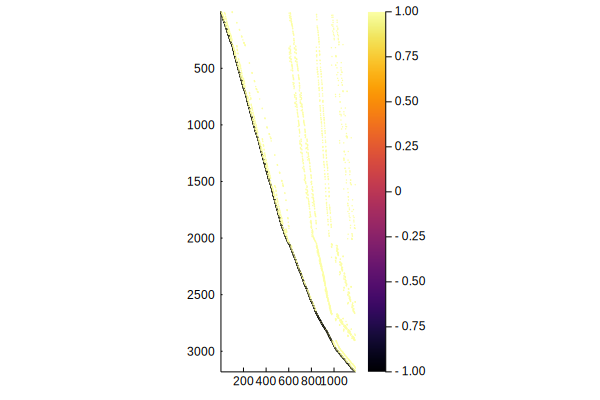

In [18]:
Wn, Tn = LC.chainCongruenceSM(W, T)
spy(Tn[1])

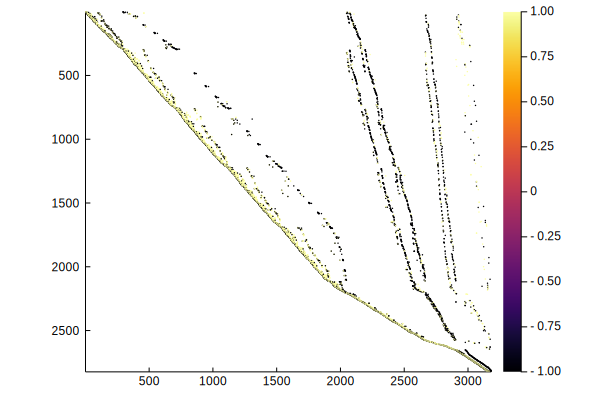

In [19]:
spy(Tn[2])

### Optimized Version

In [34]:
@benchmark LC.chainCongruenceSM_OPT(W, T)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  812.304 ms … 846.124 ms  ┊ GC (min … max): 0.00% … 0.72%
 Time  (median):     832.953 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   829.163 ms ±  11.386 ms  ┊ GC (mean ± σ):  0.20% ± 0.35%

  ▁        ▁                 ▁         █  ▁                   ▁  
  █▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  812 ms           Histogram: frequency by time          846 ms <

 Memory estimate: 22.95 MiB, allocs estimate: 814364.

In [73]:
Wn, Tn = LC.chainCongruenceSM_OPT(W, T)
colorview(Gray, Wn')




## <br>Example 3 - GraphBLAS based

Anche in questo caso l'utilizzo dei threads migliora notevolmente le prestazioni, si ha un miglioramento da un punto di vista temporale di circa 155 ms, e un risparmio da un punto di vista di spazio allocato di 13 MiB (Mebibyte)

In [76]:
Delta_0_GB = SparseMM.sm2gbm(Delta_0)
Delta_1_GB = SparseMM.sm2gbm(Delta_1)
T_GB = [Delta_0_GB, Delta_1_GB]

2-element Vector{GrB_Matrix{Int8}}:
 
 

GrB_Matrix{Int8}GrB_Matrix{Int8}GrB_Matrix{Int8}GrB_Matrix{Int8}GrB_Matrix{Int8}GrB_Matrix{Int8}

### Normal Version

In [77]:
@benchmark LC.chainCongruenceGB(W, T_GB)

BenchmarkTools.Trial: 22 samples with 1 evaluation.
 Range (min … max):  207.308 ms … 252.753 ms  ┊ GC (min … max): 0.00% … 3.56%
 Time  (median):     229.082 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   229.558 ms ±  11.502 ms  ┊ GC (mean ± σ):  1.09% ± 1.48%

  ▁▁          ▁▁  ▁      ▁█▁▁ ▁ ▁ █ ▁     ▁▁  █ ▁     ▁       ▁  
  ██▁▁▁▁▁▁▁▁▁▁██▁▁█▁▁▁▁▁▁████▁█▁█▁█▁█▁▁▁▁▁██▁▁█▁█▁▁▁▁▁█▁▁▁▁▁▁▁█ ▁
  207 ms           Histogram: frequency by time          253 ms <

 Memory estimate: 26.04 MiB, allocs estimate: 920122.

In [78]:
Wn, Tn = LC.chainCongruenceGB(W, T_GB)
colorview(Gray, Wn')

### Optimized Version

In [79]:
@benchmark LC.chainCongruenceGB_OPT(W, T_GB)

BenchmarkTools.Trial: 68 samples with 1 evaluation.
 Range (min … max):  72.419 ms … 86.055 ms  ┊ GC (min … max): 0.00% … 5.40%
 Time  (median):     73.004 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   74.542 ms ±  2.728 ms  ┊ GC (mean ± σ):  1.53% ± 2.65%

  ▂██▆                                       ▃                 
  ██████▅▅▄▁▁▄▁▁▁▁▄▁▄▁▄▁▁▁▁▄▁▁▁▁▁▁▄▁▁▁▁▁▁▄▁▁▁█▅▅▇▄▁▁▁▁▁▁▁▁▄▁▄ ▁
  72.4 ms         Histogram: frequency by time        79.8 ms <

 Memory estimate: 20.12 MiB, allocs estimate: 791240.

In [80]:
Wn, Tn = LC.chainCongruenceGB_OPT(W, T_GB)
colorview(Gray, Wn')

## <br> EXAMPLE 3 - Array of Array based

In [45]:
@benchmark V,EV,FV = LC.chainCongruenceAA(W', T)

BenchmarkTools.Trial: 97 samples with 1 evaluation.
 Range (min … max):  45.149 ms … 73.417 ms  ┊ GC (min … max): 0.00% … 11.43%
 Time  (median):     49.845 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   51.764 ms ±  5.043 ms  ┊ GC (mean ± σ):  2.52% ±  5.55%

            █▂ ▁                                               
  ▃▁▄▄▁▁▁▃▃▇██▆█▄▃▃▅▄▄▁▁▃▁▁▁▁▁▃▃▃▃▃▁▃▃▁▃▁▁▁▁▁▃▃▁▄▃▃▁▁▁▁▁▁▁▁▁▃ ▁
  45.1 ms         Histogram: frequency by time        67.6 ms <

 Memory estimate: 9.09 MiB, allocs estimate: 138109.

In [42]:
EV = Lar.removeDups(map(sort!,EV))
FV = Lar.removeDups(map(sort!,FV))
VV = [[v] for v=1:size(V,2)]

In [47]:
colorview(Gray, EV)

LoadError: MethodError: no method matching colorview(::Type{Gray}, ::Vector{Vector{Int64}})
[0mClosest candidates are:
[0m  colorview(::Type{C}, ::Any, [91m::Any[39m, [91m::Any...[39m) where C<:Colorant at /home/simoc/.julia/packages/ImageCore/kQ2WN/src/colorchannels.jl:186
[0m  colorview(::Type{C}) where C<:Colorant at /home/simoc/.julia/packages/ImageCore/kQ2WN/src/colorchannels.jl:215
[0m  colorview(::Type{C}, [91m::ImageMeta{T, N, A, P} where {A<:AbstractArray, P<:AbstractDict{Symbol, Any}}[39m) where {C<:Colorant, T, N} at /home/simoc/.julia/packages/ImageMetadata/3vPdr/src/ImageMetadata.jl:253
[0m  ...

In [38]:
using Base.Threads

function vertCongruenceAA_OPT(W)
	err, i, todelete, vclasses = 10^-6, 1, [], []
	verts = convert(Lar.Points, W')
	kdtree = NearestNeighbors.KDTree(verts)
	newverts = zeros(Int, size(verts,2))
	for vi in 1:size(verts,2)
        @async begin
            if !(vi in todelete)
                nearvs = NearestNeighbors.inrange(kdtree, verts[:,vi], err)
                push!(vclasses,nearvs)
                newverts[nearvs] .= i
                nearvs = setdiff(nearvs, vi)
                todelete = union(todelete, nearvs)
                i += 1
            end
        end
	end
	V = zeros(3,length(vclasses))
	for (k,class) in enumerate(vclasses)
			@async V[:,k] = sum(W[class,:],dims=1)/length(class)
	end
	return V, vclasses
end


function cellCongruenceAA_OPT(Delta,inclasses)
	cellarray = Lar.cop2lar(Delta)
	new_e = Array{Int64,1}(undef,size(Delta,2))
	for (k,class) in enumerate(inclasses)
		@async for e in class
			new_e[e] = k
		end
	end
    cells = [map(e->new_e[e], face) for face in cellarray]
    outclasses = DefaultOrderedDict{Array{Int64,1},Array{Int64,1}}([])
    for (k,face) in enumerate(cells)
        if outclasses[face] == []
            outclasses[face] = [k]
        else
            append!(outclasses[face],[k])
        end
    end
	FEnew = sort(collect(keys(outclasses)))
  outclasses = sort(collect(values(outclasses)))
  return FEnew,outclasses
end


function chainCongruenceAA_OPT(W, T)
	V, vclasses = vertCongruenceAA_OPT(W)
	EV, eclasses = cellCongruenceAA_OPT(T[1],vclasses)
	FE, fclasses = cellCongruenceAA_OPT(T[2],eclasses)
	#@show size(V,2) - size(EV,1) + size(FE,1)
	return V,EV,FE
end


chainCongruenceAA_OPT (generic function with 1 method)

In [46]:
@benchmark V,EV,FV = chainCongruenceAA_OPT(W', T)

BenchmarkTools.Trial: 99 samples with 1 evaluation.
 Range (min … max):  44.386 ms … 178.179 ms  ┊ GC (min … max): 0.00% … 72.54%
 Time  (median):     46.957 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   50.938 ms ±  17.216 ms  ┊ GC (mean ± σ):  5.62% ± 11.35%

  █▃                                                            
  ███▇▅▅▁▃▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂ ▁
  44.4 ms         Histogram: frequency by time          133 ms <

 Memory estimate: 6.41 MiB, allocs estimate: 100264.

In [44]:
EV = Lar.removeDups(map(sort!,EV))
FV = Lar.removeDups(map(sort!,FV))
VV = [[v] for v=1:size(V,2)]

8-element Vector{Vector{Int64}}:
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]

In [40]:
function cellCongruenceSM_OPT(cop, lo_cls, lo_sign; imp = false, d = 0)

	# Collide columns
	copCols = []
     for i = 1 : length(lo_cls)
        col = sum([
                cop[:, lo_cls[i][j]] .* lo_sign[i][j]
                for j = 1 : length(lo_cls[i])
            ])
            push!(copCols, col)
    end
#     let col = Array{Int64, 1}(undef, size(lo_cls, 2))
#     for i = 1 : length(lo_cls)
#         @async for j = 1 : length(lo_cls[i])
            
#            col = sum([cop[:, lo_cls[i][j]] .* lo_sign[i][j]])
#         end
#         push!(copCols, col)
#     end
#     end


	# Retrieve Matrix Form and extract rows
	cop = hcat(copCols...)
	rows = [cop[row, :] for row = 1 : cop.m]

	# Adjusting signs such that the first value always is `-1`
	sign = ones(Int8, cop.m)
	 for row = 1 : cop.m
        if rows[row].nzval[1] > 0
             begin
                rows[row] = -rows[row]
                sign[row] = -1
            end 
        end
    end

	# Sort rows in order to collide them quickly
	rows_ord = sortperm(rows)
	nrows = unique(rows[rows_ord])
	ho_cls = [Array{Int,1}() for i = 1 : length(nrows)]
	nidx = 1

	# Collide cells with same structure
	@sync for cidx = 1 : cop.m
        @async begin
            if rows[rows_ord[cidx]] != nrows[nidx]  
                nidx = nidx + 1;
            end
            push!(ho_cls[nidx], rows_ord[cidx])
        end
	end

	# Reshaping Sign and Cochain
    ho_sign = [[sign[el] for el in cell] for cell in ho_cls]
#	cop = convert(Lar.ChainOp, hcat(nrows...)')

	return hcat(nrows...)', ho_cls, ho_sign
end

"""
	chainCongruenceSM_OPT(
		G::Lar.Points, T::Array{Lar.ChainOp};
		imp=false, ϵ=1e-6
	)::Tuple{Lar.Points, Array{Lar.ChainOp}}

Perform the Geometry `G` congruence and coherently reshape the Topology `T` but with tasks
"""
function chainCongruenceSM_OPT(G, T; imp=false, ϵ=1e-6)
	# Perform the Geometry Congruence
	G, cls = LC.vertCongruenceOptimized(G; ϵ=ϵ)
	# Build default sign
	sign = [ones(Int8, length(cl)) for cl in cls]
	# Update the Topology coherently
	Tn = Array{Lar.ChainOp, 1}(undef, length(T))
    for d = 1 : length(T)
        Tn[d], cls, sign = cellCongruenceSM_OPT(T[d], cls, sign; imp=imp, d=d)
    end
	# Euler Characteristic
	# @show size(G,2) - size(T[1],1) + size(T[2],1)
	return G, Tn
end

chainCongruenceSM_OPT

In [125]:
@benchmark chainCongruenceSM_OPT(W, T)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  840.046 ms … 902.800 ms  ┊ GC (min … max): 0.81% … 0.70%
 Time  (median):     853.963 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   865.574 ms ±  29.517 ms  ┊ GC (mean ± σ):  0.25% ± 0.39%

  █        ▁       ▁                                          █  
  █▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  840 ms           Histogram: frequency by time          903 ms <

 Memory estimate: 25.39 MiB, allocs estimate: 836829.